# **New York city Trip Record**

![img](taxi_image2.png "Taxi")

## **Introduction**

In today's urban landscape, taxi and car rental services have become essential transportation options. These services provide immediate mobility solutions, offering vehicles with experienced drivers to fulfil passengers' transportation needs. Whether for business trips, daily commutes, or leisure activities, hailing a taxi, booking by phone, or requesting online provides a convenient and efficient way to travel from point A to point B.  Compared to public transportation, taxis and car rentals offer greater flexibility, allowing on-demand travel and door-to-door convenience.  Moreover, these services cater to diverse needs with budget-friendly taxis and spacious rental cars. Technological advancements have streamlined the process with ride-hailing apps simplifying booking and payment.  These services not only cater to individual needs but also potentially play a role in easing traffic congestion by reducing reliance on personal vehicles for short trips.

This analysis focuses on the hourly demand for Yellow cabs at car-hire stations around New York from January 2019 to March 2024. For simplicity, we have selected paid rides —whether by cash or credit card—with total amounts greater than zero. Our goal is to unravel the performance dynamics of yellow taxis within the city during the specified timeframe. 🚖🗽

## **Dataset**

The dataset contains car rides for yellow Taxi Cabs in the environs of New York, made between Jan 2019 and till present. Data was obtained from [TLC Trip record data](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page). The original data contains information about the pick-up and drop-off dates/times, pick-up and drop-off locations, trip distances, itemized fares, rate types, payment types, and driver-reported passenger counts. The data were collected and provided to the NYC Taxi and Limousine Commission (TLC) by technology providers authorized under the Taxicab & Livery Passenger Enhancement Programs (TPEP/LPEP).

Taxi trips paid by credit cards or cards were filtered, aggregated and stored in a database. The database contains trip records for pickup and dropoff stations. Pickup station's record contains the total number of trips leaving the station, the average distance of all trips, the average duration of all journeys and the revenue generated from all trips per hour of each day while the droppff station's record contains the total number of trips arriving the station, the average distance and duration of all trips.

## **Analysis workflow**
We will be looking at the following

### A. The summary performance of yellow taxis in New York city.
  
We will look at the total volume of rides recorded and the revenue generated by New York City Council (NYC) from Jan 2019 until now. We will also look at the average number of revenue generated per hour and the number of rides hauled by residents in each station. Next, we will examine whether customers use yellow cabs for short or long trips. We will do this by reviewing the average duration and distance travelled by cab clients. 

### B. Temporal Variations
Here, we will examine the temporal variations of the total number of rides and revenue generated over time and at various times of the year. We will review this station-wise and city-wise. This is to determine if cab demand and revenue are significantly affected by temporal variations. The temporal variations will be based on hour, day of week, month and year. Investigating this will enable us to understand the demand for taxis in New York at these times and provide better service to customers.

### C. Holiday events, seasonal and weekend/weekday impact on demand and revenue
Here, we will compare ride volume and revenue on holidays and special events with regular days and if these events significantly impact demand. Similarly, we will investigate customer behaviour by comparing ride volume and revenue patterns on weekdays and weekends and seasons of the year and if there's a significant difference in customer behaviour

### D. Station popularity
Here, we will analyse the number of rides originating from each pickup and dropoff station. We will look at the top and least 10 pickup and dropoff terminals. Analysing this will help to understand customer concentration areas and optimise service availability.

### E. Short vs Long trips
We will examine pickup stations associated with shorter or longer trips. We will estimate this by reviewing the average duration of trips in each station and group into short or long trips based on a duration cutoff.

### F. Station Pricing 
We will examine the average cost a trip costs in a pickup station and the average amount incurred in charges. This will be investigated based on the top 10 cheap and expensive stations across New York. This will enable us to understand pricing strategies to increase revenue.

### G. Borough and pickup station performance
We will examine the performance of pickup stations and all pickup stations in all the boroughs of New York. We will visualise in map the average revenue and taxi demand in all the pickup stations. This will be supplemented with borough information (that is, the total revenue and taxi rides)

## **Data Exploration**

In this section, we will perform some preliminary data exploration on the datasets we have. Firstly, we will load our libraries (data ingestion, cleaning and visualisation), set the notebook styles and do a quick preview of the tables in the database

In [1]:
# loading packages and libraries
from pathlib import os
import sqlite3
import holidays
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mizani.formatters as mfmt # for formatting plotnine

In [2]:
from scipy import stats
import datetime
import seaborn as sns
import scikit_posthocs as sp
import geopandas as gpd
import plotnine as pn

In [3]:
# set style
plt.style.use('tableau-colorblind10')
plt.rcParams['font.size'] = 9

In [4]:
# get working environment
path = os.getcwd()

In [309]:
# connect to database
conn = sqlite3.connect(f'{path}/TLC_trips.sqlite')

In [6]:
# read shapefile
nyc = gpd.read_file('taxi_zones/taxi_zones.shp')
nyc.shape

(263, 7)

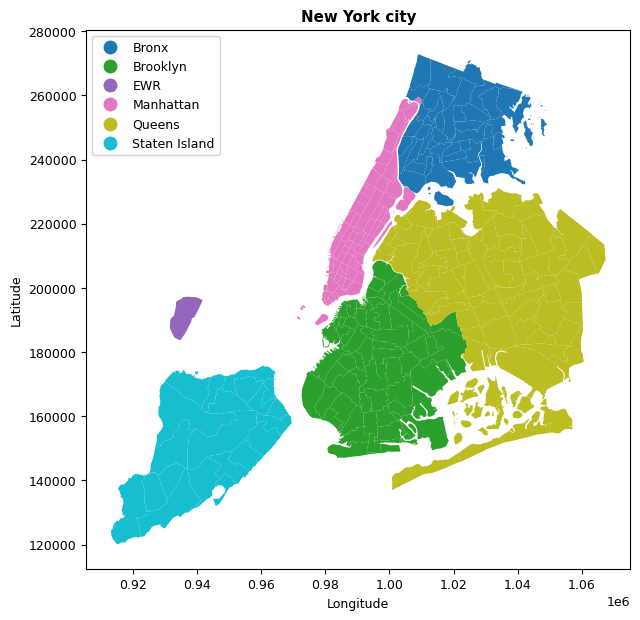

In [7]:
# New york city
nyc.plot('borough', figsize=(20,7), legend=True, legend_kwds={'loc':'upper left'})
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('New York city', fontweight='bold');

In [8]:
# checking columns in table (pickup)
pd.read_sql_query(
    """
    SELECT * 
    FROM pickup_trips 
    LIMIT 2;
    """, conn)

ride_datetime  pickup_station  hourly_rides     revenue  \
0  2019-01-01 00:00:00               4            35  524.520020   
1  2019-01-01 00:00:00               7             7  122.510002   

   duration_secs  distance_miles  total_fare_cost  
0     726.542847            2.64            393.5  
1     801.857117            4.09            102.0

In [9]:
# checking columns in table (dropoff)
pd.read_sql_query(
    """
    SELECT * 
    FROM dropoff_trips 
    LIMIT 2;
    """, conn)

ride_datetime  dropoff_station  hourly_rides  duration_secs  \
0  2019-01-01 00:00:00                1             1    1516.000000   
1  2019-01-01 00:00:00                4            68     796.441162   

   distance_miles  total_fare_cost  
0       13.900000             56.5  
1        2.157647            736.5

In [10]:
pd.read_sql_query(
    """
    SELECT * 
    FROM location_info 
    LIMIT 2;
    """, conn)

ride_station            zone borough   area_km2  length_km  n_cities  \
0             1  Newark Airport     EWR   7.343009  11.474523       232   
1             2     Jamaica Bay  Queens  13.369627  81.632216      2954   

    latitude  longitude  
0  40.691830 -74.174002  
1  40.616746 -73.831300

In [11]:
nyc.head(2)

OBJECTID  Shape_Leng  Shape_Area            zone  LocationID borough  \
0         1    0.116357    0.000782  Newark Airport           1     EWR   
1         2    0.433470    0.004866     Jamaica Bay           2  Queens   

                                            geometry  
0  POLYGON ((933100.918 192536.086, 933091.011 19...  
1  MULTIPOLYGON (((1033269.244 172126.008, 103343...

In [12]:
# get dates in table
dates = pd.read_sql("""
                    SELECT DISTINCT(strftime('%Y-%m', ride_datetime)) AS ride_date
                    FROM pickup_trips;
                    """, conn)

dates = pd.to_datetime(dates['ride_date'])

In [13]:
# number of rows in data

num_rows = pd.read_sql("""
                        SELECT COUNT(*) AS total 
                        FROM pickup_trips
                        """, conn)

num_rows = num_rows.unstack().values[0]

In [14]:
min_date = datetime.datetime.strftime(min(dates), '%b %Y')
max_date = datetime.datetime.strftime(max(dates), '%b %Y')

In [15]:
print(f'There are {num_rows:,} paid rides from {min_date} to {max_date}')

There are 4,758,873 paid rides from Jan 2019 to Mar 2024


In [16]:
tot_stations = pd.read_sql_query("""
                                 SELECT count(ride_station) 
                                 FROM location_info
                                 """, conn)
tot_stations = tot_stations.unstack().values[0]
print('There are %i Yellow Taxi Cab stations in New York.'%tot_stations)

There are 263 Yellow Taxi Cab stations in New York.


In [17]:
# get holidays in the US from beginning to current
us_holidays = holidays.UnitedStates(years=list(range(min(dates).year, max(dates).year+1)))
us_holidays = pd.DataFrame(us_holidays.items(), columns=['date', 'name'])
us_holidays = us_holidays.sort_values('date').reset_index(drop=True)

us_holidays.head(3)

date                        name
0  2019-01-01              New Year's Day
1  2019-01-21  Martin Luther King Jr. Day
2  2019-02-18       Washington's Birthday

## **Analysis**

In this section, we will answer the questions posed above. We will do a quick summary of yellow taxis in New York. We will obtain the performance of yellow cabs in New York from 2019 till the present. Next, we will investigate the change in hourly rides over time, per hour, day, month and year. Additionally, we will look at the impact of holiday events, seasonal events and weekdays/weekends on hourly taxi demand and revenue generated. We will test for their statistical significance using an appropriate statistical test

### A. Taxi cab performance

We investigate the performance of yellow taxis in New York from 2019 till the present date. We will obtain some important KPIs such as the average hourly ride in a pickup terminal and in all pickup terminals, the total revenue obtained, the average distance covered, the average duration for a trip and the average revenue generated by a pickup station.

In [18]:
# total rides and revenues (by station)
res = pd.read_sql_query(
    """
    SELECT SUM(hourly_rides) total_rides, 
           SUM(revenue) total_revenue, 
           AVG(hourly_rides) average_ride_per_station, 
           AVG(revenue) total_revenue_per_station,
           AVG(duration_secs)/60 avg_trip_duration,
           AVG(distance_miles)*1.609344 ave_distance
    FROM pickup_trips;
    """, 
    conn
).to_numpy().flatten()

In [19]:
res2 = pd.read_sql_query(
    """
    WITH daily_hourly_rides as (
          SELECT ride_datetime, 
                 SUM(hourly_rides) tot_rides, 
                 SUM(revenue) tot_revenue 
          FROM pickup_trips 
          GROUP BY ride_datetime
        )
    -- write query
    SELECT AVG(tot_rides) total_rides_per_hour, 
           AVG(tot_revenue) total_revenue_per_hour
    FROM daily_hourly_rides;
    """, 
    conn
).to_numpy().flatten()

In [20]:
print('Key Performance Indicator\n***************************')
print(f'Total rides demanded: {res[0]:,.0f}\nTotal revenue generated: ${res[1]:,.2f}\
\nAverage distance covered (KM): {res[-1]:,.2f}\nAverage trip duration (Mins): {res[-2]:,.2f}\
\nAverage ride per Hour (New York): {res2[0]:,.0f}\nAverage revenue per hour (New York): ${res2[1]:,.2f}\
\nAverage ride per hour (station): {res[2]:,.0f}\nAverage revenue per hour (station): ${res[3]:,.2f}')

Key Performance Indicator
***************************
Total rides demanded: 173,900,955
Total revenue generated: $3,972,799,162.78
Average distance covered (KM): 35.55
Average trip duration (Mins): 20.19
Average ride per Hour (New York): 3,780
Average revenue per hour (New York): $86,361.44
Average ride per hour (station): 37
Average revenue per hour (station): $834.82


**Insights**

- Over 173 million paid rides have been demanded from New York residents and almost 4 billion dollars has been generated in revenue from Jan 2019 to the current date.
- Cab drivers travelled an average of 35.5 km with each trip lasting about 20 minutes on average.
- An average of 3,780 taxis are demanded per hour in New York with 37 taxis in each station.
- Per hour, an average of 86,000 dollars is generated in revenue in New York which translates to over 830 dollars in each station.

### B. Temporal Variations

Here, we will look at the change in hourly demand and generated revenue over time. We will drill down to visualise them by the hour of the day, day of the week, month, year, and month of the year. We will also do this by all terminals in the city and estimate in one pickup station.

In [21]:
# city and pickup station daily hourly rides
city_hourly_rides_query = """
                            SELECT ride_datetime, 
                                   CAST(strftime('%H', ride_datetime) as INT) AS hour,
                                   SUM(hourly_rides) AS total_rides,
                                   SUM(revenue) as total_revenue
                            FROM pickup_trips
                            GROUP BY ride_datetime
                            """

station_hourly_rides_query = """
                            SELECT ride_datetime, 
                                   CAST(strftime('%H', ride_datetime) as INT) AS hour,
                                   AVG(hourly_rides) AS avg_rides,
                                   AVG(revenue) as avg_revenue
                            FROM pickup_trips
                            GROUP BY ride_datetime
                            """

In [22]:
city_hourly_rides = pd.read_sql_query(city_hourly_rides_query, 
                                      conn, 
                                      parse_dates=['ride_datetime'])

station_hourly_rides = pd.read_sql_query(station_hourly_rides_query, 
                                         conn, 
                                         parse_dates=['ride_datetime'])

In [23]:
city_hourly_rides.head(3)

ride_datetime  hour  total_rides  total_revenue
0 2019-01-01 00:00:00     0         8582  148157.220062
1 2019-01-01 01:00:00     1        10269  180773.689424
2 2019-01-01 02:00:00     2         8927  156776.280200

In [24]:
station_hourly_rides.head(3)

ride_datetime  hour  avg_rides  avg_revenue
0 2019-01-01 00:00:00     0  58.780822  1014.775480
1 2019-01-01 01:00:00     1  69.857143  1229.752989
2 2019-01-01 02:00:00     2  66.125926  1161.305779

#### Summary of Distribution

Here, we will explore the distribution of hourly taxi rides in stations and city. We will visualise a summary statistics (min, mean, median, max, kurtosis etc) of the distributions in a tabular format and graph.

In [25]:
def get_outliers(x, method='iqr'):
    if method == 'iqr':
        q3 = np.percentile(x, 75)
        q1 = np.percentile(x, 25)
        iqr = q3 - q1
        lower = q1 - 1.5*iqr
        upper = q3 + 1.5*iqr
        outliers = (x < lower) | (x > upper)
    elif method == 'zscore':
        x_mean = x.mean()
        x_sd = x.std()
        x_scaled = (x - x_mean) / x_sd
        outliers = abs(x_scaled) > 3
    return outliers

In [26]:
def describe_data(df, caption=None):
    iqr = lambda x: x.quantile(0.75) - x.quantile(0.25)
    iqr.__name__ = 'iqr'
    num_outliers = lambda x: sum(get_outliers(x))
    num_outliers.__name__ = 'num_outliers'
    
    summary = pd.concat([df.describe(), df.agg(['skew', 'kurt', iqr, num_outliers])]).to_frame().T
    summary = summary.drop('count', axis=1)
    
    summary = summary.rename(
        {
            '25%':'p25', 
            '75%':'p75', 
            '50%':'median', 
            'kurt':'kurtosis'
        }, axis=1)
    
    summary = summary[['min', 'p25', 'mean', 'median', 'p75', 'max', 
                       'std', 'skew', 'kurtosis', 'iqr', 'num_outliers']]
    
    summary.columns = summary.columns.str.title()
    if caption is None:
        return summary.style.format('{:.2f}').set_caption('Summary statistics Table')
    else:
        return summary.style.format('{:.2f}').set_caption(caption)

**Descriptive statistics**

In [27]:
describe_data(city_hourly_rides.total_rides, 'Summary Statistics Table (City)')

In [28]:
describe_data(station_hourly_rides.avg_rides, 'Summary Statistics Table (Station)')

In [29]:
describe_data(city_hourly_rides.total_revenue, 'Summary Statistics Table (City)')

In [30]:
describe_data(station_hourly_rides.avg_revenue, 'Summary Statistics Table (Station)')

__Distribution__

In [31]:
city_station_rides = pd.concat(
    [
        city_hourly_rides.assign(group='city').rename(
            {'total_revenue':'revenue', 'total_rides':'rides'}, axis=1),
        station_hourly_rides.assign(group='station').rename(
            {'avg_revenue':'revenue', 'avg_rides':'rides'}, axis=1)
    ]
)

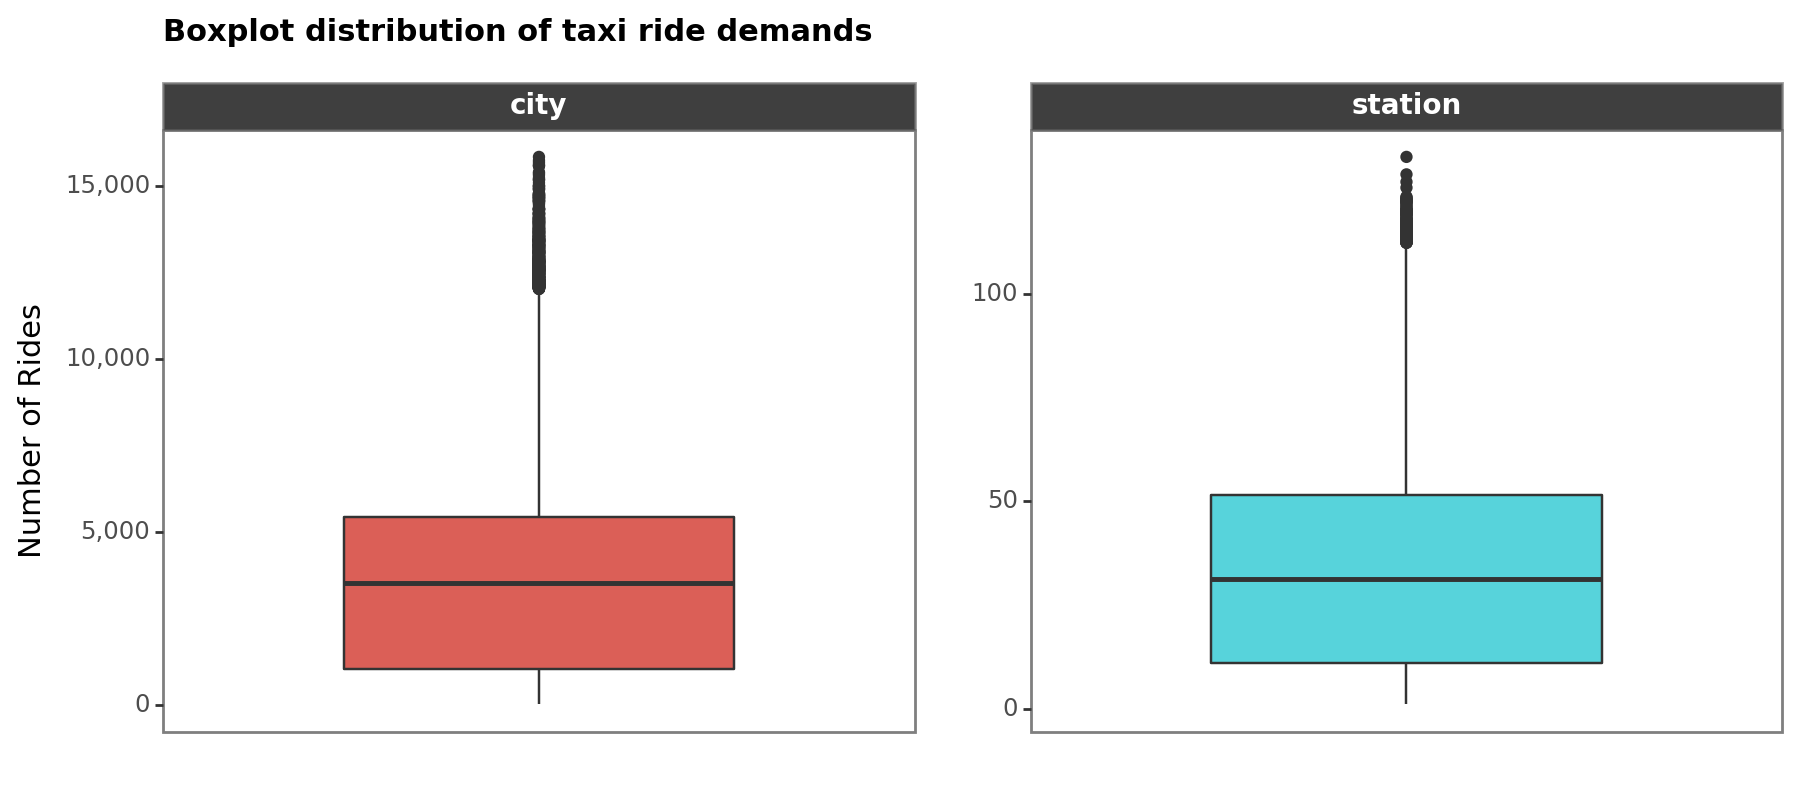

<Figure Size: (900 x 400)>

In [32]:
(
    pn.ggplot(city_station_rides, mapping=pn.aes(y='rides', fill='group')) +
    pn.geom_boxplot(width=0.4) +
    pn.facet_wrap('group', scales='free_y') +
    pn.theme_bw() +
    pn.theme(legend_position='none', 
             figure_size=(9,4.5),
             strip_text=pn.element_text(size=10, color='white', weight='bold'),
             strip_background=pn.element_rect(fill='k', alpha=0.5),
             axis_text_x=pn.element_blank(),
             panel_grid=pn.element_blank(),
             plot_title=pn.element_text(size=11, face='bold'),
             axis_ticks_minor_x=pn.element_blank(),
             axis_ticks_major_x=pn.element_blank()) +
    pn.labs(title='Boxplot distribution of taxi ride demands',
            y='Number of Rides', x='') +
    pn.xlim((-0.35, 0.35)) +
    pn.scale_y_continuous(labels=mfmt.custom_format('{:,.0f}'))
)

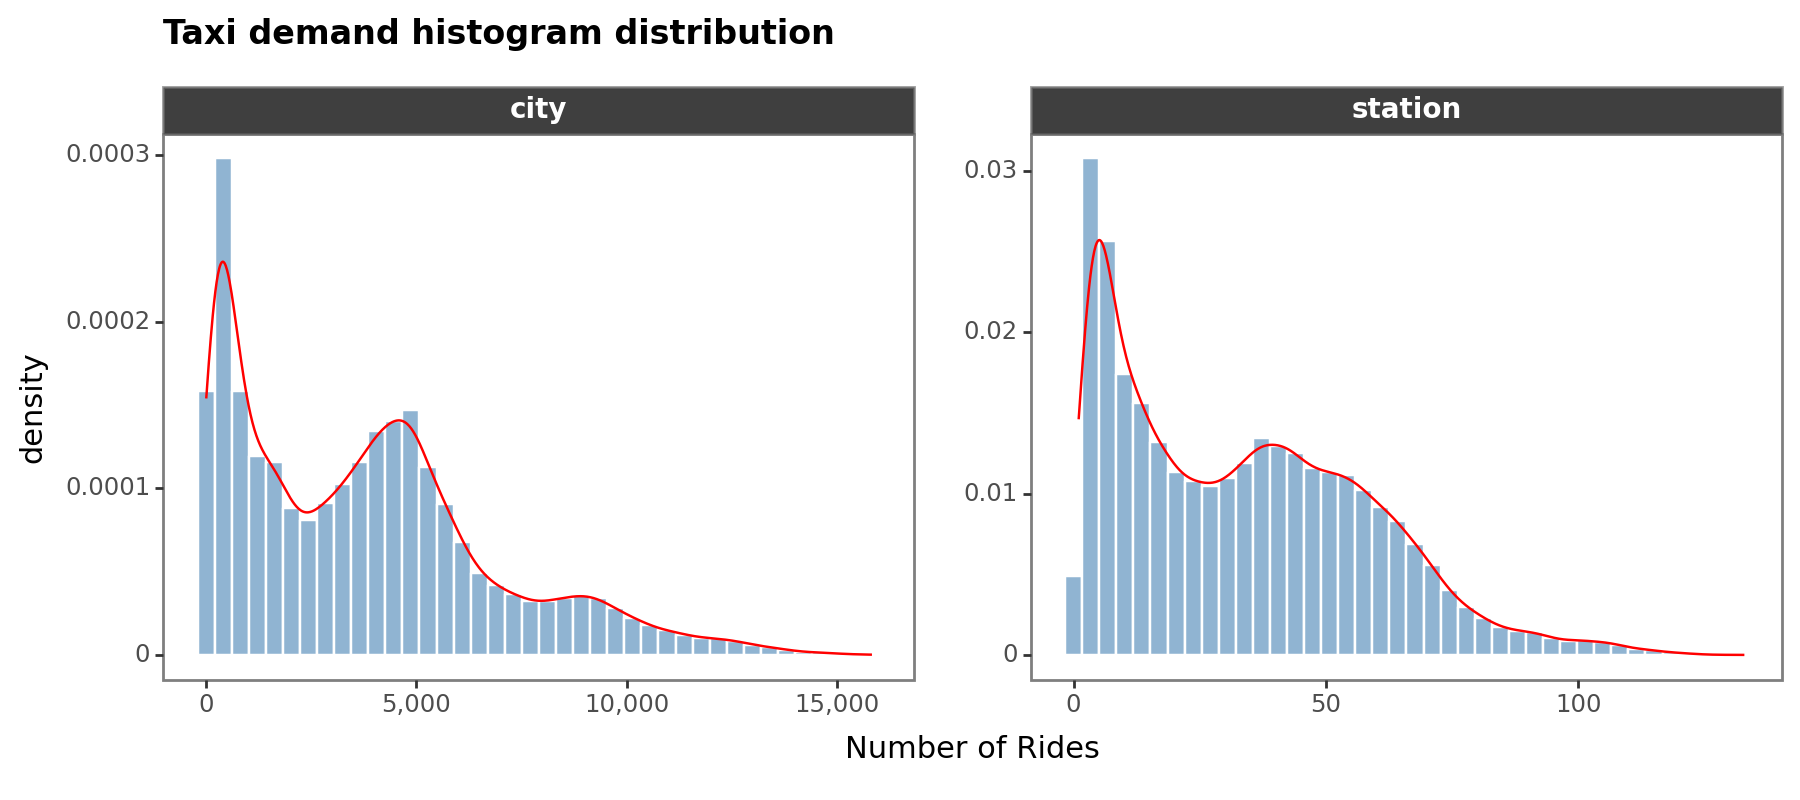

<Figure Size: (900 x 400)>

In [33]:
(
    pn.ggplot(city_station_rides, mapping=pn.aes(x='rides', y='..density..')) +
    pn.geom_histogram(bins=40, color='white', fill='steelblue', alpha=0.6) +
    pn.geom_density(color='red') +
    pn.facet_wrap('group', scales='free') +
    pn.theme_bw() +
    pn.theme(legend_position='none', 
             figure_size=(9,4.5),
             panel_grid=pn.element_blank(),
             strip_text=pn.element_text(size=10, color='white', weight='bold'),
             strip_background=pn.element_rect(fill='k', alpha=0.5),
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.labs(title='Taxi demand histogram distribution', x='Number of Rides') +
    pn.scale_x_continuous(labels=mfmt.custom_format('{:,.0f}'))
)

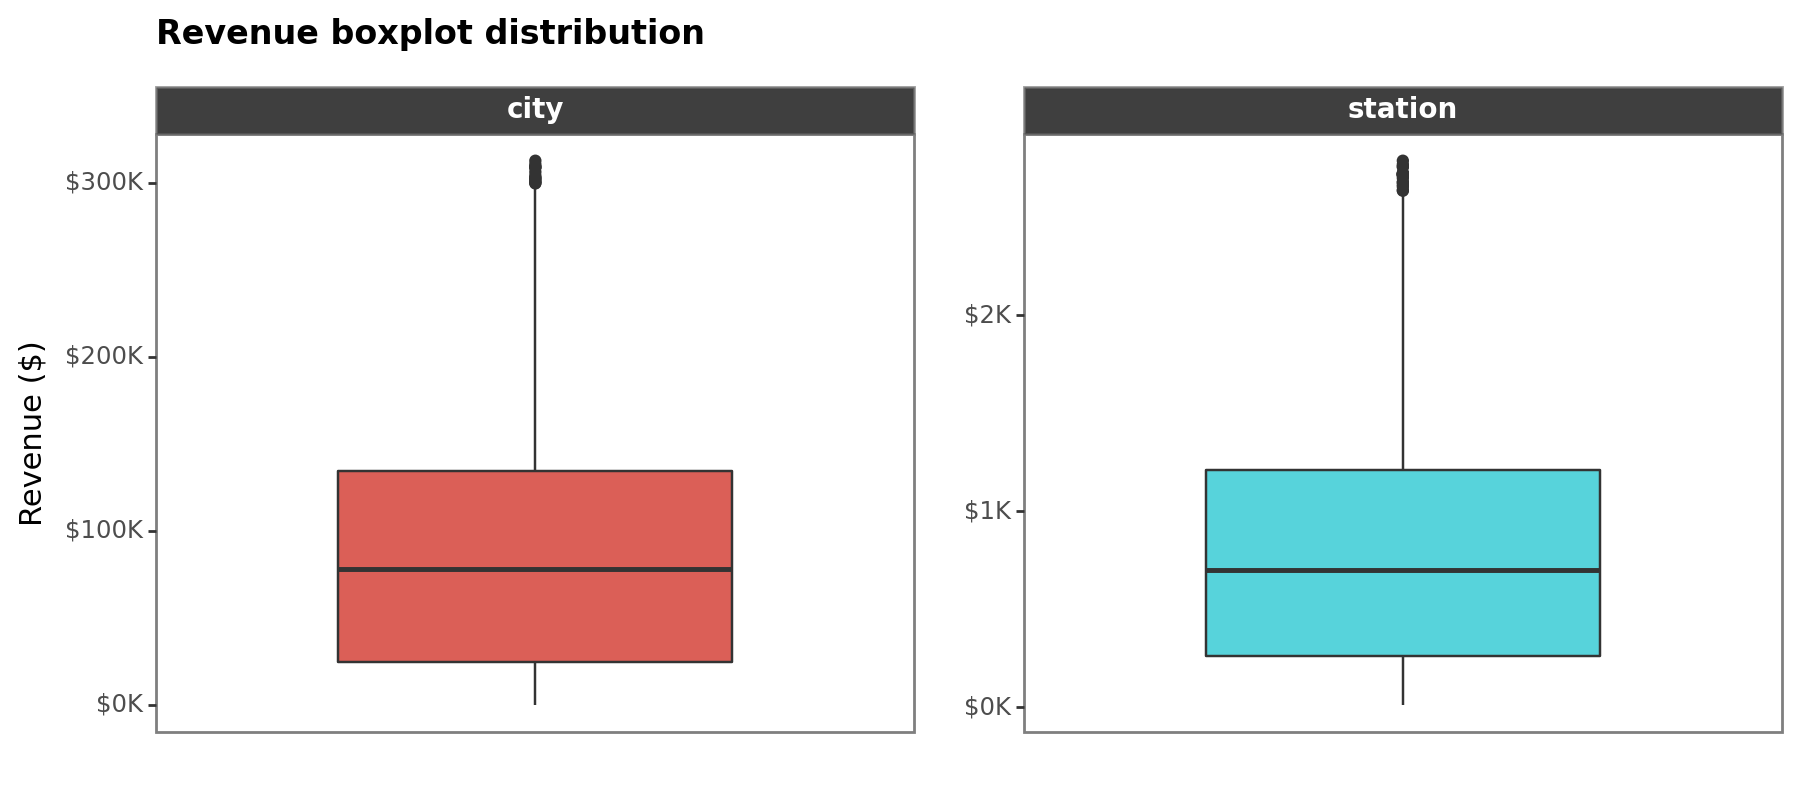

<Figure Size: (900 x 400)>

In [34]:
(
    pn.ggplot(city_station_rides, mapping=pn.aes(y='revenue/1e3', fill='group')) +
    pn.geom_boxplot(width=0.4) +
    pn.facet_wrap('group', scales='free_y') +
    pn.theme_bw() +
    pn.theme(legend_position='none', 
             figure_size=(9,4.5),
             panel_grid=pn.element_blank(),
             strip_text=pn.element_text(size=10, color='white', weight='bold'),
             strip_background=pn.element_rect(fill='k', alpha=0.5),
             axis_text_x=pn.element_blank(),
             plot_title=pn.element_text(size=12, face='bold'),
             axis_ticks_minor_x=pn.element_blank(),
             axis_ticks_major_x=pn.element_blank()) +
    pn.labs(title='Revenue boxplot distribution',
            y='Revenue ($)', x='') +
    pn.xlim((-0.35, 0.35)) +
    pn.scale_y_continuous(labels=mfmt.custom_format('${:,.0f}K'))
)

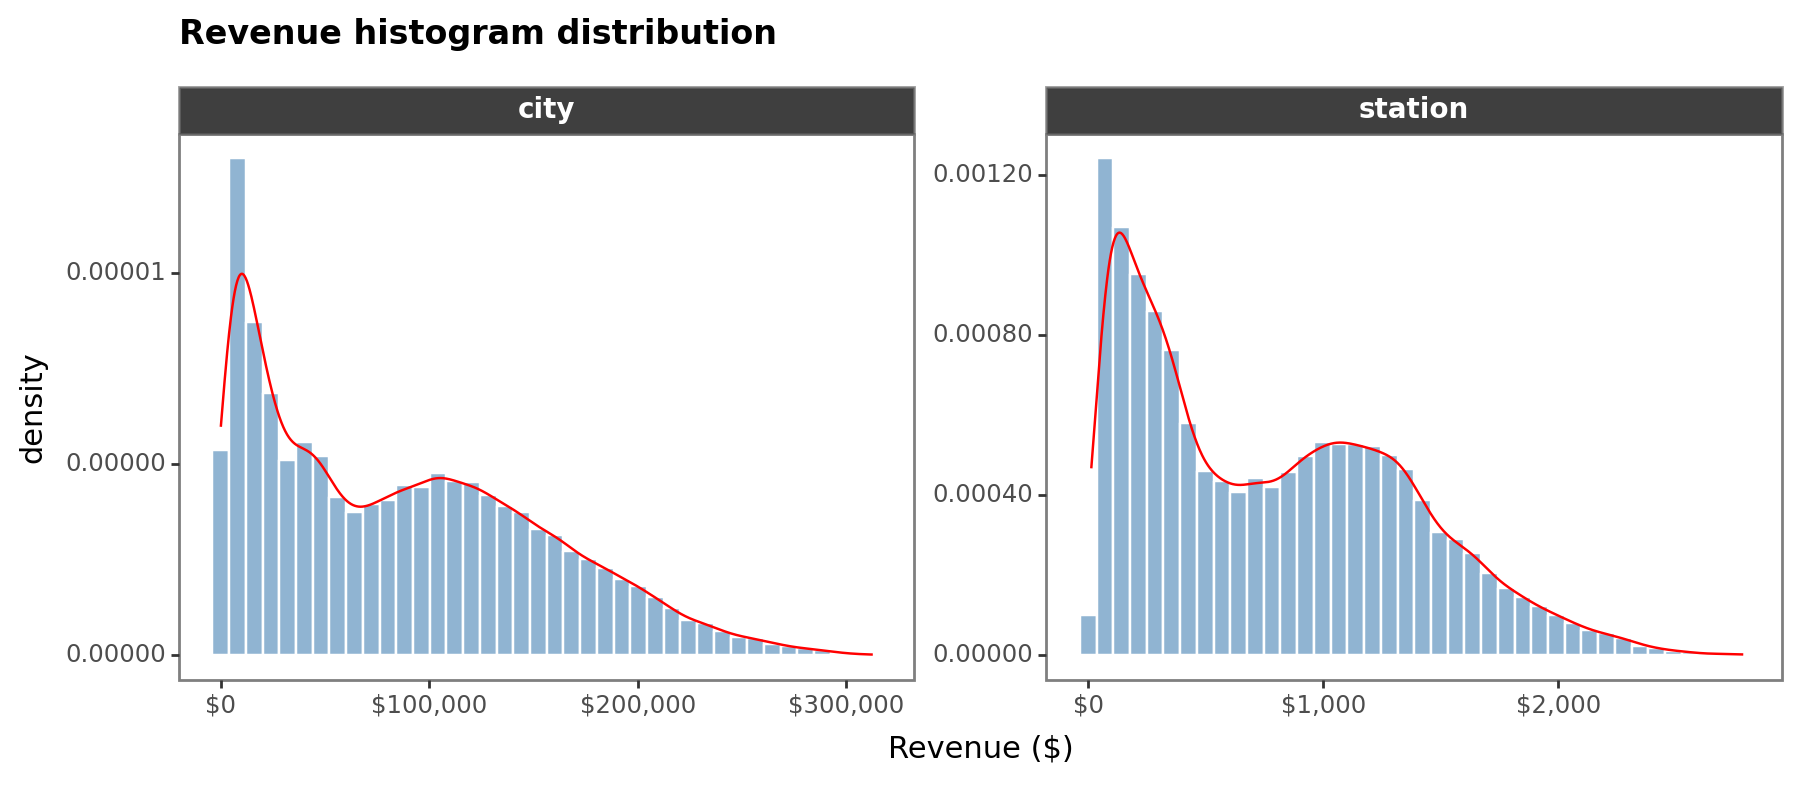

<Figure Size: (900 x 400)>

In [35]:
(
    pn.ggplot(city_station_rides, mapping=pn.aes(x='revenue', y='..density..')) +
    pn.geom_histogram(bins=40, color='white', fill='steelblue', alpha=0.6) +
    pn.geom_density(color='red') +
    pn.facet_wrap('group', scales='free') +
    pn.theme_bw() +
    pn.theme(legend_position='none', 
             figure_size=(9,4.5),
             panel_grid=pn.element_blank(),
             strip_text=pn.element_text(size=10, color='white', weight='bold'),
             strip_background=pn.element_rect(fill='k', alpha=0.5),
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.labs(title='Revenue histogram distribution',
            x='Revenue ($)') +
    pn.scale_x_continuous(labels=mfmt.dollar_format(digits=0, big_mark=',')) +
    pn.scale_y_continuous(labels=mfmt.custom_format('{:.5f}'))
)

#### City and Station Hourly taxi demand and revenue over time

Here, we will look at the hourly taxi demand and revenue for New York by city and each station. This will be aggregated in 28-D moving average

- **City**

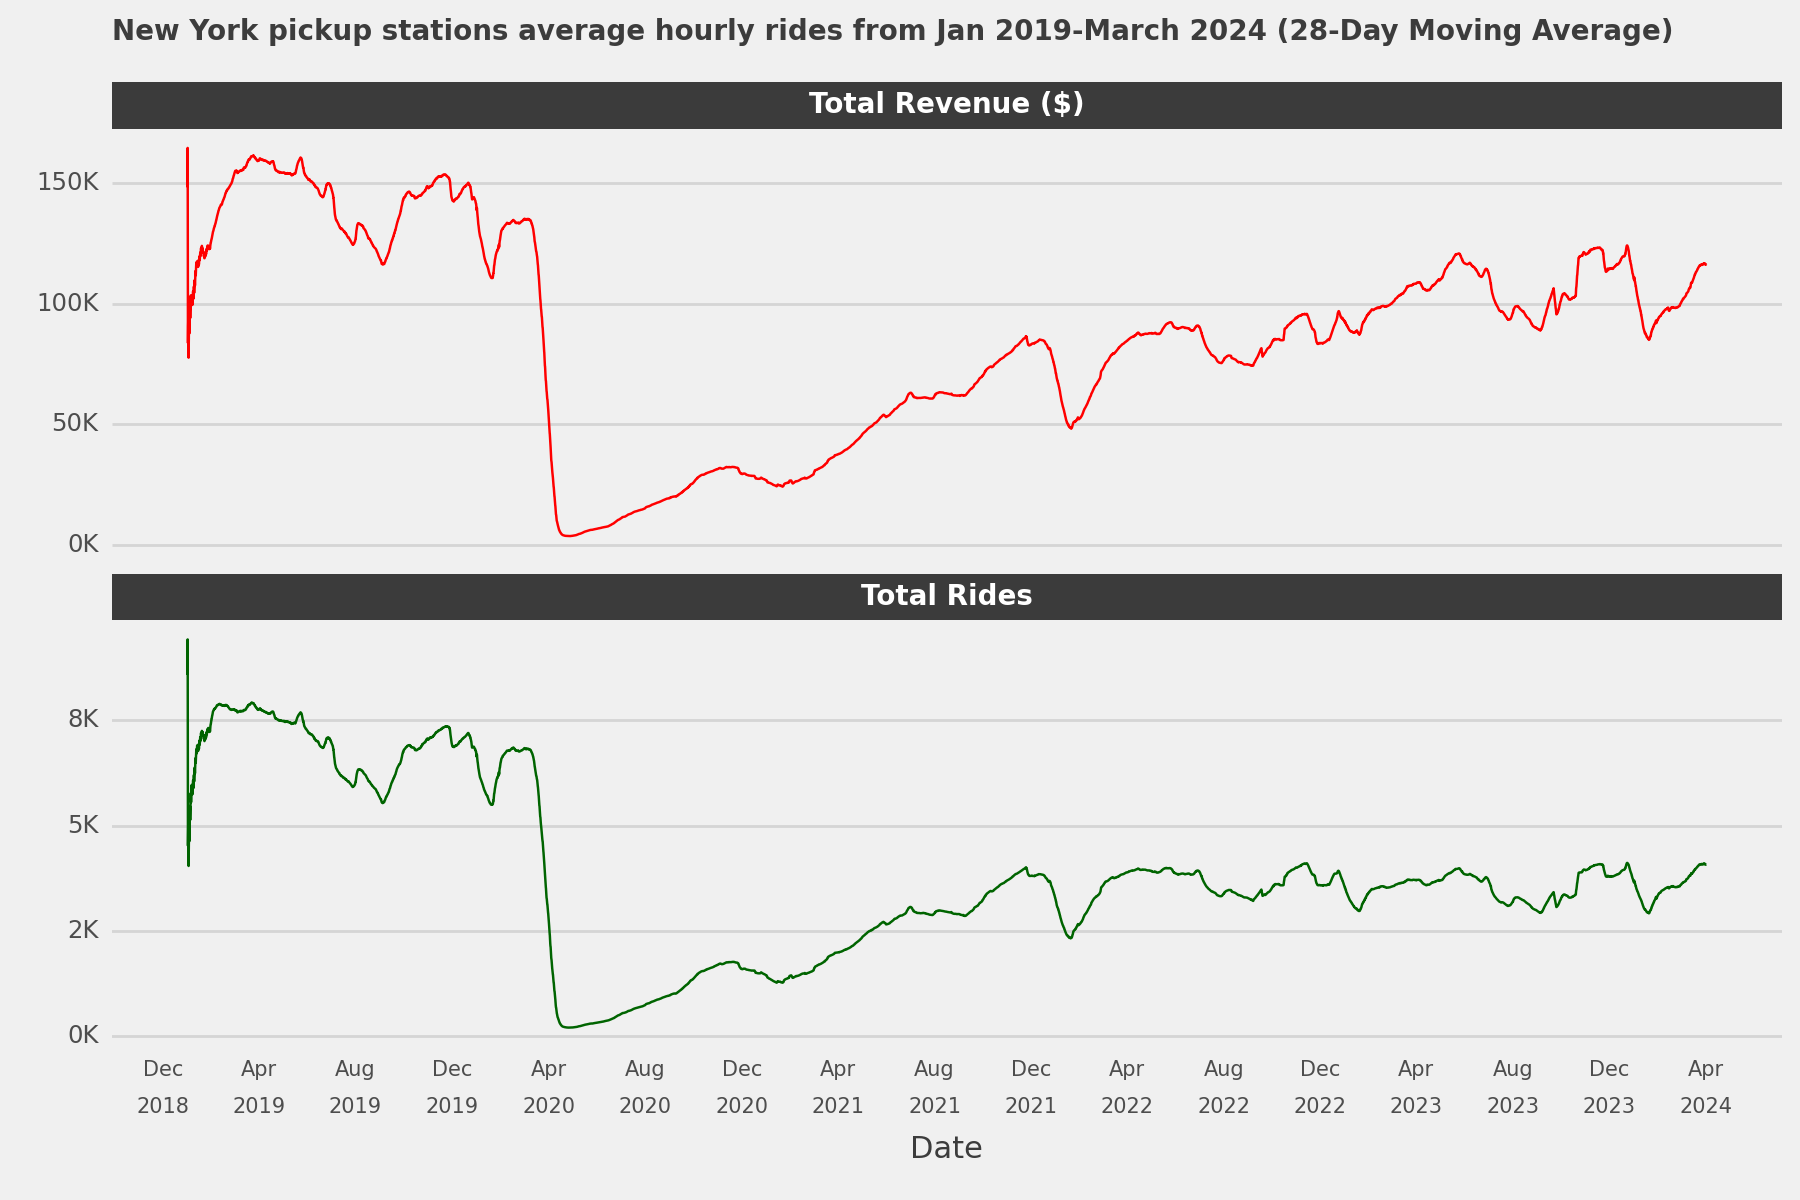

<Figure Size: (900 x 600)>

In [36]:
# hourly revenue and rides in all pickup stations in New York
df = (
    city_hourly_rides
    .set_index('ride_datetime')
    .rolling('28D').agg({'total_rides': 'mean', 'total_revenue':'mean'})
    .reset_index()
    .melt(id_vars='ride_datetime', var_name='name')
    )
(
    pn.ggplot(df,
              mapping=pn.aes('ride_datetime', 'value/1e3', color='name')) +
    pn.geom_line() +
    pn.facet_wrap('~name', nrow=2, scales='free_y',
                 labeller=pn.labeller(
                     cols=lambda x: 'Total Revenue ($)' if x == 'total_revenue' else 'Total Rides'
                 )) +
    pn.scale_x_date(date_labels='%b\n\n%Y', date_breaks='4 month') +
    pn.theme_538() +
    pn.theme(plot_title=pn.element_text(face='bold', size=10), 
             legend_position='none',
             strip_background=pn.element_rect(fill='black', alpha=0.5),
             strip_text=pn.element_text(color='white', size=10, face='bold'),
             axis_text_x=pn.element_text(size=7.5),
             panel_grid_major_x=pn.element_blank(),
             figure_size=(9,6)) +
    pn.labs(x='Date', y='') +
    pn.scale_colour_manual(values=['red', 'darkgreen']) +
    pn.scale_y_continuous(labels=mfmt.custom_format('{:,.0f}K')) + 
    pn.ggtitle('New York pickup stations average hourly rides from Jan 2019-March 2024 (28-Day Moving Average)') 
)

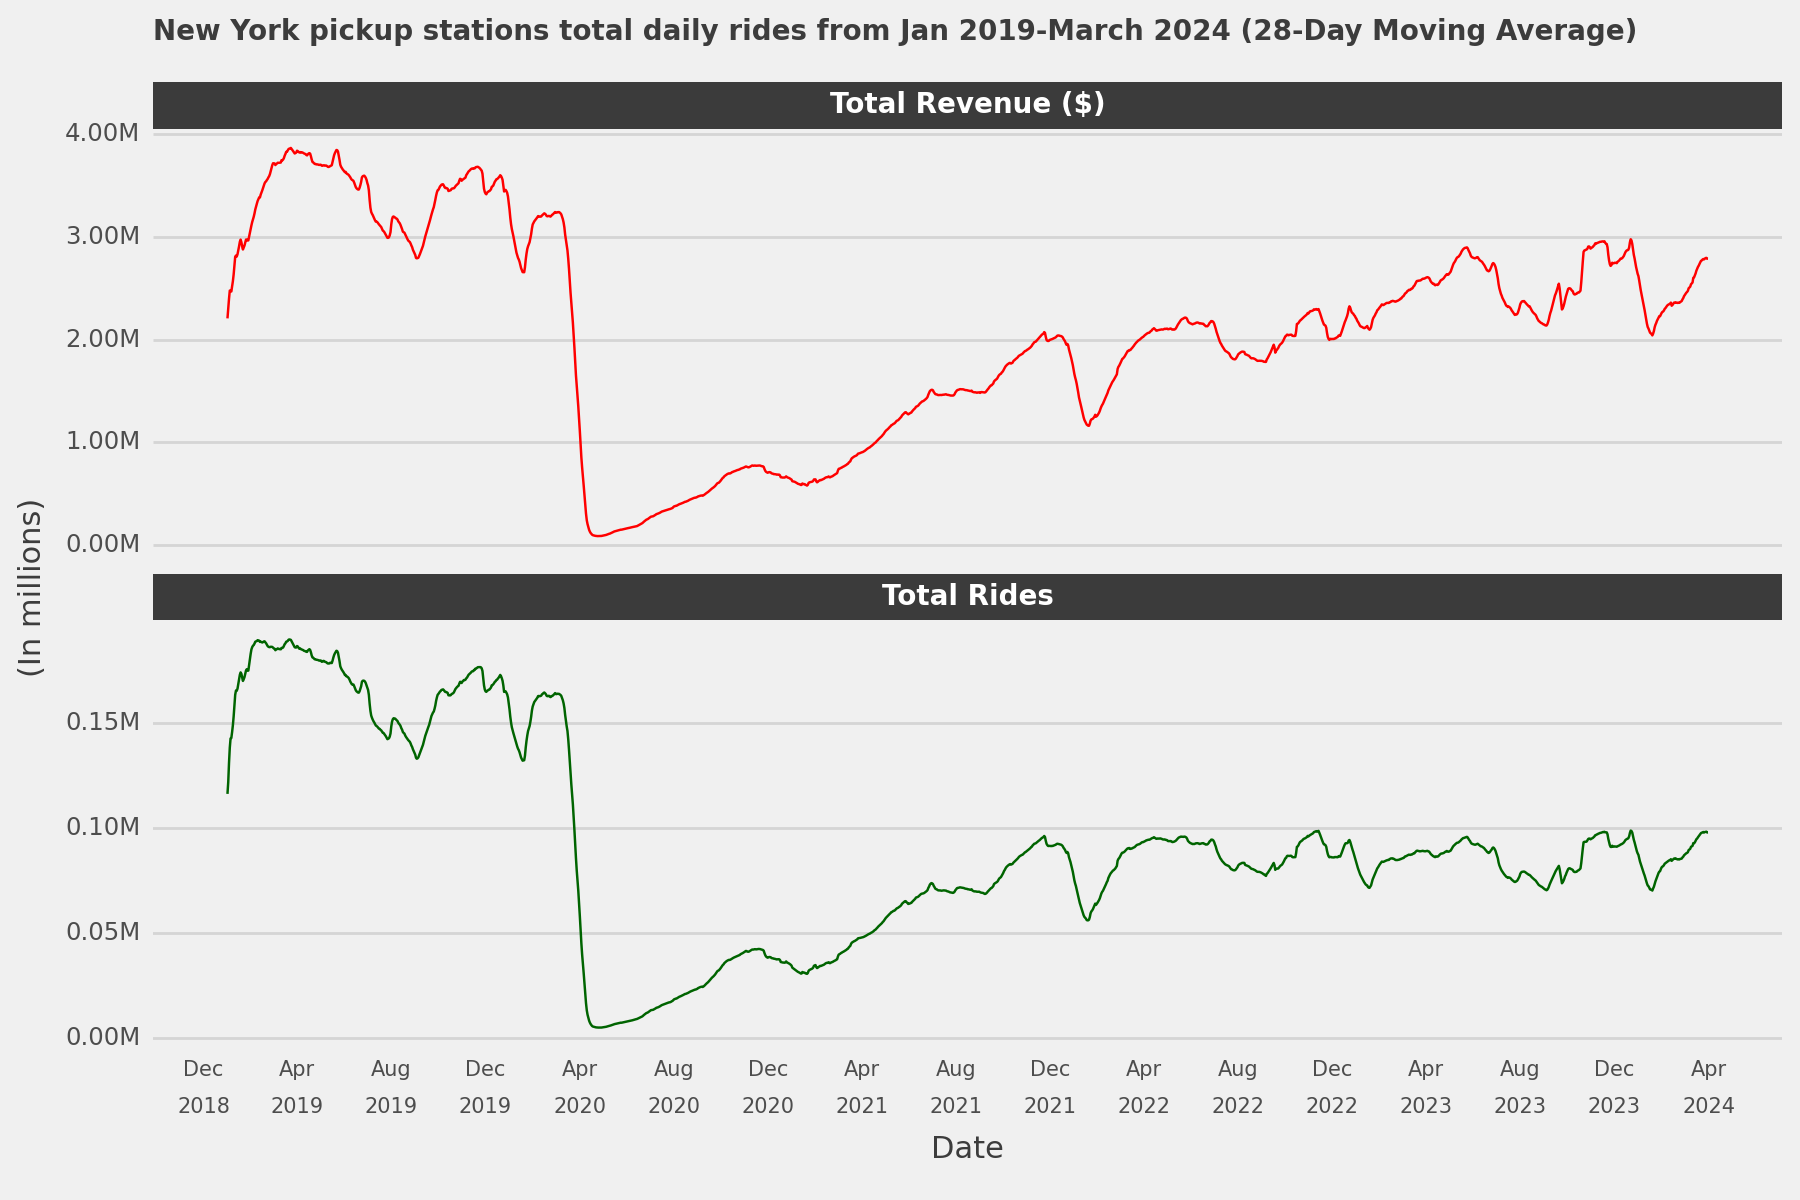

<Figure Size: (900 x 600)>

In [37]:
# daily revenue and rides in all stations in New York (smoothened by a 28-D moving average)
df = ((city_hourly_rides
      .set_index('ride_datetime')
      .resample('D').agg({'total_rides': 'sum', 'total_revenue':'sum'})
      .rolling('28D').agg({'total_rides': 'mean', 'total_revenue':'mean'})/1e6)
      .reset_index()
      .melt(id_vars='ride_datetime', var_name='name')
     )

# visualise
(
    pn.ggplot(df,
              mapping=pn.aes('ride_datetime', 'value', color='name')) +
    pn.geom_line() +
    pn.facet_wrap('~name', nrow=2, scales='free_y',
                 labeller=pn.labeller(
                     cols=lambda x: 'Total Revenue ($)' if x == 'total_revenue' else 'Total Rides'
                 )) +
    pn.scale_x_date(date_labels='%b\n\n%Y', date_breaks='4 month') +
    pn.theme_538() +
    pn.theme(plot_title=pn.element_text(face='bold', size=10), 
             legend_position='none',
             strip_background=pn.element_rect(fill='k', alpha=0.5),
             strip_text=pn.element_text(color='white', size=10, face='bold'),
             axis_text_x=pn.element_text(size=7.5),
             panel_grid_major_x=pn.element_blank(),
             figure_size=(9,6)) +
    pn.labs(x='Date', y='(In millions)') +
    pn.scale_colour_manual(values=['red', 'darkgreen']) +
    pn.scale_y_continuous(labels=mfmt.custom_format(fmt='{:.2f}M')) + 
    pn.ggtitle('New York pickup stations total daily rides from Jan 2019-March 2024 (28-Day Moving Average)') 
)

The figures above show the average hourly and daily taxi demand in all pickup stations in New York

- From above, we see that there's a seasonal trend in the demand for car rides which has an effect on the revenue generated
- Increase in demand at the beginning of the year and the first peak during the month before Summer. Lower demand in summer could be because workers are on vacation and students are also on holidays, hence less demand for taxis.
- After the Summer holidays, demand begins to increase and peaks around November before declining again around the Christmas holiday month (December)
- On average, there are about 90,000 daily rides (dashed black line).
- In 2020, taxi demand fell to almost zero. This decline was a result of the COVID-19 lockdown era in the US when movement restrictions were made by the government. These incidents affected the use of taxis by commuters in New York
- After the lockdown, taxi cab demand began to rise in 2021 and has remained relatively the same year-over-year till the current date.
- More taxi rides were booked before the 2021 era with the average hourly and daily rides over 4,000 and 100,000 respectively. This could be because yellow taxis were more popular than other types of taxis such as Lyft, Uber, Juno and Via
- The amount of revenue has had a uptrend since after the covid-19 lockdown (maybe trip fare is increased every year) while the demand for rides briefly had an uptrend till 2021 and since 2022, the demand for taxis are relatively the same on average (less than 1 million).

- **Station**

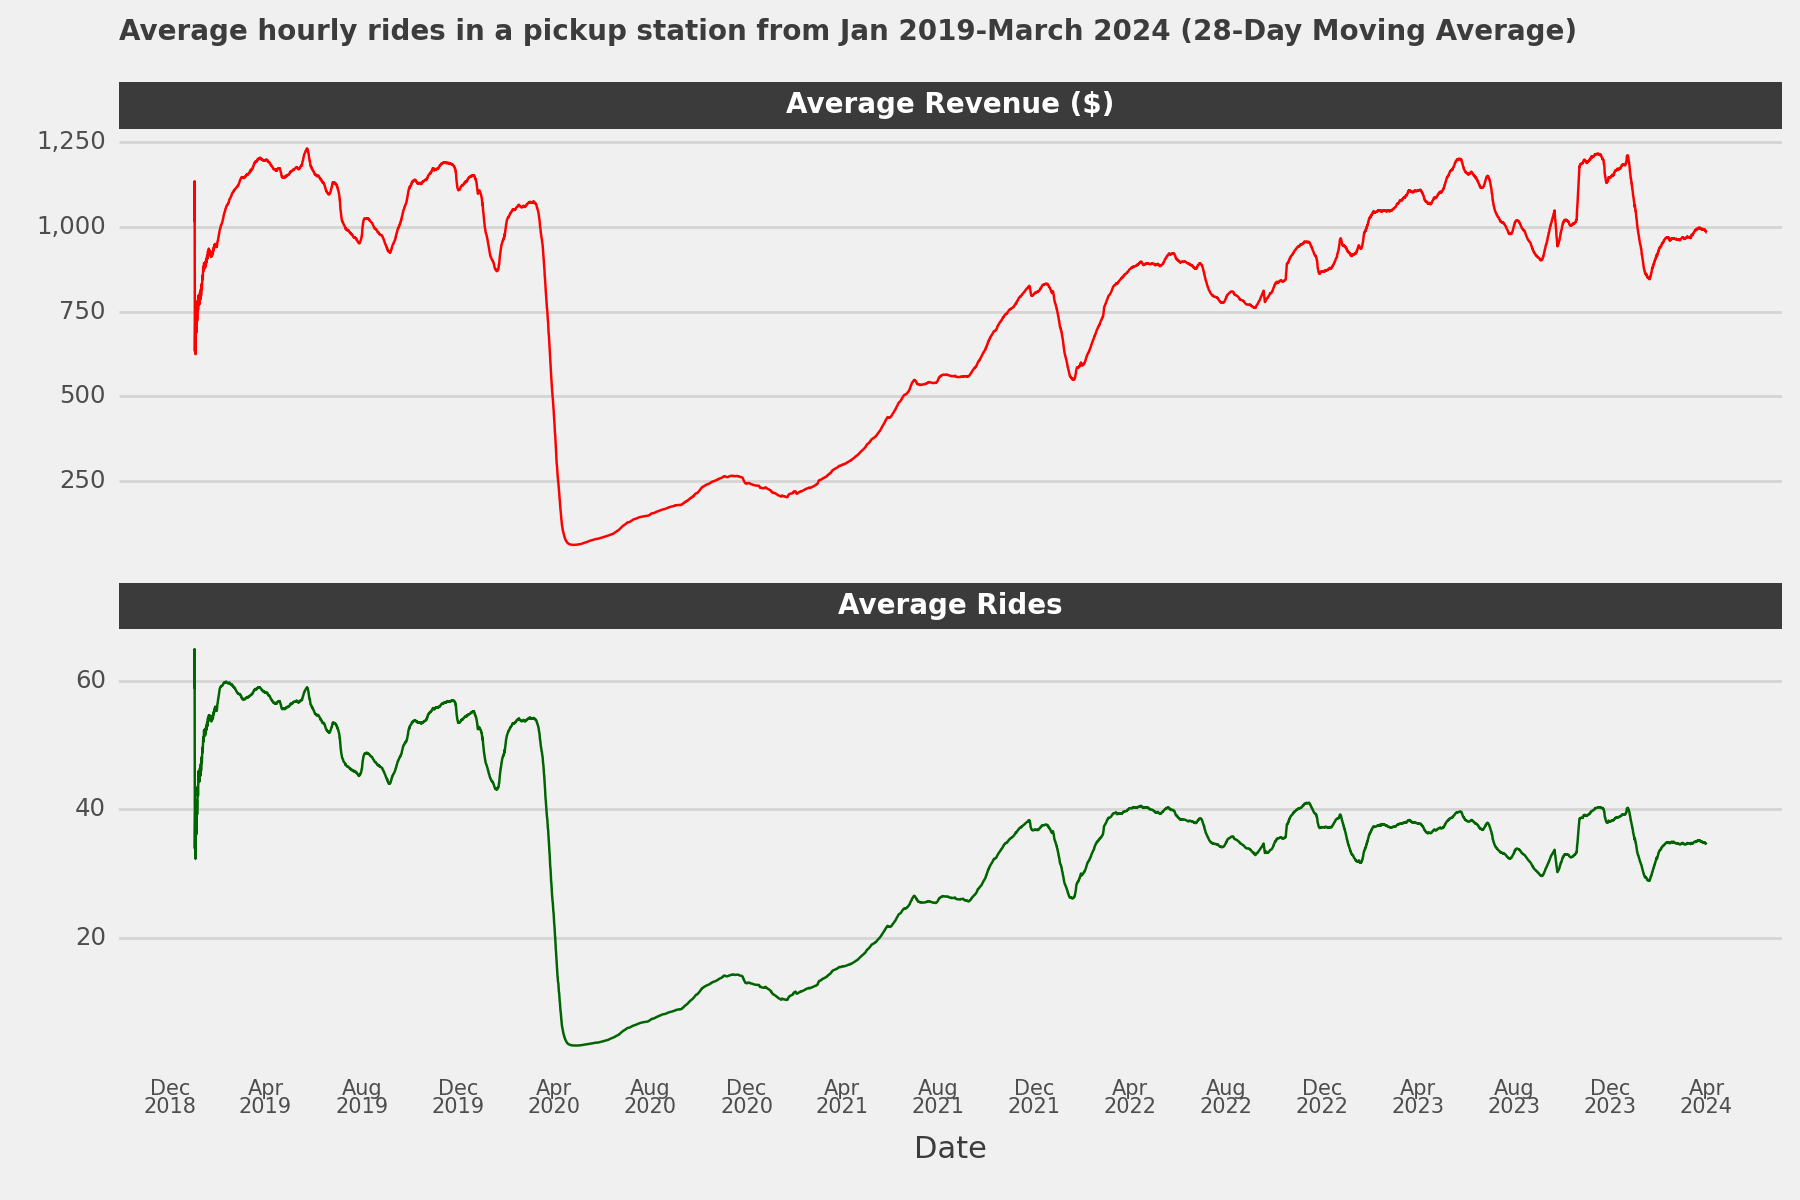

<Figure Size: (900 x 600)>

In [38]:
# average hourly revenue and rides in a pickup station (smoothened by a 28-D moving average)
df = (station_hourly_rides
      .set_index('ride_datetime')
      .rolling('28D').agg({'avg_rides': 'mean', 'avg_revenue':'mean'})
      .reset_index()
      .melt(id_vars='ride_datetime', var_name='name')
     )

# visualise
(
    pn.ggplot(df,
              mapping=pn.aes('ride_datetime', 'value', color='name')) +
    pn.geom_line() +
    pn.facet_wrap('~name', nrow=2, scales='free_y',
                 labeller=pn.labeller(
                     cols=lambda x: 'Average Revenue ($)' if x == 'avg_revenue' else 'Average Rides'
                 )) +
    pn.scale_x_date(date_labels='%b\n%Y', date_breaks='4 month') +
    pn.theme_538() +
    pn.theme(plot_title=pn.element_text(face='bold', size=10), 
             legend_position='none',
             strip_background=pn.element_rect(fill='k', alpha=0.5),
             strip_text=pn.element_text(color='white', size=10, face='bold'),
             axis_text_x=pn.element_text(size=7.5),
             panel_grid_major_x=pn.element_blank(),
             figure_size=(9,6)) +
    pn.labs(x='Date', y='') +
    pn.scale_y_continuous(labels=mfmt.comma_format()) +
    pn.scale_colour_manual(values=['red', 'darkgreen']) +
    pn.ggtitle('Average hourly rides in a pickup station from Jan 2019-March 2024 (28-Day Moving Average)') 
)

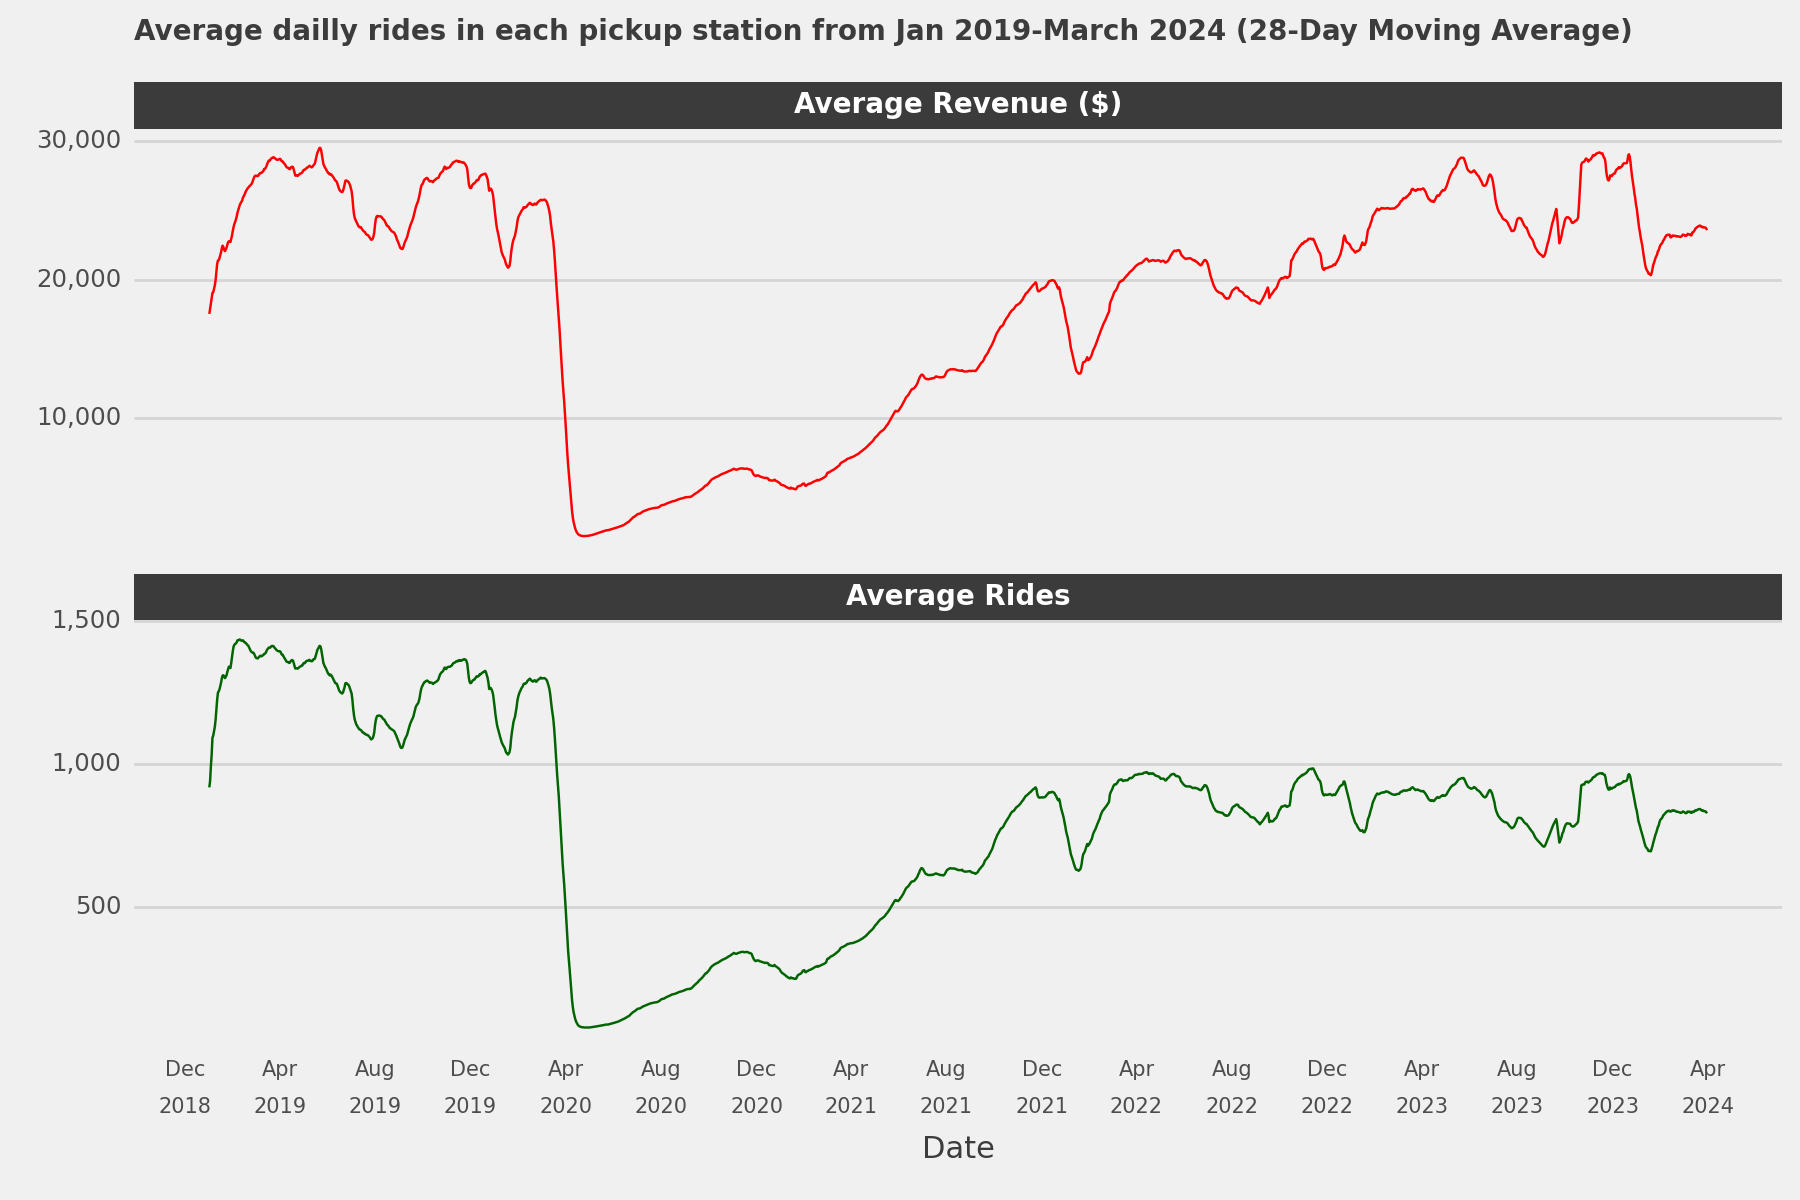

<Figure Size: (900 x 600)>

In [39]:
# average daily revenue and rides in a station (smoothened by a 28-D moving average)
df = (station_hourly_rides
      .set_index('ride_datetime')
      .resample('D').agg({'avg_rides': 'sum', 'avg_revenue':'sum'})
      .rolling('28D').agg({'avg_rides': 'mean', 'avg_revenue':'mean'})
      .reset_index()
      .melt(id_vars='ride_datetime', var_name='name')
     )

# visualise
(
    pn.ggplot(df,
              mapping=pn.aes('ride_datetime', 'value', color='name')) +
    pn.geom_line() +
    pn.facet_wrap('~name', nrow=2, scales='free_y',
                 labeller=pn.labeller(
                     cols=lambda x: 'Average Revenue ($)' if x == 'avg_revenue' else 'Average Rides'
                 )) +
    pn.scale_x_date(date_labels='%b\n\n%Y', date_breaks='4 month') +
    pn.theme_538() +
    pn.theme(plot_title=pn.element_text(face='bold', size=10), 
             legend_position='none',
             strip_background=pn.element_rect(fill='k', alpha=0.5),
             strip_text=pn.element_text(color='white', size=10, face='bold'),
             axis_text_x=pn.element_text(size=7.5),
             panel_grid_major_x=pn.element_blank(),
             figure_size=(9,6)) +
    pn.labs(x='Date', y='') +
    pn.scale_colour_manual(values=['red', 'darkgreen']) +
    pn.scale_y_continuous(labels=mfmt.comma_format()) +
    pn.ggtitle('Average dailly rides in each pickup station from Jan 2019-March 2024 (28-Day Moving Average)')
)

- Just like it is in the hourly and daily taxi demand city-wise, we see a similar trend in the average taxi demands in a pickup station as well as in the total revenue generated.
- Since the COVID-19 event, the average taxi demanded per hour in a pickup station in New York ranges between 30 and 45 while the average demanded per day ranges from 600 and 1000 (slightly above 750 taxis on average)

#### Hourly demand

In [40]:
hourly_demand_station = pd.read_sql_query(
    """
    SELECT CAST(strftime('%H', ride_datetime) AS INT) AS hour,
           AVG(hourly_rides) as avg_hourly_rides,
           AVG(revenue) as avg_hourly_revenue
    FROM pickup_trips
    GROUP BY hour;
    """, conn)

In [41]:
hourly_demand_city = pd.read_sql_query(
    f"""
    WITH city_total_rides AS ({city_hourly_rides_query})
    SELECT hour,
           AVG(total_rides) as avg_hourly_rides,
           AVG(total_revenue) as avg_hourly_revenue
    FROM city_total_rides  
    GROUP BY hour;
    """, conn)

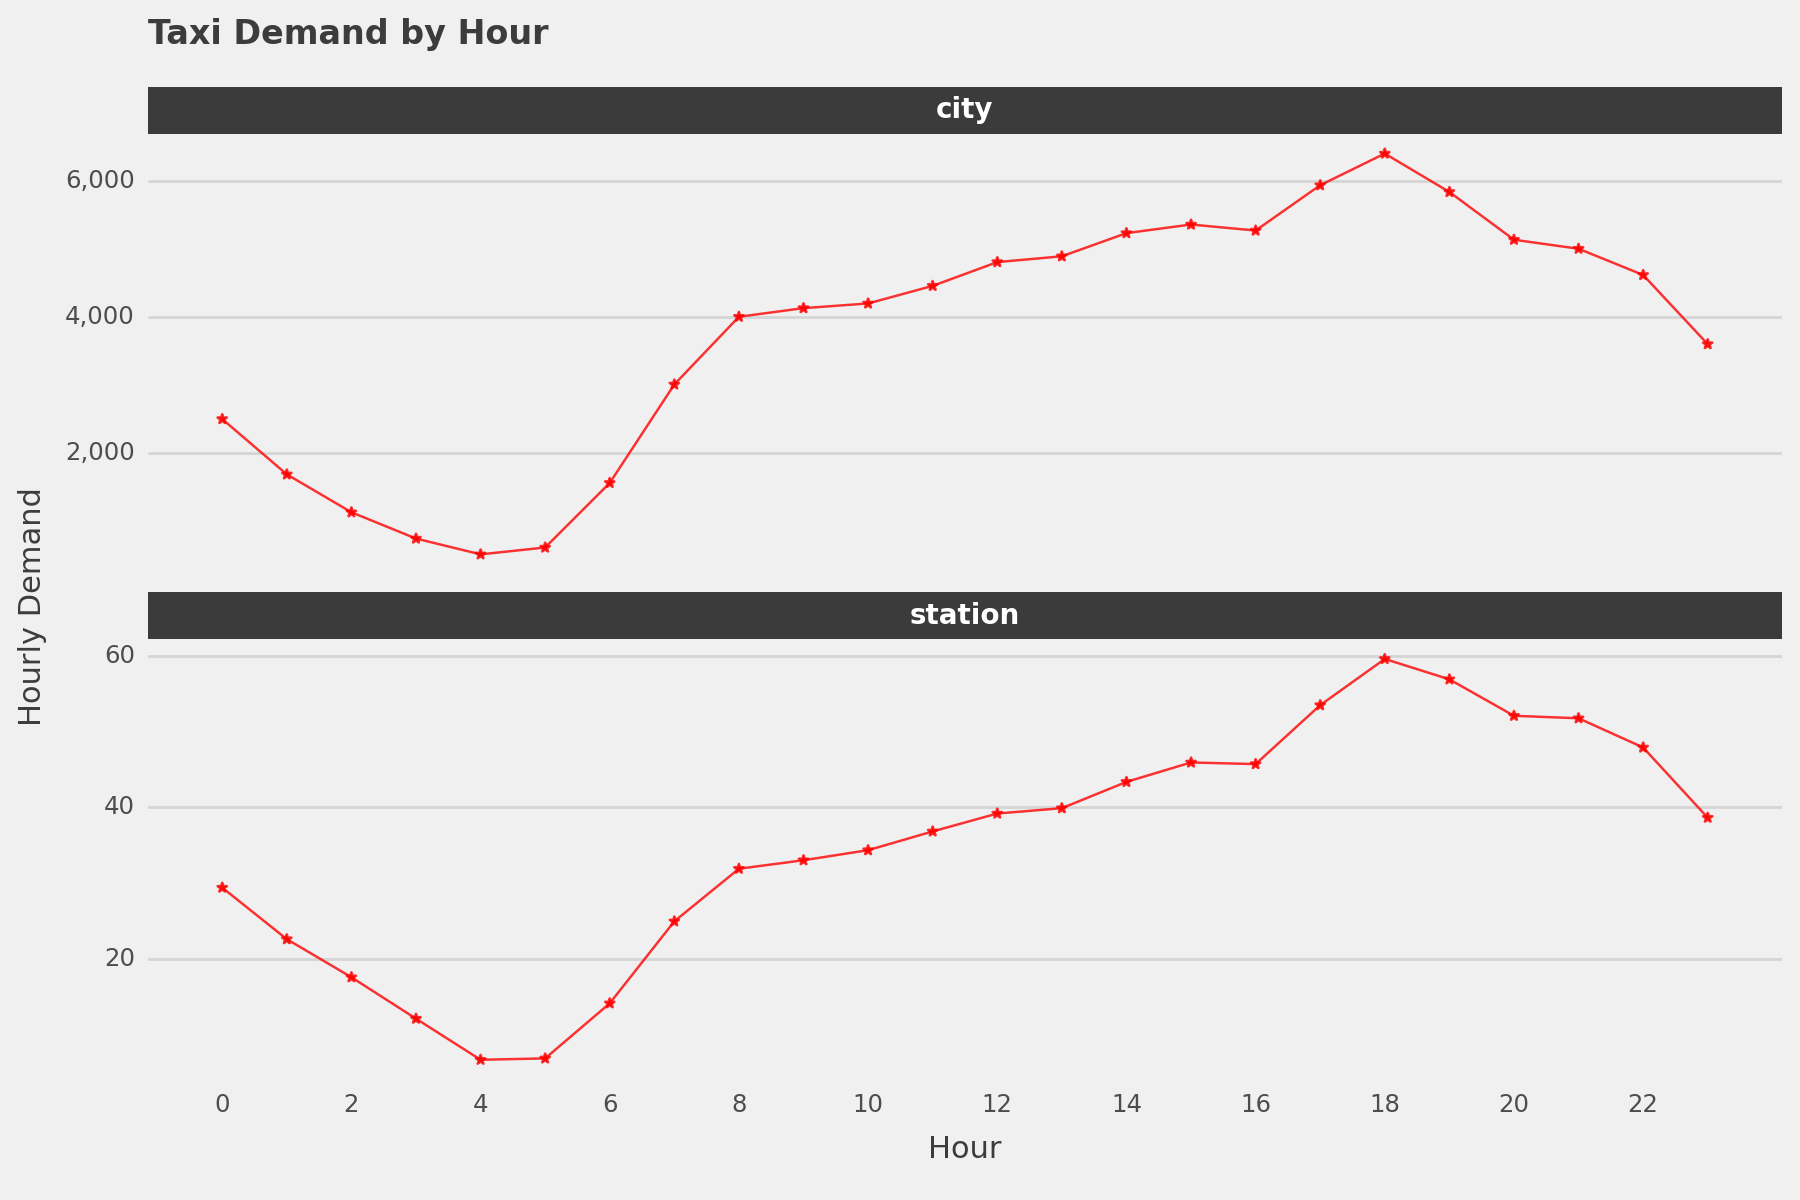

<Figure Size: (900 x 600)>

In [42]:
(
    pn.ggplot(
        pd.concat([hourly_demand_city.assign(type='city'), 
                   hourly_demand_station.assign(type='station')]), 
        mapping=pn.aes(x='hour', y='avg_hourly_rides')) +
    pn.geom_line(color='red', alpha=0.8) +
    pn.geom_point(color='red', shape='*', alpha=0.8) +
    pn.facet_wrap('~type', scales='free_y', nrow=2) +
    pn.theme_538() +
    pn.theme(figure_size=(9,6),
             strip_background=pn.element_rect(fill='k', alpha=0.5),
             strip_text=pn.element_text(color='white', size=10, face='bold'),
             panel_grid_major_x = pn.element_blank(),
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.scale_x_continuous(breaks=range(0,24,2)) +
    pn.scale_y_continuous(labels=mfmt.comma_format()) +
    pn.labs(x='Hour', y='Hourly Demand') +
    pn.ggtitle(title='Taxi Demand by Hour')
)

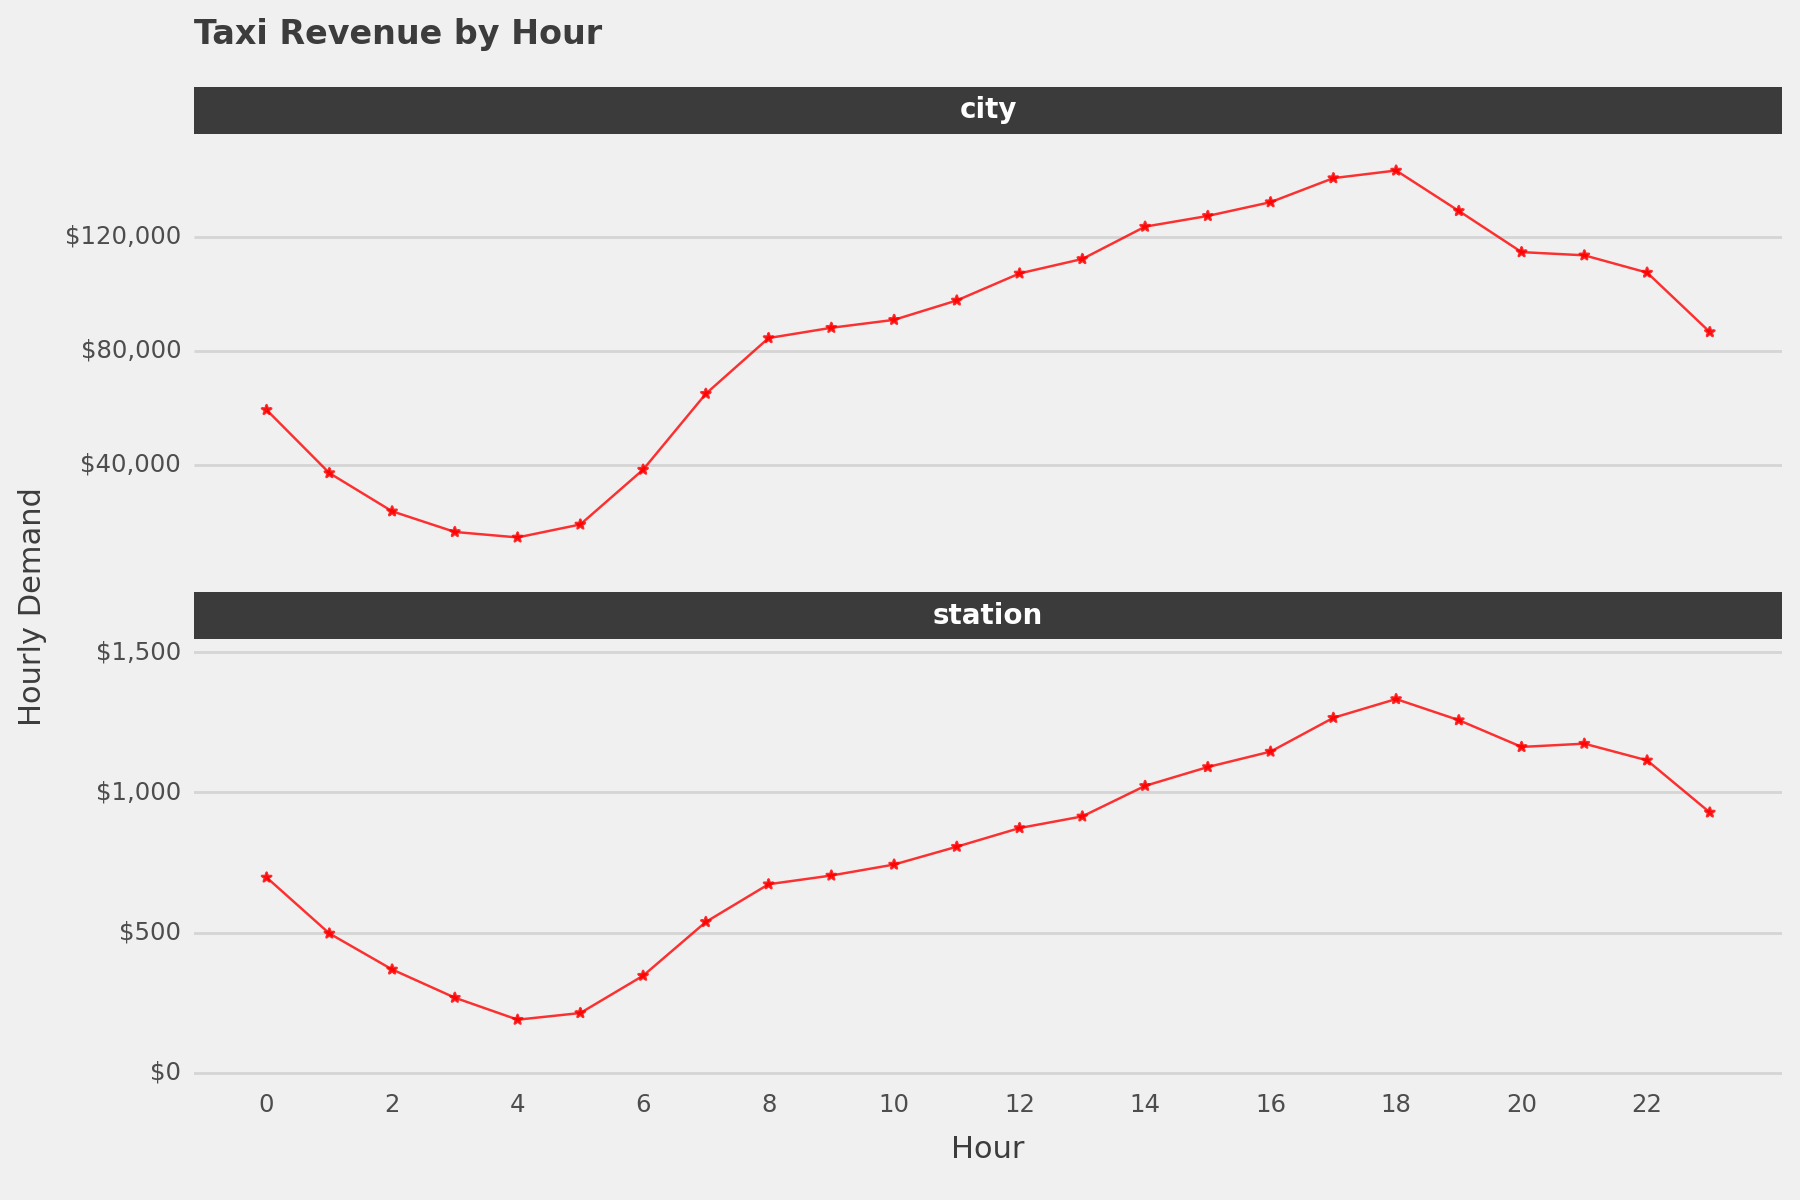

<Figure Size: (900 x 600)>

In [43]:
(
    pn.ggplot(
        pd.concat([hourly_demand_city.assign(type='city'), 
                   hourly_demand_station.assign(type='station')]), 
        mapping=pn.aes(x='hour', y='avg_hourly_revenue')) +
    pn.geom_line(color='red', alpha=0.8) +
    pn.geom_point(color='red', shape='*',alpha=0.8) +
    pn.facet_wrap('~type', scales='free_y', nrow=2) +
    pn.theme_538() +
    pn.theme(figure_size=(9,6),
             panel_grid_major_x = pn.element_blank(),
             strip_background=pn.element_rect(fill='k', alpha=0.5),
             strip_text=pn.element_text(color='white', size=10, face='bold'),
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.scale_x_continuous(breaks=range(0,24,2)) +
    pn.scale_y_continuous(labels=mfmt.dollar_format(digits=0, big_mark=','), expand=(.1,100)) +
    pn.labs(x='Hour', y='Hourly Demand') +
    pn.ggtitle(title='Taxi Revenue by Hour')
)

- The demand for yellow taxis depends on the time of day.
- From the figure above, the demand for taxis begins to increase rapidly from 5am in the morning till 8am. From 8am, the demand increases slowly until 4pm, peaks at 6pm and begins to decrease from 6pm till 5am.
- The high demand between 6-8am and 4-6pm could possibly be linked to rush hour when commuters are rushing to be in the office early or to get home after the close of work, respectively.
- The revenue generated also depends on the demand of taxis at that hour

#### Daily Demand (Day of the week)

In [44]:
dow_demand_station = pd.read_sql_query(
    """
    SELECT CASE strftime('%w', ride_datetime)
               WHEN '0' THEN 'Sunday'
               WHEN '1' THEN 'Monday'
               WHEN '2' THEN 'Tuesday'
               WHEN '3' THEN 'Wednesday'
               WHEN '4' THEN 'Thursday'
               WHEN '5' THEN 'Friday'
               WHEN '6' THEN 'Saturday'
            END AS day_of_week,
               strftime('%w', ride_datetime) AS weekday,
               AVG(hourly_rides) as avg_rides,
               AVG(revenue) as avg_revenue
    FROM pickup_trips
    GROUP BY weekday;
    """, conn)

# rename
dow_demand_station = dow_demand_station.assign(type='station').rename(
    {'avg_rides':'rides', 'avg_revenue':'revenue'}, axis=1
    )

In [45]:
# create map for day of week
dow_map = {i:j for i,j in zip(dow_demand_station.day_of_week, dow_demand_station.weekday)}

In [46]:
dow_demand_city = (
    city_hourly_rides
    .assign(day_of_week=city_hourly_rides.ride_datetime.dt.day_name())
    .groupby(['day_of_week']).agg({'total_rides' : 'mean', 'total_revenue': 'mean'})
    .reset_index()
)

dow_demand_city = (
    dow_demand_city
    .assign(weekday=dow_demand_city.day_of_week.map(dow_map), 
            type='city')
    .rename({'total_rides':'rides', 'total_revenue':'revenue'}, axis=1)
    )

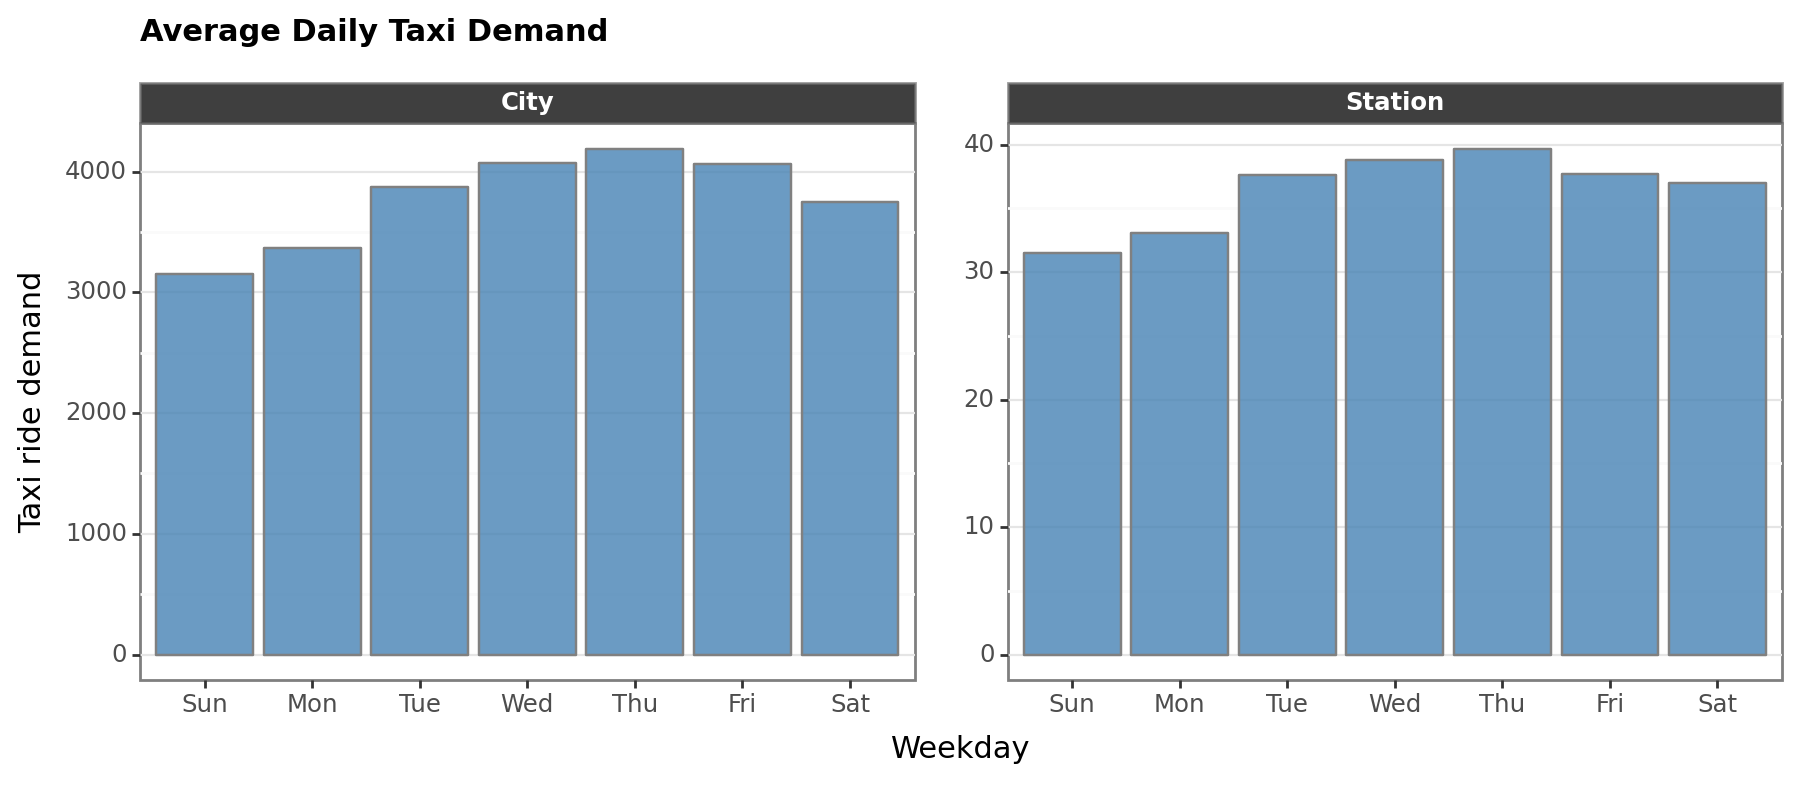

<Figure Size: (900 x 400)>

In [47]:
(
    pn.ggplot(pd.concat([dow_demand_station, dow_demand_city]),
             mapping=pn.aes(x='factor(weekday)', y='rides')) +
    pn.geom_col(fill='steelblue', alpha=0.8, color='gray') +
    pn.facet_wrap('~type', scales='free_y', labeller=pn.as_labeller(lambda x:x.title())) +
    pn.theme_bw() +
    pn.theme(figure_size=(9,4.5),
             panel_grid_major_x=pn.element_blank(),
             strip_background=pn.element_rect(fill='k', alpha=0.5),
             strip_text=pn.element_text(color='white', weight='bold'),
            plot_title=pn.element_text(face='bold', size=11)) +
    pn.labs(title='Average Daily Taxi Demand', x='Weekday', y='Taxi ride demand') +
    pn.scale_x_discrete(labels=list(map(lambda x: x[:3], dow_map.keys())))
)

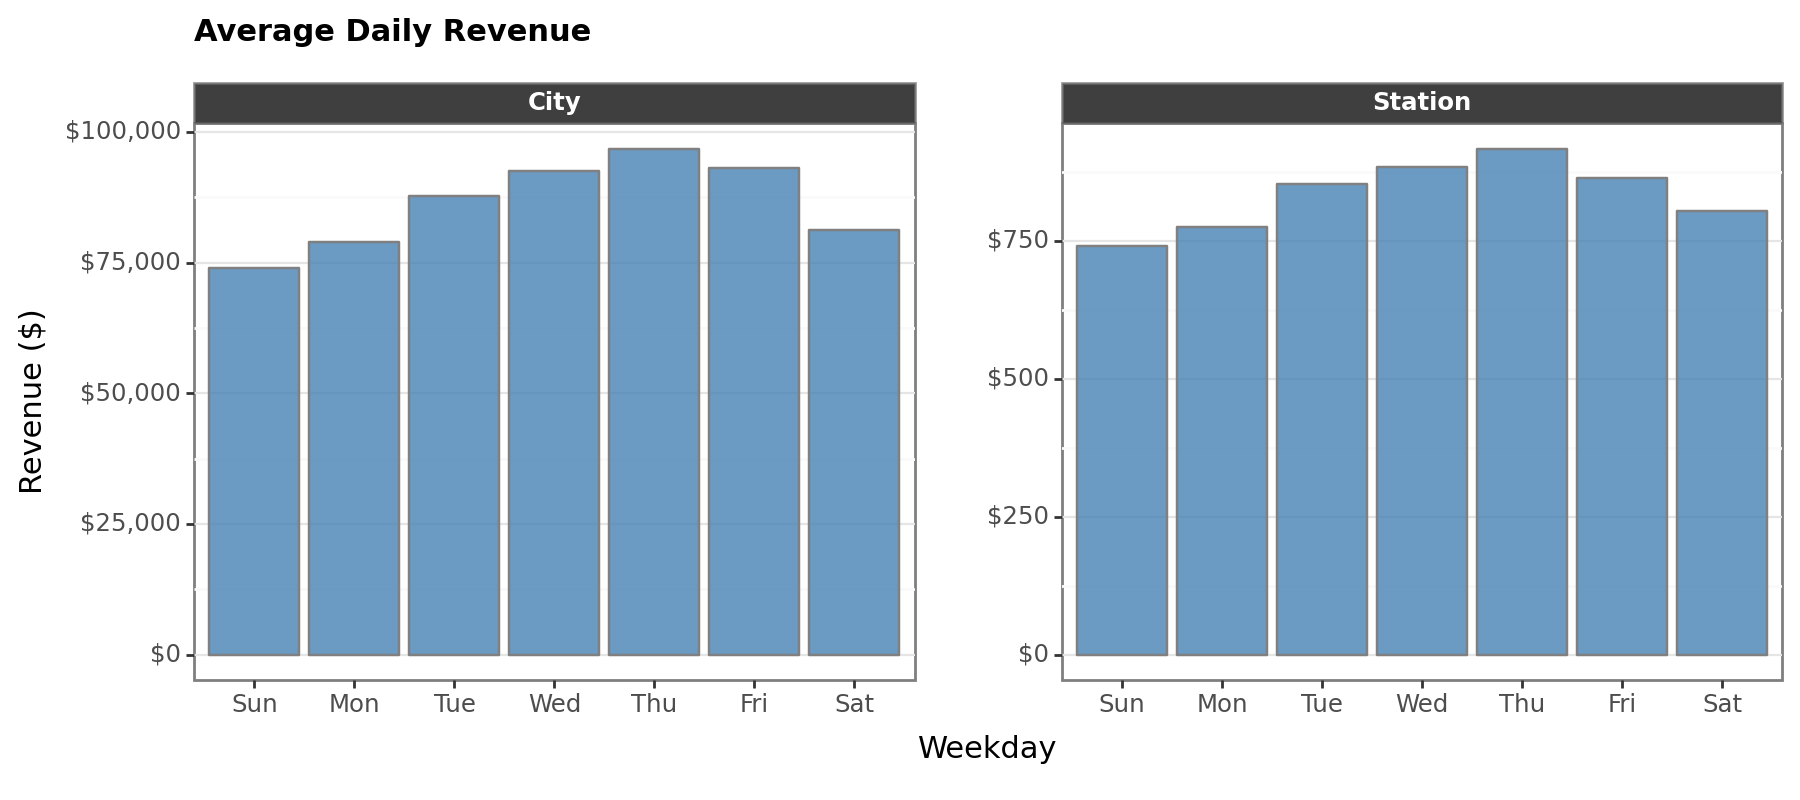

<Figure Size: (900 x 400)>

In [48]:
(
    pn.ggplot(pd.concat([dow_demand_station, dow_demand_city]),
             mapping=pn.aes(x='factor(weekday)', y='revenue')) +
    pn.geom_col(fill='steelblue', alpha=0.8, color='gray') +
    pn.facet_wrap('~type', scales='free_y', labeller=pn.as_labeller(lambda x:x.title())) +
    pn.theme_bw() +
    pn.theme(figure_size=(9,4.5),
             strip_background=pn.element_rect(fill='k', alpha=0.5),
             strip_text=pn.element_text(color='white', weight='bold'),
             panel_grid_major_x=pn.element_blank(),
            plot_title=pn.element_text(face='bold', size=11)) +
    pn.labs(title='Average Daily Revenue', x='Weekday', y='Revenue ($)') +
    pn.scale_x_discrete(labels=list(map(lambda x: x[:3], dow_map.keys()))) +
    pn.scale_y_continuous(labels=mfmt.dollar_format(digits=0, big_mark=','))
)

- There's no impact of day of week on taxi demand. Demand for yellow taxis is relatively the same across day of the week including on weekends and weekdays.
- The number of rides in a day of the week determines the revenue that's generated.
- The number of rides increases from the beginning of the week (Sunday), peaks on thursday before declining slightly toward the weekend.

#### Monthly Demand

In [49]:
month_demand_station = pd.read_sql_query(
    """
    SELECT CAST(strftime('%m', ride_datetime) as INT) month,
           AVG(hourly_rides) as avg_rides,
           AVG(revenue) as avg_revenue
    FROM pickup_trips
    GROUP BY month;
    """, conn)

month_demand_city = pd.read_sql_query(
    f"""
    WITH city_hourly_rides AS ({city_hourly_rides_query})

    SELECT CAST(strftime('%m', ride_datetime) as INT) month,
           AVG(total_rides) as avg_rides,
           AVG(total_revenue) as avg_revenue
    FROM city_hourly_rides
    GROUP BY month;
    """, conn)

In [50]:
def season(x):
    seasons = {
        'Winter': (12, 1, 2),
        'Spring': (3, 4, 5),
        'Summer': (6, 7, 8),
        'Fall': (9, 10, 11)
    }
    for season, months in seasons.items(): 
        if x in months: 
            return season 
    return 'invalid'

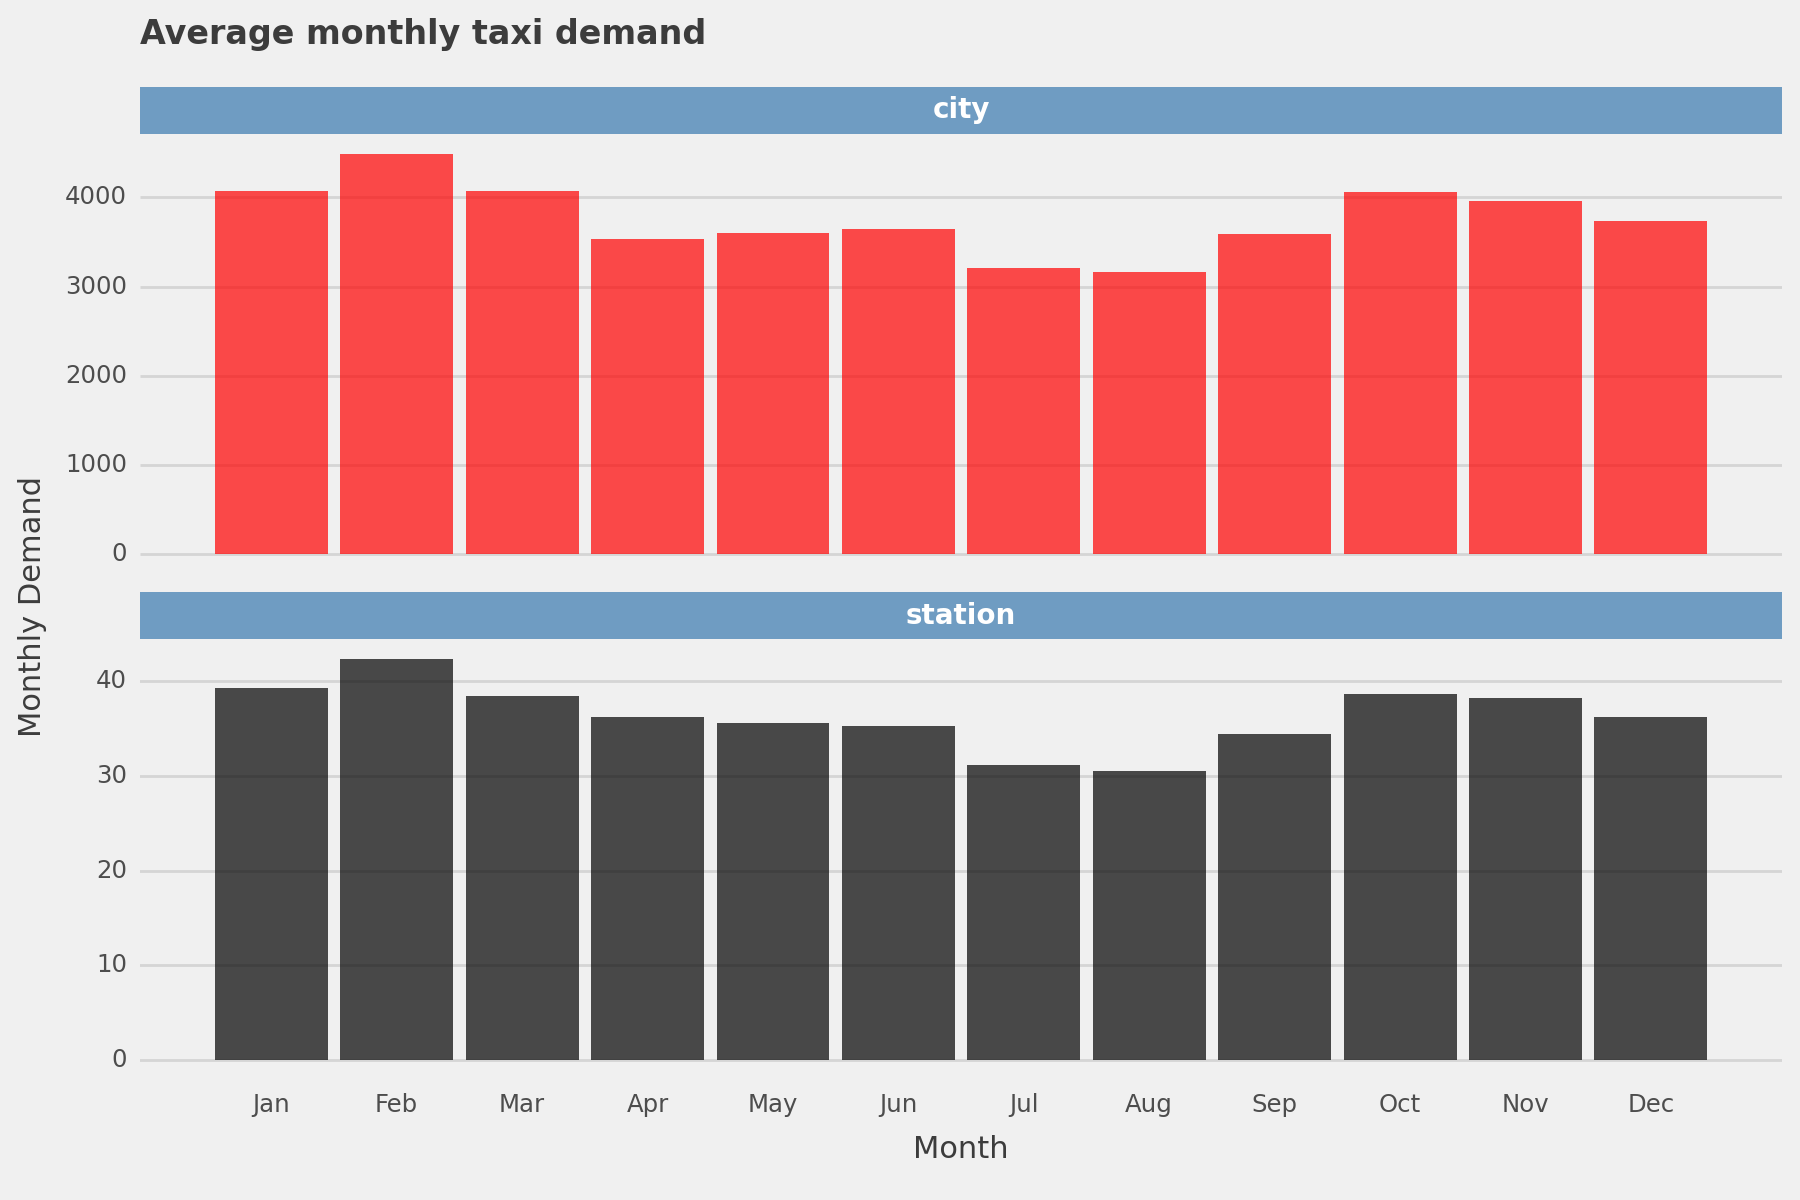

<Figure Size: (900 x 600)>

In [51]:
(
    pn.ggplot(
        pd.concat([
            month_demand_city.assign(type='city'),
            month_demand_station.assign(type='station')
        ]), 
        mapping=pn.aes(x='month', y='avg_rides', fill='type')) +
    pn.geom_col(alpha=0.7) +
    pn.facet_wrap('~type', scales='free_y', nrow=2) +
    pn.theme_538() +
    pn.theme(figure_size=(9,6),
             legend_position='none',
             panel_grid_major_x = pn.element_blank(),
             strip_background=pn.element_rect(fill='steelblue', alpha=0.5),
             strip_text=pn.element_text(color='white', size=10, face='bold'),
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.scale_x_continuous(breaks=range(1,13,1), 
                          labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                  'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']) +
    pn.labs(x='Month', y='Monthly Demand') +
    pn.scale_fill_manual(values=['red', 'black']) +
    pn.ggtitle(title='Average monthly taxi demand')
)

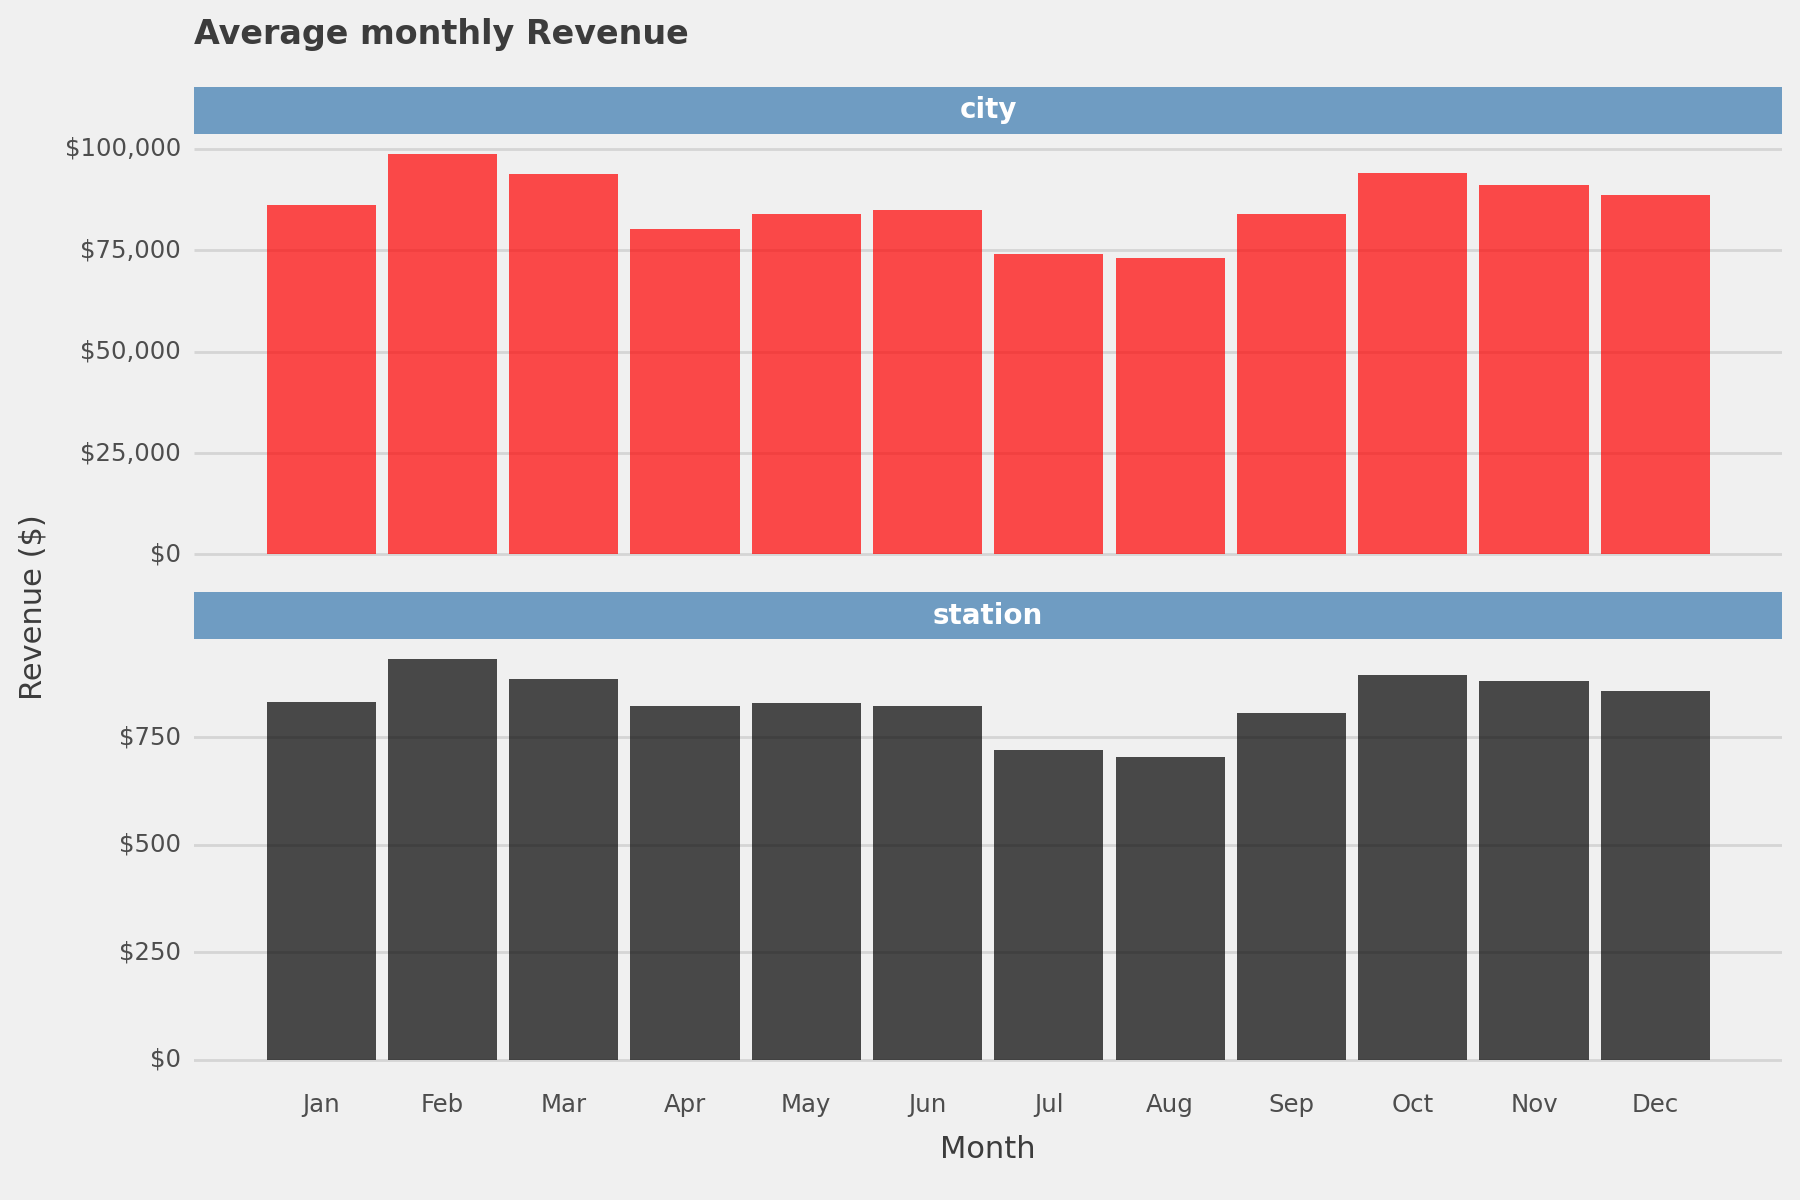

<Figure Size: (900 x 600)>

In [52]:
(
    pn.ggplot(
        pd.concat([
            month_demand_city.assign(type='city'),
            month_demand_station.assign(type='station')
        ]), 
        mapping=pn.aes(x='month', y='avg_revenue', fill='type')) +
    pn.geom_col(alpha=0.7) +
    pn.facet_wrap('~type', scales='free_y', nrow=2) +
    pn.theme_538() +
    pn.theme(figure_size=(9,6),
             legend_position='none',
             panel_grid_major_x = pn.element_blank(),
             strip_background=pn.element_rect(fill='steelblue', alpha=0.5),
             strip_text=pn.element_text(color='white', size=10, face='bold'),
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.scale_x_continuous(breaks=range(1,13,1), 
                          labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 
                                  'Jul', 'Aug','Sep', 'Oct', 'Nov', 'Dec']) +
    pn.labs(x='Month', y='Revenue ($)') +
    pn.scale_fill_manual(values=['red', 'black']) +
    pn.scale_y_continuous(labels=mfmt.custom_format('${:,.0f}')) + 
    pn.ggtitle(title='Average monthly Revenue')
)

- From above, we see that the demand of yellow taxis depends on the month of the year.
- Taxi demand increases in the first two months of the year, declines till the summer periods (which is related to time of the year when workers are on vacation and students are on holidays. Probably, residents hauling taxis would be residents who do not have work vacations), increase again after the summer holidays (Jun-Aug), peaks a second time in Oct before declining at the end of the year.

Now, we will further drill down to determine how the hourly rides in all stations vary per year (between 2019 till present) on average. Also, how this varies in each month per year.

__Average Hourly rides and revenue per year__

In [53]:
print(city_hourly_rides_query)


                            SELECT ride_datetime, 
                                   CAST(strftime('%H', ride_datetime) as INT) AS hour,
                                   SUM(hourly_rides) AS total_rides,
                                   SUM(revenue) as total_revenue
                            FROM pickup_trips
                            GROUP BY ride_datetime
                            


In [54]:
yearly_hourly_city = pd.read_sql_query(
    f"""
        WITH city_hour_rides AS ({city_hourly_rides_query})
        
        SELECT hour, strftime('%Y', ride_datetime) AS year,
               AVG(total_rides) AS avg_rides,
               AVG(total_revenue) AS avg_revenue
        FROM city_hour_rides
        GROUP BY hour, year
""", con=conn)

In [55]:
yearly_hourly_station = pd.read_sql_query(
    f"""
        SELECT CAST(strftime('%H', ride_datetime) AS INT) AS hour, 
               strftime('%Y', ride_datetime) AS year,
               AVG(hourly_rides) AS avg_rides,
               AVG(revenue) AS avg_revenue
        FROM pickup_trips
        GROUP BY hour, year
    """, con=conn)

In [56]:
df = pd.concat(
    [
        yearly_hourly_city.assign(type='city'), 
        yearly_hourly_station.assign(type='station')
    ]
)

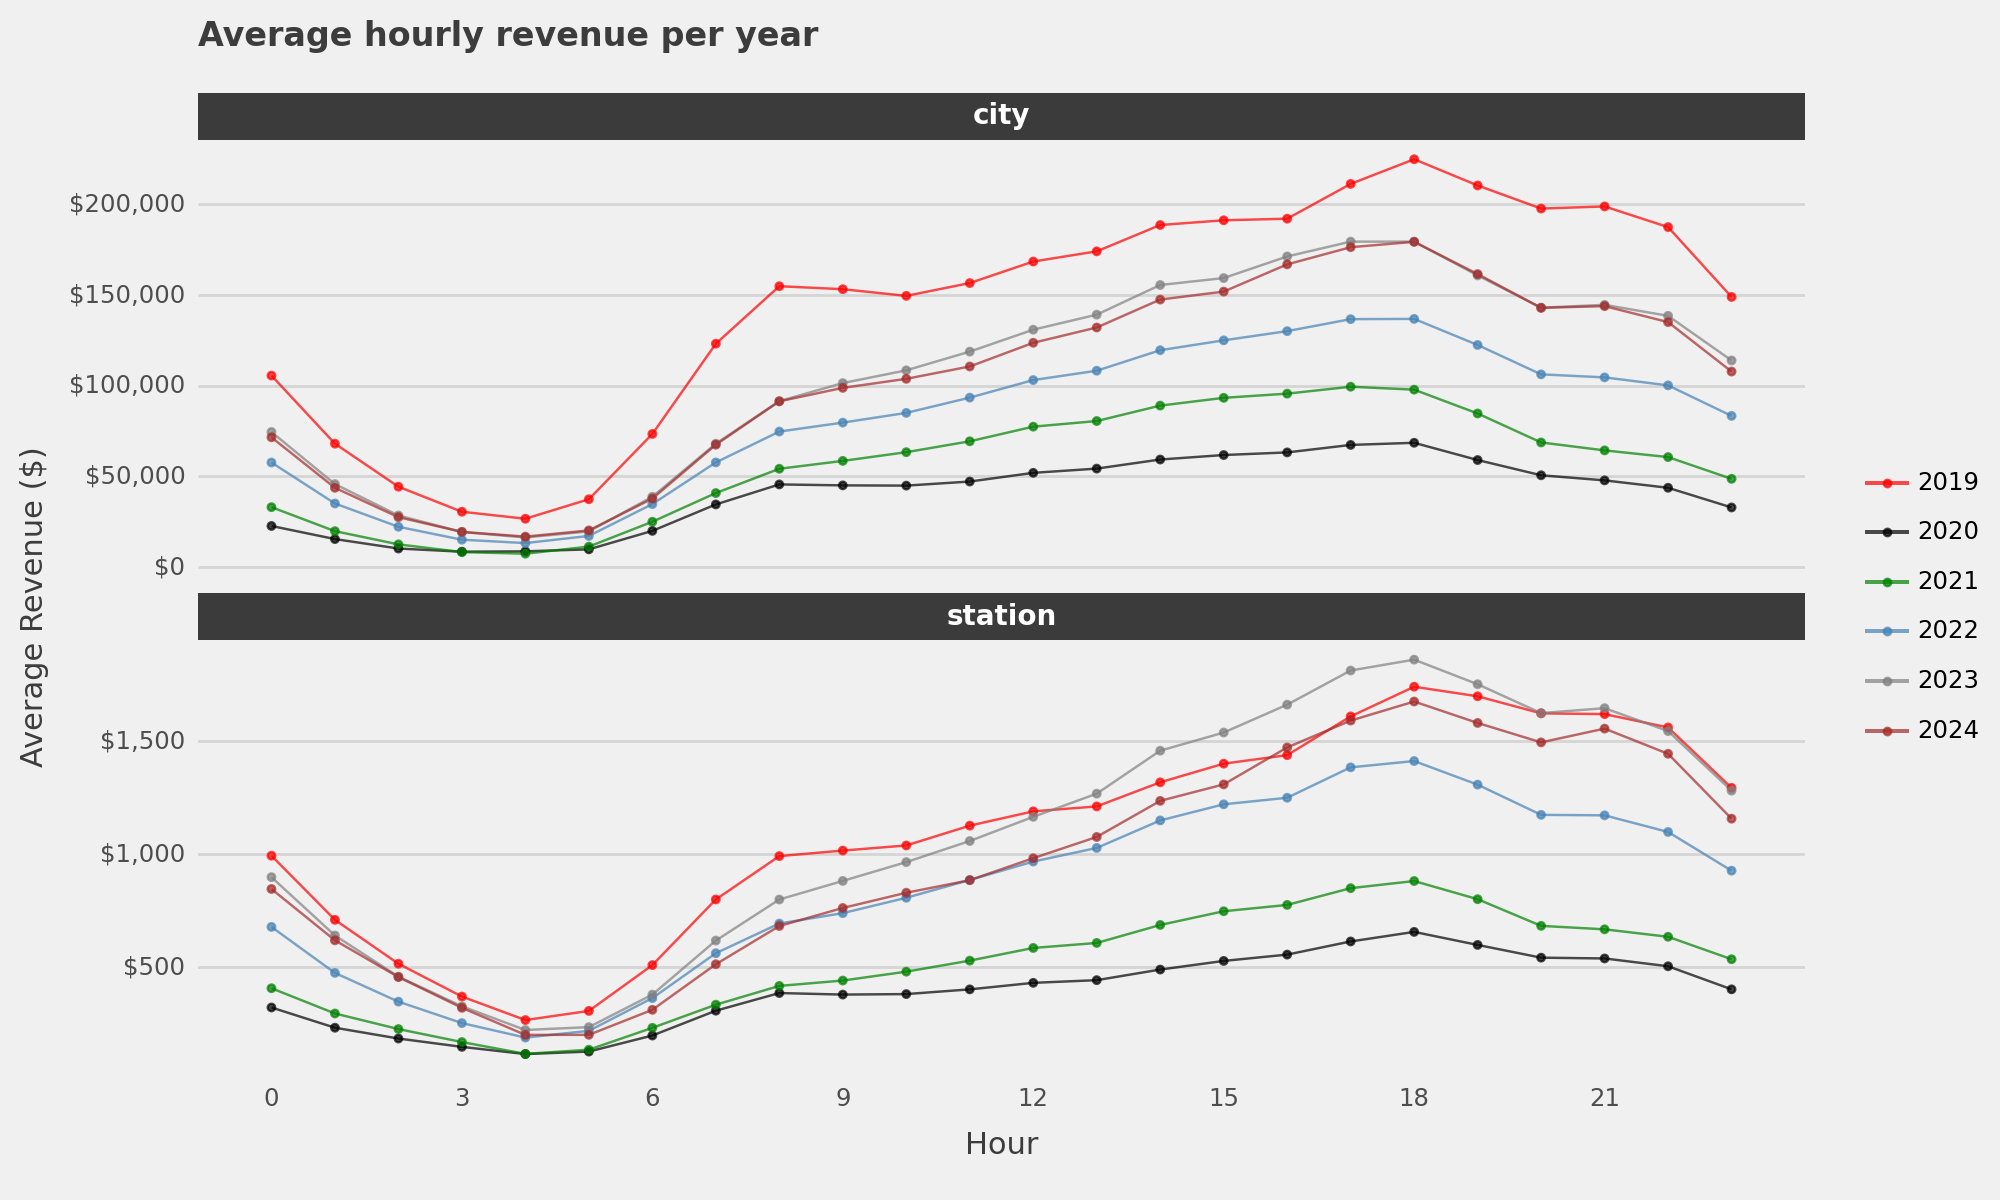

<Figure Size: (1000 x 600)>

In [57]:
(
    pn.ggplot(data=df, 
              mapping=pn.aes(x='hour', y='avg_revenue', colour='factor(year)')) +
    pn.geom_line(alpha=0.7) +
    pn.geom_point(shape='o', size=1, alpha=0.7) +
    pn.facet_wrap('~type', scales='free_y', nrow=2) +
    pn.theme_538() +
    pn.theme(figure_size=(10,6),
             legend_direction='vertical',
             legend_key = pn.element_blank(),
             legend_position='right',
             legend_title = pn.element_blank(),
             panel_grid_major_x=pn.element_blank(),
             strip_background=pn.element_rect(fill='k', alpha=0.5),
             strip_text=pn.element_text(color='white', size=10, face='bold'),
             plot_title=pn.element_text(weight='bold', size=12)) +
    pn.labs(x='Hour', y='Average Revenue ($)', colour='Year') +
    pn.scale_x_continuous(breaks=range(0,24,3)) +
    pn.scale_y_continuous(labels=mfmt.custom_format(fmt='${:,.0f}')) + 
    pn.scale_color_manual(values=['red', 'black', 'green', 'steelblue', 'gray', 'brown']) +
    # pn.guides(color=pn.guide_legend(nrow=1)) +
    pn.ggtitle(title='Average hourly revenue per year')
)

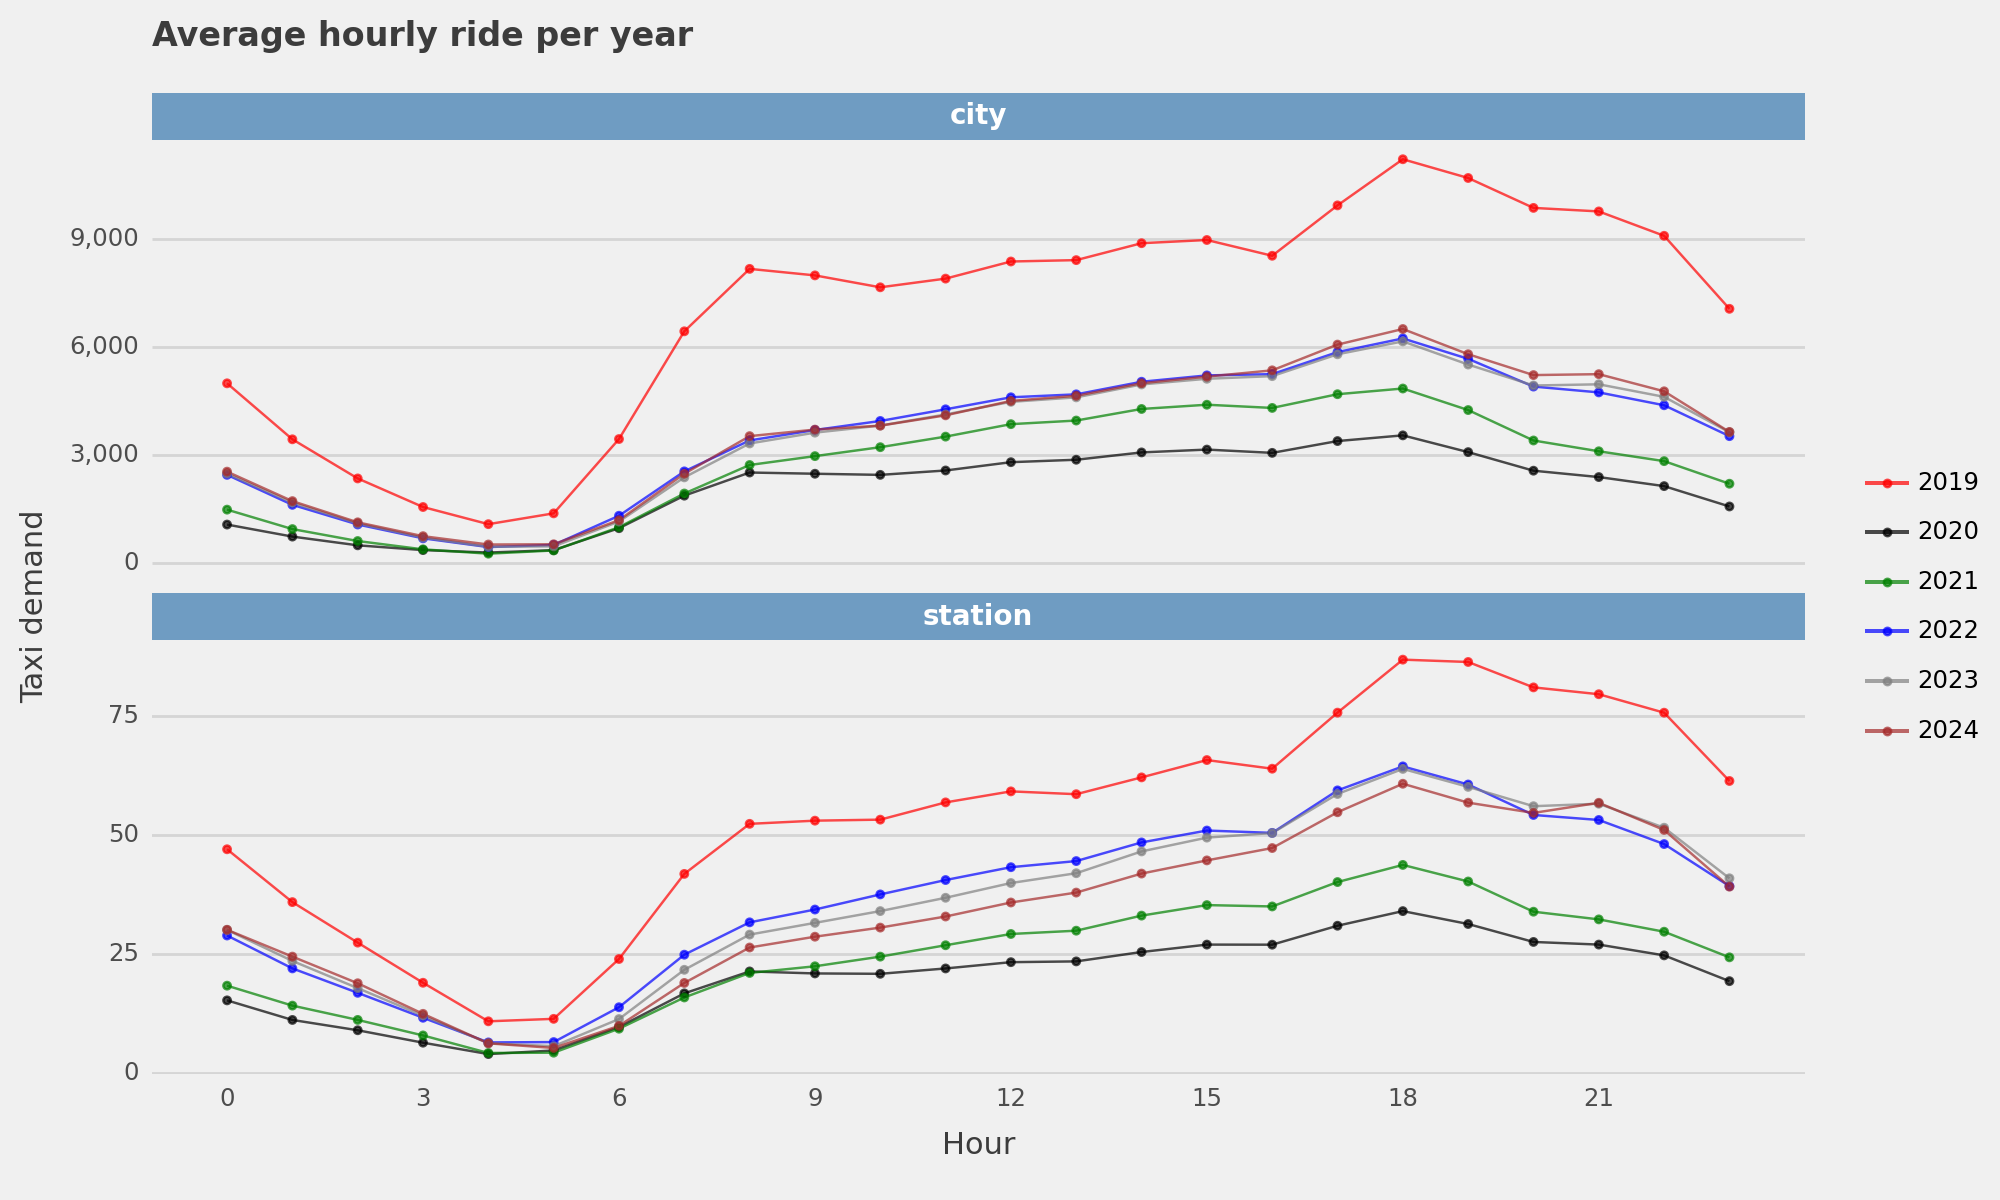

<Figure Size: (1000 x 600)>

In [58]:
(
    pn.ggplot(data=df, 
              mapping=pn.aes(x='hour', y='avg_rides', colour='factor(year)')) +
    pn.geom_line(alpha=0.7) +
    pn.geom_point(shape='o', size=1, alpha=0.7) +
    pn.facet_wrap('~type', scales='free_y', nrow=2) +
    pn.theme_538() +
    pn.theme(figure_size=(10,6),
             legend_direction='vertical',
             legend_key = pn.element_blank(),
             legend_position='right',
             legend_title = pn.element_blank(),
             panel_grid_major_x=pn.element_blank(),
             strip_background=pn.element_rect(fill='steelblue', alpha=0.5),
             strip_text=pn.element_text(color='white', size=10, face='bold'),
             plot_title=pn.element_text(weight='bold', size=12)) +
    pn.labs(x='Hour', y='Taxi demand', colour='Year') +
    pn.scale_x_continuous(breaks=range(0,24,3)) +
    pn.scale_y_continuous(labels=mfmt.custom_format(fmt='{:,.0f}')) + 
    pn.scale_color_manual(values=['red', 'black', 'green', 'blue', 'gray', 'brown']) +
    # pn.guides(color=pn.guide_legend(nrow=1)) + 
    pn.ggtitle(title='Average hourly ride per year')
)

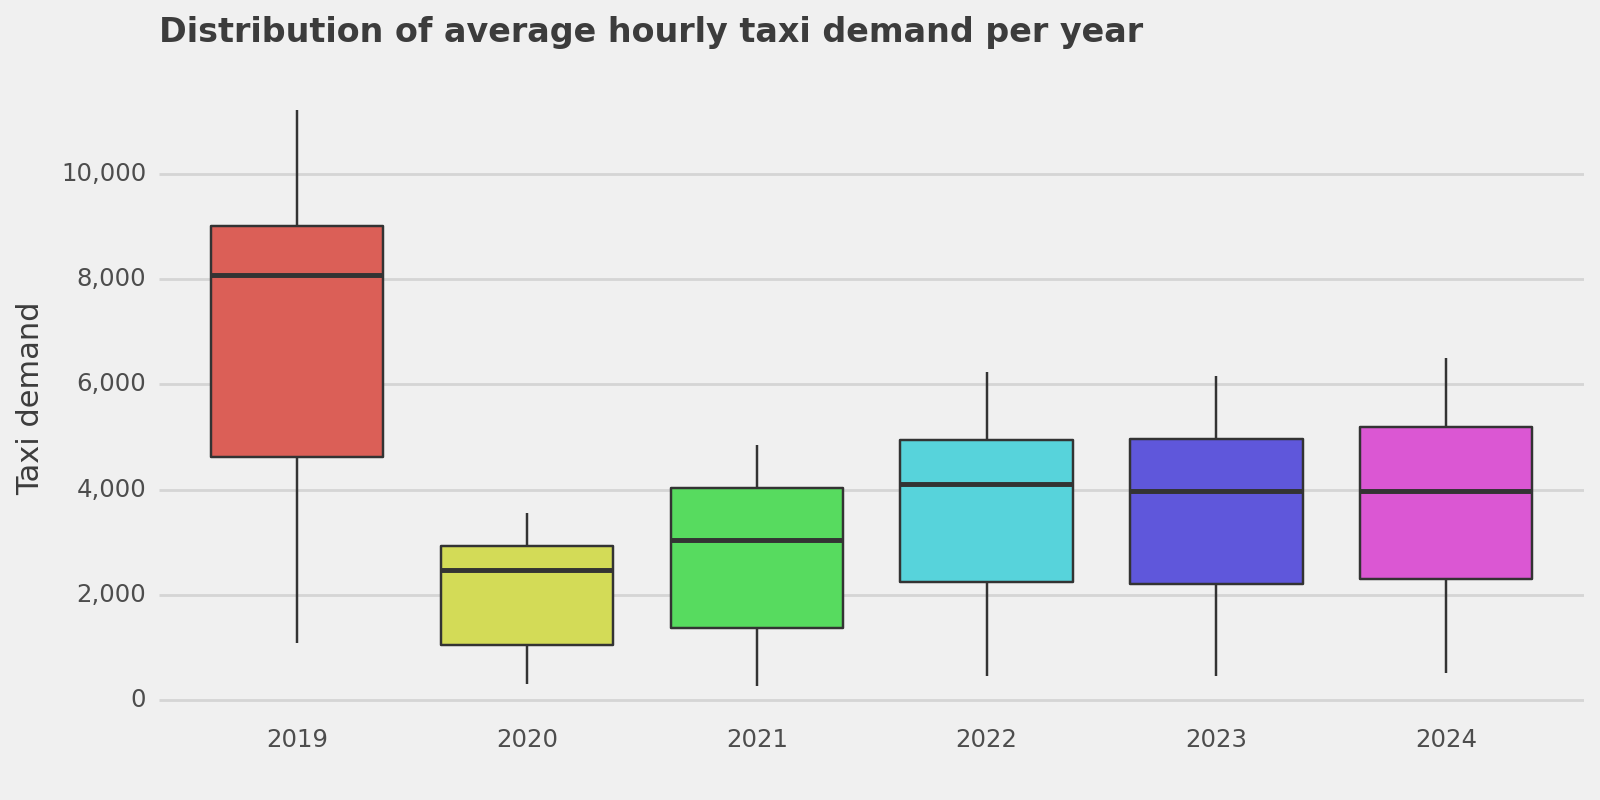

<Figure Size: (800 x 400)>

In [59]:
(
    pn.ggplot(data=yearly_hourly_city, 
              mapping=pn.aes(x='year', y='avg_rides', fill='factor(year)')) +
    pn.geom_boxplot() +
    pn.theme_538() +
    pn.theme(figure_size=(8,4),
             legend_position='none',
             panel_grid_major_x=pn.element_blank(),
             plot_title=pn.element_text(weight='bold', size=12),
             legend_title=pn.element_text(weight='bold'),
             legend_key= pn.element_rect(fill=None, linetype='none')) +
    pn.labs(x='', y='Taxi demand', colour='Year') +
    pn.scale_y_continuous(breaks=range(0,14000,2000), 
                          labels=mfmt.custom_format(fmt='{:,.0f}')) + 
    pn.ggtitle(title='Distribution of average hourly taxi demand per year')
)

### C. Holiday events, seasonal and weekend/weekday impact on demand and revenue

In the last section, we looked at how temporal variations such as hour, day of the week, month, and year affect yellow taxi rides. In this section, we will look at the impact of seasons, holiday events and weekends on taxi demand.

#### Seasonal impact

We've seen that taxi ride demand depends on the season of the year. Here, we want to see how this varies by season and how it impacts yellow taxi demand.

In [60]:
# average seasonal hourly rides in a station
seasonal_rides = (
    station_hourly_rides
    .assign(season=station_hourly_rides.ride_datetime.dt.month.apply(season),
            month=station_hourly_rides.ride_datetime.dt.month,
            year=station_hourly_rides.ride_datetime.dt.year
            )
    )

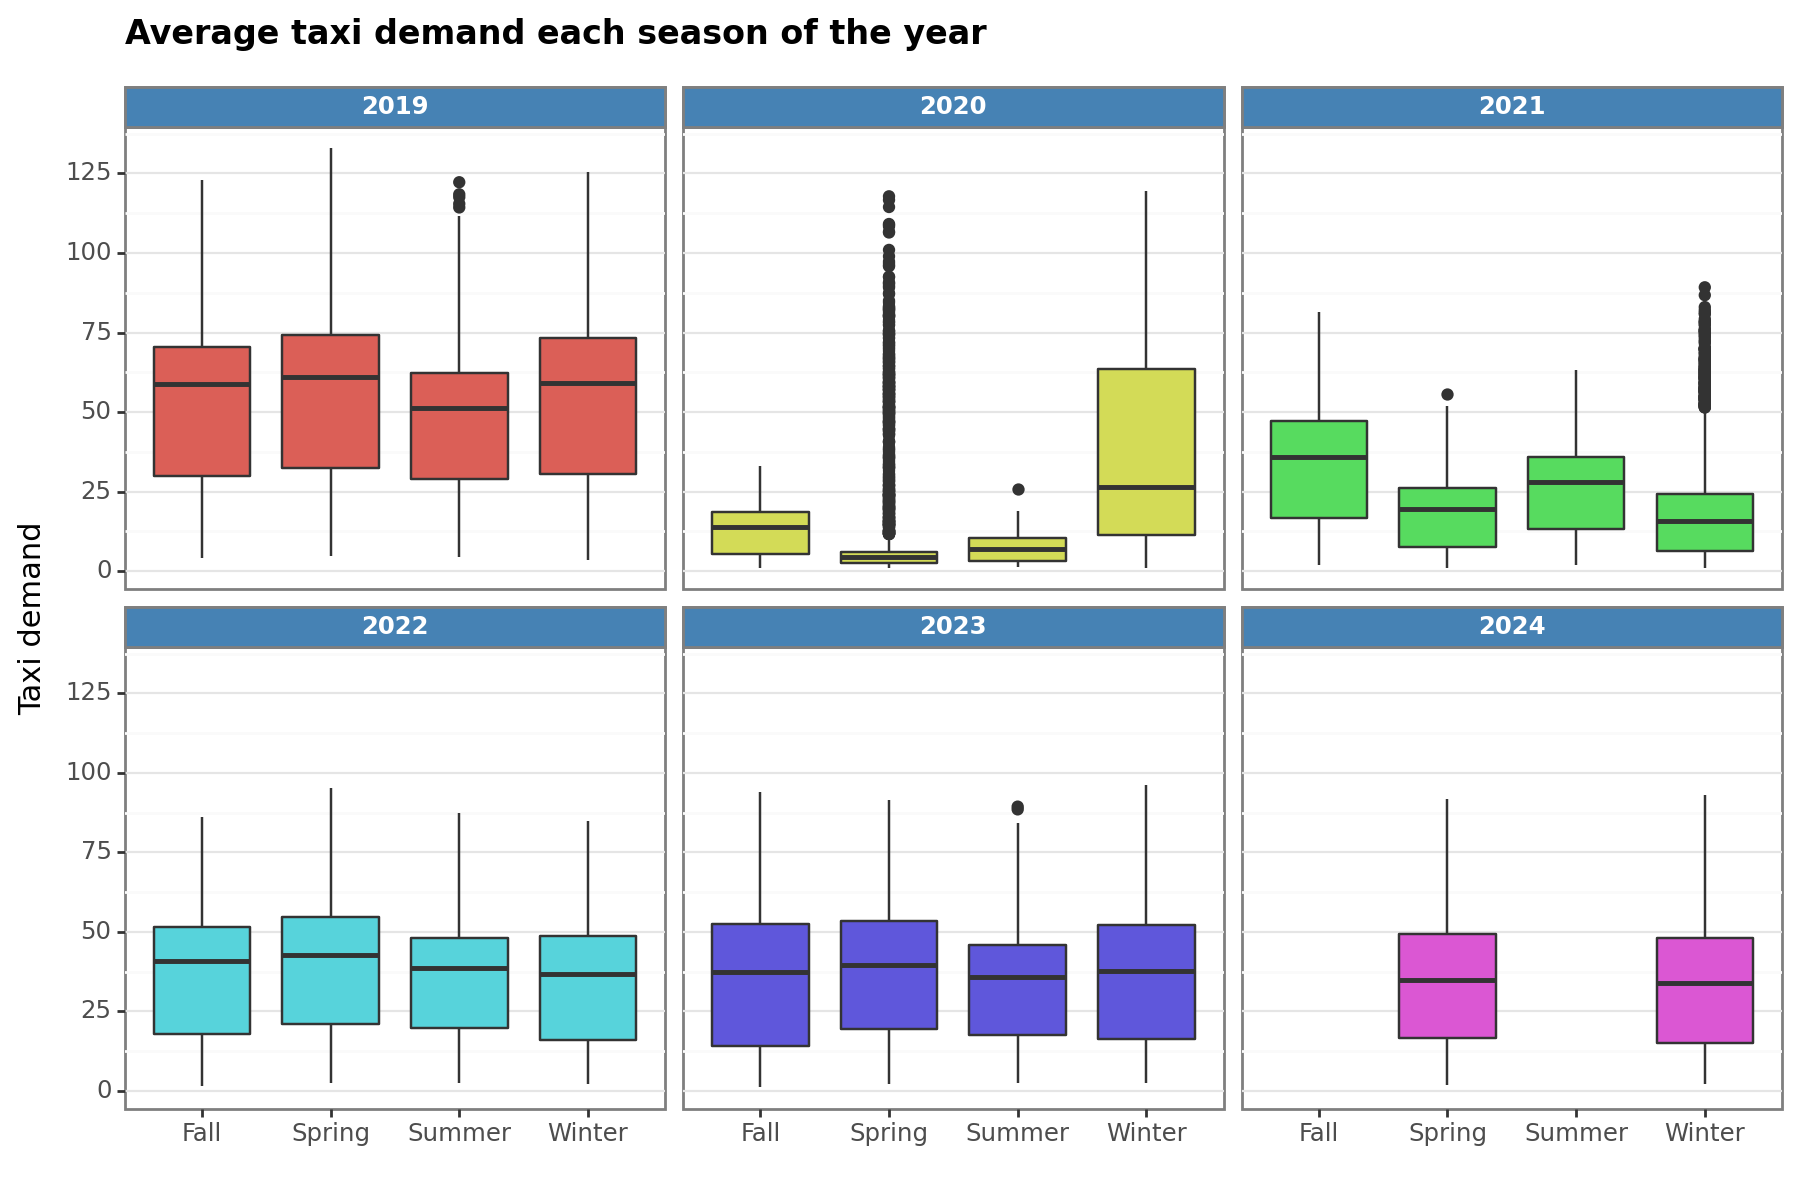

<Figure Size: (900 x 600)>

In [61]:
(
    pn.ggplot(seasonal_rides, pn.aes(x='season', y='avg_rides', fill='factor(year)')) +
    pn.geom_boxplot() +
    pn.facet_wrap('~year') +
    pn.theme_bw() +
    pn.theme(figure_size=(9,6),
             legend_position='none', 
             strip_background=pn.element_rect(fill='steelblue'),
             strip_text=pn.element_text(color='white', weight='bold'),
             panel_grid_major_x=pn.element_blank(),
             plot_title=pn.element_text(weight='bold', size=12)
            ) +
    pn.scale_y_continuous(breaks=range(0,200,25)) +
    pn.labs(x='', y='Taxi demand') +
    pn.ggtitle(title='Average taxi demand each season of the year')
)

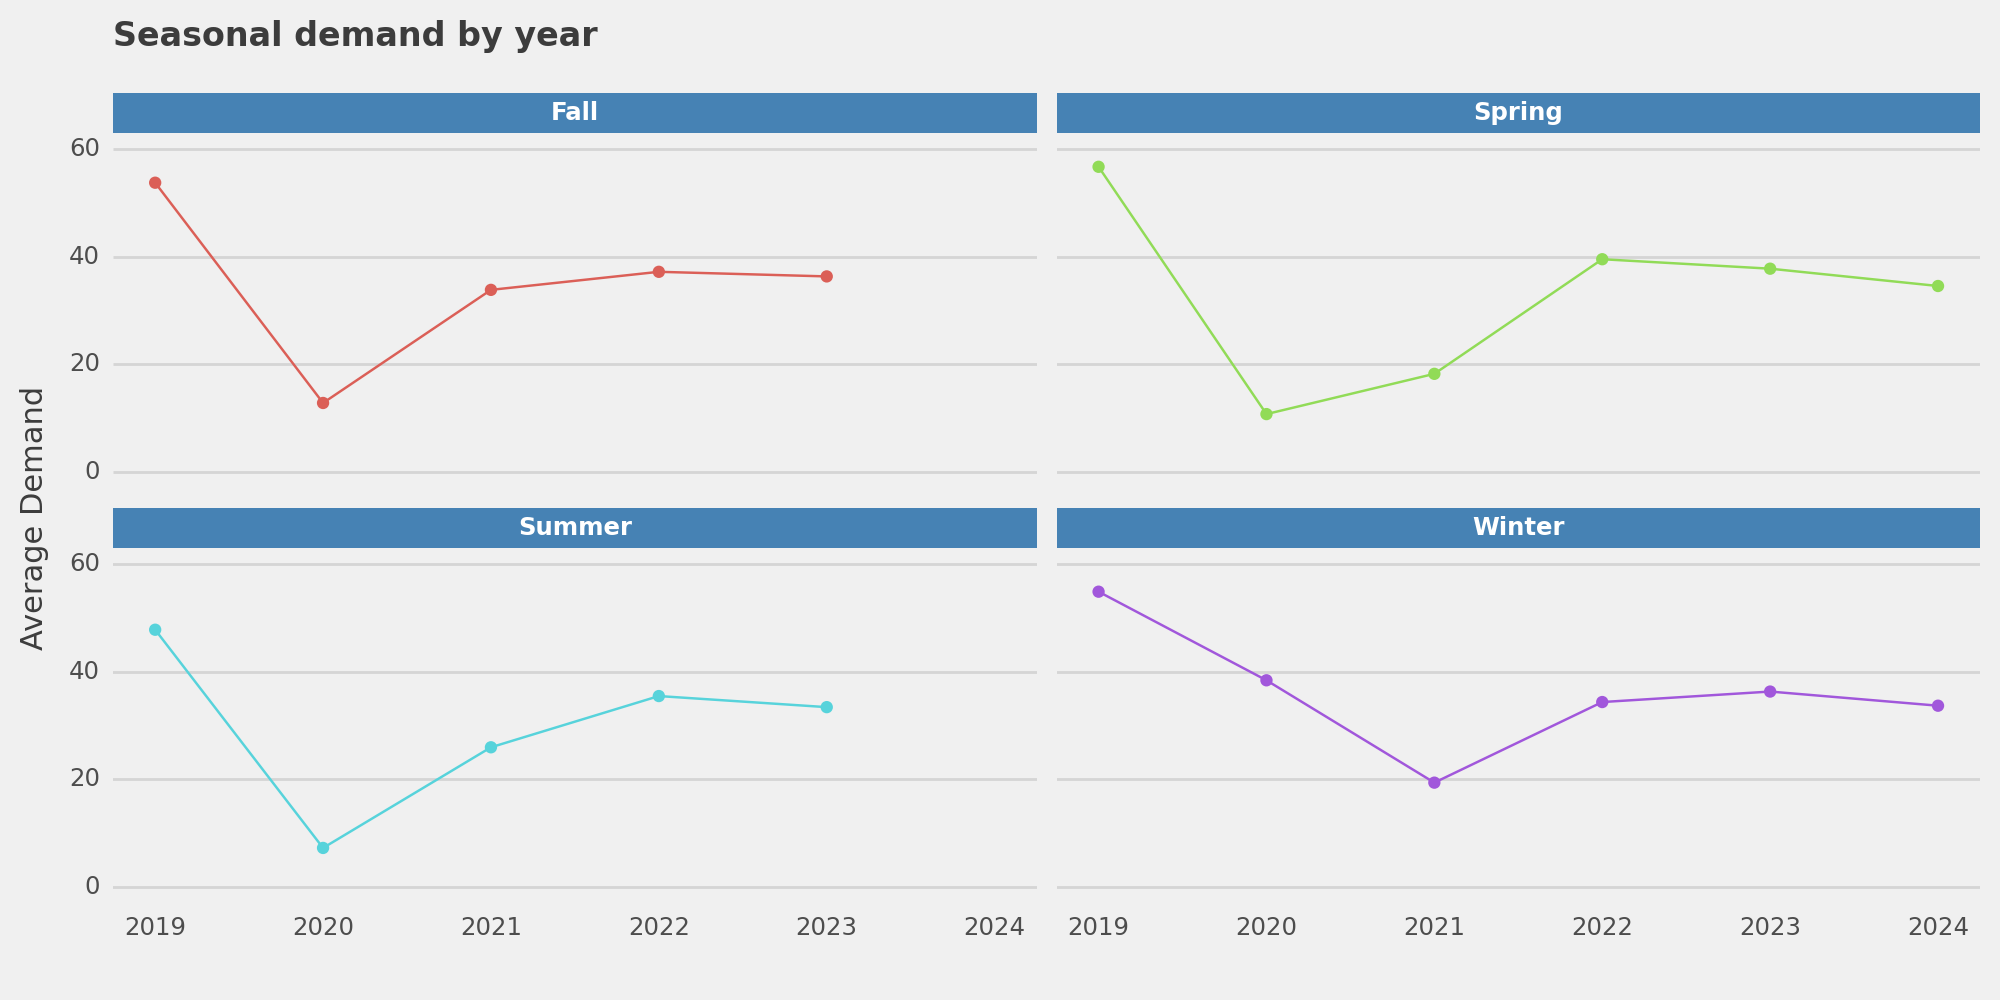

<Figure Size: (1000 x 500)>

In [62]:
(
    pn.ggplot(seasonal_rides.groupby(['season', 'year']).avg_rides.mean().reset_index(),
             pn.aes(x='year', y='avg_rides', color='season')) +
    pn.geom_line() +
    pn.geom_point() +
    pn.facet_wrap('~season', nrow=2) +
    pn.theme_538() +
    pn.theme(plot_title=pn.element_text(size=12, weight='bold'),
             legend_position='none', 
             figure_size=(10,5),
             panel_grid_major_x=pn.element_blank(),
             strip_text=pn.element_text(colour='white', weight='bold'),
             strip_background=pn.element_rect(fill='black', alpha=0.55)) +
    pn.labs(x='', y='Average Demand') +
    pn.ggtitle('Seasonal demand by year') +
    pn.scale_y_continuous(breaks=range(0,61,20), limits=[0,60])
)

- There may be no significant effect of season on taxi demand.
- From the figure above, the average taxi demand per hour look relatively the same except in 2020 and 2021. This anomaly was so because at that time the covid-19 pandemic era, starting from the lockdown in 2020 which disrupted demand to the promising news of the covid-19 vaccine

Next, we will determine if there's any statistical significance in mean demand by seasons. 

__Normality test__

$H_0$: Distribution is normal\
$H_1$: Distribution not normal\
$\alpha$: 0.05

In [63]:
# testing for normality
(
    seasonal_rides
    .groupby('season').avg_rides
    .apply(lambda x: stats.normaltest(x.values)[1])
    .to_frame(name='p-val')
)

p-val
season               
Fall    1.217029e-124
Spring  6.360656e-171
Summer  1.611387e-126
Winter  4.628758e-152

- Distributions not normal, hence we will use the Kruskal-Wallis test to test for median difference

In [64]:
seasonal_rides.groupby('season').avg_rides.agg(['min', 'mean', 'median', 'max'])

min       mean     median         max
season                                            
Fall    1.121212  34.810543  33.161966  122.915888
Spring  1.000000  32.743232  28.541384  132.926606
Summer  1.239130  29.976124  29.137666  122.254386
Winter  1.000000  36.325862  33.795455  125.513761

Hypothesis Testing (Kruskal-Wallis test)

$H_0$: $\text{Median}_{winter} = \text{Median}_{spring} = \text{Median}_{summer} = \text{Median}_{fall}$ \
$H_1$: median hourly rides of at least one is different\
$\alpha$: 0.05

In [65]:
stats.kruskal(
    seasonal_rides.query('season == "Winter"').avg_rides,
    seasonal_rides.query('season == "Summer"').avg_rides,
    seasonal_rides.query('season == "Fall"').avg_rides,
    seasonal_rides.query('season == "Spring"').avg_rides
)

KruskalResult(statistic=399.51479891103605, pvalue=2.8200265476703203e-86)

In [66]:
# Dunn Post Hoc test to test which of the groups are different
sp.posthoc_dunn(
    seasonal_rides, val_col='avg_rides', group_col='season',
    p_adjust='holm'
).style.format('{:.5e}').set_caption('Dunn\'s Post-hoc test')

- From above, we see that there's a statistical significant difference in the median hourly rides by season

#### Holiday and weekend impact

In [67]:
# adding holiday and week to total and average hourly rides in all pickup stations
city_station_rides = city_station_rides.assign(
    is_holiday=1*city_station_rides.ride_datetime.dt.date.isin(us_holidays.date),
    is_weekend = 1*(city_station_rides.ride_datetime.dt.isocalendar().day > 5)
)

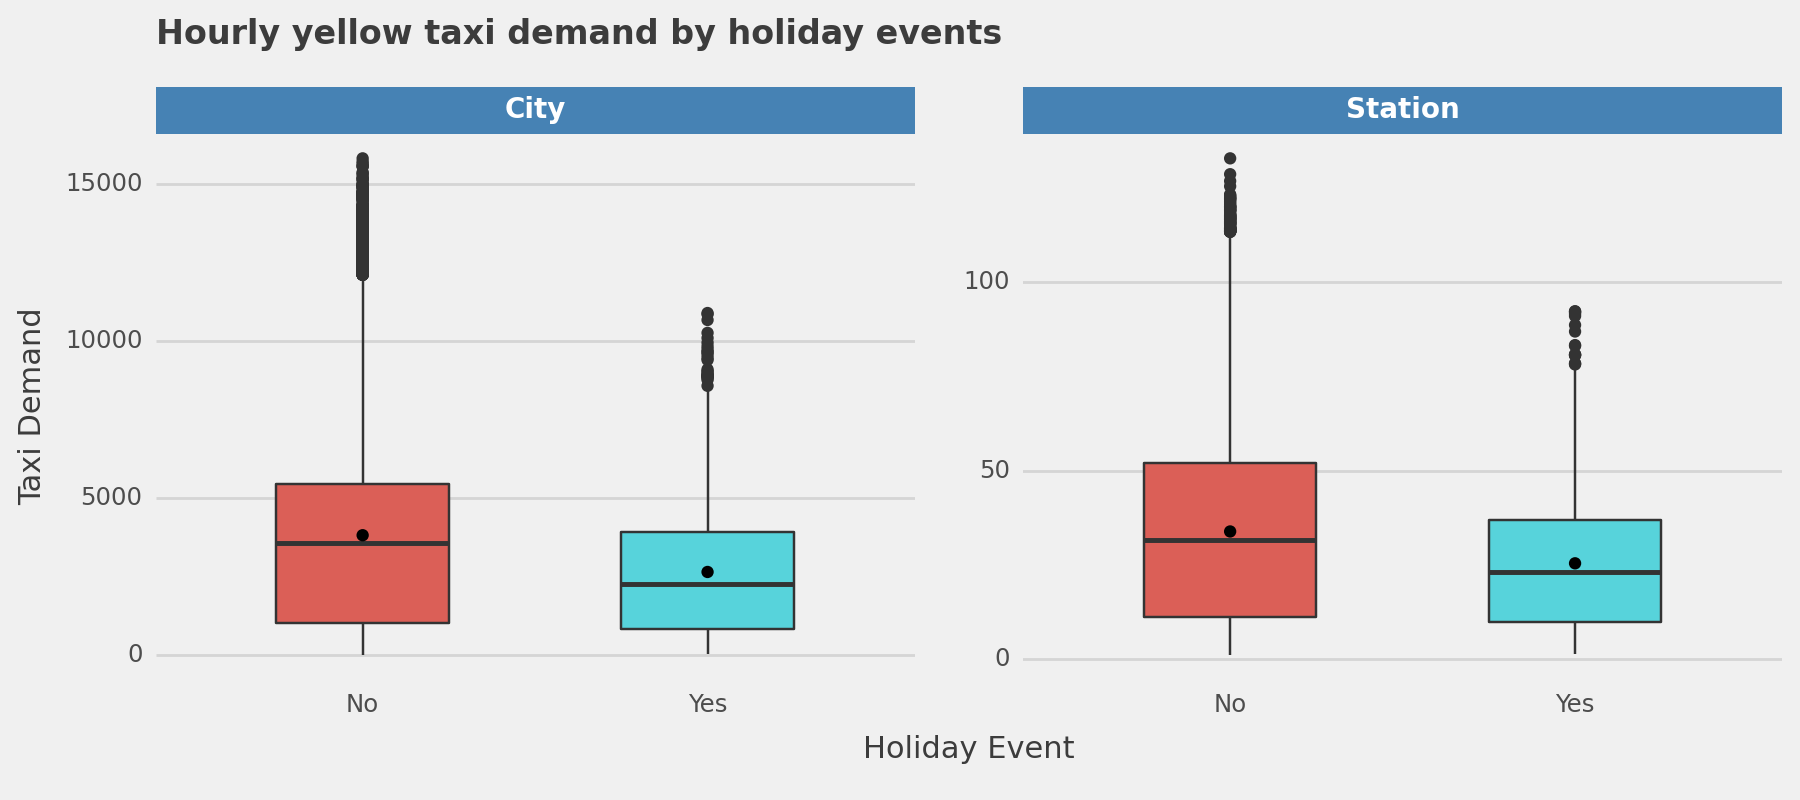

<Figure Size: (900 x 400)>

In [68]:
(
    pn.ggplot(city_station_rides, 
              pn.aes(x='factor(is_holiday)', y='rides', fill='factor(is_holiday)')) +
    pn.geom_boxplot(width=0.5) +
    pn.geom_point(fill='black', stat=pn.stat_summary(fun_y=np.mean)) +
    pn.facet_wrap('~group', scales='free_y', labeller=pn.as_labeller(lambda x: x.title())) +
    pn.theme_538() +
    pn.theme(plot_title=pn.element_text(weight='bold', size=12),
             panel_grid_major_x=pn.element_blank(),
             figure_size=(9,4),
             legend_position='none',
             strip_background=pn.element_rect(fill='steelblue'),
             strip_text=pn.element_text(colour='white', weight='bold', size=10)
            ) +
    pn.scale_x_discrete(labels=['No', 'Yes']) +
    pn.labs(title='Hourly yellow taxi demand by holiday events', x='Holiday Event', y='Taxi Demand')
)

- The mean (black dot) and median taxi demand per hour during non-holiday is higher than the mean and median during holidays
- During holidays, the maximum demand for a taxi in a pickup station is less than 100 while in all pickup stations a maximum of about 11,000 taxis is hauled by residents. Conversely, during non-holidays, up to 150 taxis are hauled in a pickup station while more than 15,000 were demanded in all pickup stations

Let's look at the impact of holidays and weekends on taxi demand but firstly, let's look at the impact of weekends/weekdays on taxi demand

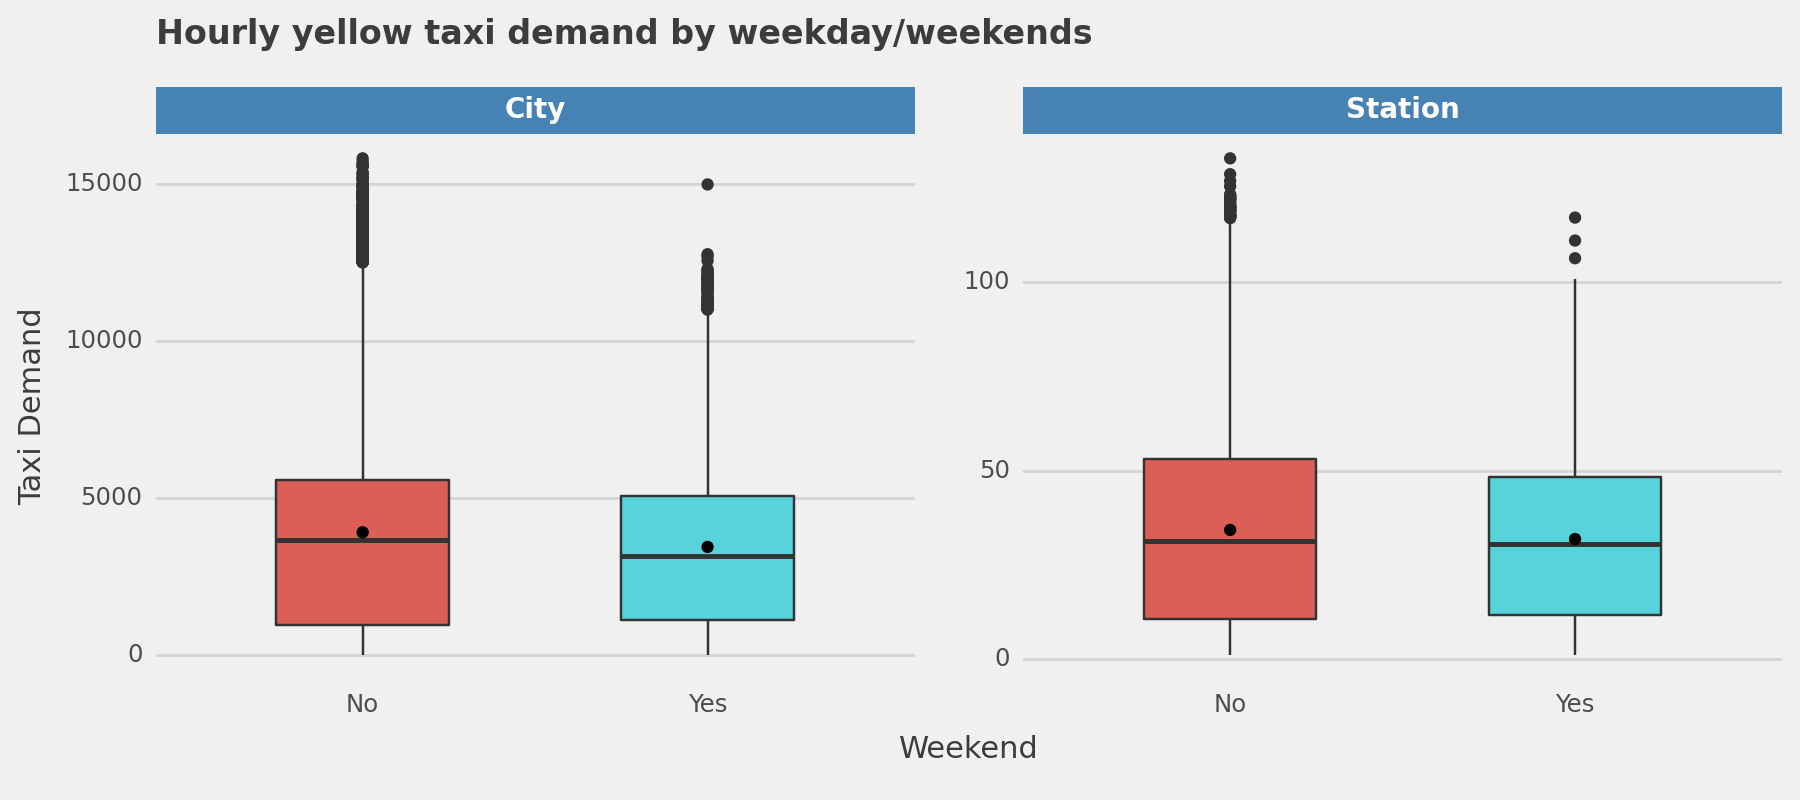

<Figure Size: (900 x 400)>

In [69]:
(
    pn.ggplot(city_station_rides, 
              pn.aes(x='factor(is_weekend)', y='rides', fill='factor(is_weekend)')) +
    pn.geom_boxplot(width=0.5) +
    pn.geom_point(fill='black', stat=pn.stat_summary(fun_y=np.mean)) +
    pn.facet_wrap('~group', scales='free_y', labeller=pn.as_labeller(lambda x: x.title())) +
    pn.theme_538() +
    pn.theme(plot_title=pn.element_text(weight='bold', size=12),
             panel_grid_major_x=pn.element_blank(),
             figure_size=(9,4),
             legend_position='none',
             strip_background=pn.element_rect(fill='steelblue'),
             strip_text=pn.element_text(colour='white', weight='bold', size=10)
            ) +
    pn.scale_x_discrete(labels=['No', 'Yes']) +
    pn.labs(title='Hourly yellow taxi demand by weekday/weekends', 
            x='Weekend', y='Taxi Demand')
)

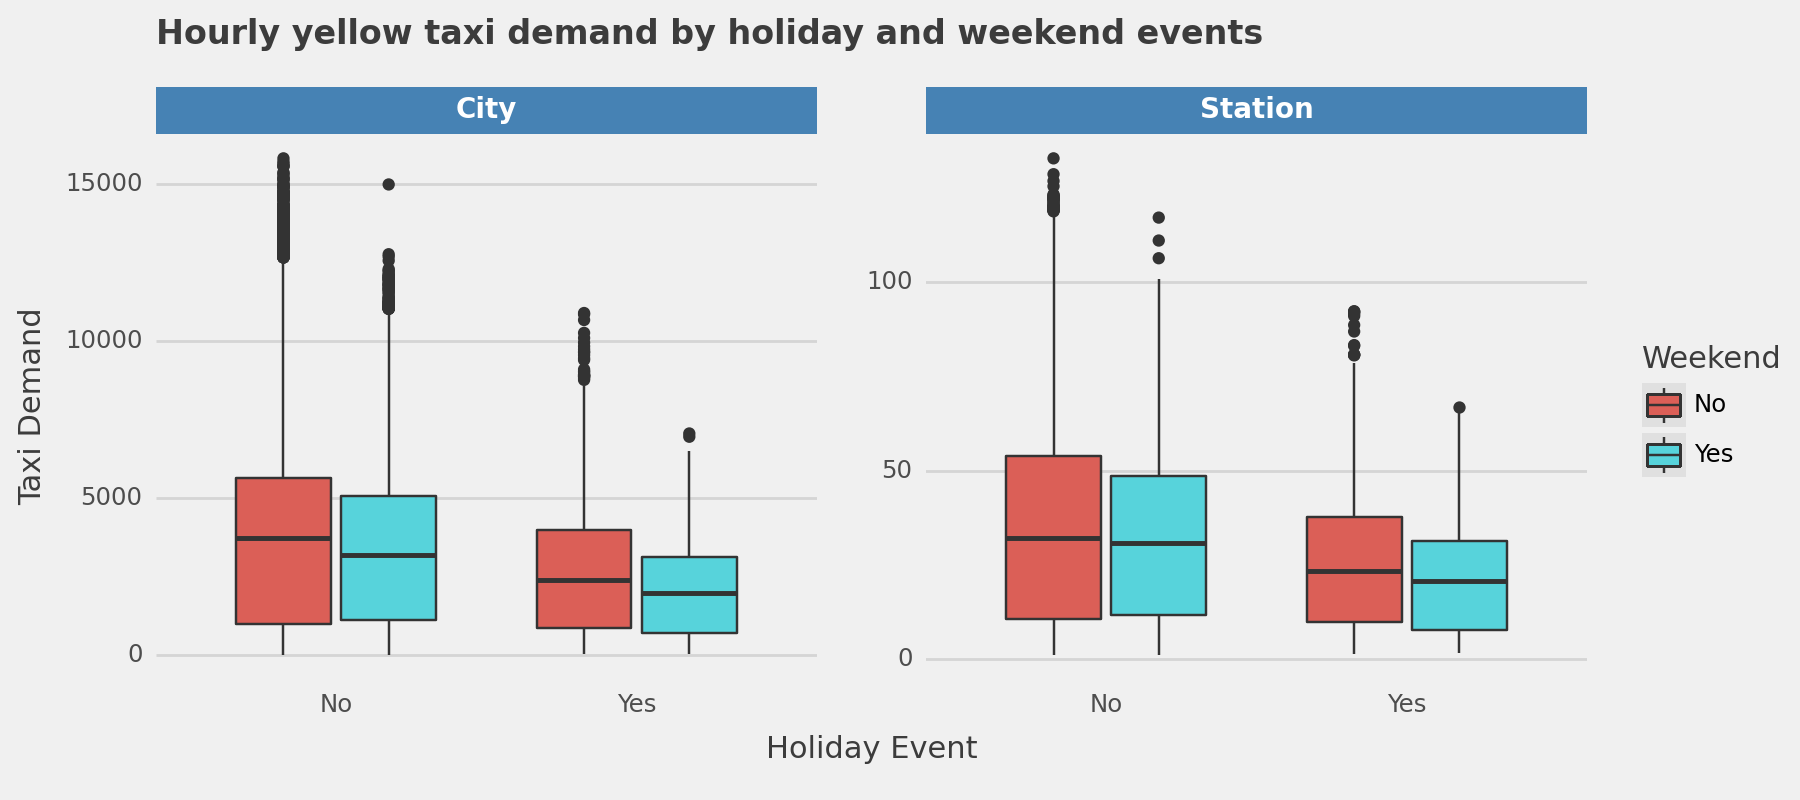

<Figure Size: (900 x 400)>

In [70]:
(
    pn.ggplot(city_station_rides, 
              pn.aes(x='factor(is_holiday)', y='rides', fill='factor(is_weekend)')) +
    pn.geom_boxplot(width=0.7) +
    pn.facet_wrap('~group', scales='free_y', labeller=pn.as_labeller(lambda x: x.title())) +
    pn.theme_538() +
    pn.theme(plot_title=pn.element_text(weight='bold', size=12),
             panel_grid_major_x=pn.element_blank(),
             legend_title=pn.element_text(size=9),
             figure_size=(9,4),
             strip_background=pn.element_rect(fill='steelblue'),
             strip_text=pn.element_text(colour='white', weight='bold', size=10)
            ) +
    pn.scale_x_discrete(labels=['No', 'Yes']) +
    pn.scale_fill_discrete(name='Weekend', labels=['No', 'Yes']) +
    pn.labs(title='Hourly yellow taxi demand by holiday and weekend events', 
            x='Holiday Event', y='Taxi Demand')
)

- There seems to be no difference in weekday/weekend demands whether it is the weekday or weekend is a holiday or not.

__Hourly rides by holiday and weekends__

In [71]:
us_holidays_dates = us_holidays.date.map(str).pipe(tuple)

In [72]:
# rides during holidays per hour
query = f"""SELECT strftime('%H', ride_datetime) as hour, 
           CASE 
              WHEN strftime('%Y-%m-%d', ride_datetime) IN {us_holidays_dates} THEN '1'
              ELSE '0'
              END AS is_holiday,
            AVG(hourly_rides) as avg_rides
        FROM pickup_trips
        GROUP BY hour, is_holiday
          """

holiday_rides = pd.read_sql(query, conn)

In [73]:
# rides during weekends per hour
query = f"""SELECT strftime('%H', ride_datetime) as hour,
           CASE 
              -- 0: Sunday, 6: Saturday
              WHEN strftime('%w', ride_datetime) IN ('0', '6') THEN '1'
              ELSE '0'
              END AS is_weekend,
            AVG(hourly_rides) as avg_rides
        FROM pickup_trips
        GROUP BY hour, is_weekend
          """
weekend_rides = pd.read_sql(query, conn)

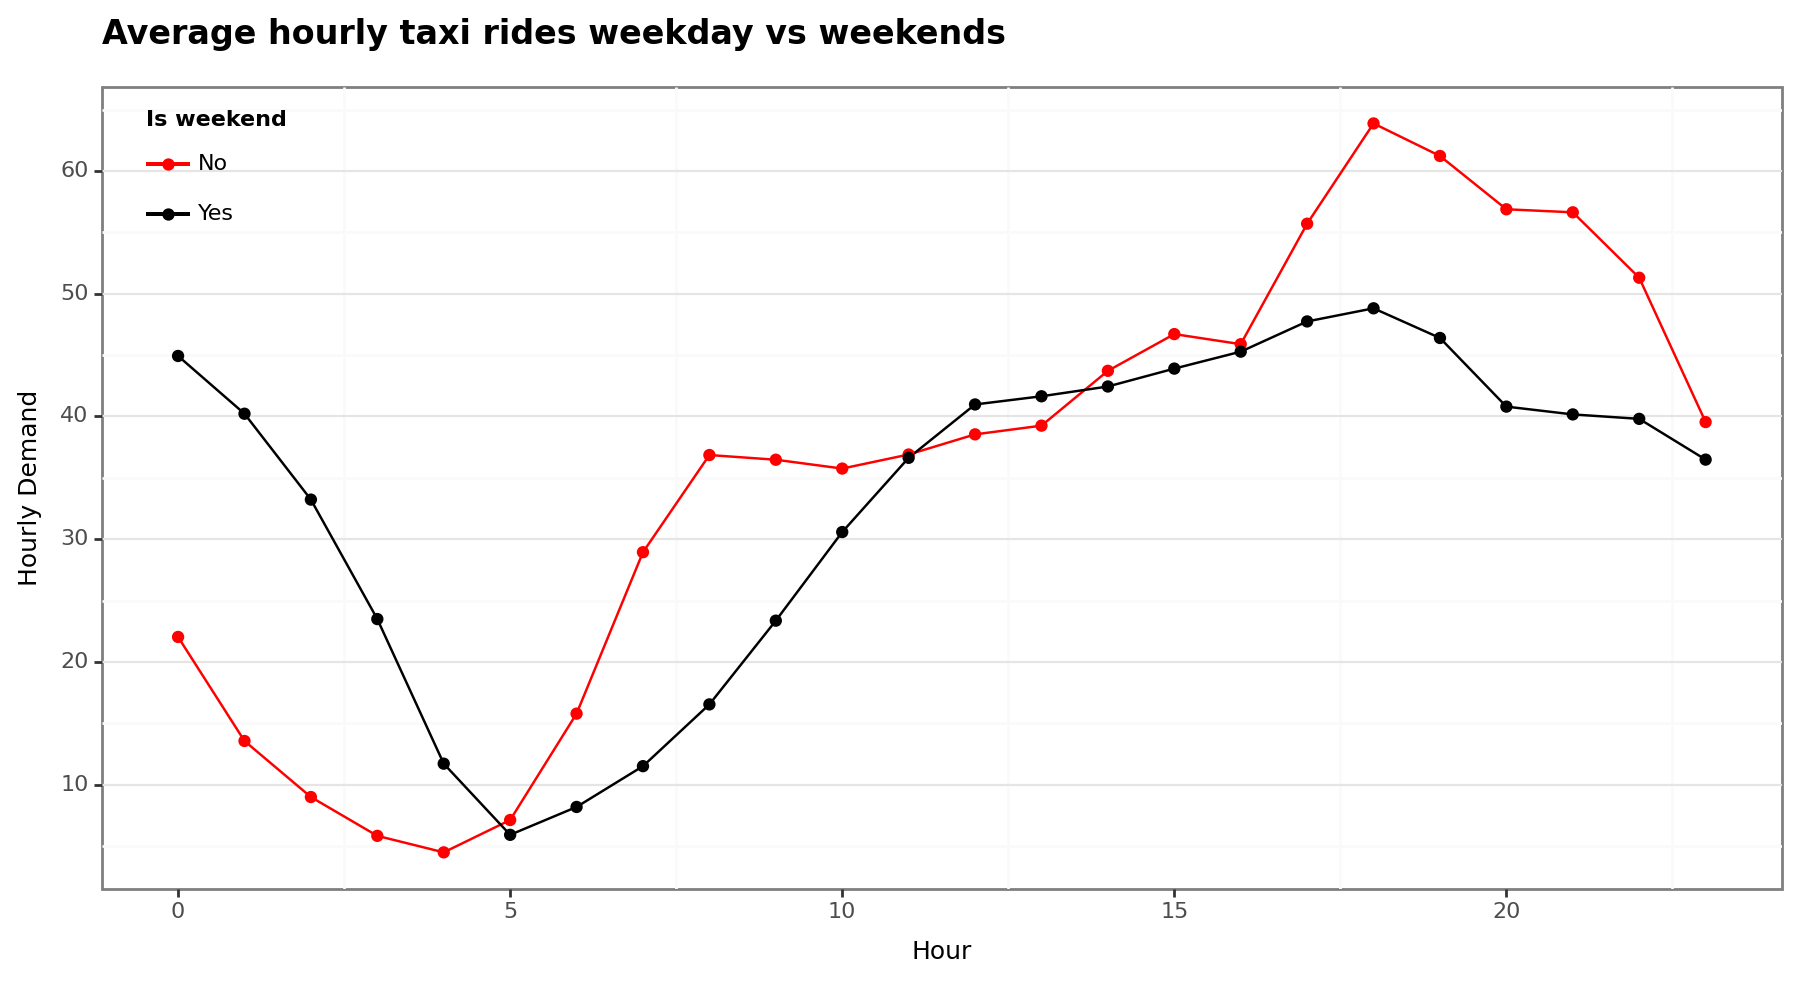

<Figure Size: (900 x 500)>

In [74]:
(
    pn.ggplot(weekend_rides, pn.aes(x='hour.map(int)', y='avg_rides', color='factor(is_weekend)')) +
    pn.geom_line(alpha=0.8) +
    pn.geom_point(alpha=0.8) +
    pn.theme_bw() +
    pn.theme(figure_size=(9,5),
             legend_position=(0.12, 0.83),
             legend_background =pn.element_blank(),
             legend_title=pn.element_text(size=8, weight='bold'),
             legend_title_align='baseline',
             legend_direction='vertical',
             legend_text=pn.element_text(size=8),
             legend_key=pn.element_blank(),
             panel_grid_major_x = pn.element_blank(),
             axis_text=pn.element_text(size=8),
             axis_title=pn.element_text(size=9),
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.scale_x_continuous(breaks=range(0,24,5)) +
    pn.scale_y_continuous(breaks=range(0,70,10)) +
    pn.labs(x='Hour', y='Hourly Demand') +
    pn.ggtitle(title='Average hourly taxi rides weekday vs weekends') +
    pn.scale_color_manual(values=['red', 'black'], labels=['No', 'Yes'], name='Is weekend')
)

- There's a almost a similar pattern between the hourly rides demanded on weekends and on weekdays.
- During the weekends, the hourly demand is higher late at night and in the early hours of the morning, between 12Am and 4AM

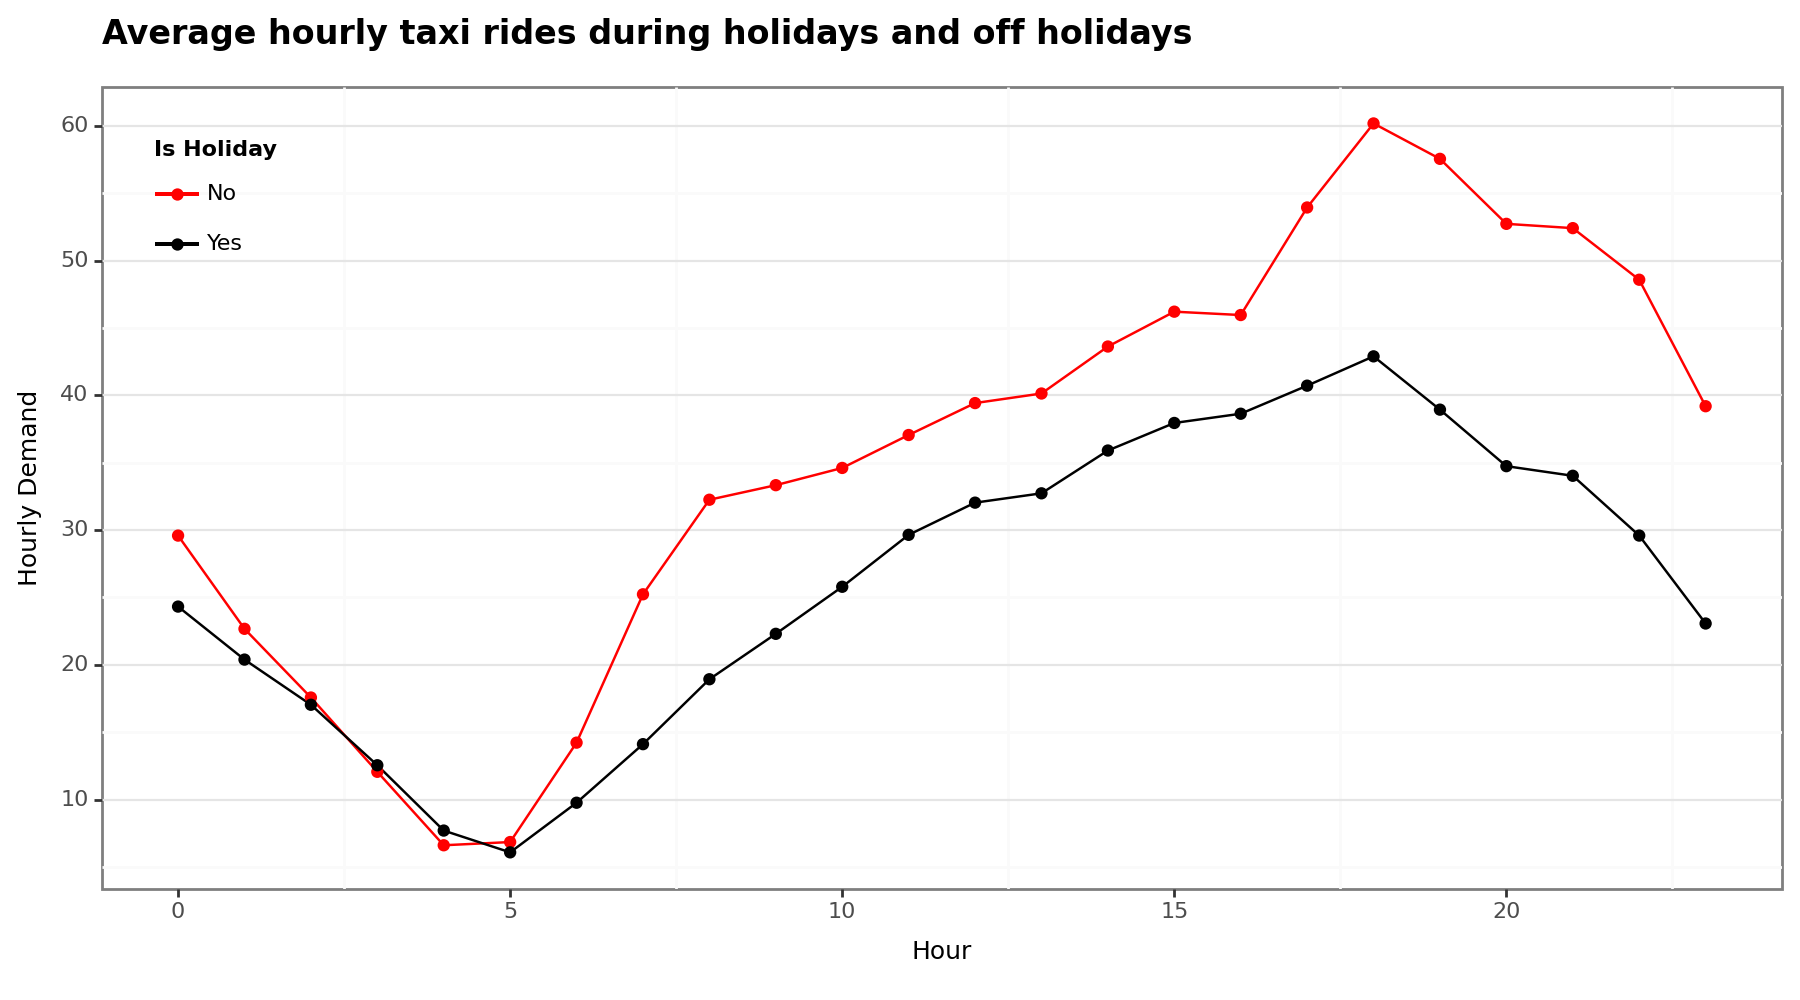

<Figure Size: (900 x 500)>

In [75]:
(
    pn.ggplot(holiday_rides, pn.aes(x='hour.map(int)', y='avg_rides', color='factor(is_holiday)')) +
    pn.geom_line(alpha=0.8) +
    pn.geom_point(alpha=0.8) +
    pn.theme_bw() +
    pn.theme(figure_size=(9,5),
             legend_position=(0.12, 0.8),
             legend_background =pn.element_blank(),
             legend_title=pn.element_text(size=8, weight='bold'),
             legend_title_align='baseline',
             legend_direction='vertical',
             legend_text=pn.element_text(size=8),
             legend_key=pn.element_blank(),
             panel_grid_major_x = pn.element_blank(),
             axis_text=pn.element_text(size=8),
             axis_title=pn.element_text(size=9),
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.scale_x_continuous(breaks=range(0,24,5)) +
    pn.scale_y_continuous(breaks=range(0,70,10)) +
    pn.labs(x='Hour', y='Hourly Demand') +
    pn.ggtitle(title='Average hourly taxi rides during holidays and off holidays') +
    pn.scale_color_manual(values=['red', 'black'], labels=['No', 'Yes'], name='Is Holiday')
)

- Just like we saw with the weekend vs weekdays, we see a similar pattern with average taxi demanded during holidays and off-holidays. The amount of taxis demanded during holidays is below the amount demanded off holidays but in the early hours of the day between 12 AM and 5 AM, the average amount of rides demanded are relatively the same.
- During off-holidays, taxi demand rise and first peaks at 8 AM (first rush hour of the day). This further increases till it its highest peak around 6 PM before dwindling towards the end of the day.
- On the other hand the rate of increase of hourly demand during holidays increases slowly before peaking at around 6 PM and slowly declines towards the night.

**Test for statistical significance between hourly rides during holidays and weekends**

Hypothesis Testing (Kruskal-Wallis test)

$H_0$: median hourly rides is the same on holidays and non-holidays \
$H_1$: median hourly rides are not the same\
$\alpha$: 0.05

In [76]:
city_station_rides.query('group == "station"').groupby('is_holiday').rides.apply(
    lambda x:stats.kstest(x.values, 'norm')[1]).reset_index(name='p-val')

is_holiday  p-val
0           0    0.0
1           1    0.0

In [77]:
city_station_rides.query('group == "station"').groupby('is_weekend').rides.apply(
    lambda x:stats.kstest(x.values, 'norm')[1]).reset_index(name='p-val')

is_weekend  p-val
0           0    0.0
1           1    0.0

In [78]:
stats.mannwhitneyu(
    city_station_rides.query('group == "station" & is_holiday == 0').rides,
    city_station_rides.query('group == "station" & is_holiday == 1').rides
)

MannwhitneyuResult(statistic=40702018.0, pvalue=1.125165008878858e-31)

In [79]:
stats.mannwhitneyu(
    city_station_rides.query('group == "station" & is_weekend == 0').rides,
    city_station_rides.query('group == "station" & is_weekend == 1').rides
)

MannwhitneyuResult(statistic=221684789.5, pvalue=8.709046676485403e-06)

In [80]:
city_station_rides.query('group == "station"').groupby(
    ['is_holiday', 'is_weekend']).rides.apply(
    lambda x:stats.kstest(x.values, 'norm')[1]).reset_index(name='p-val')

is_holiday  is_weekend  p-val
0           0           0    0.0
1           0           1    0.0
2           1           0    0.0
3           1           1    0.0

In [81]:
stats.kruskal(
    city_station_rides.query('group == "station" & is_holiday == 0 & is_weekend == 0').rides,
    city_station_rides.query('group == "station" & is_holiday == 0 & is_weekend == 1').rides,
    city_station_rides.query('group == "station" & is_holiday == 1 & is_weekend == 0').rides,
    city_station_rides.query('group == "station" & is_holiday == 1 & is_weekend == 1').rides
)

KruskalResult(statistic=165.2392292956813, pvalue=1.3563092623844257e-35)

In [82]:
res = sp.posthoc_dunn(city_station_rides.assign(
    hol_wd = city_station_rides.is_holiday.astype(str) + '-' + city_station_rides.is_weekend.astype(str)
    ).query("group == 'station'"), 
    val_col='rides', group_col='hol_wd', p_adjust='bonferroni'   
                )


res

0-0           0-1           1-0           1-1
0-0  1.000000e+00  4.310384e-06  7.130986e-26  1.073584e-09
0-1  4.310384e-06  1.000000e+00  5.760852e-17  1.339401e-07
1-0  7.130986e-26  5.760852e-17  1.000000e+00  3.601820e-01
1-1  1.073584e-09  1.339401e-07  3.601820e-01  1.000000e+00

- There's a statistical significance in the median hourly rides between holidays and weekends except when the day is a holiday irrespective of if it's a weekday or weekend.

### D. Station Popularity

Here, we will look at yellow taxi demand by pickup and dropoff stations. By taxi demand, we will look at the top 10 and least 10 pickup stations. Next, we will look at the dropoff stations people mostly visit. Based on the top 10 pickup and dropoff stations, we will look at the average hourly taxi demands per day and month. This analysis aims to identify concentration areas where yellow taxi demands are high to ensure that there are available taxis within those locations.

Furthermore, we will drill down to the top stations by borough and zone and the total revenue generated

In [83]:
station_rides_query = """
WITH pickup_station_rides AS (
       SELECT pickup_station, 
              SUM(hourly_rides) AS total_pickup_rides,
              AVG(hourly_rides) AS avg_pickup_rides,
              SUM(revenue) AS total_revenue,
              AVG(revenue) AS avg_revenue,
              AVG(total_fare_cost) AS fare_cost
        FROM pickup_trips
        GROUP BY pickup_station
        ),
dropoff_station_rides AS (
        SELECT dropoff_station, 
               SUM(hourly_rides) AS total_dropoff_rides,
               AVG(hourly_rides) AS avg_dropoff_rides
        FROM dropoff_trips
        GROUP BY dropoff_station
        )

SELECT p.pickup_station, 
       l.borough, l.zone, l.area_km2,
       p.total_pickup_rides, d.total_dropoff_rides,
       p.avg_pickup_rides, d.avg_dropoff_rides,
       p.total_revenue, p.avg_revenue, p.fare_cost
FROM pickup_station_rides p
JOIN dropoff_station_rides d
ON p.pickup_station = d.dropoff_station
JOIN location_info l
ON p.pickup_station = l.ride_station
"""

In [84]:
station_rides = pd.read_sql_query(station_rides_query, conn)

In [85]:
station_rides.head()

pickup_station        borough                     zone  total_pickup_rides  \
0               1            EWR           Newark Airport               25054   
1               2         Queens              Jamaica Bay                 157   
2               3          Bronx  Allerton/Pelham Gardens                7122   
3               4      Manhattan            Alphabet City              256986   
4               5  Staten Island            Arden Heights                1556   

   total_dropoff_rides  avg_pickup_rides  avg_dropoff_rides  total_revenue  \
0               431212          1.712977          12.417912   2.740090e+06   
1                  216          1.000000           1.043478   9.256940e+03   
2                15238          1.191767           1.291465   2.690191e+05   
3               710565          6.869079          16.611301   5.595665e+06   
4                 2435          1.003871           1.032655   1.393901e+05   

   avg_revenue   fare_cost  
0   187.343744  156.008531  
1    58.961401   45.884586  
2    45.016580   38.997326  
3   149.568732  103.308435  
4    89.929071   70.623276

In [164]:
# percentage of rides in and out of station that were dropoffs
station_rides = station_rides.assign(
    station_perc_dropoff = 100*station_rides.total_dropoff_rides / (station_rides.total_pickup_rides + station_rides.total_dropoff_rides)
    )

#### Distribution of total and average pickups and dropoffs at stations

In [87]:
describe_data(station_rides.avg_dropoff_rides, 'Average Dropoff rides')

In [88]:
describe_data(station_rides.avg_pickup_rides, 'Average Pickup rides')

In [89]:
describe_data(station_rides.total_dropoff_rides, 'Total Dropoff rides')

In [90]:
describe_data(station_rides.total_pickup_rides, 'Total pickup rides')

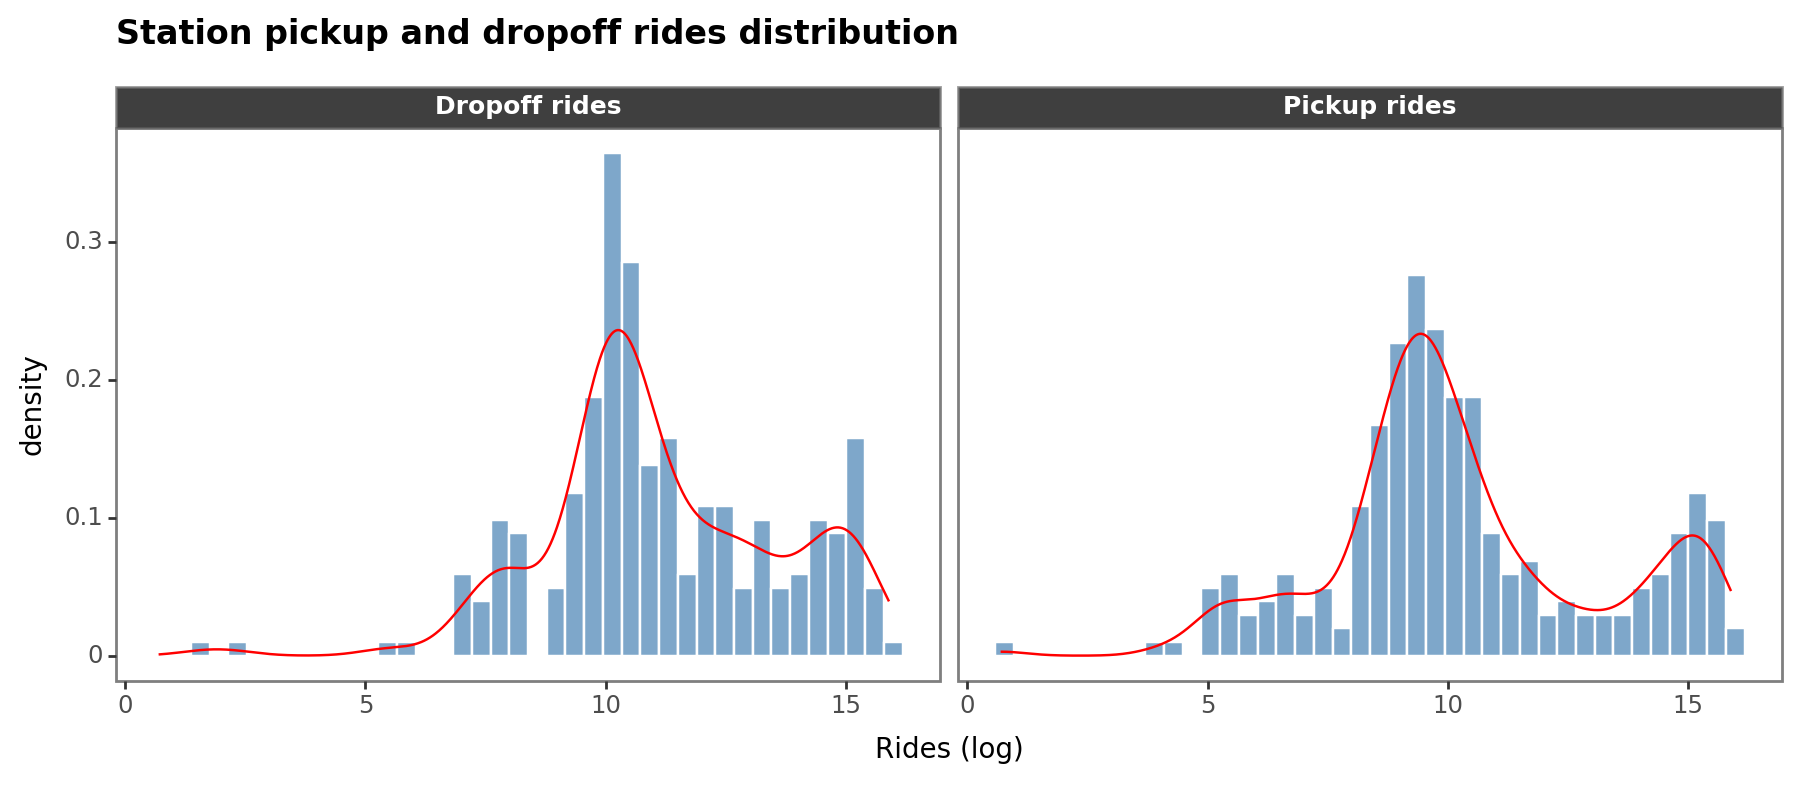

<Figure Size: (900 x 400)>

In [91]:
# distribution of total and average number of pickups and dropoffs
df = (
    station_rides
    .melt(id_vars=['avg_pickup_rides', 'avg_dropoff_rides'],
          value_vars=['total_pickup_rides', 'total_dropoff_rides'], 
          var_name='tot_type', value_name='tot_rides')
    .melt(id_vars=['tot_type', 'tot_rides'],
          value_vars=['avg_pickup_rides', 'avg_dropoff_rides'],
          value_name='avg_rides', var_name='avg_type')
)

(
    pn.ggplot(df, pn.aes(x='np.log(tot_rides)', y='..density..')) +
    pn.geom_histogram(bins=40, fill='steelblue', color='white', alpha=0.7) + 
    pn.geom_density(color='red') +
    pn.facet_grid('~tot_type', labeller=pn.as_labeller(lambda x: ' '.join(x.split('_')[1:]).capitalize())) +
    pn.theme_bw() +
    pn.theme(figure_size=(9,4),
             axis_title=pn.element_text(size=10),
             panel_grid=pn.element_blank(),
             strip_text=pn.element_text(size=9, color='white', weight='bold'),
             strip_background=pn.element_rect(fill='k', alpha=0.5),
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.labs(title='Station pickup and dropoff rides distribution',
            x='Rides (log)')
)

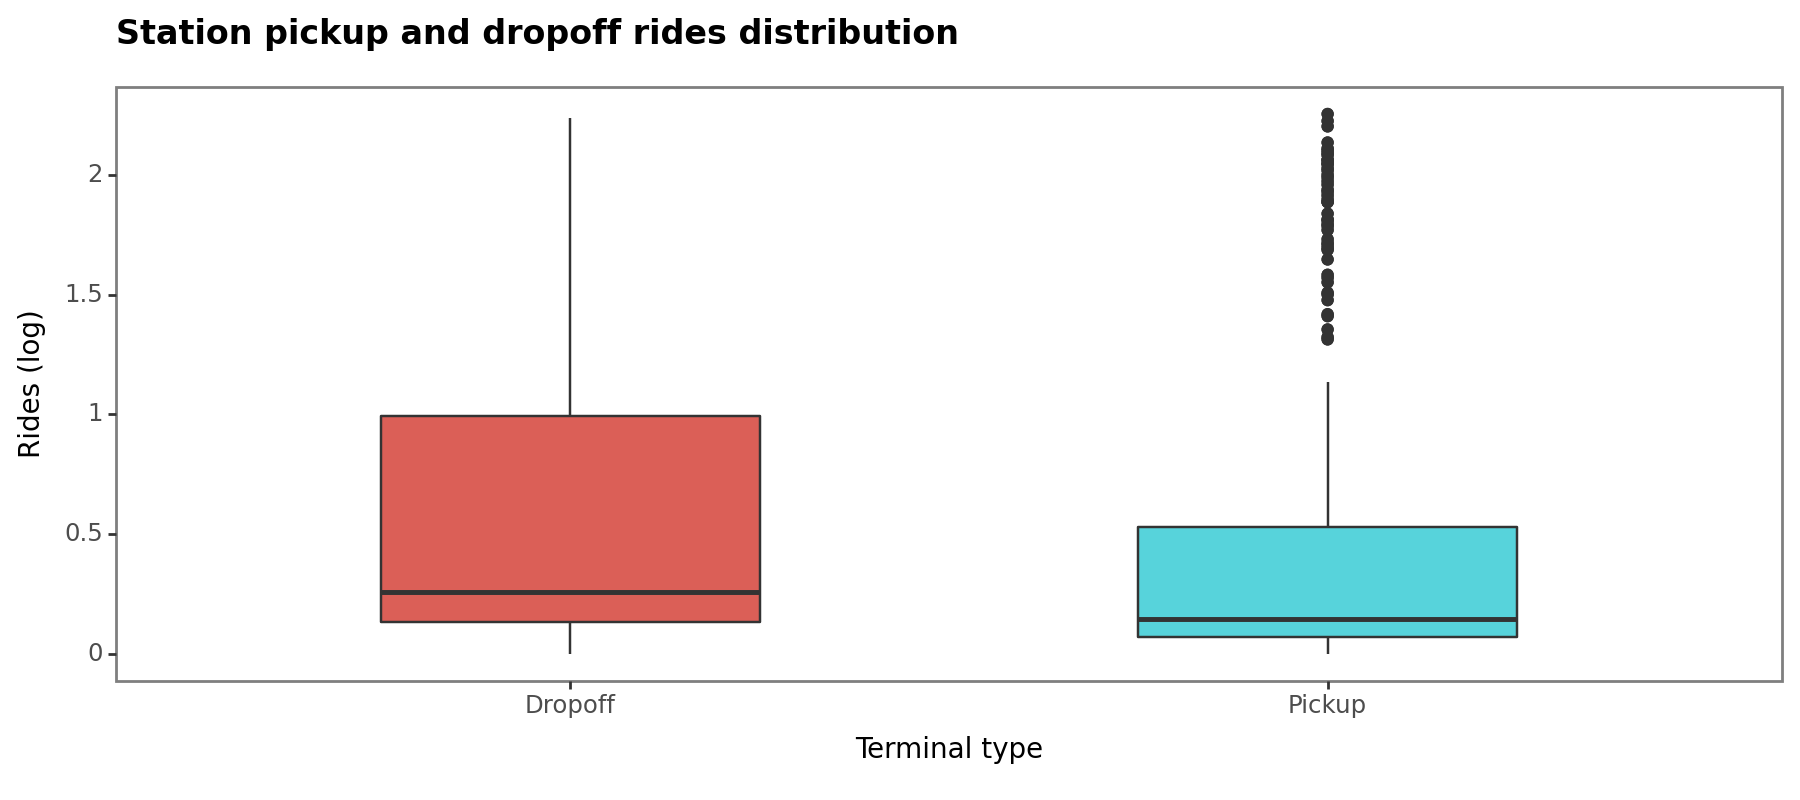

<Figure Size: (900 x 400)>

In [92]:
(
    pn.ggplot(df, pn.aes(x='avg_type', y='np.log10(avg_rides)', fill='avg_type')) +
    pn.geom_boxplot(width=0.5) +
    pn.theme_bw() +
    pn.theme(figure_size=(9,4),
             legend_position='none',
             axis_title=pn.element_text(size=10),
             panel_grid=pn.element_blank(),
             strip_text=pn.element_text(size=10, color='white', weight='bold'),
             strip_background=pn.element_rect(fill='steelblue'),
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.scale_x_discrete(labels=['Dropoff', 'Pickup']) +
    pn.scale_y_continuous(breaks=np.arange(0,3,0.5)) +
    pn.labs(title='Station pickup and dropoff rides distribution',
            y='Rides (log)', x='Terminal type')
)

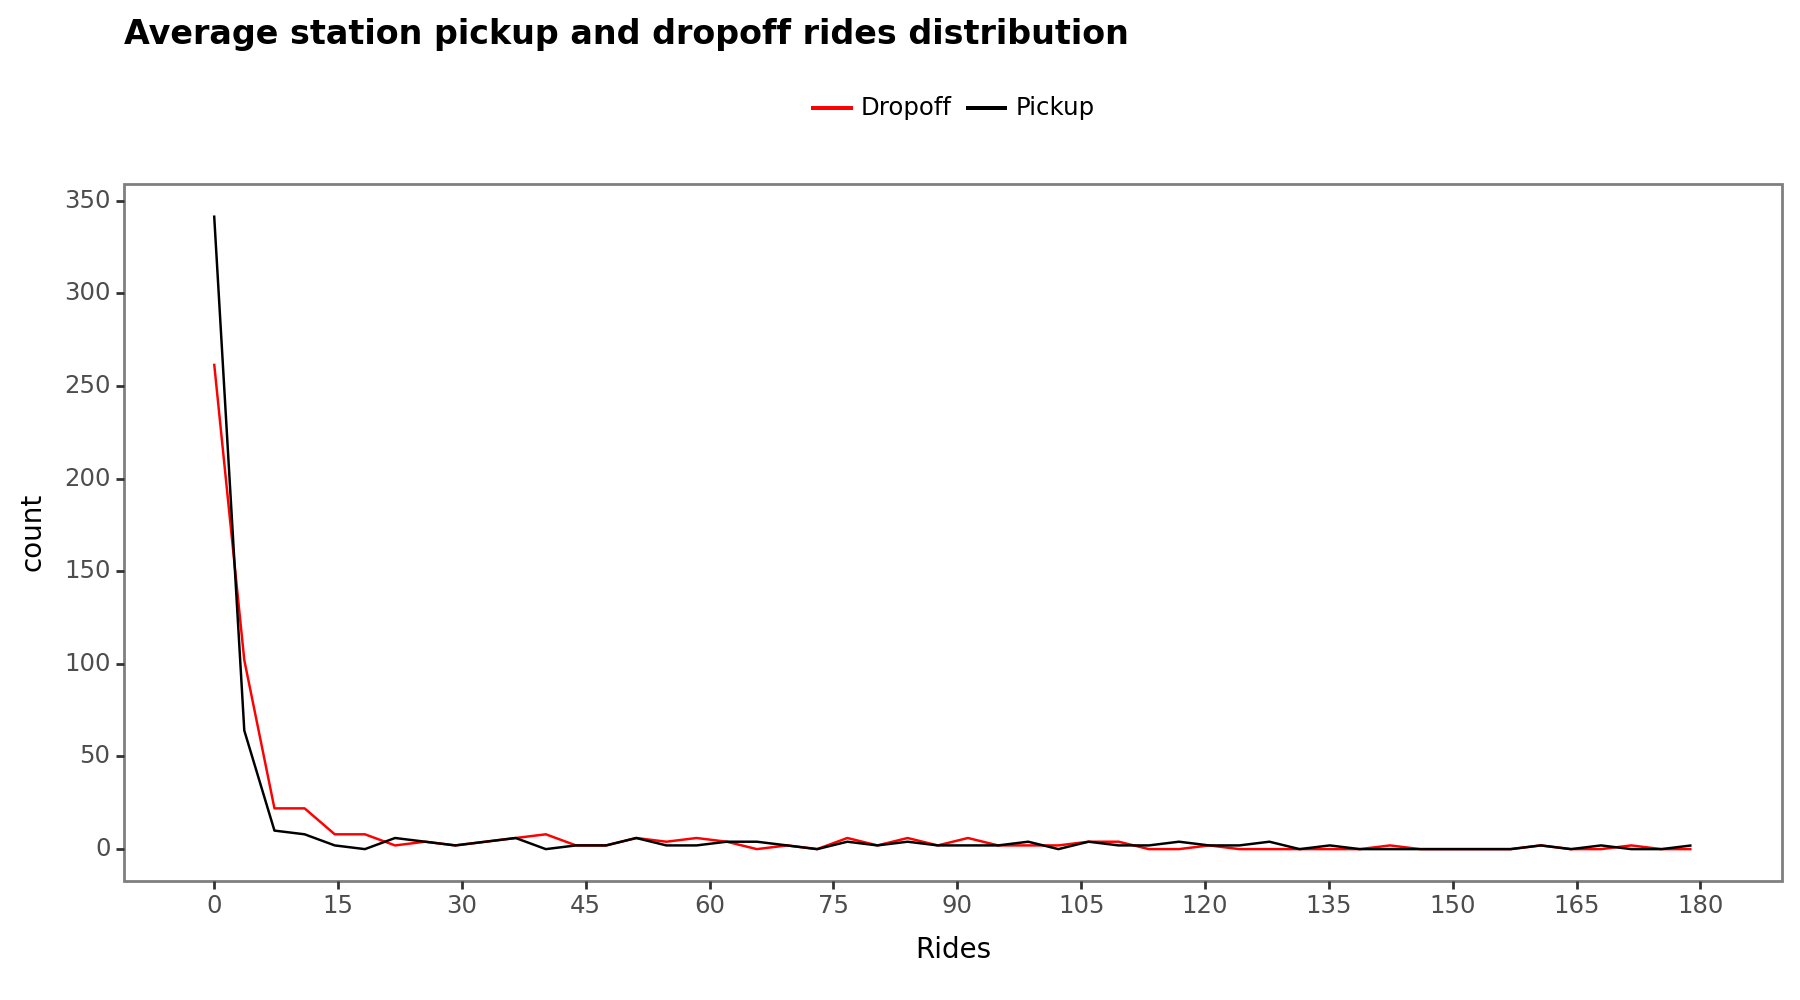

<Figure Size: (900 x 500)>

In [93]:
(
    pn.ggplot(df, pn.aes(x='avg_rides', color='avg_type')) +
    pn.geom_freqpoly(bins=50) +
    pn.theme_bw() +
    pn.theme(figure_size=(9,5),
             legend_position='top',
             legend_key_size=15,
             legend_key=pn.element_blank(),
             legend_title=pn.element_blank(),
             axis_title=pn.element_text(size=10),
             panel_grid=pn.element_blank(),
             strip_text=pn.element_text(size=10, color='white', weight='bold'),
             strip_background=pn.element_rect(fill='steelblue'),
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.scale_color_manual(values=['red', 'black'], labels=['Dropoff', 'Pickup']) + 
    pn.scale_x_continuous(breaks=range(0,200,15)) +
    pn.scale_y_continuous(breaks=range(0,400,50)) +
    pn.labs(title='Average station pickup and dropoff rides distribution', x='Rides')
)

#### Top and least 10 pickup stations by ride volume

In [94]:
# top 10 and least 10 pickup stations by ride volume
top10 = station_rides.nlargest(10, 'total_pickup_rides')

least10 = station_rides.nsmallest(10, 'total_pickup_rides')

- ___Top 10 pickup station___

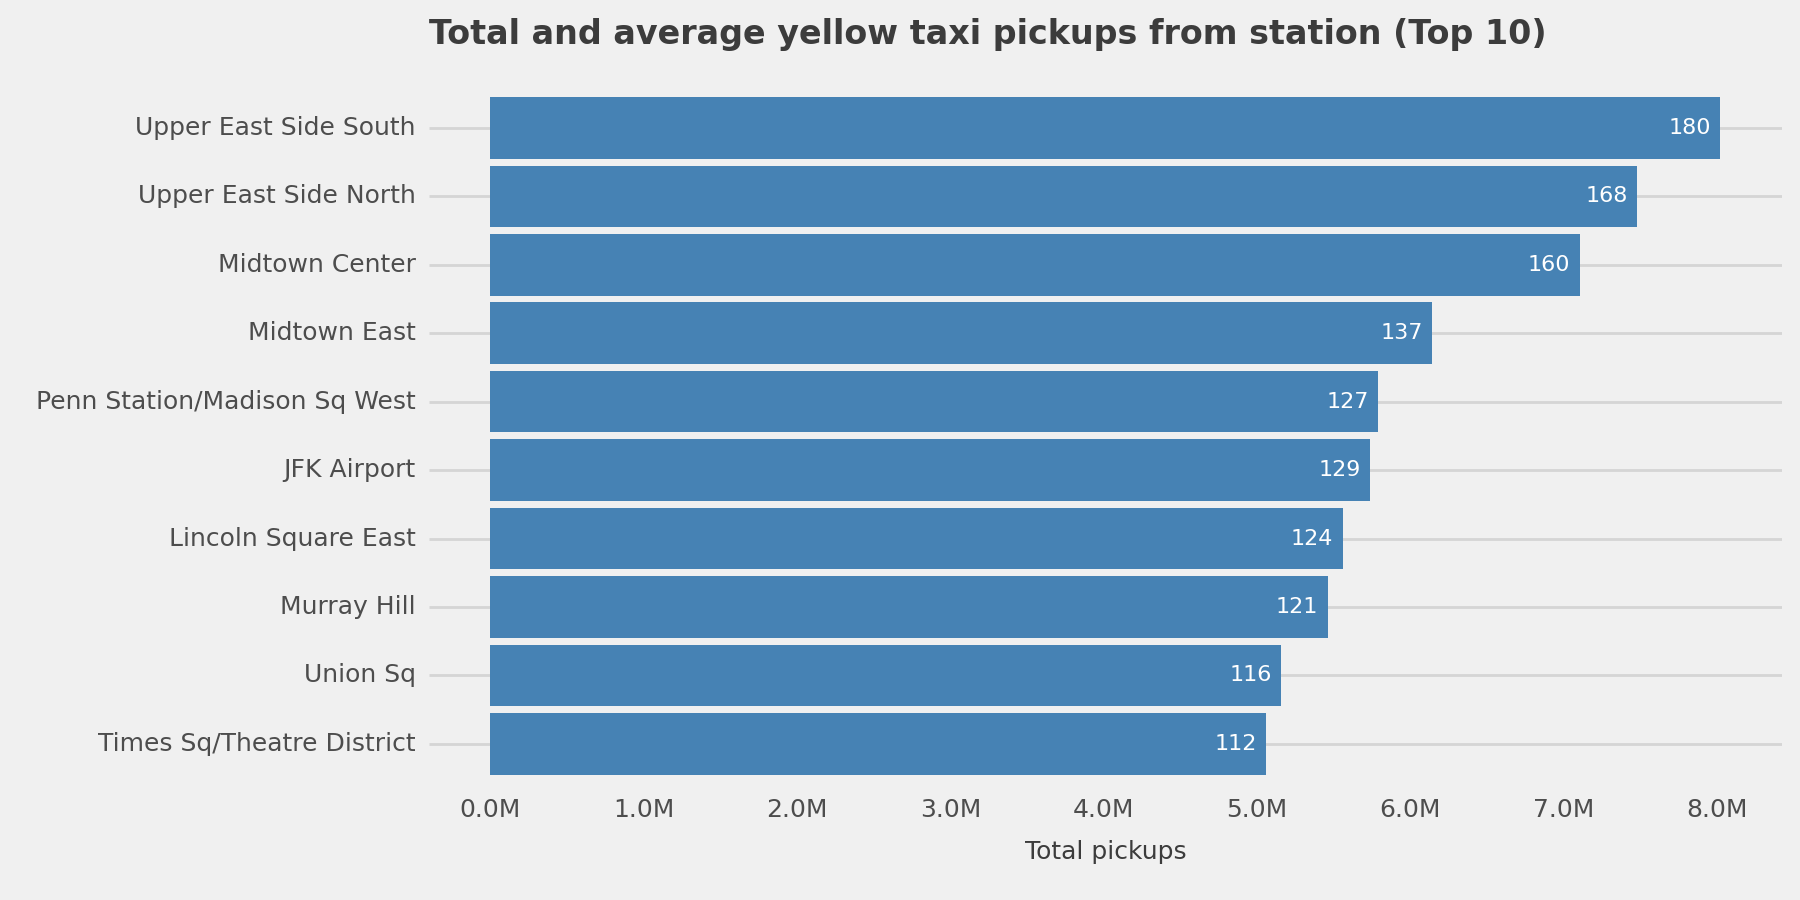

<Figure Size: (900 x 450)>

In [95]:
(
    pn.ggplot(top10, pn.aes('reorder(factor(pickup_station), total_pickup_rides)', 
                            'total_pickup_rides/1e6'))  +
    pn.geom_col(fill='steelblue') +
    pn.geom_text(pn.aes(label='avg_pickup_rides'), format_string='{:,.0f}', 
                 size=8, nudge_y=-0.2, color='white', fontweight=10) +
    pn.theme_538() +
    pn.theme(figure_size=(9,4.5),
             axis_text=pn.element_text(size=9),
             axis_title_x=pn.element_text(size=9),
             panel_grid_major_x=pn.element_blank(),
             plot_title=pn.element_text(size=12, weight='bold')) +
    pn.scale_y_continuous(breaks=range(0,10,1), 
                          labels=mfmt.custom_format(fmt='{:.1f}M'))+
    pn.coord_flip() +
    pn.labs(x='', y='Total pickups') +
    pn.ggtitle(title='Total and average yellow taxi pickups from station (Top 10)') +
    pn.scale_x_discrete(labels=top10.zone.tolist()[::-1])
)

- Pickup stations located in the Upper East Side (North and south) and Midtown (center and east) are in the top four stations where yellow taxis are highly demanded. This is followed by terminals at Madison square west, JFK aiport, Lincoln square east, Murray hill, Union square and Times square/Theatre district
- The top 10 terminals have total pickups above 5 million from 2019 till present, with more than 100 taxi pickups per hour, on average.

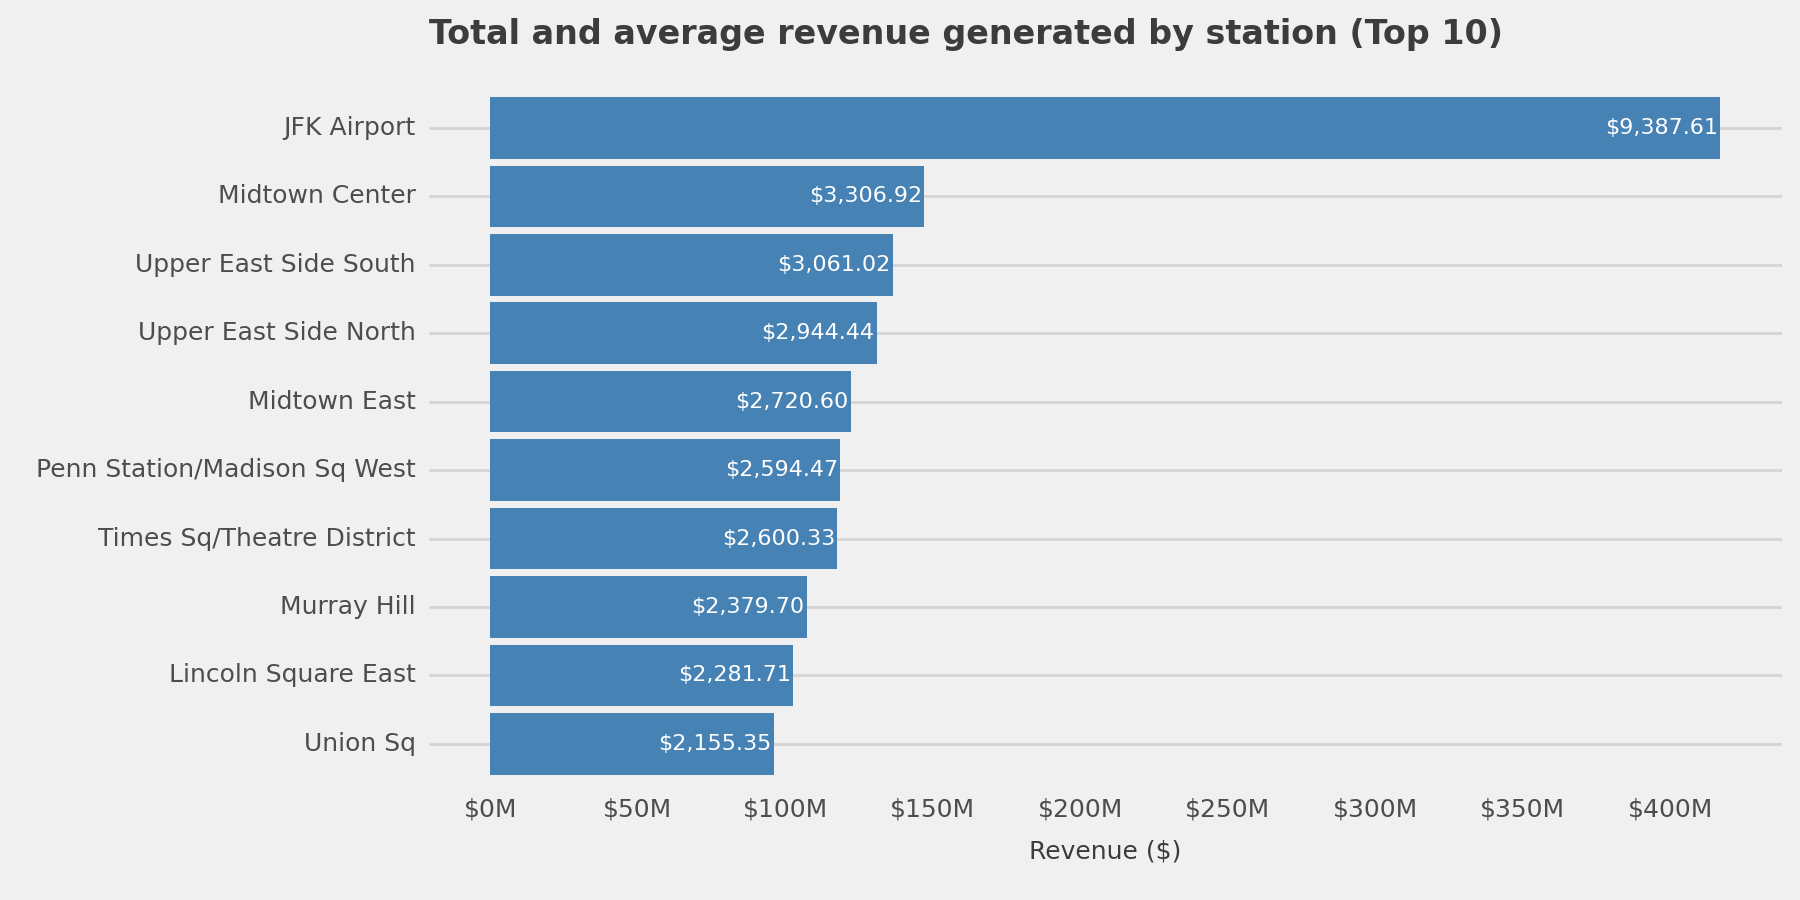

<Figure Size: (900 x 450)>

In [96]:
(
    pn.ggplot(top10, pn.aes('reorder(zone, total_revenue)', 'total_revenue/1e6'))  +
    pn.geom_col(fill='steelblue') +
    pn.geom_text(pn.aes(label='avg_revenue'), format_string='${:,.2f}', 
                 size=8, nudge_y=-20, color='white', fontweight=10) +
    pn.theme_538() +
    pn.theme(figure_size=(9,4.5),
             axis_text=pn.element_text(size=9),
             axis_title_x=pn.element_text(size=9),
             panel_grid_major_x=pn.element_blank(),
             plot_title=pn.element_text(size=12, weight='bold')) +
    pn.scale_y_continuous(breaks=range(0,450,50), 
                          labels=mfmt.custom_format(fmt='${:.0f}M'))+
    pn.coord_flip() +
    pn.labs(x='', y='Revenue ($)') +
    pn.ggtitle(title='Total and average revenue generated by station (Top 10)')
)

Next we looked at the total and average revenue generated by these top 10 terminals. 
- More revenues are generated from trips originating from the station at JFK airport, with a total of about 400 million dollars generated in revenue between Jan 2019 till Mar 2024. This translates to over 9,300 dollars generated in revenue per hour. This makes JFK airport station the top revenue earner.
- For the other 9 top stations by taxi demand, the amount of money generated in revenue from 2019 till present is less than 150 million dollars on average, with less than 3,500 dollars generated per hour.
- Allocating more taxis at these locations would be beneficial to meet up with the demand.

- ___Least 10 pickup stations___

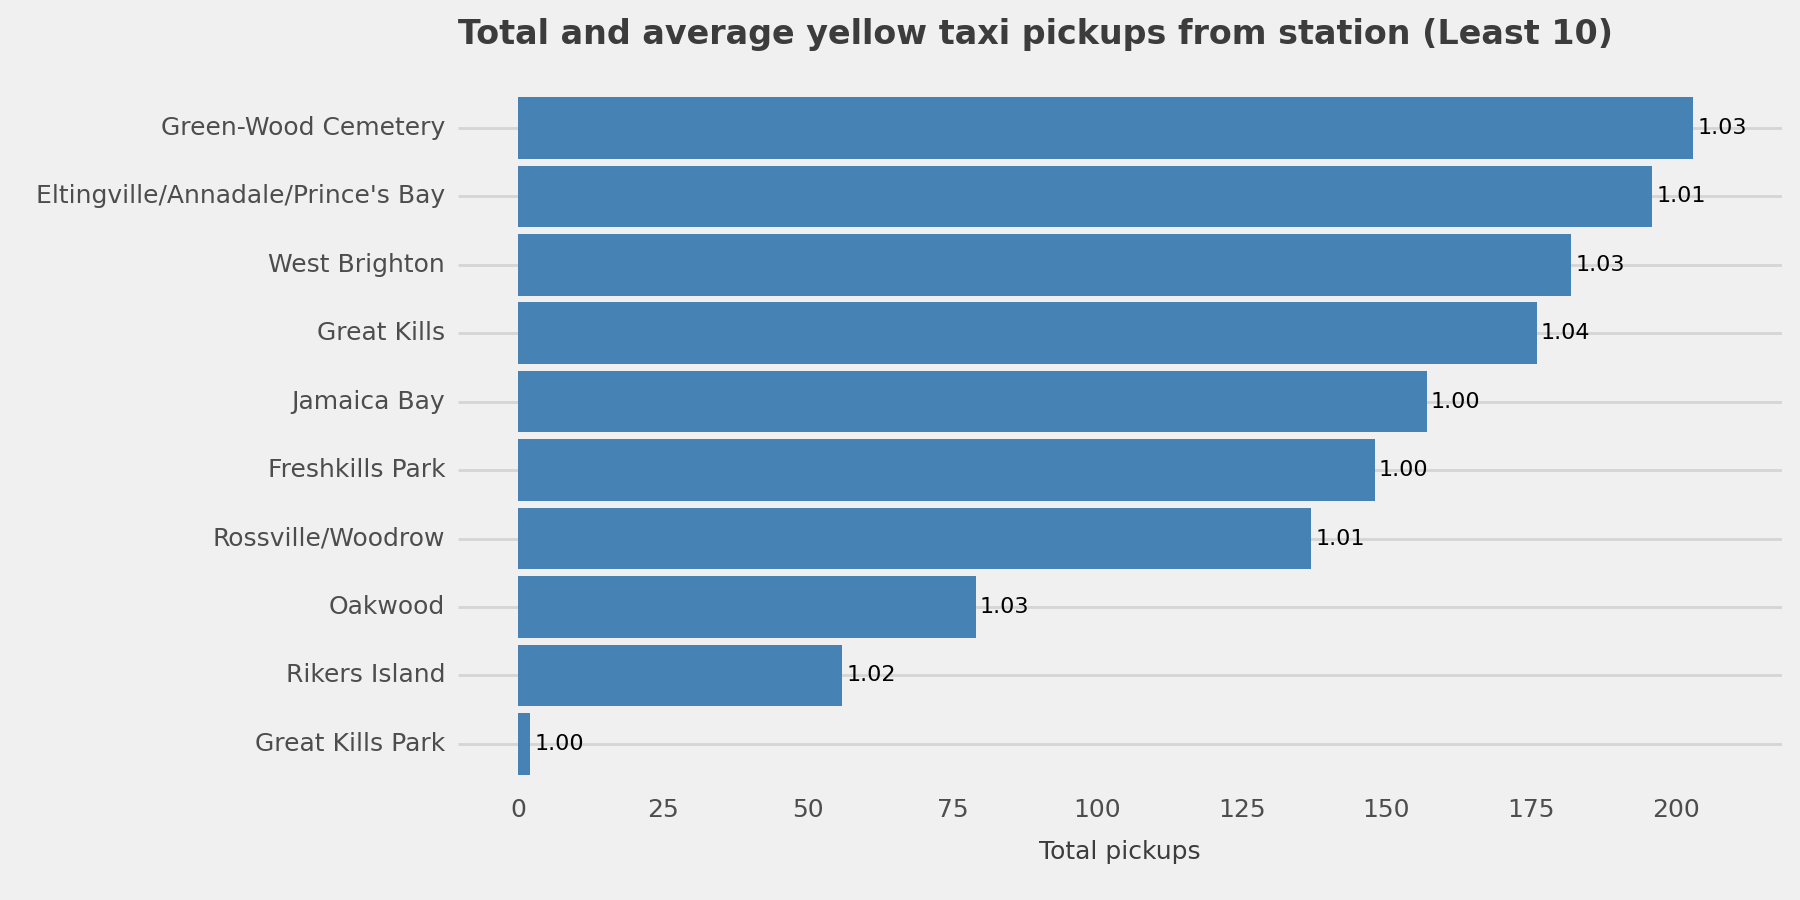

<Figure Size: (900 x 450)>

In [97]:
(
    pn.ggplot(least10, pn.aes('reorder(factor(pickup_station), total_pickup_rides)', 
                              'total_pickup_rides'))  +
    pn.geom_col(fill='steelblue') +
    pn.geom_text(pn.aes(label='avg_pickup_rides'), format_string='{:.2f}', 
                 size=8, color='black', nudge_y=5, va='center' ) +
    pn.theme_538() +
    pn.theme(figure_size=(9,4.5),
             axis_text=pn.element_text(size=9),
             axis_title_x=pn.element_text(size=9),
             panel_grid_major_x=pn.element_blank(),
             plot_title=pn.element_text(size=12, weight='bold')) +
    pn.scale_y_continuous(breaks=range(0,250,25), 
                          labels=mfmt.comma_format(digits=0))+
    pn.coord_flip() +
    pn.labs(x='', y='Total pickups') +
    pn.ggtitle(title='Total and average yellow taxi pickups from station (Least 10)') +
    pn.scale_x_discrete(labels=least10.zone.tolist())
)

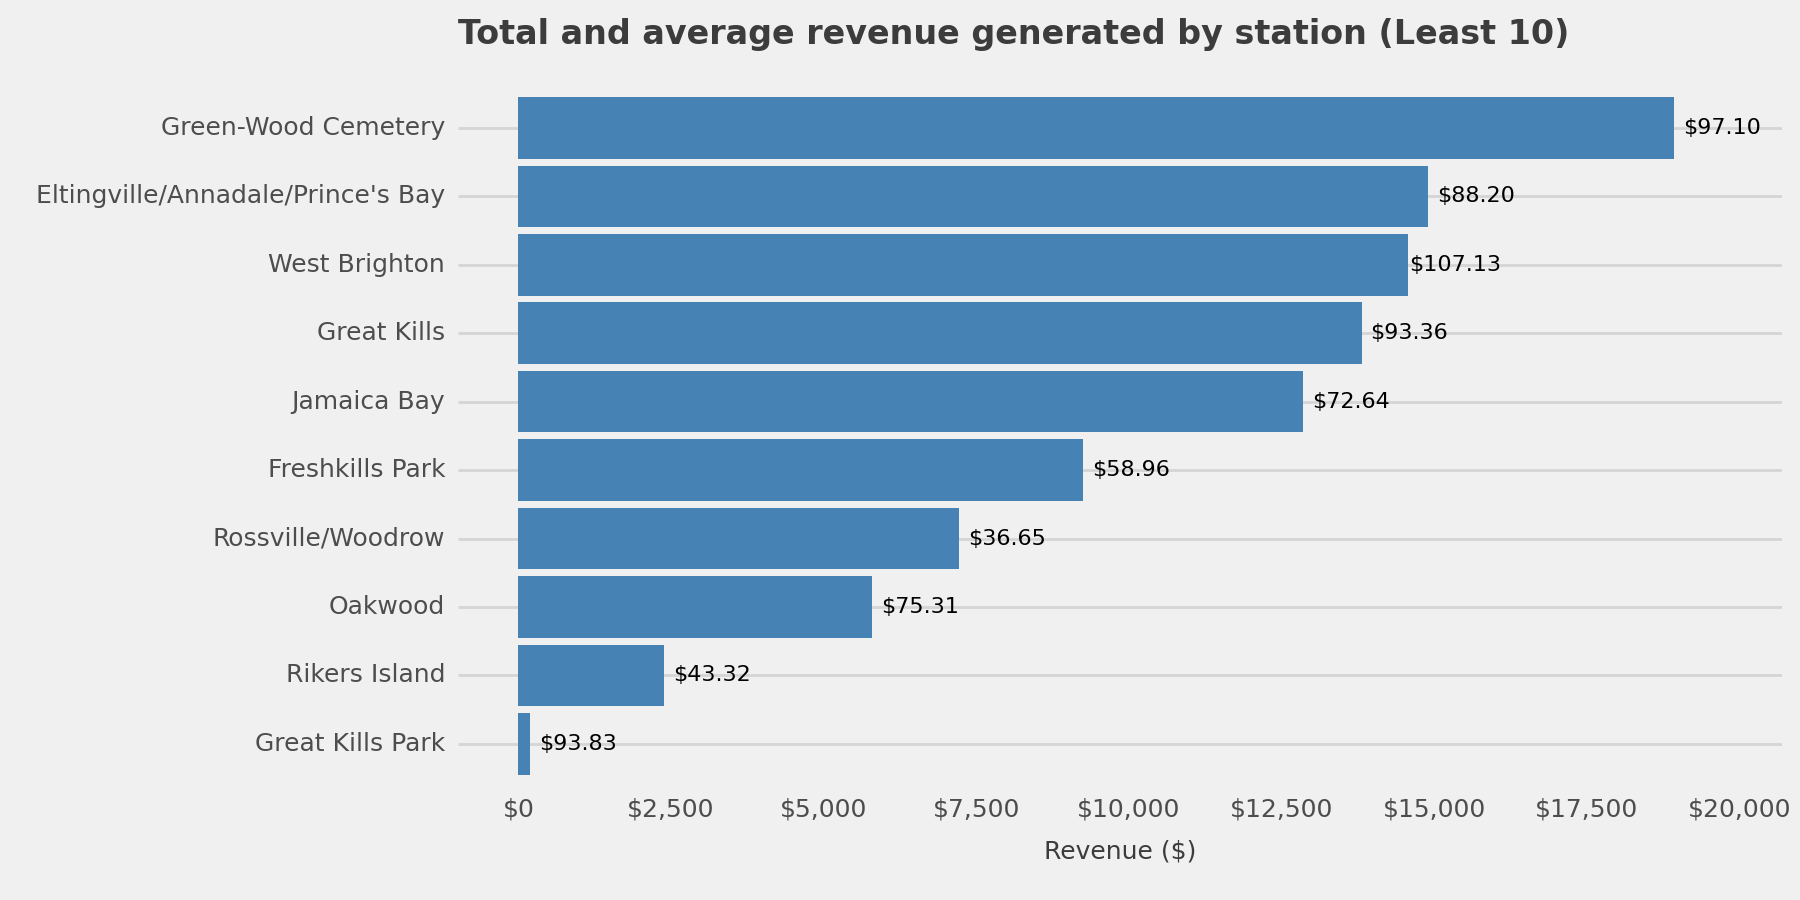

<Figure Size: (900 x 450)>

In [98]:
(
    pn.ggplot(least10, pn.aes('reorder(zone, total_revenue)', 'total_revenue'))  +
    pn.geom_col(fill='steelblue') +
    pn.geom_text(pn.aes(label='avg_revenue'), format_string='${:,.2f}', 
                 size=8, color='black', fontweight=10, nudge_y=780) +
    pn.theme_538() +
    pn.theme(figure_size=(9,4.5),
             axis_text=pn.element_text(size=9),
             axis_title_x=pn.element_text(size=9),
             panel_grid_major_x=pn.element_blank(),
             plot_title=pn.element_text(size=12, weight='bold')) +
    pn.scale_y_continuous(breaks=range(0,21000,2500), 
                          labels=mfmt.dollar_format(digits=0, big_mark=','))+
    pn.coord_flip() +
    pn.labs(x='', y='Revenue ($)') +
    pn.ggtitle(title='Total and average revenue generated by station (Least 10)') +
    pn.scale_x_discrete(labels=least10.zone.tolist())
)

#### Top and least 10 dropoff stations by ride volume

Here, we will investigate stations where customers hire taxis to. To do that, we will select the top and least 10 dropoff stations

In [99]:
# top 10 and least 10 dropoff stations by ride volume
top10 = station_rides.nlargest(10, 'total_dropoff_rides')

least10 = station_rides.nsmallest(10, 'total_dropoff_rides')

- ___Top 10 dropoff station___

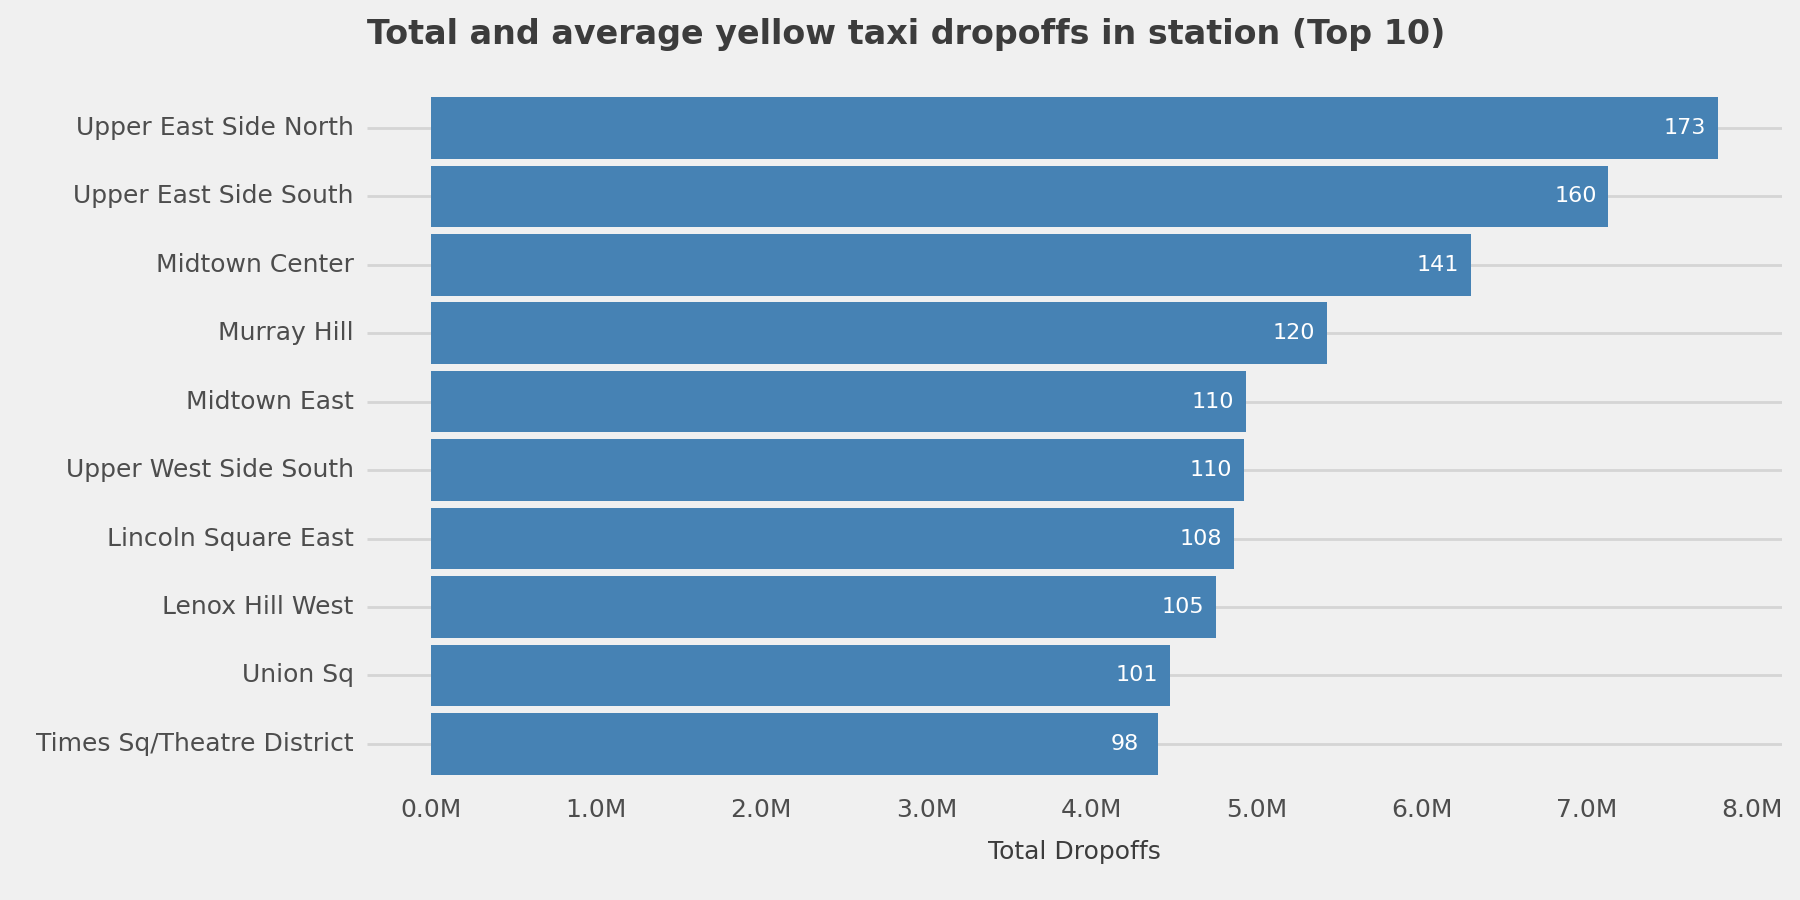

<Figure Size: (900 x 450)>

In [100]:
(
    pn.ggplot(top10, pn.aes('reorder(factor(pickup_station), total_dropoff_rides)', 
                            'total_dropoff_rides/1e6'))  +
    pn.geom_col(fill='steelblue') +
    pn.geom_text(pn.aes(label='avg_dropoff_rides'), format_string='{:,.0f}', 
                 size=8, nudge_y=-0.2, color='white', fontweight=10) +
    pn.theme_538() +
    pn.theme(figure_size=(9,4.5),
             axis_text=pn.element_text(size=9),
             axis_title_x=pn.element_text(size=9),
             panel_grid_major_x=pn.element_blank(),
             plot_title=pn.element_text(size=12, weight='bold')) +
    pn.scale_y_continuous(breaks=range(0,10,1), 
                          labels=mfmt.custom_format(fmt='{:.1f}M'))+
    pn.coord_flip() +
    pn.labs(x='', y='Total Dropoffs') +
    pn.ggtitle(title='Total and average yellow taxi dropoffs in station (Top 10)') +
    pn.scale_x_discrete(labels=top10.zone.tolist()[::-1])
)

- ___Least 10 pickup stations___

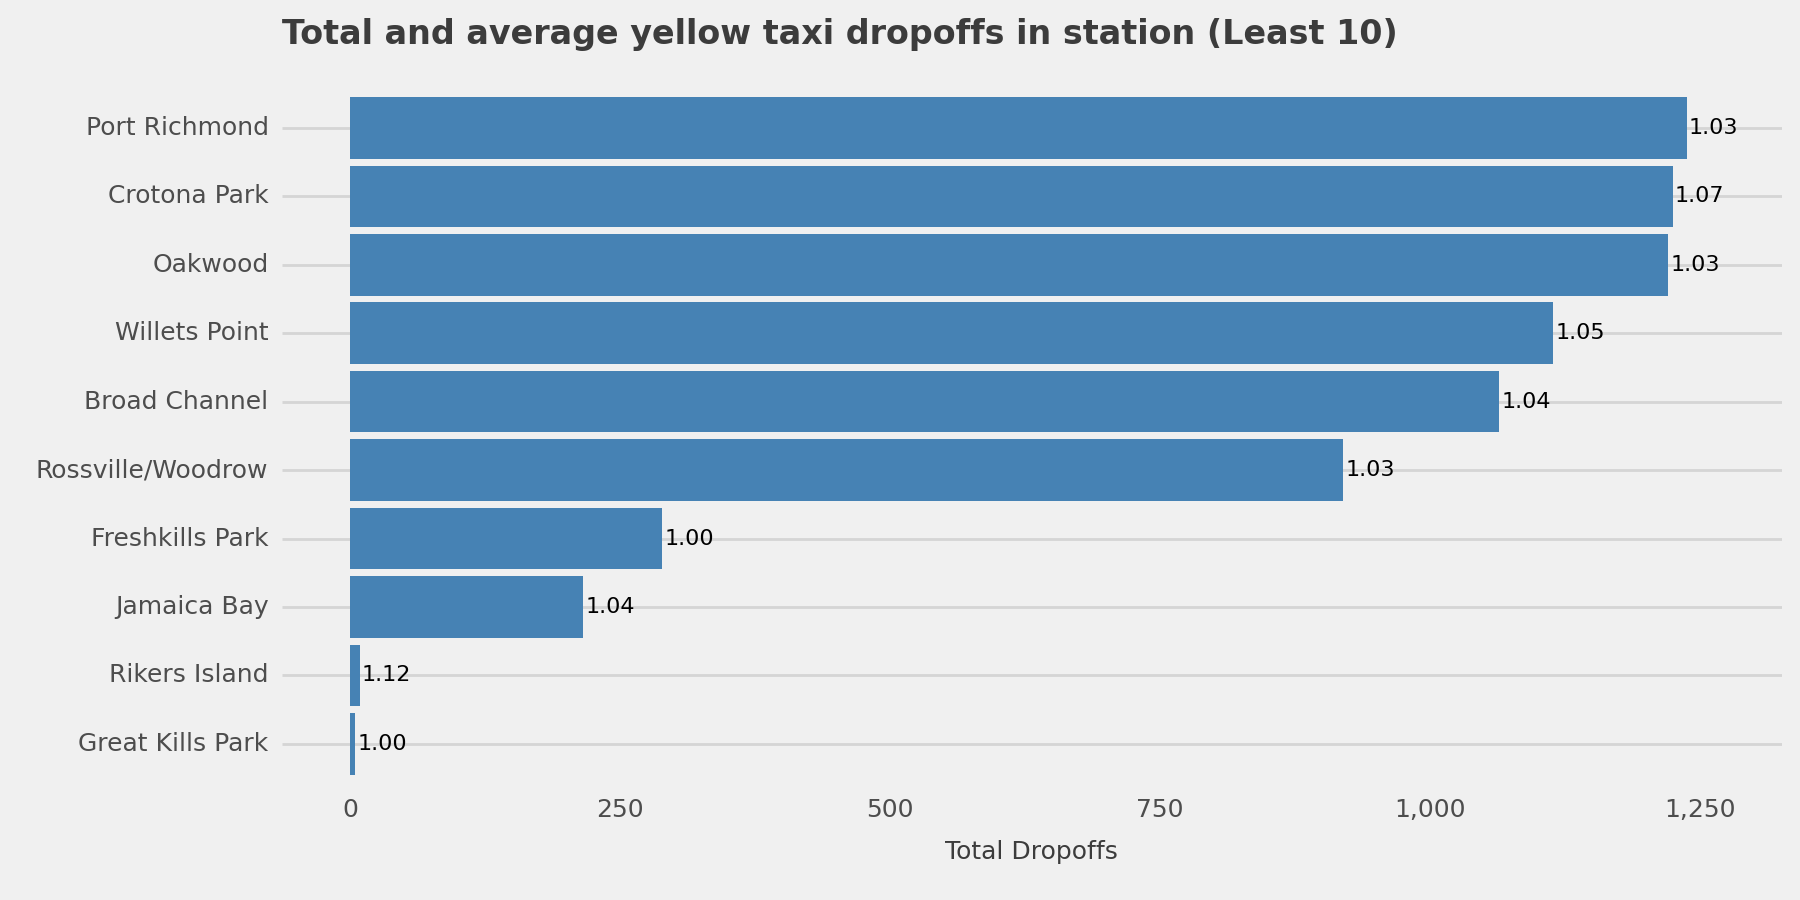

<Figure Size: (900 x 450)>

In [101]:
(
    pn.ggplot(least10, pn.aes('reorder(factor(pickup_station), total_dropoff_rides)', 
                              'total_dropoff_rides'))  +
    pn.geom_col(fill='steelblue') +
    pn.geom_text(pn.aes(label='avg_dropoff_rides'), format_string='{:.2f}', 
                 size=8, color='black', nudge_y=25, va='center' ) +
    pn.theme_538() +
    pn.theme(figure_size=(9,4.5),
             axis_text=pn.element_text(size=9),
             axis_title_x=pn.element_text(size=9),
             panel_grid_major_x=pn.element_blank(),
             plot_title=pn.element_text(size=12, weight='bold')) +
    pn.scale_y_continuous(breaks=range(0,1400,250), 
                          labels=mfmt.comma_format(digits=0))+
    pn.coord_flip() +
    pn.labs(x='', y='Total Dropoffs') +
    pn.ggtitle(title='Total and average yellow taxi dropoffs in station (Least 10)') +
    pn.scale_x_discrete(labels=least10.zone.tolist())
)

#### Top and least 10 pickup stations in each borough (town) by ride volume

In [102]:
# number of stations in each borough
station_rides.groupby('borough').pickup_station.count().sort_values()

borough
EWR               1
Staten Island    20
Bronx            43
Brooklyn         61
Manhattan        66
Queens           69
Name: pickup_station, dtype: int64

- EWR has only one station in it. We will take it into consideration while showing the top and least n stations

In [104]:
top10_borough = station_rides.groupby('borough').apply(lambda x: x.nlargest(10, 'total_pickup_rides'), include_groups=False)
least10_borough = station_rides.groupby('borough').apply(lambda x: x.nsmallest(10, 'total_pickup_rides'), include_groups=False)

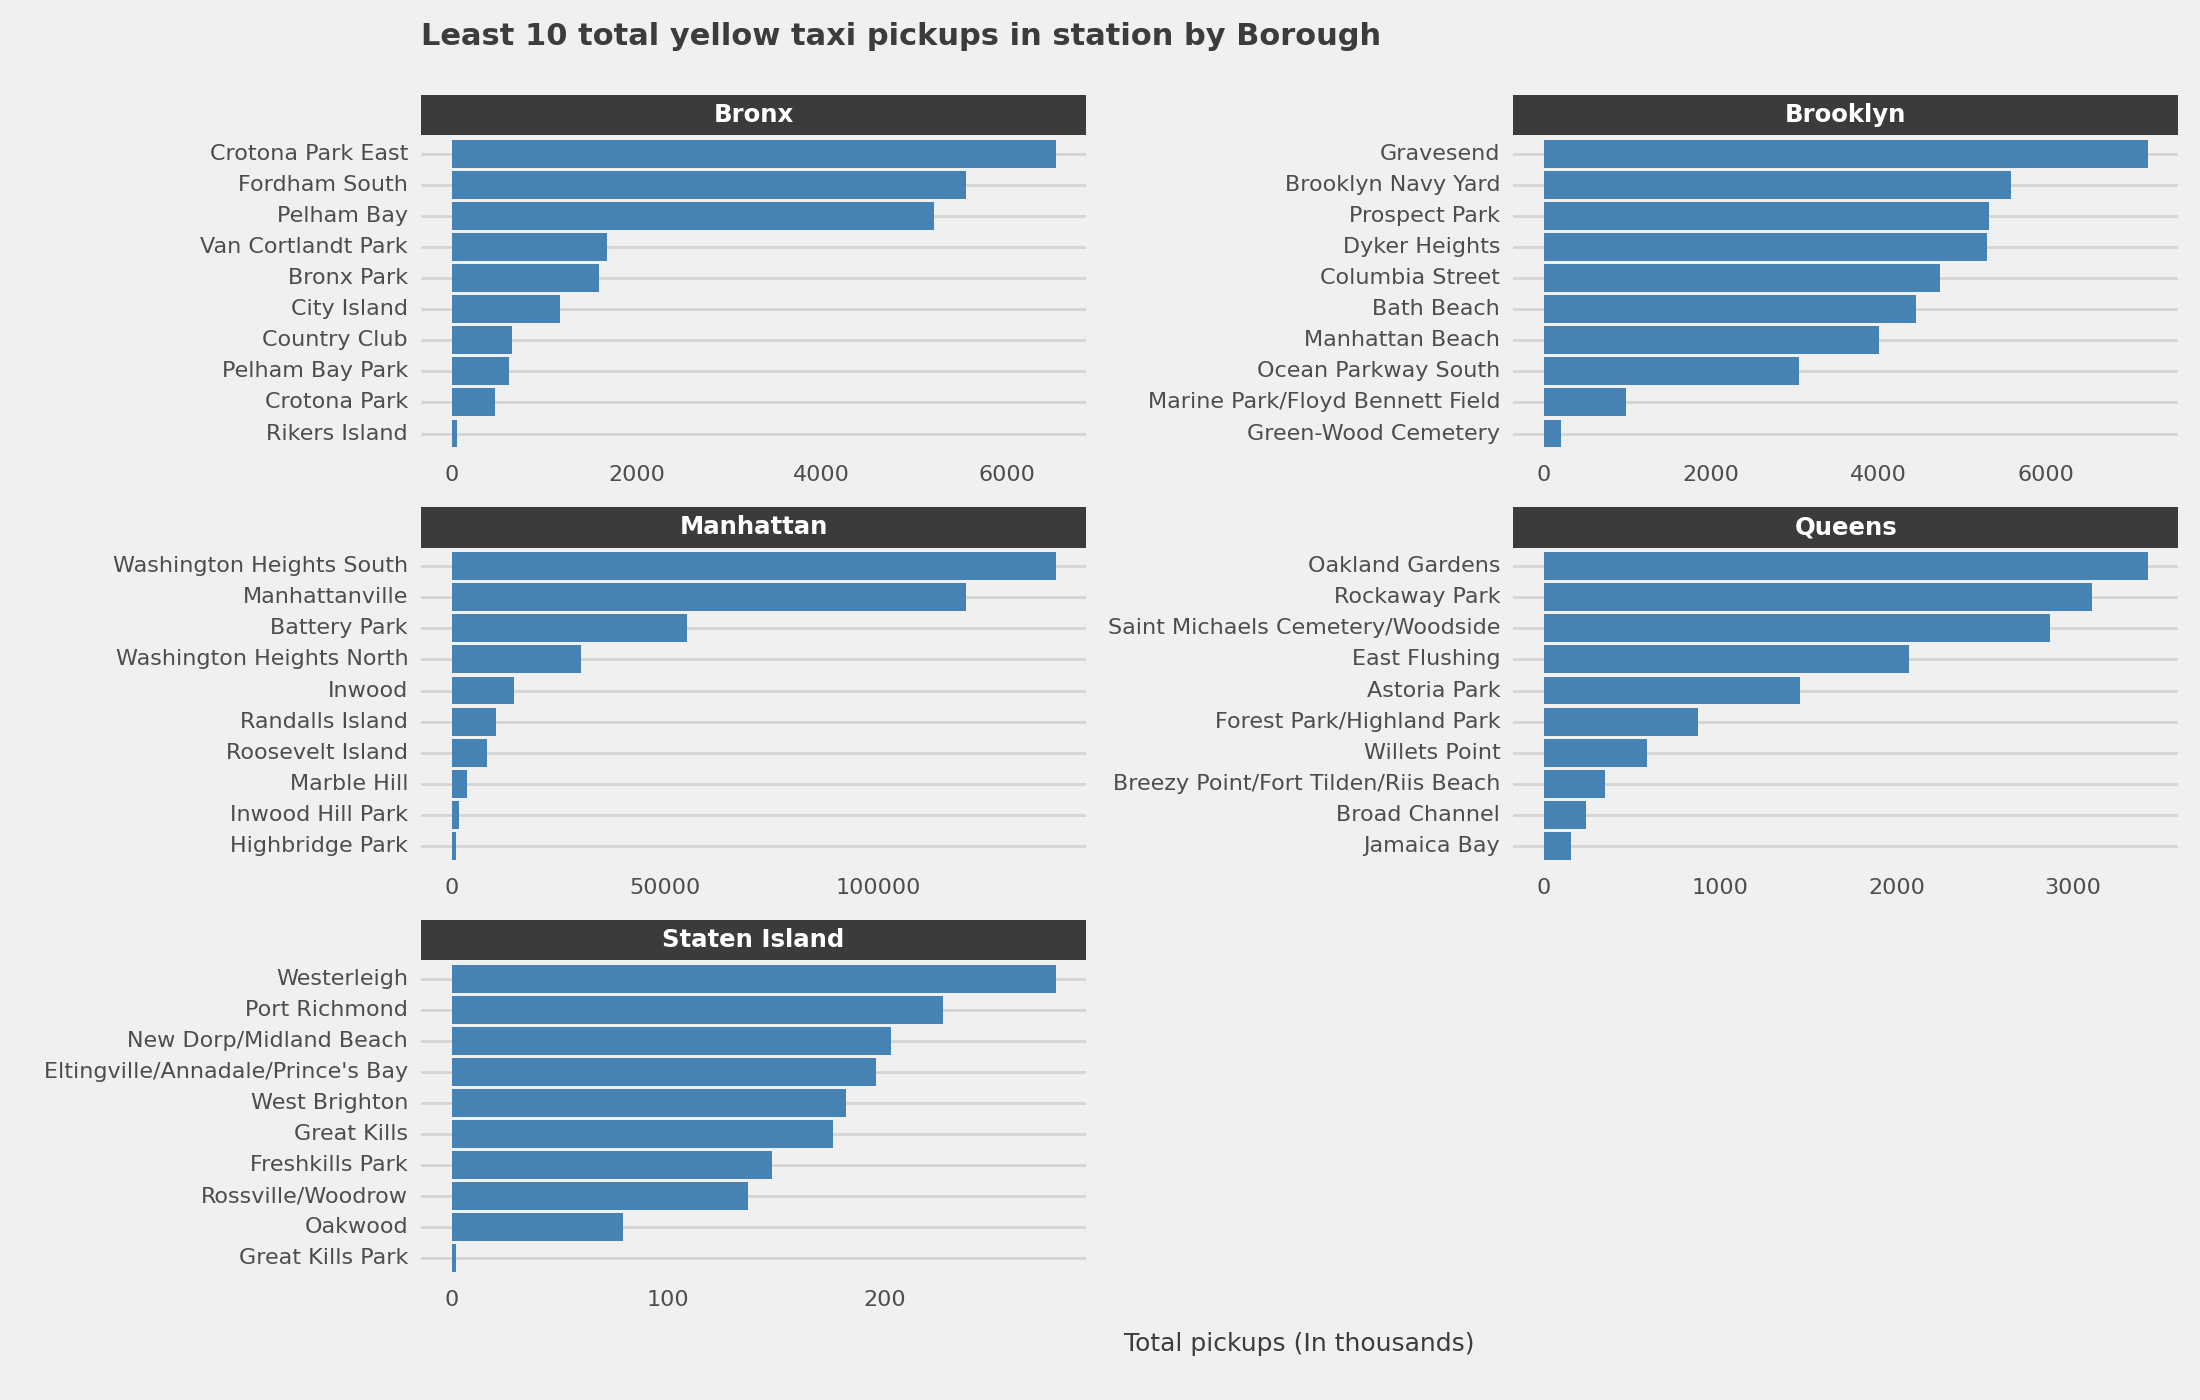

<Figure Size: (1100 x 700)>

In [105]:
(
    pn.ggplot(least10_borough.query('borough != "EWR"'), 
              pn.aes('reorder(zone, total_pickup_rides)', 
                     'total_pickup_rides'))  +
    pn.geom_col(fill='steelblue') +
    pn.facet_wrap('~borough', scales='free', ncol=2) +
    pn.theme_538() +
    pn.theme(figure_size=(11,7),
             legend_position='none',
             axis_text=pn.element_text(size=8),
             axis_title_x=pn.element_text(size=9),
             strip_text=pn.element_text(weight='bold', color='white'),
             strip_background=pn.element_rect(fill='black', alpha=0.5),
             panel_grid_major_x=pn.element_blank(),
             plot_title=pn.element_text(size=11, weight='bold')) +
    pn.scale_y_continuous(labels=mfmt.custom_format('{:,.0f}')) + 
    pn.coord_flip() +
    pn.labs(x='', y='Total pickups (In thousands)') +
    pn.ggtitle(title='Least 10 total yellow taxi pickups in station by Borough') 
)

- The least 5 stations by total pickups in each borough are mostly stations that lead to tourist sites, cemetries, parks, beaches, bays etc.

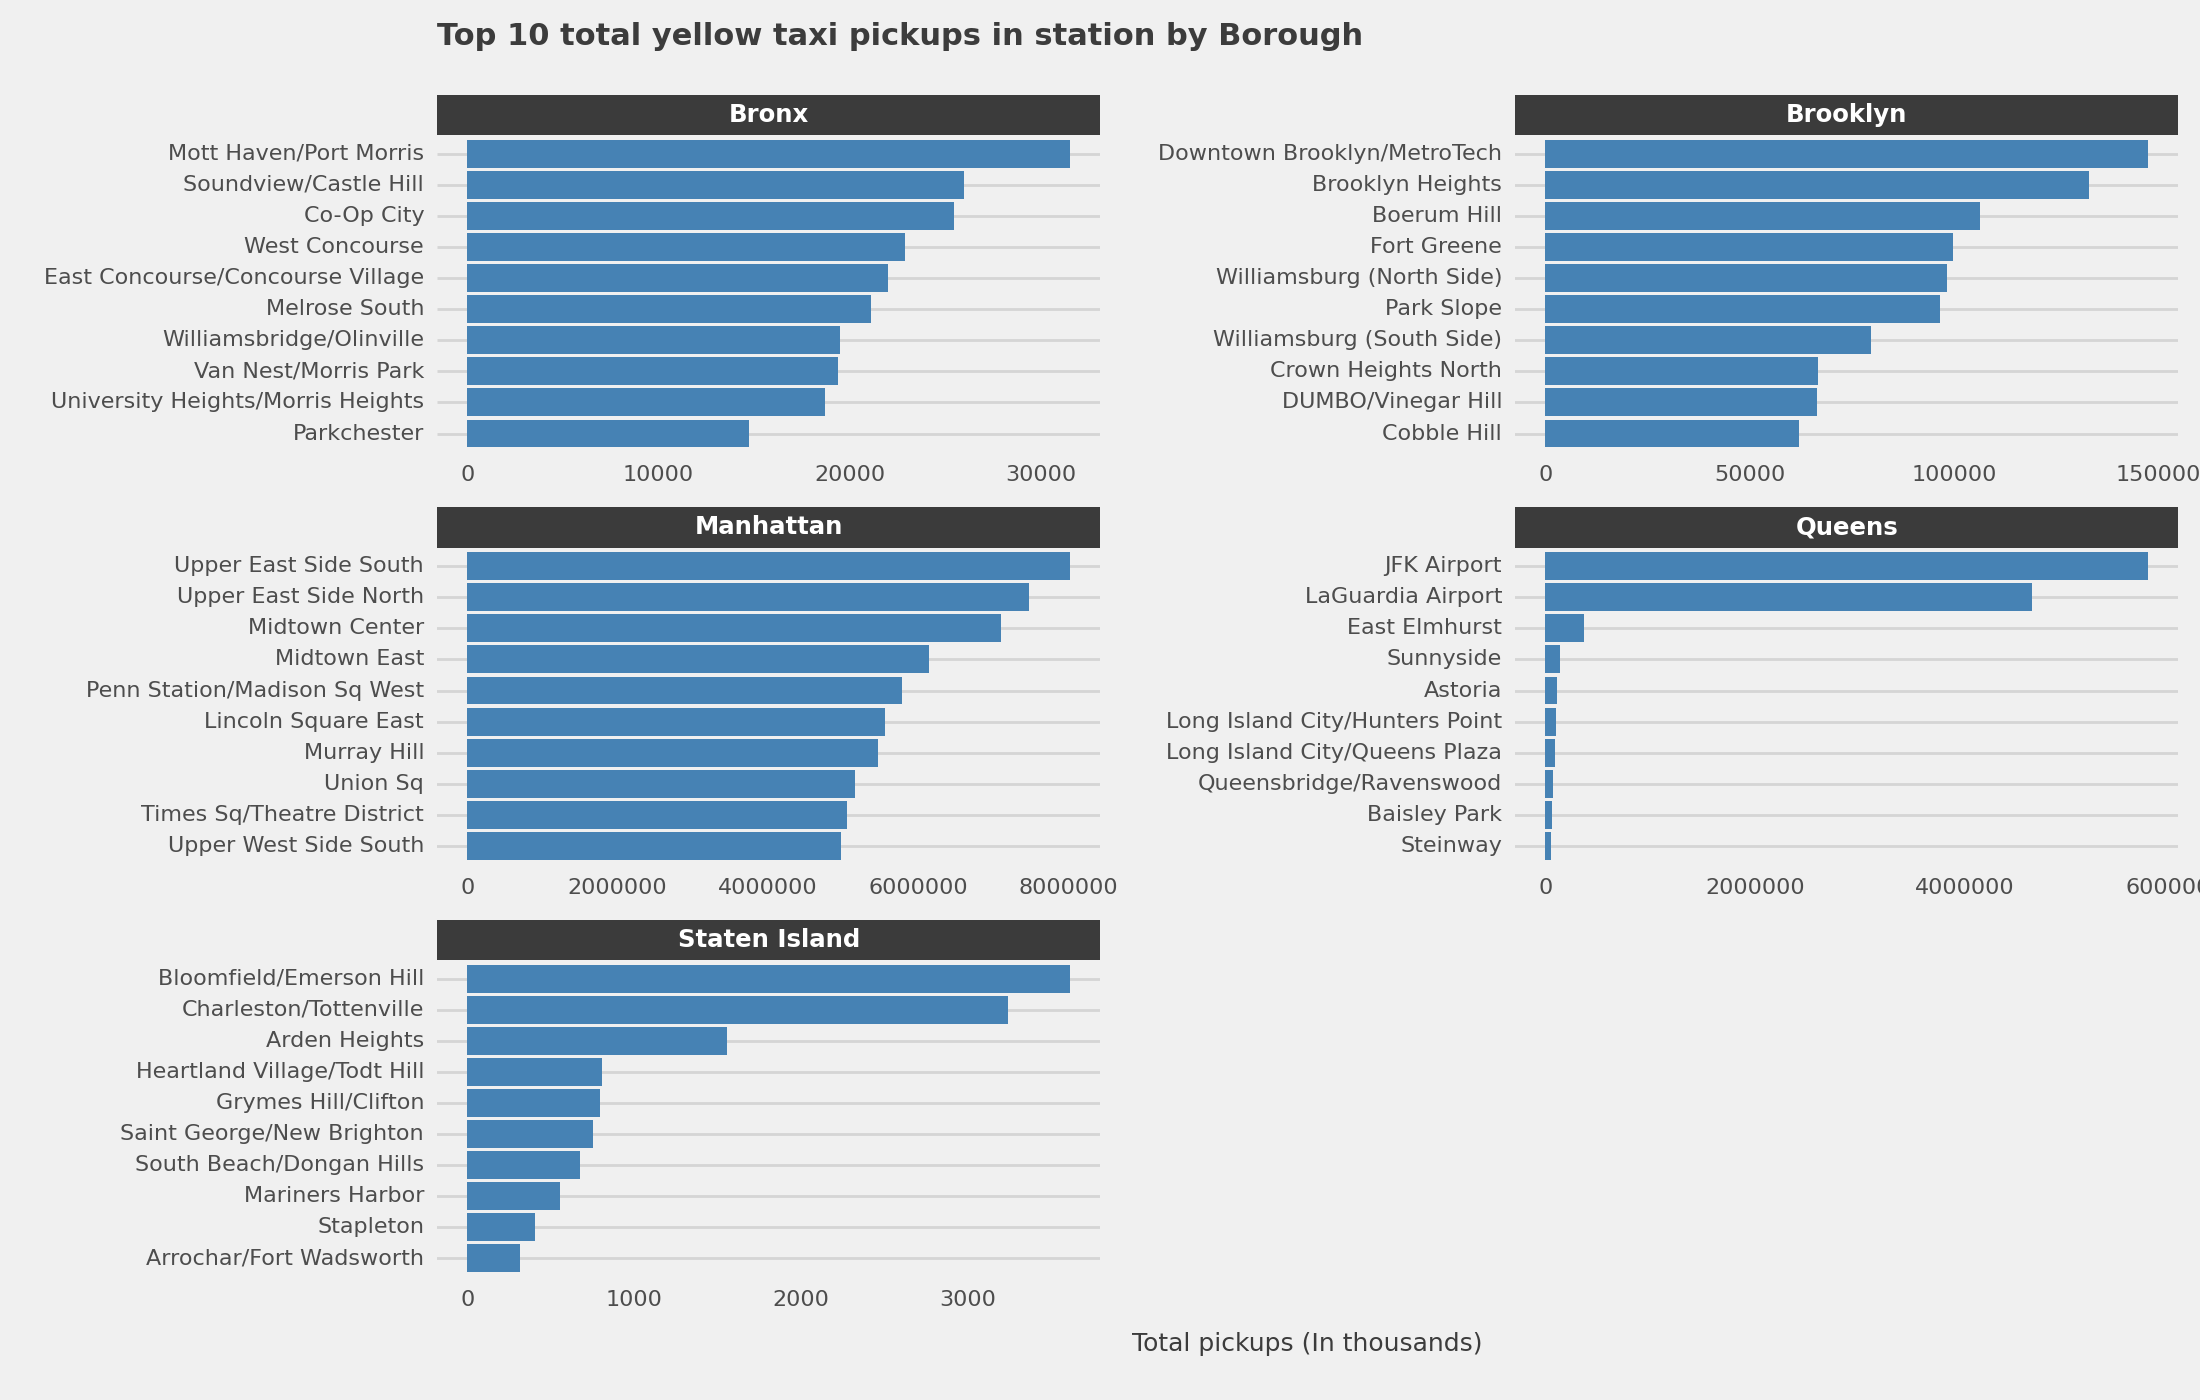

<Figure Size: (1100 x 700)>

In [106]:
(
    pn.ggplot(top10_borough.query('borough != "EWR"'), 
              pn.aes('reorder(zone, total_pickup_rides)', 
                     'total_pickup_rides'))  +
    pn.geom_col(fill='steelblue') +
    pn.facet_wrap('~borough', scales='free', ncol=2) +
    pn.theme_538() +
    pn.theme(figure_size=(11,7),
             legend_position='none',
             axis_text=pn.element_text(size=8),
             axis_title_x=pn.element_text(size=9),
             strip_text=pn.element_text(weight='bold', color='white'),
             strip_background=pn.element_rect(fill='black', alpha=0.5),
             panel_grid_major_x=pn.element_blank(),
             plot_title=pn.element_text(size=11, weight='bold')) +
    pn.scale_y_continuous(labels=mfmt.custom_format('{:,.0f}')) + 
    pn.coord_flip() +
    pn.labs(x='', y='Total pickups (In thousands)') +
    pn.ggtitle(title='Top 10 total yellow taxi pickups in station by Borough') 
)

- The top 10 stations in Manhattan and two in Queens have over 2 million total pickups than any other station in other boroughs. The two stations at JFK and LaGuardia airports make up over 85% of the total pickups in Queens. 
- In Bronx, the top 2 are Mott Haven and Castle Hill. In Brooklyn are MetroTech and Brooklyn heights, Manhattan are Upper East Side South and North while in Staten Island, they are the stations are Emerson Hill and Tottenville.

**Percentage of dropoffs in stations**

Next, we will look at stations that have high percentage of taxis moving into them. Here, we summed the total number of taxis originating and departing the stations and derived the percentage of them that departed from the station

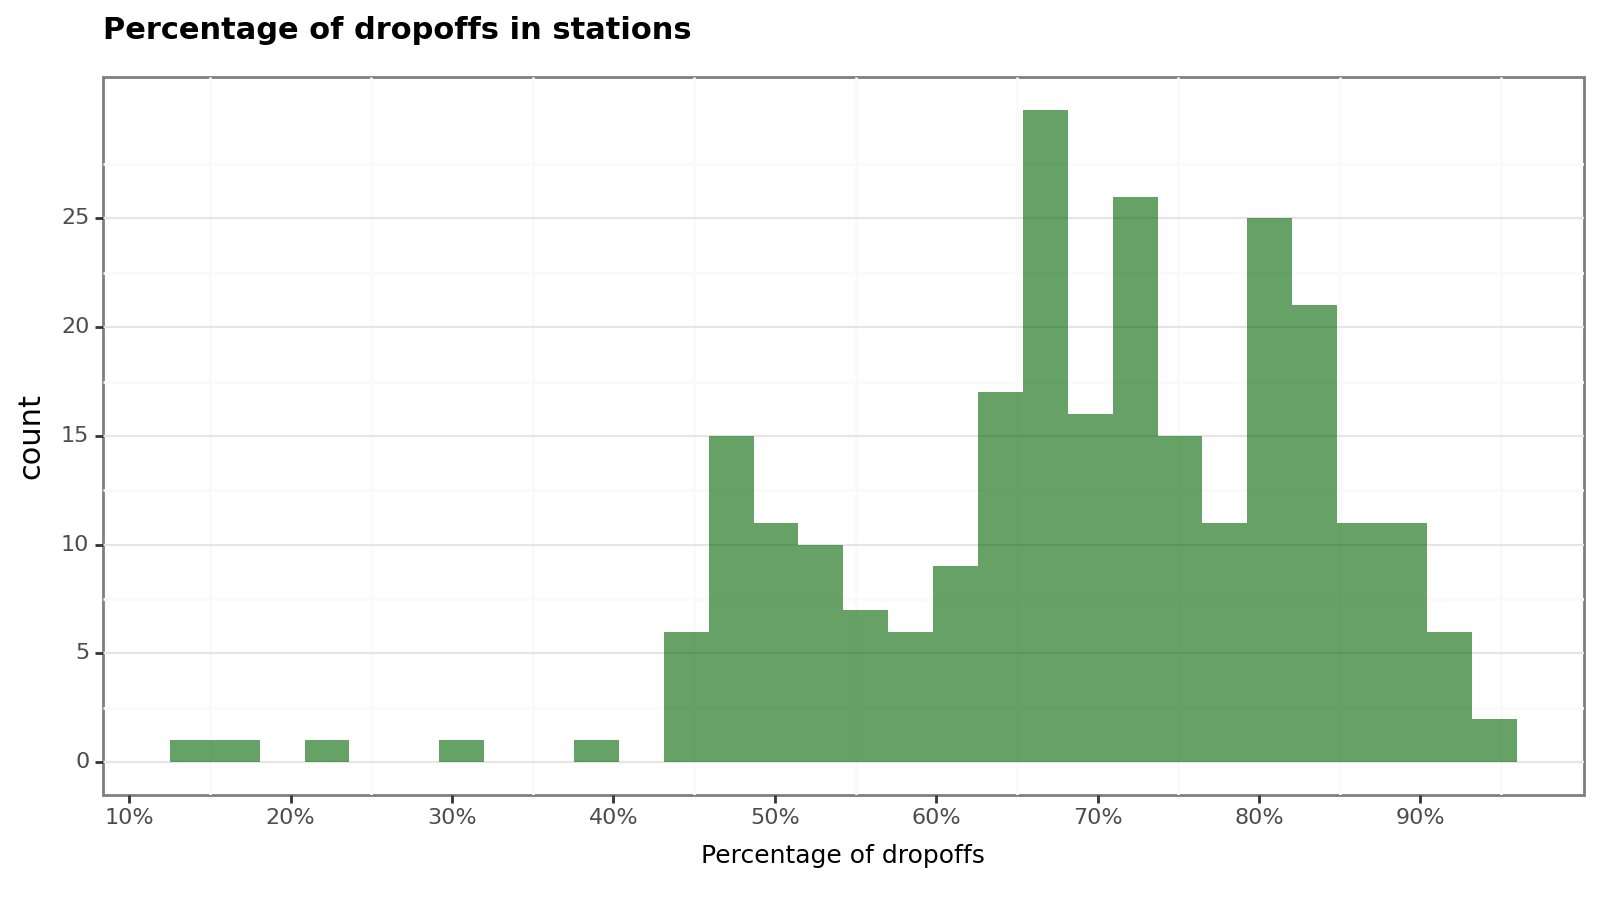

<Figure Size: (800 x 450)>

In [170]:
(
    pn.ggplot(station_rides, pn.aes(x='station_perc_dropoff')) +
    pn.geom_histogram(bins=30, fill='darkgreen', alpha=0.6) +
    pn.theme_bw() +
    pn.theme(figure_size=(8,4.5),
             axis_text=pn.element_text(size=8),
             axis_title_x=pn.element_text(size=9),
             panel_grid=pn.element_blank(),
             plot_title=pn.element_text(size=11, weight='bold')) +
    pn.scale_x_continuous(labels=mfmt.custom_format('{:.0f}%'), breaks=range(0,100,10)) + 
    pn.scale_y_continuous(breaks=range(0,35,5)) + 
    pn.labs(x='Percentage of dropoffs') +
    pn.ggtitle(title='Percentage of dropoffs in stations')
)

- There are more stations that have high percentage of taxis dropping off commuters into them (>60%). There are some with equal number of taxis arriving and exiting it (between 45 and 60%) and few of them have taxis arriving them (<40%)
- Next we will group these stations into three groups based on the percentage of dropoffs in them: Low (<45%), equal (45-60%) and high dropoffs (>60%)

In [174]:
def dropoff_bins(x):
    if x < 45: return 'D<P'
    elif 45 < x <= 60: return 'D=P'
    else: return 'D>P'

station_rides['dropoff_perc_group'] = station_rides.station_perc_dropoff.map(dropoff_bins)

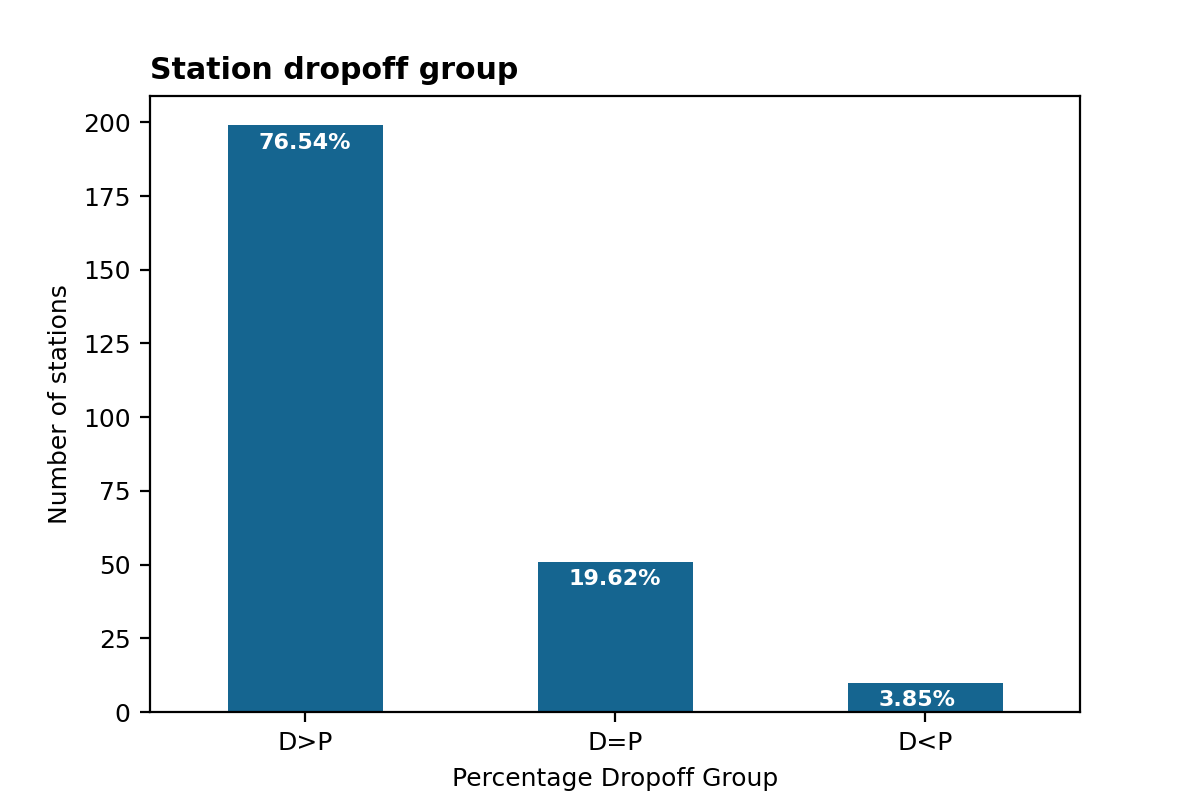

In [221]:
plt.figure(figsize=(6,4))
ax = sns.countplot(station_rides, x='dropoff_perc_group', width=0.5)
for i in ax.patches:
    perc = i.get_height()/len(station_rides)*100
    plt.text(i.get_x()+.1, i.get_height()-8, f"{perc:.2f}%", color='w', fontweight='bold', fontsize=8) 
plt.title('Station dropoff group', fontweight='bold', loc='left')
ax.set(xlabel='Percentage Dropoff Group', ylabel='Number of stations');

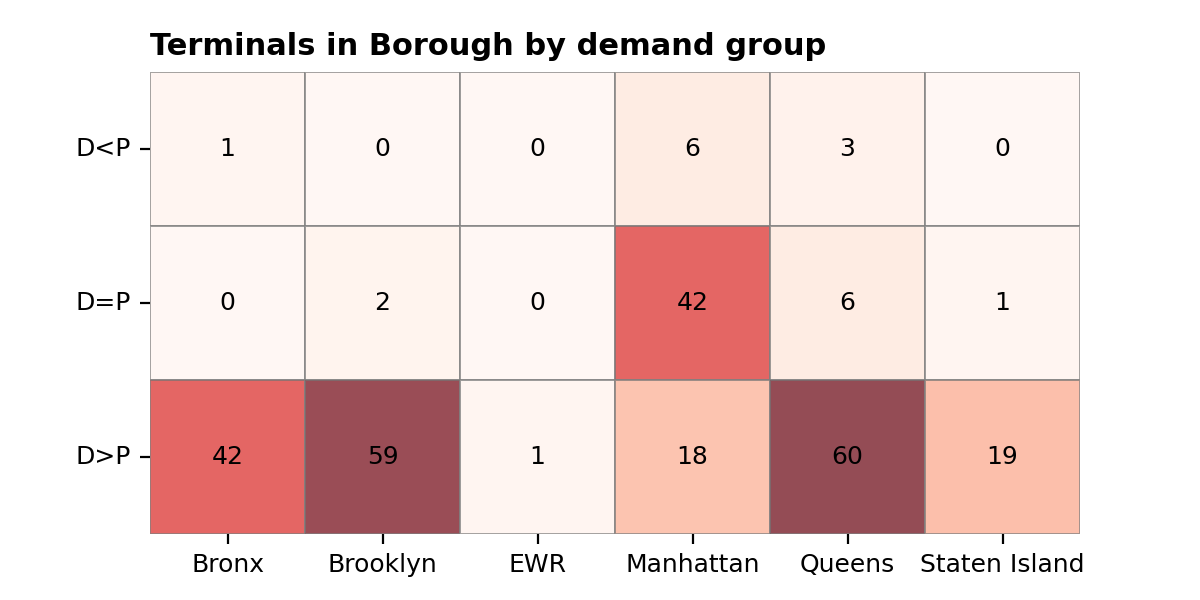

In [213]:
plt.figure(figsize=(6,3))
sns.heatmap(station_rides.groupby(['borough', 'dropoff_perc_group']).dropoff_perc_group.count().unstack().fillna(0).T, 
            annot=True, cbar=False, linecolor='gray', linewidths=0.1, cmap='Reds', alpha=0.7, annot_kws={'color': 'k'})
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.ylabel('')
plt.xlabel('')
plt.title('Terminals in Borough by demand group', 
          fontweight='bold', fontsize=11, loc='left');


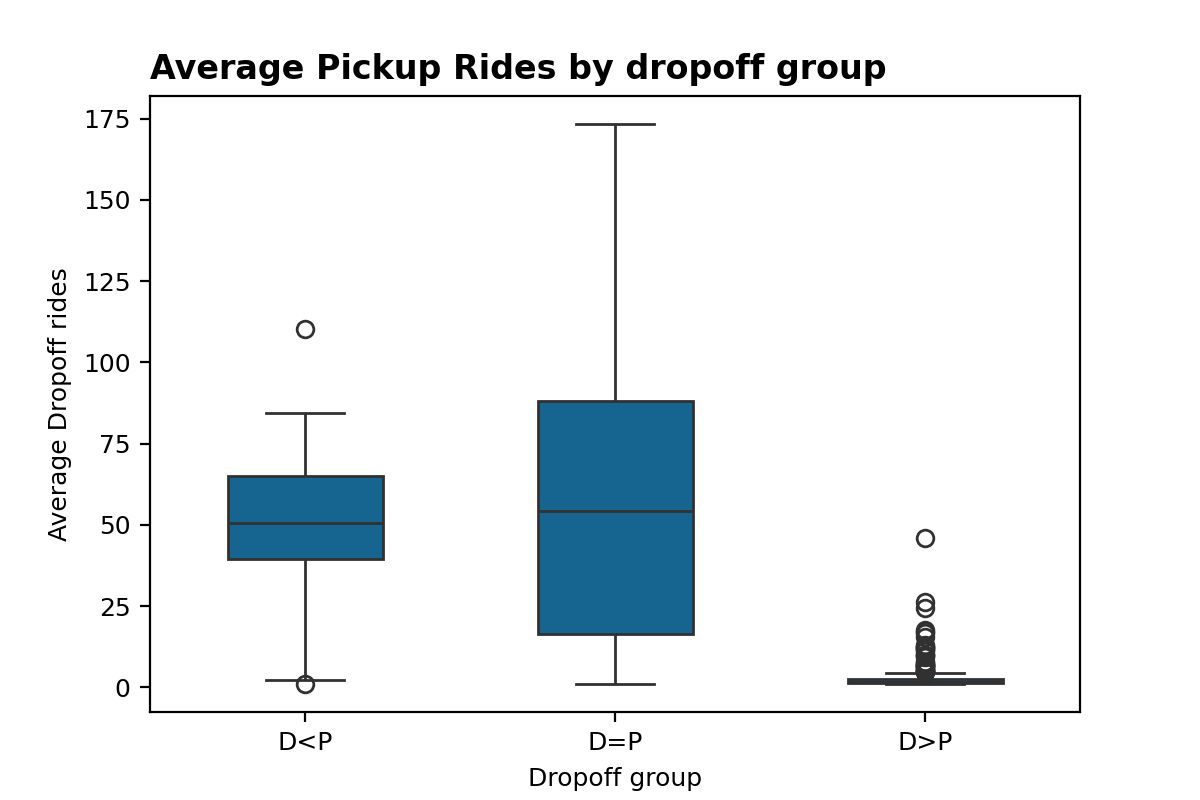

In [223]:
plt.figure(figsize=(6,4))
ax = sns.boxplot(data=station_rides, x='dropoff_perc_group', y='avg_dropoff_rides', 
                 width=0.5, order=['D<P', 'D=P', 'D>P'])
plt.title('Average Pickup Rides by dropoff group', fontsize=12, 
          fontweight='bold', loc='left')
plt.xlabel('Dropoff group')
plt.ylabel('Average Dropoff rides');

- Majority of the stations in each borough have >60% of taxis dropping off commuters in them, excpet in Manhattan
- Only, 50 stations have equal amount of taxis entering and exiting them, with 84% of them in Manhattan
- Only a few stations have more taxis exiting (fewer taxis arriving) from them.
- Despite the huge number of stations with higher dropoff rate, these stations have less than 50 hourly dropoff rides, with the median value below 20 rides per hour.
- Conversely, stations with less dropoff rates or equal dropoff and pickup rates have a median value of 50 taxi dropoffs per hour.

Next, we will find out these stations with equal dropoff and pickup rates in each borough

In [283]:
(
    station_rides
    .query('dropoff_perc_group in ["D=P", "D<P"]')
    .groupby(['borough', 'dropoff_perc_group'])
    .apply(lambda x: x.nlargest(5, 'avg_pickup_rides'), include_groups=False)
    .filter(['pickup_station', 'zone', 'avg_pickup_rides', 'avg_dropoff_rides', 
             'total_pickup_rides', 'total_dropoff_rides','station_perc_dropoff'])
    .reset_index(level=[0,1])
    .reset_index(drop=True)
)

borough dropoff_perc_group  pickup_station  \
0           Bronx                D<P             199   
1        Brooklyn                D=P              35   
2        Brooklyn                D=P             222   
3       Manhattan                D<P             162   
4       Manhattan                D<P             186   
5       Manhattan                D<P             249   
6       Manhattan                D<P              43   
7       Manhattan                D<P             100   
8       Manhattan                D=P             237   
9       Manhattan                D=P             236   
10      Manhattan                D=P             161   
11      Manhattan                D=P             142   
12      Manhattan                D=P             170   
13         Queens                D<P             132   
14         Queens                D<P             138   
15         Queens                D<P              70   
16         Queens                D=P             193   
17         Queens                D=P              10   
18         Queens                D=P              93   
19         Queens                D=P             215   
20         Queens                D=P             207   
21  Staten Island                D=P              44   

                                zone  avg_pickup_rides  avg_dropoff_rides  \
0                      Rikers Island          1.018182           1.125000   
1                        Brownsville          1.858102           1.982254   
2                      Starrett City          1.491285           1.459174   
3                       Midtown East        136.730342         110.150396   
4       Penn Station/Madison Sq West        126.617361          84.371250   
5                       West Village         85.107634          69.284979   
6                       Central Park         65.336825          49.567826   
7                   Garment District         62.450131          51.320851   
8              Upper East Side South        179.919763         159.607489   
9              Upper East Side North        168.204276         173.395643   
10                    Midtown Center        159.719540         140.936803   
11               Lincoln Square East        123.500311         107.696825   
12                       Murray Hill        121.094511         119.914379   
13                       JFK Airport        129.228821          38.972252   
14                 LaGuardia Airport        115.660967          52.153452   
15                     East Elmhurst         11.844598           2.291740   
16           Queensbridge/Ravenswood          2.828688           3.112482   
17                      Baisley Park          2.322366           2.770472   
18      Flushing Meadows-Corona Park          2.321983           2.183474   
19                     South Jamaica          1.664935           1.615072   
20  Saint Michaels Cemetery/Woodside          1.058281           1.189864   
21            Charleston/Tottenville          1.041452           1.054749   

    total_pickup_rides  total_dropoff_rides  station_perc_dropoff  
0                   56                    9             13.846154  
1                34858                48924             58.394405  
2                15657                20462             56.651624  
3              6143431              4936390             44.552976  
4              5789199              3802106             39.641175  
5              3818354              3069671             44.565329  
6              2769236              2146386             43.664586  
7              2832051              2276439             44.561876  
8              8023162              7131103             47.056739  
9              7481558              7792747             51.018668  
10             7103846              6297902             46.993139  
11             5558502              4864881             46.672764  
12             5462089              5424207             49.826011

The table above shows top 5 pickup stations in each borough with lower dropoff rate and equal dropoff and pickup rates by average pickup rides
- These stations are located in Brooklyn, Manhattan, Staten Island, Bronx and Queens
- Making available taxis to pickup and dropoff commuters from these areas would be important to ease off logistics and delay problems that may result.
- In Brooklyn, these stations are located in Brownsville and Starlett city. In Manhatthan they are Midtown East, Penn station, West village, Central park, Garment District, Upper East side North and South, Midtown center, Lincoln square east and Murray hill. In Queens these include stations at JFK and LaGuardia airports, Queensbridge/Ravenswood, Baisley Park, Flushing Meadows-Corona park, South Jamaica and Saint Michaels cemetry/Woodside while in Staten Island and Bronx, they are Charleston/Tottenville and Rikers Island, respectively.

#### High, medium and low-demand areas

Here, we will group stations into high, medium and low-demand areas. We will group based on the average hourly rides

We assume that _low_ demand terminals are terminals below the mean demand in all terminals. _Medium_ terminals are terminals with demands between the mean demand and 100, while _high_ terminals are terminals with taxi demands from 100 and above. After that, we will look at the distribution of taxi demand across these groups and the percentage of revenue contributed by these terminal groups.

In [107]:
avg_ride = np.mean(station_rides.avg_pickup_rides).astype(int)
avg_ride

15

In [108]:
def group_rides(x):
    if x < avg_ride:
        return 'Low'
    elif avg_ride < x < 100:
        return 'Medium'
    else: return 'High'

In [109]:
# adding demand group
station_rides = (
    station_rides
    .assign(group = station_rides.avg_pickup_rides.apply(group_rides))
    # average fare cost and trip charges added
    .eval('avg_fare_cost = fare_cost/avg_pickup_rides')
    .eval('charges = (avg_revenue-fare_cost)/avg_pickup_rides')
)
# adding order
station_rides.group = pd.Categorical(station_rides.group, 
                                     categories=['Low', 'Medium', 'High'], 
                                     ordered=True)

In [110]:
# percentage of revenue by groups
rev_perc = station_rides.groupby('group', observed=True).total_revenue.sum().transform(lambda x: 100*x/sum(x))

In [111]:
mean_vals = station_rides.groupby('group', observed=True).avg_pickup_rides.mean().reset_index()
mean_vals

group  avg_pickup_rides
0     Low          1.928085
1  Medium         55.416352
2    High        127.389101

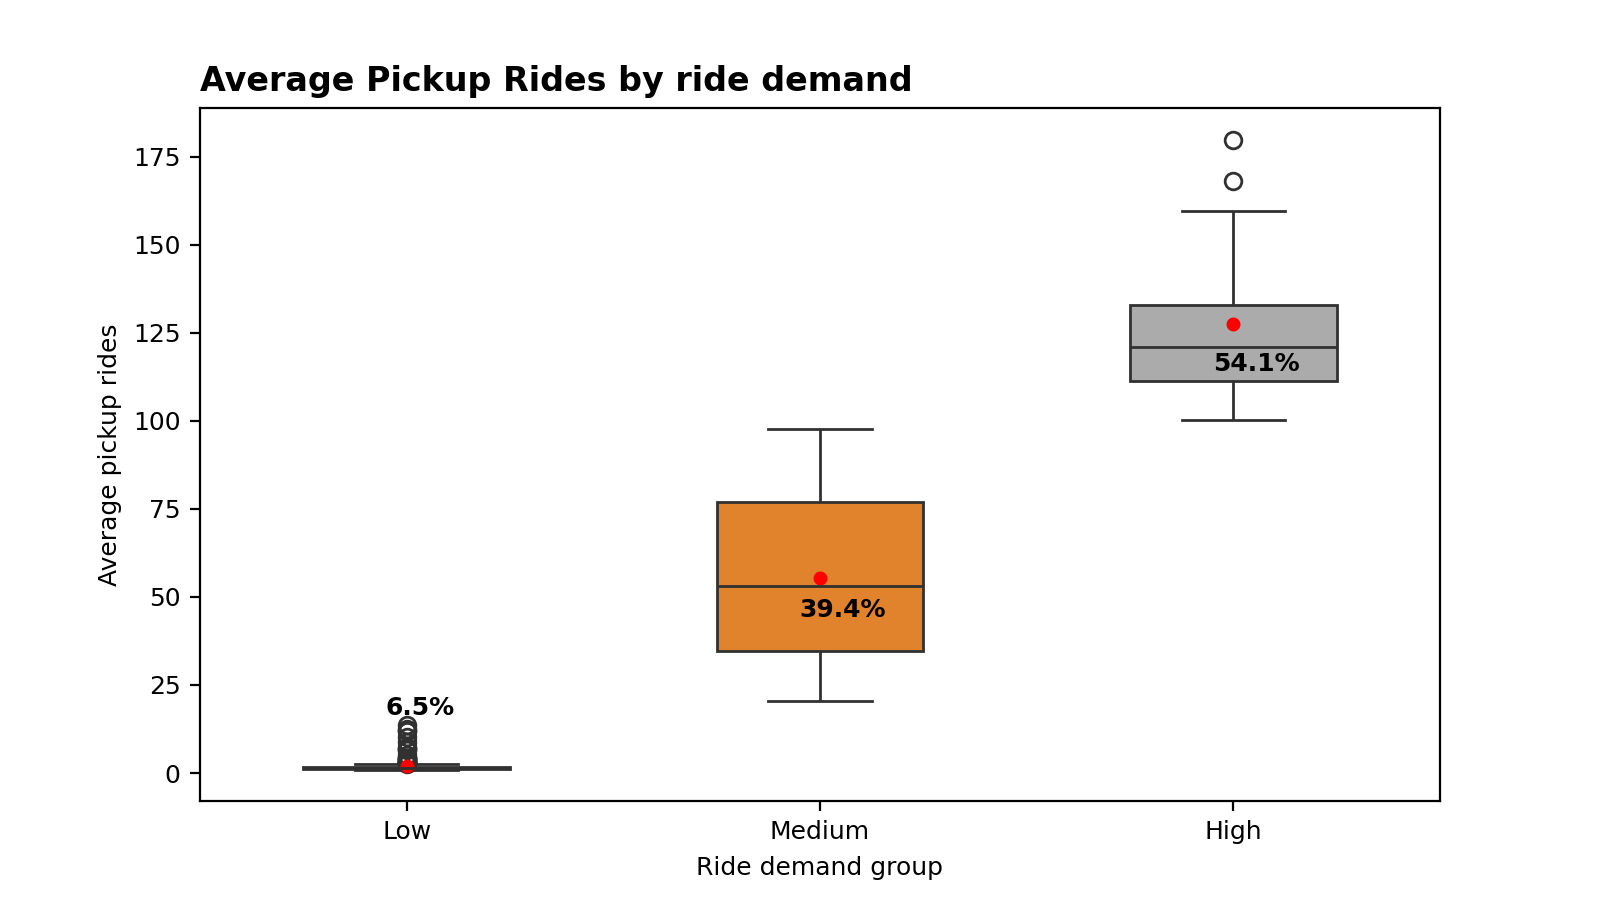

In [112]:
plt.figure(figsize=(8,4.5))
ax = sns.boxplot(data=station_rides, x='group', y='avg_pickup_rides', 
            hue='group', width=0.5)
sns.pointplot(data=mean_vals, x='group', y='avg_pickup_rides', markersize=3,
                marker='o', ax=ax, errorbar=None, color='r', linestyles='')
for i,j in zip(range(len(ax.patches)), [10, 5, 60]):
    plt.text(x=i-0.05, y=rev_perc.values[i]+j, s=f"{rev_perc.values[i]:.1f}%", 
             fontweight='bold', fontsize=9)
plt.title('Average Pickup Rides by ride demand', fontsize=12, 
          fontweight='bold', loc='left')
plt.xlabel('Ride demand group')
plt.ylabel('Average pickup rides');

The boxplot shows the average pickup rides by pickup terminal group and the percentage of revenue they contributed. The red dots show the mean demand by group.

- On average, most of the low terminals have demands less than 2. The medium-demand terminals have demands above 50 while the high-demand terminals have demands above 125 on average. On the other hand, 6.5%, 39.4% and 54.1% of the revenues generated were contributed by low, medium and high-demand terminals, respectively.

Next, we will look at boroughs where these terminals are concentrated

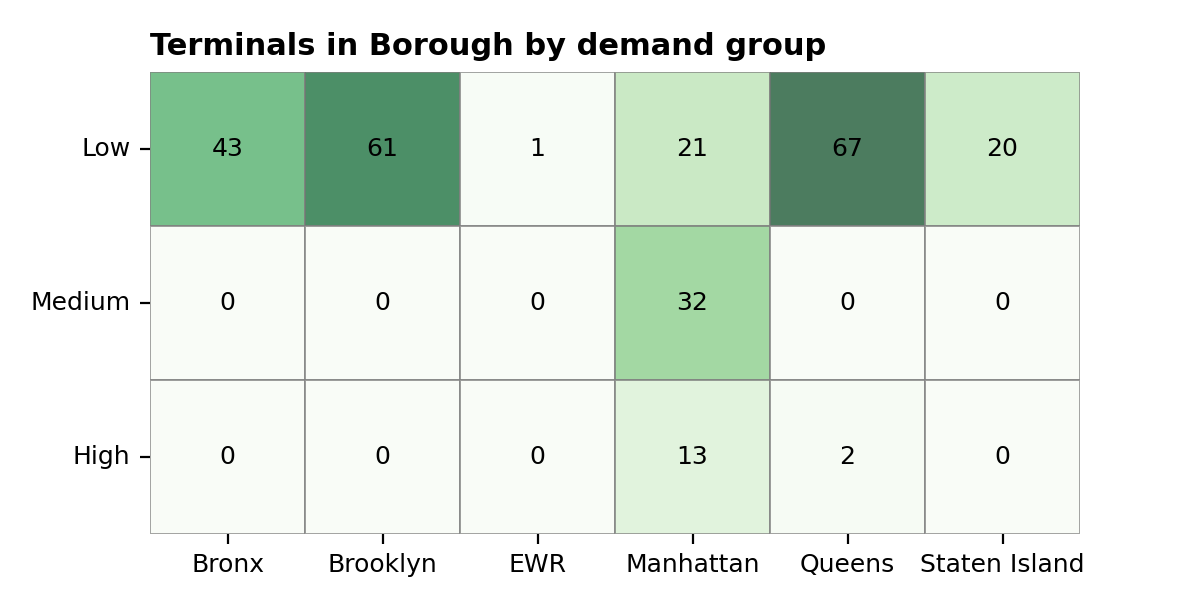

In [113]:
plt.figure(figsize=(6,3))
sns.heatmap(station_rides.groupby(['borough', 'group'], observed=True).group.count().unstack().fillna(0).T, 
            annot=True, cbar=False, linecolor='gray', linewidths=0.1, cmap='Greens', alpha=0.7, annot_kws={'color': 'k'})
plt.yticks(rotation=0)
plt.xticks(rotation=0)
plt.ylabel('')
plt.xlabel('')
plt.title('Terminals in Borough by demand group', 
          fontweight='bold', fontsize=11, loc='left');


- All or most of the low-demand terminals are located in Bronx (41), Brooklyn (61), Staten Island (20), EWR (Newark Airport) and Queens (67).
- Manhattan is the only borough with a mixture of both low, medium and high terminals. 21 are low-demand terminals, 32 are medium-demand stations and 13 are high-demand terminals. Only 2 high-demand terminals are located in Queens
- A total of 15 terminals are high-demand areas, 32 are medium-demand areas and 213 are low-demand terminals.

- Next, we will identify these high-demand areas

In [114]:
(
    station_rides.query('group == "High"')
    .filter(['pickup_station', 'zone', 'borough', 
             'avg_pickup_rides', 'avg_fare_cost', 'charges'])
    .sort_values('avg_pickup_rides', ascending=False)
)

pickup_station                          zone    borough  \
233             237         Upper East Side South  Manhattan   
232             236         Upper East Side North  Manhattan   
157             161                Midtown Center  Manhattan   
158             162                  Midtown East  Manhattan   
128             132                   JFK Airport     Queens   
182             186  Penn Station/Madison Sq West  Manhattan   
138             142           Lincoln Square East  Manhattan   
166             170                   Murray Hill  Manhattan   
134             138             LaGuardia Airport     Queens   
230             234                      Union Sq  Manhattan   
226             230     Times Sq/Theatre District  Manhattan   
235             239         Upper West Side South  Manhattan   
47               48                  Clinton East  Manhattan   
159             163                 Midtown North  Manhattan   
78               79                  East Village  Manhattan   

     avg_pickup_rides  avg_fare_cost    charges  
233        179.919763      10.523641   6.489617  
232        168.204276      10.998742   6.506405  
157        159.719540      13.264561   7.440011  
158        136.730342      12.676690   7.220832  
128        129.228821      54.649189  17.994119  
182        126.617361      13.358885   7.131775  
138        123.500311      11.696038   6.779272  
166        121.094511      12.570344   7.081223  
134        115.660967      35.462718  18.005537  
230        115.659694      11.835881   6.799411  
226        111.833588      15.178796   8.072946  
235        111.066126      11.540697   6.742149  
47         106.880532      12.835127   7.043807  
159        104.426521      13.232917   7.337123  
78         100.294155      12.448522   6.807494

- The two high-demand terminals in Queens are terminals at the _LaGuardia_ and _JFK Airports_. The other high-demand terminals located in Manhattan are terminals at _Upper East Side North and South_, _Midtown Center, North and East_, _Madison square West_ or _Penn station_, _Lincoln Square East_, _Murray Hill_, _Union Square_, _Times square or theatre district_, _Upper West Side South_, and _East village_
- Allocating more yellow taxis around these areas would ensure the smooth movement of residents and avoid delays at work or appointments.
- Taxis going to the airports cost very high and have high charges. For JFK and LaGuardia airports, an average trip costs at least 30 dollars and with charges of more than 15 dollars.



#### Average hourly rides for high-demand stations

Here, we will look at the average ride demand per hour of the day for high-demand areas. Furthermore, we will drill down to the trip charges, trip costs, and revenue generated by these stations per hour.

In [115]:
high_demand = station_rides.query("group == 'High'").pickup_station.pipe(tuple)

In [116]:
# hourly rides
hourly_station_rides_query = f"""
WITH pickup_station_rides AS (
       SELECT pickup_station, 
              CAST(strftime('%H', ride_datetime) AS INT) AS hour,
              AVG(hourly_rides) AS avg_pickup_rides,
              AVG(revenue) AS avg_revenue,
              AVG(total_fare_cost) AS fare_cost
        FROM pickup_trips
        WHERE pickup_station IN {high_demand}
        GROUP BY pickup_station, hour
        )
        
SELECT p.hour, p.pickup_station, 
       l.borough, l.zone,
       p.avg_pickup_rides,
       p.avg_revenue, p.fare_cost
FROM pickup_station_rides p
JOIN location_info l
ON p.pickup_station = l.ride_station
"""

In [117]:
high_demand_hourly_rides = pd.read_sql_query(hourly_station_rides_query, conn)

In [118]:
# average fare cost and trip charges added
high_demand_hourly_rides = (
    high_demand_hourly_rides
    .eval('avg_fare_cost = fare_cost/avg_pickup_rides')
    .eval('charges = (avg_revenue-fare_cost)/avg_pickup_rides')
)

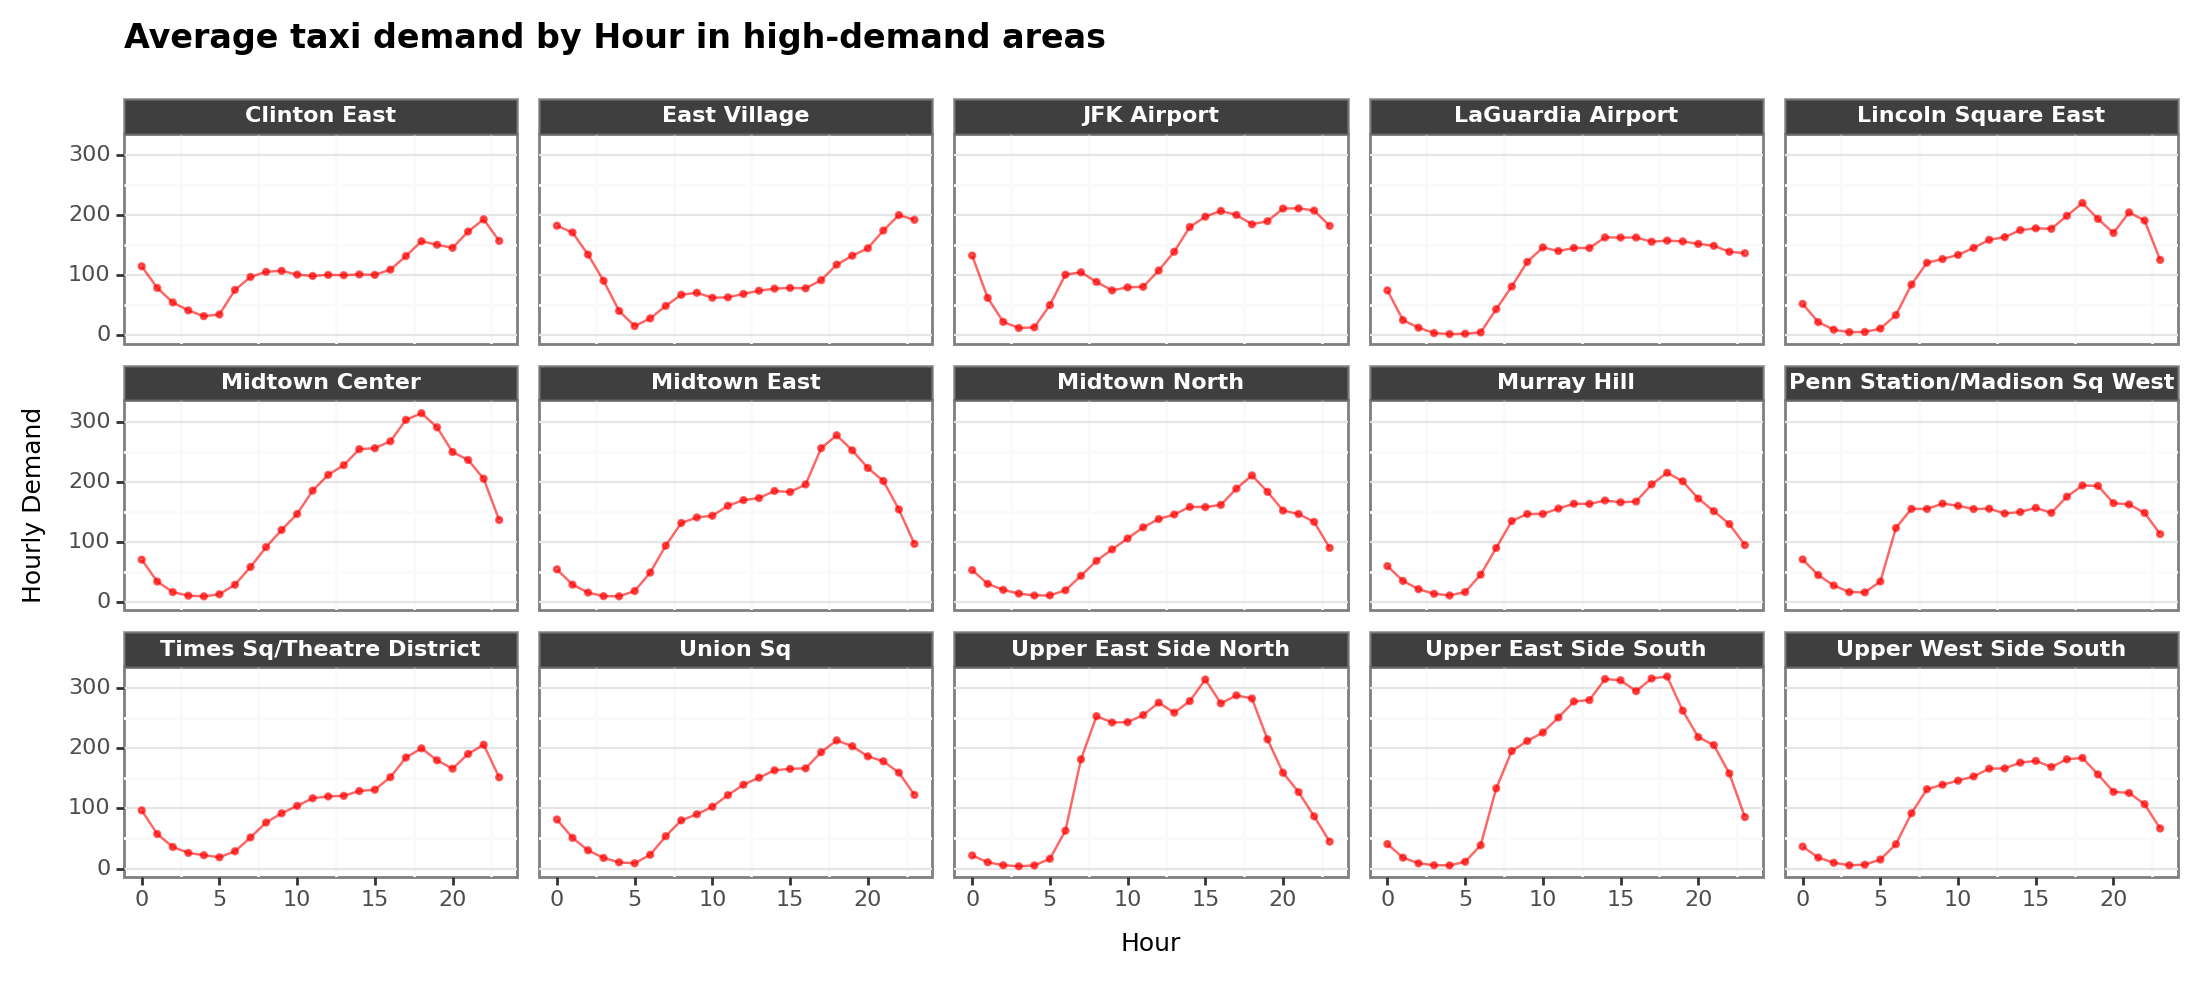

<Figure Size: (1100 x 500)>

In [119]:
(
    pn.ggplot(high_demand_hourly_rides, pn.aes(x='hour', y='avg_pickup_rides')) +
    pn.geom_line(color='red', alpha=0.6) +
    pn.geom_point(color='red', shape='o', size=0.7, alpha=0.6) +
    pn.facet_wrap('~zone', ncol=5) +
    pn.theme_bw() +
    pn.theme(figure_size=(11,5.5),
             strip_background=pn.element_rect(fill='black', alpha=0.5),
             strip_text=pn.element_text(color='white', size=8, face='bold'),
             panel_grid_major_x = pn.element_blank(),
             axis_text=pn.element_text(size=8),
             axis_title=pn.element_text(size=9),
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.scale_x_continuous(breaks=range(0,24,5)) +
    pn.labs(x='Hour', y='Hourly Demand') +
    pn.ggtitle(title='Average taxi demand by Hour in high-demand areas')
)

- In high-demand areas, the hourly taxi demand are relatively similar, with lower demand in the early hours of the day which begins to increase until the close of work hours (5-6PM) before declining at night.
- In most terminals, the peak demand hour is 5PM. For example, in Midtown Center, East and North, Murray Hill, Union square. In some others like the LaGuardia Airport, the peak demand hours is at around 10AM, and the demand remains the same throughout the same. In some other terminals like the one at JFK Airport, there are 3 peak times: 6-7 AM, 4-5PM and 8-9PM, respectively. In East village, it is rather different where taxi demand increases throughout the day before peaking for the first time at 10PM.

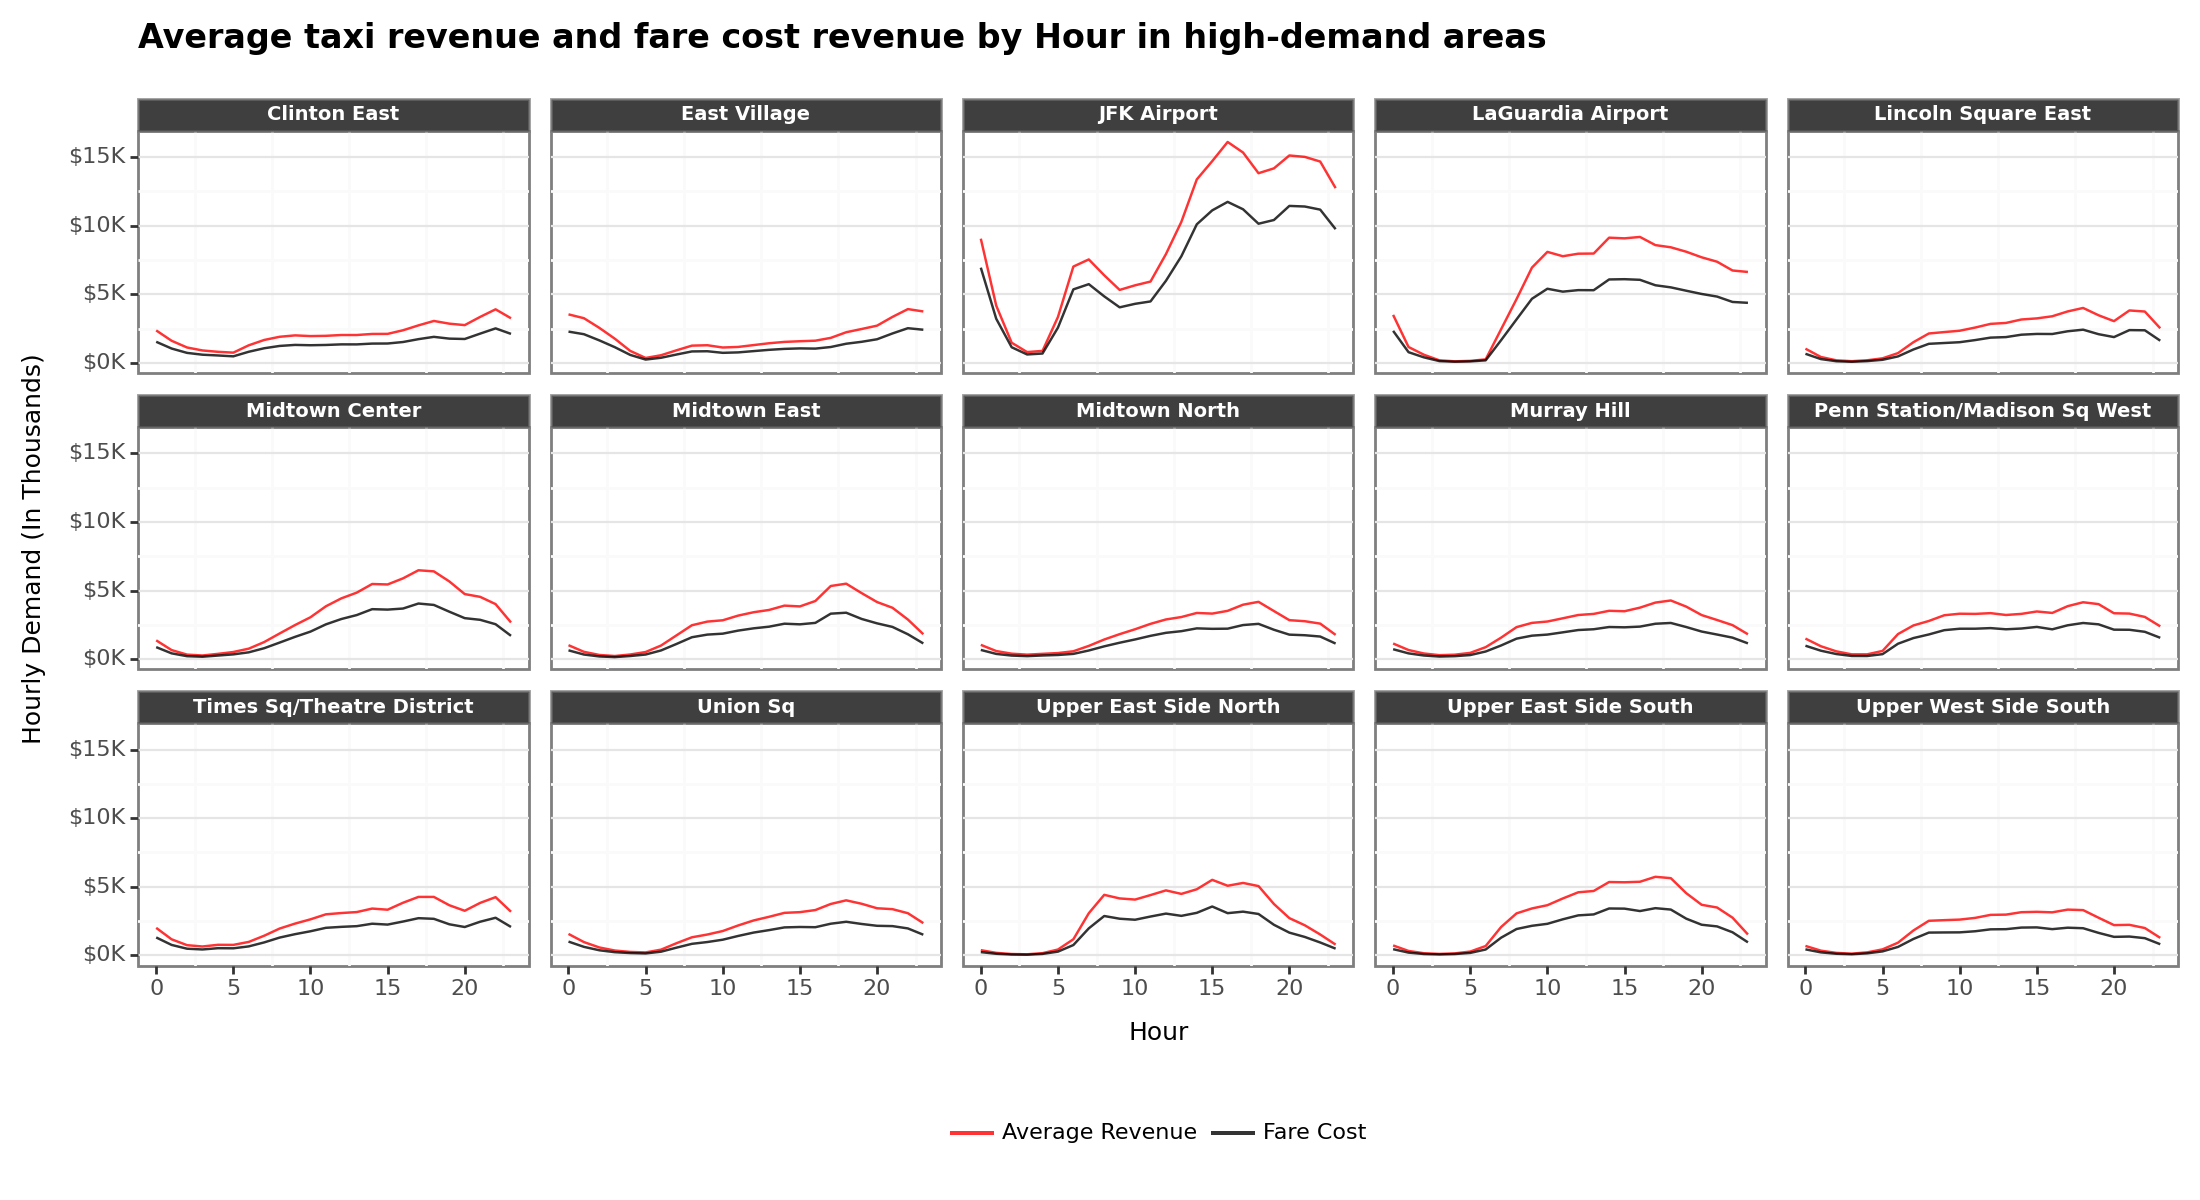

<Figure Size: (1100 x 600)>

In [120]:
(
    pn.ggplot(high_demand_hourly_rides.melt(
        id_vars=['hour', 'zone'], value_vars=['avg_revenue', 'fare_cost'], var_name='type'
    ), pn.aes(x='hour', y='value/1e3', color='type')) +
    pn.geom_line(alpha=0.8) +
    pn.facet_wrap('~zone', ncol=5) +
    pn.theme_bw() +
    pn.theme(figure_size=(11,6),
             legend_position='bottom',
             legend_direction='horizontal',
             legend_title=pn.element_blank(),
             legend_key=pn.element_blank(),
             legend_text=pn.element_text(size=8),
             strip_background=pn.element_rect(fill='black', alpha=0.5),
             strip_text=pn.element_text(color='white', size=7, face='bold'),
             panel_grid_major_x = pn.element_blank(),
             axis_text=pn.element_text(size=8),
             axis_title=pn.element_text(size=9),
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.scale_x_continuous(breaks=range(0,24,5)) +
    pn.scale_y_continuous(labels=mfmt.custom_format('${:.0f}K')) +
    pn.labs(x='Hour', y='Hourly Demand (In Thousands)') +
    pn.ggtitle(title='Average taxi revenue and fare cost revenue by Hour in high-demand areas') +
    pn.scale_color_manual(values=['red', 'black'], 
                          labels=['Average Revenue', 'Fare Cost'])
)

- When we look at the average revenue from all fares and charges and average revenue generated from trip fares by high-demand areas at each hour of the day, we see that their value depends mostly on the demand at that hour.
- The average revenue and fares around the airports are relatively higher than other pickup stations. This is because an [additional fee](https://www.nyc.gov/assets/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf) of 1.25 dollars is added to pickups in these airports making the revenues generated higher.

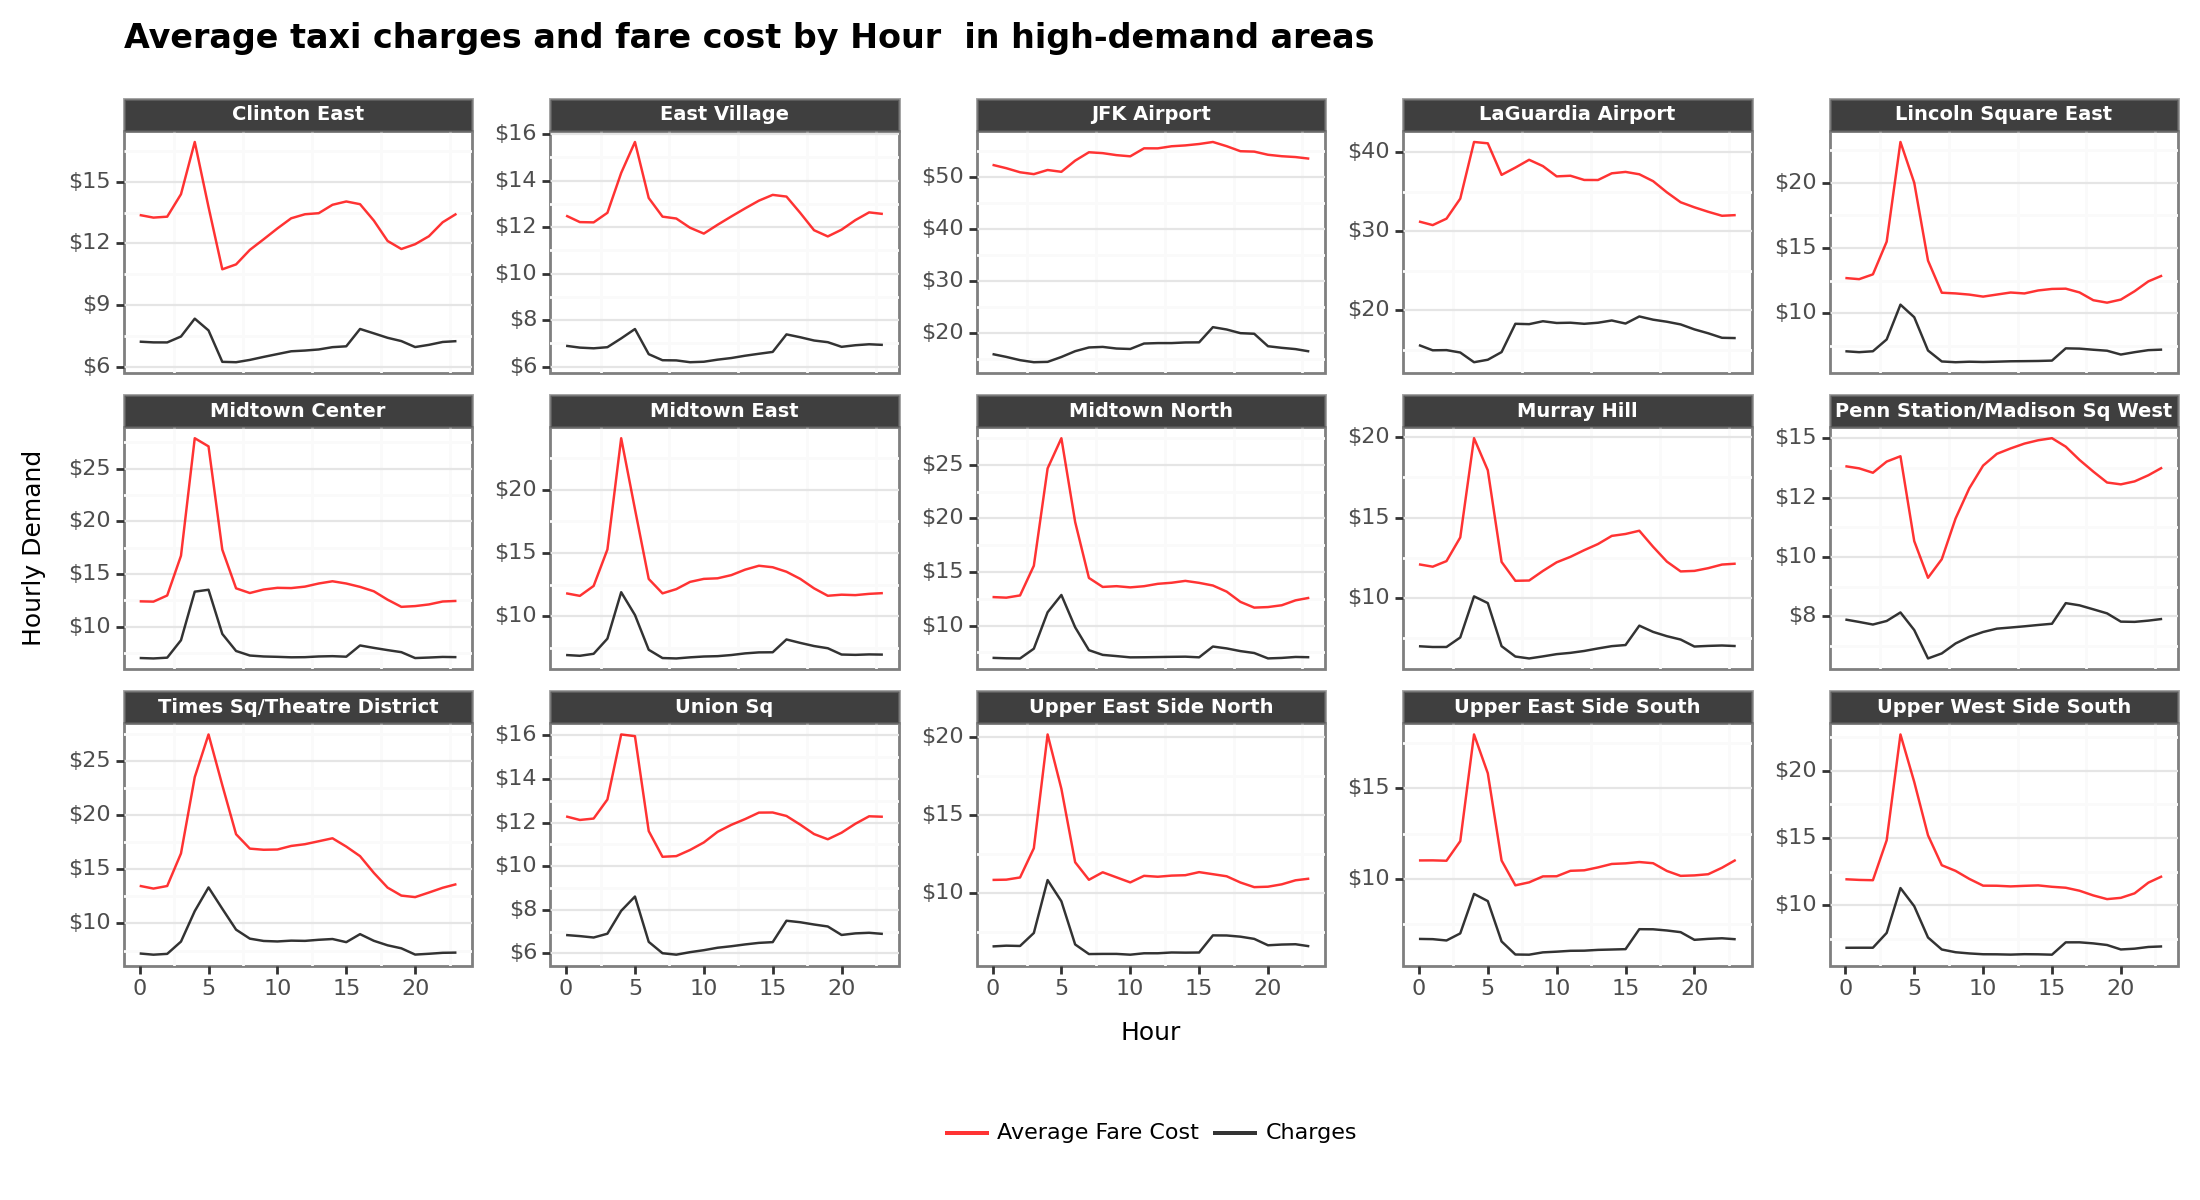

<Figure Size: (1100 x 600)>

In [121]:
(
    pn.ggplot(high_demand_hourly_rides.melt(
        id_vars=['hour', 'zone'], value_vars=['charges', 'avg_fare_cost'], var_name='type'
    ), pn.aes(x='hour', y='value', color='type')) +
    pn.geom_line(alpha=0.8) +
    pn.facet_wrap('~zone', ncol=5, scales='free_y') +
    pn.theme_bw() +
    pn.theme(figure_size=(11,6),
             legend_position='bottom',
             legend_direction='horizontal',
             legend_title=pn.element_blank(),
             legend_text=pn.element_text(size=8),
             legend_key=pn.element_blank(),
             strip_background=pn.element_rect(fill='black', alpha=0.5),
             strip_text=pn.element_text(color='white', size=7, face='bold'),
             panel_grid_major_x = pn.element_blank(),
             axis_text=pn.element_text(size=8),
             axis_title=pn.element_text(size=9),
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.scale_x_continuous(breaks=range(0,24,5)) +
    pn.scale_y_continuous(labels=mfmt.dollar_format(digits=0, big_mark=',')) +
    pn.labs(x='Hour', y='Hourly Demand') +
    pn.ggtitle(title='Average taxi charges and fare cost by Hour  in high-demand areas') +
    pn.scale_color_manual(values=['red', 'black'], labels=['Average Fare Cost', 'Charges'])
)

- Unlike what we saw in the previous cells, trip charges and fares are the highest in the early hours of the day (3-4 AM) in most of the high-demand areas. In some other terminals, after the first peak charges/fare in the early hours of the morning, there's a short decline and then a slight increase in the middle hours of the day before a slow decline in the late hours.

### E. Short vs Long trips

In this section, we will investigate pickup stations that are mostly used for short or long trips. We will assume trips 10 minutes and below are short trips, trips between 10 and 45 minutes as medium trips and trips above 45 minutes as long trips

In [122]:
station_trips = pd.read_sql_query("""SELECT p.pickup_station, 
                                            l.borough, l.zone, 
                                            ROUND(AVG(p.duration_secs),2) as avg_duration,
                                            ROUND(AVG(p.distance_miles),2) as avg_distance
                                     FROM pickup_trips p
                                     JOIN location_info l
                                     ON p.pickup_station = l.ride_station
                                     GROUP BY pickup_station
                                     """, conn)

In [123]:
describe_data(station_trips.avg_distance, 'Average Distance')

In [124]:
describe_data(station_trips.avg_duration, 'Average Duration')

- There are durations less than 0. We will assume that the arrival and departure times were switched. We will then convert negative values to absolute values

In [125]:
station_trips.iloc[:, [-2, -1]] = station_trips.iloc[:, [-2, -1]].abs()

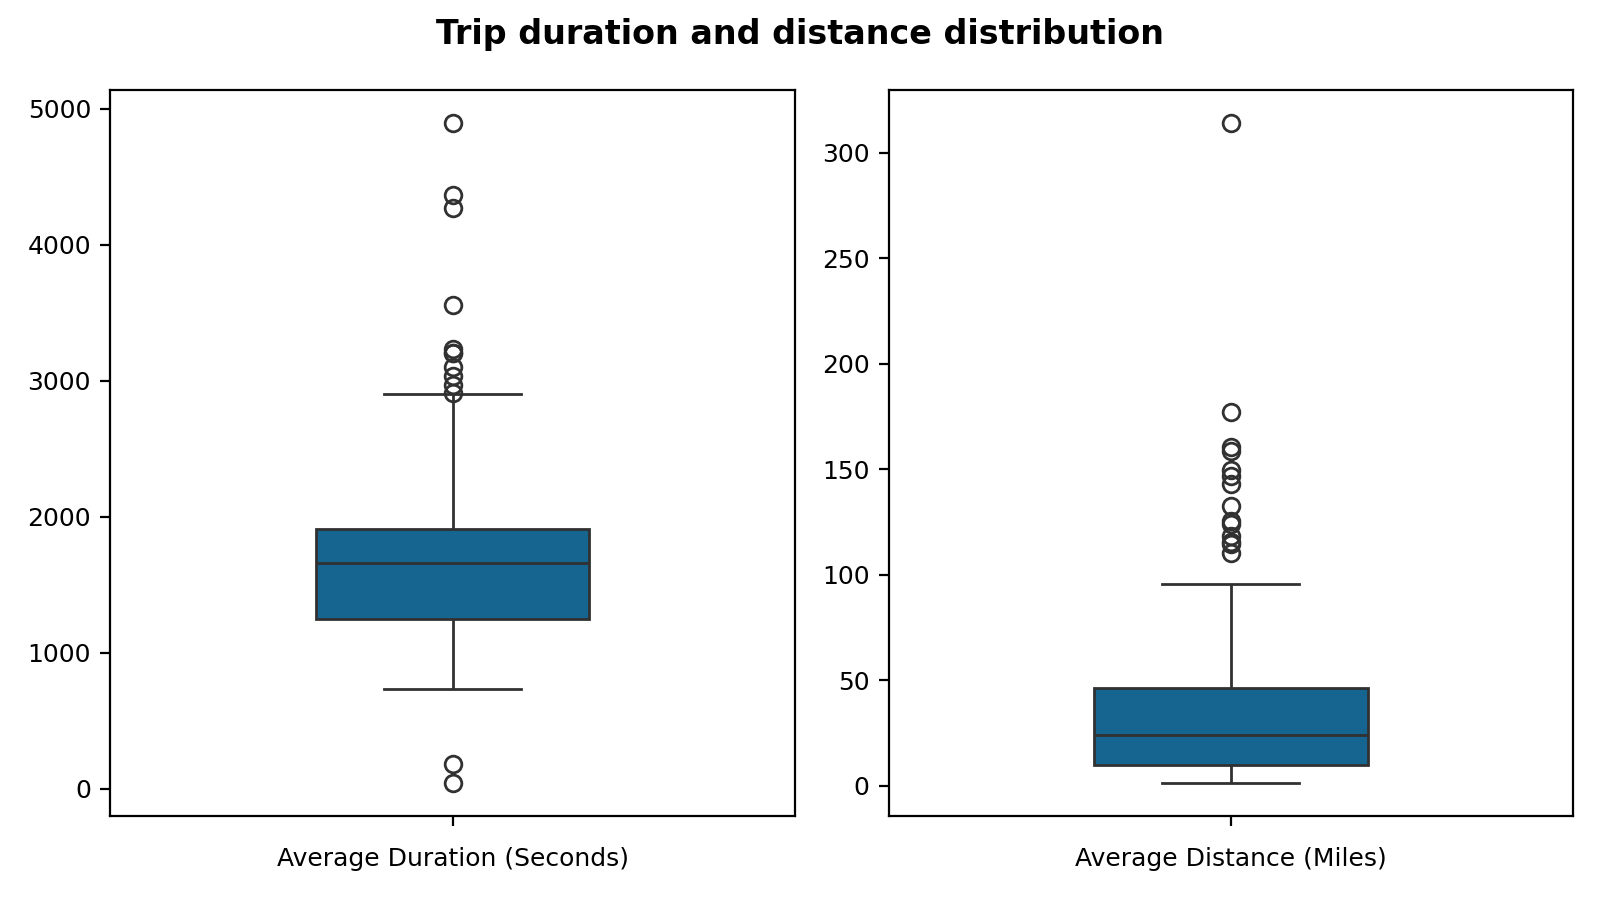

In [126]:
fig, ax = plt.subplots(1,2,figsize=(8,4.5))
sns.boxplot(station_trips, y='avg_duration', ax=ax[0], width=0.4)
ax[0].set(xlabel='Average Duration (Seconds)', ylabel='')
sns.boxplot(station_trips, y='avg_distance', ax=ax[1], width=0.4)
ax[1].set(xlabel='Average Distance (Miles)', ylabel='')
fig.suptitle('Trip duration and distance distribution', 
             fontsize=12, fontweight='bold')
fig.tight_layout()

In [127]:
station_trips = pd.read_sql_query(
    """
    SELECT p.pickup_station, l.borough, l.zone,
            ABS(ROUND(AVG(p.duration_secs),2)) as avg_duration,
            ROUND(AVG(p.distance_miles),2) as avg_distance,
    CASE 
        WHEN ABS(ROUND(AVG(p.duration_secs),2))/60 <= 15 
            THEN 'Short'
        WHEN ABS(ROUND(AVG(p.duration_secs),2))/60 > 15 AND 
                ABS(ROUND(AVG(p.duration_secs),2))/60 <= 45 
            THEN 'Medium'
        ELSE 'Long'
    END AS trip_type
    FROM pickup_trips p
    JOIN location_info l
    ON p.pickup_station = l.ride_station
    GROUP BY pickup_station
    """, conn)

In [128]:
station_trips.trip_type = pd.Categorical(
    station_trips.trip_type, 
    categories=['Short', 'Medium', 'Long'], 
    ordered=True
)

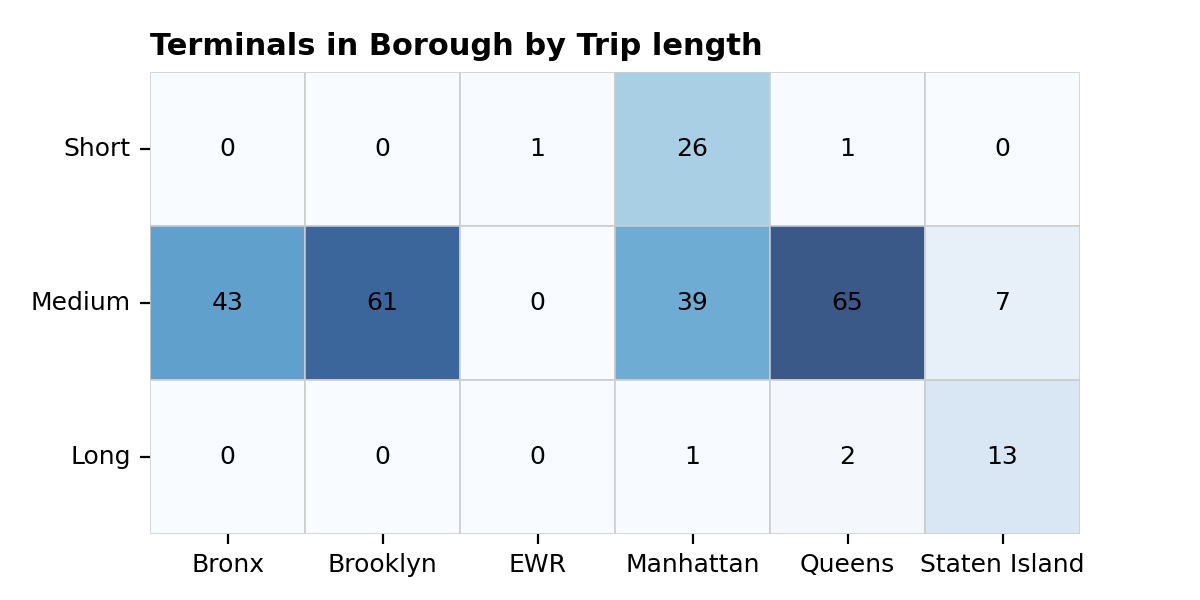

In [129]:
plt.figure(figsize=(6,3))
sns.heatmap(station_trips.groupby(['borough', 'trip_type'], observed=True).trip_type.count().unstack().fillna(0).T,
            annot=True, cbar=False, linecolor='#cdcdcd', linewidths=0.1, cmap='Blues', alpha=0.8, annot_kws={'color':'k'})
plt.yticks(rotation=0)
plt.ylabel('')
plt.xlabel('')
plt.title('Terminals in Borough by Trip length', 
          fontweight='bold', fontsize=11, loc='left');

- Most of the terminals are used for medium-length journeys
- Staten Island is mostly used for long-distance journeys. 13 terminals in that region are used for such journeys. Only two terminals in Queens are mostly used for long journeys and one in Manhattan.
- Short trip terminals are mostly found in Manhattan. Another is the terminal at Newark Airport (EWR) and one also in Queens

Next, we will visualise the average duration and distance distributions of these terminals by the created groups

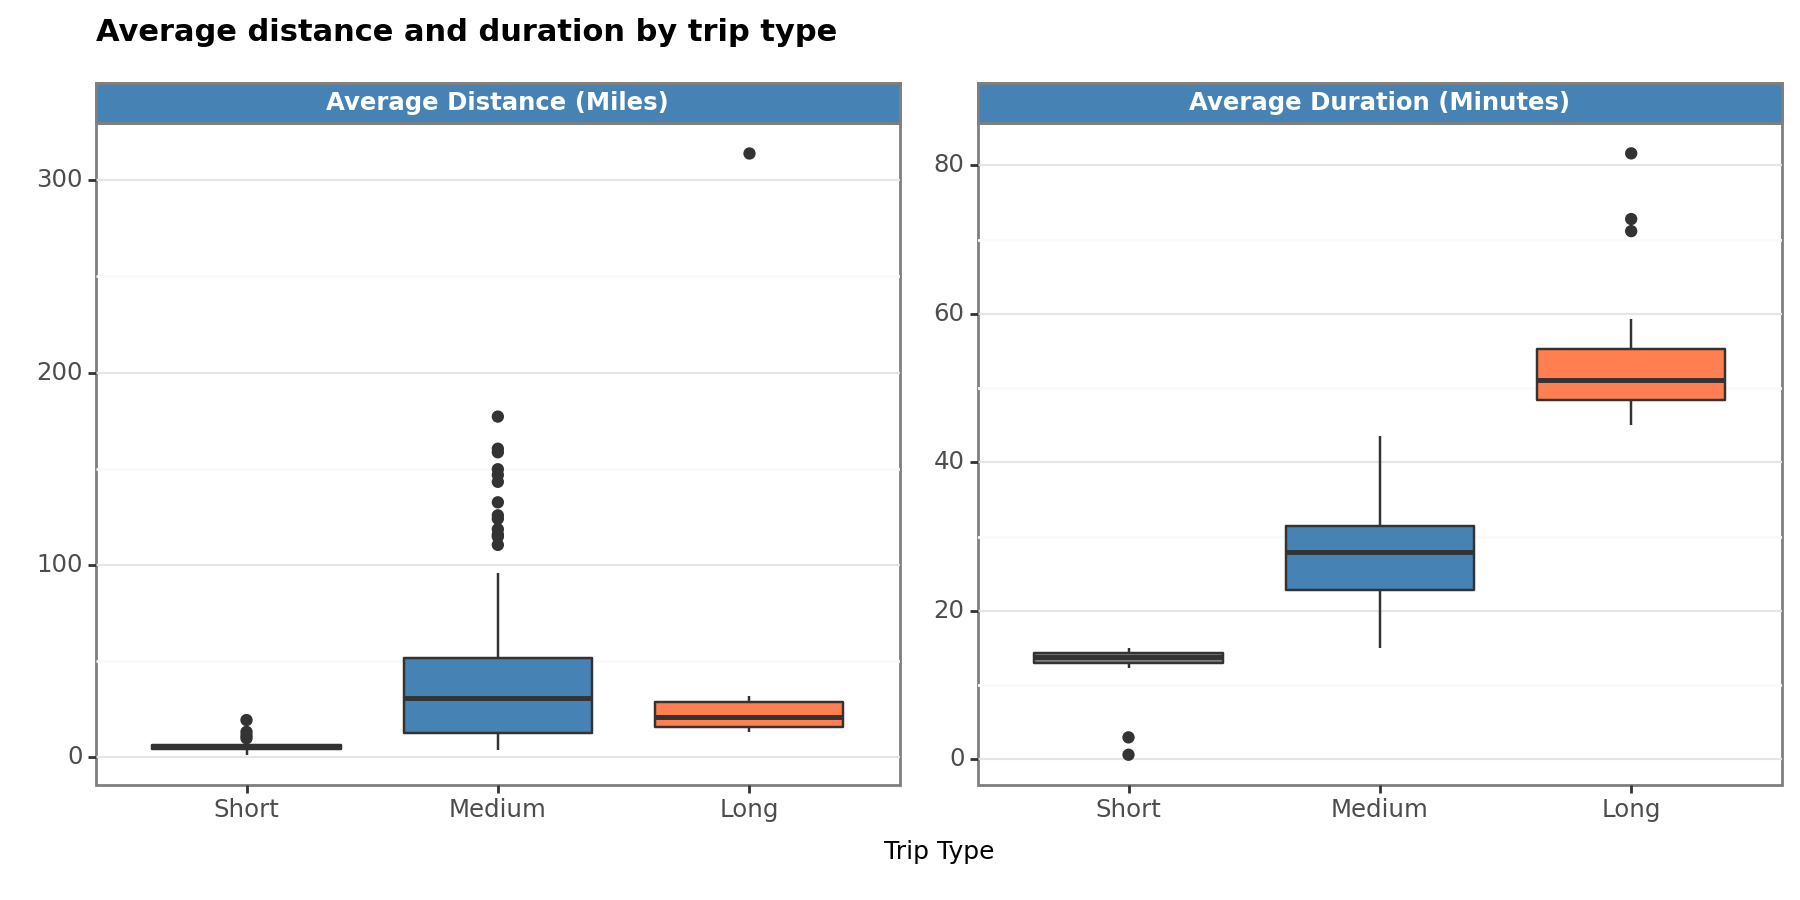

<Figure Size: (900 x 450)>

In [130]:
(
    pn.ggplot((
        station_trips
        .eval('avg_duration = avg_duration/60')
        .melt('trip_type', var_name='name', value_vars=['avg_distance', 'avg_duration'])
              ), 
             pn.aes(x='trip_type', y='value', fill='trip_type')) +
    pn.geom_boxplot() +
    pn.facet_wrap('~name', scales='free_y', 
                  labeller=pn.as_labeller(lambda x: 'Average Distance (Miles)' if 'dist' 
                                          in x else 'Average Duration (Minutes)')) +
    pn.theme_bw() +
    pn.theme(figure_size=(9,4.5),
             legend_position='none', 
             axis_title_x=pn.element_text(size=9),
             panel_grid_major_x=pn.element_blank(),
             strip_background=pn.element_rect(fill='steelblue'),
             plot_title=pn.element_text(weight='bold', size=11),
             strip_text=pn.element_text(color='white', weight='bold')
            ) +
    pn.labs(x='Trip Type', y='') +
    pn.ggtitle('Average distance and duration by trip type') +
    pn.scale_fill_manual(values=['gray', 'steelblue', 'coral'])
)

- The trip type was grouped based on the average duration. When we look at the distribution of this group in terms of the distance travelled, we see that it's not differentiable for medium and long trips. There are medium trips with higher covered distances than long trips. A lot of factors can affect the duration of the trip. They include the _road traffic conditions_, the _time of day_ of the trip and the _average speed_ travelled by the driver.

### F. Fare cost and Charges

Here, we want to look at fare pricing and charges for taxis around these stations. We will determine stations  

In [131]:
# 
station_summary_query = f"""
WITH pickup_station_rides AS (
       SELECT pickup_station, 
              ROUND(AVG(hourly_rides),2) AS avg_pickup_rides,
              ROUND(AVG(revenue),2) AS avg_revenue,
              ROUND(AVG(total_fare_cost),2) AS fare_cost,
              ABS(ROUND(AVG(duration_secs),2)) as avg_duration, 
              ROUND(AVG(distance_miles),2) as avg_distance
        FROM pickup_trips
        GROUP BY pickup_station
        )
        
SELECT p.pickup_station, 
       l.borough, l.zone,
       p.avg_pickup_rides,
       p.avg_revenue, 
       ROUND(p.fare_cost/p.avg_pickup_rides, 2) AS avg_fare_cost,
       ROUND((p.avg_revenue - p.fare_cost)/p.avg_pickup_rides, 2) AS charges,
       p.avg_duration, p.avg_distance
FROM pickup_station_rides p
JOIN location_info l
ON p.pickup_station = l.ride_station
"""

station_summary = pd.read_sql_query(station_summary_query, conn)

In [132]:
# 
station_hourly_summary_query = f"""
WITH pickup_station_rides AS (
       SELECT pickup_station, 
              strftime('%H', ride_datetime) as hour,
              ROUND(AVG(hourly_rides),2) AS avg_pickup_rides,
              ROUND(AVG(revenue),2) AS avg_revenue,
              ROUND(AVG(total_fare_cost),2) AS fare_cost,
              ABS(ROUND(AVG(duration_secs),2)) as avg_duration, 
              ROUND(AVG(distance_miles),2) as avg_distance
        FROM pickup_trips
        GROUP BY pickup_station, hour
        )
        
SELECT p.pickup_station, p.hour,
       l.borough, l.zone,
       p.avg_pickup_rides,
       p.avg_revenue, 
       ROUND(p.fare_cost/p.avg_pickup_rides, 2) AS avg_fare_cost,
       ROUND((p.avg_revenue - p.fare_cost)/p.avg_pickup_rides, 2) AS charges,
       p.avg_duration, p.avg_distance
FROM pickup_station_rides p
JOIN location_info l
ON p.pickup_station = l.ride_station
"""

station_hourly_summary = pd.read_sql_query(station_hourly_summary_query, conn)

In [133]:
# 
station_monthly_summary_query = f"""
WITH pickup_station_rides AS (
       SELECT pickup_station, 
              strftime('%m', ride_datetime) as month,
              strftime('%Y', ride_datetime) as year,
              ROUND(AVG(hourly_rides),2) AS avg_pickup_rides,
              ROUND(AVG(revenue),2) AS avg_revenue,
              ROUND(AVG(total_fare_cost),2) AS fare_cost,
              ABS(ROUND(AVG(duration_secs),2)) as avg_duration, 
              ROUND(AVG(distance_miles),2) as avg_distance
        FROM pickup_trips
        GROUP BY pickup_station, month, year
        )
        
SELECT p.pickup_station, p.month, p.year,
       p.year || '-' || p.month || '-' || '01' as date,
       l.borough, l.zone,
       p.avg_pickup_rides,
       p.avg_revenue, 
       ROUND(p.fare_cost/p.avg_pickup_rides, 2) AS avg_fare_cost,
       ROUND((p.avg_revenue - p.fare_cost)/p.avg_pickup_rides, 2) AS charges,
       p.avg_duration, p.avg_distance
FROM pickup_station_rides p
JOIN location_info l
ON p.pickup_station = l.ride_station
"""

station_monthly_summary = pd.read_sql_query(station_monthly_summary_query, conn, parse_dates=['date'])

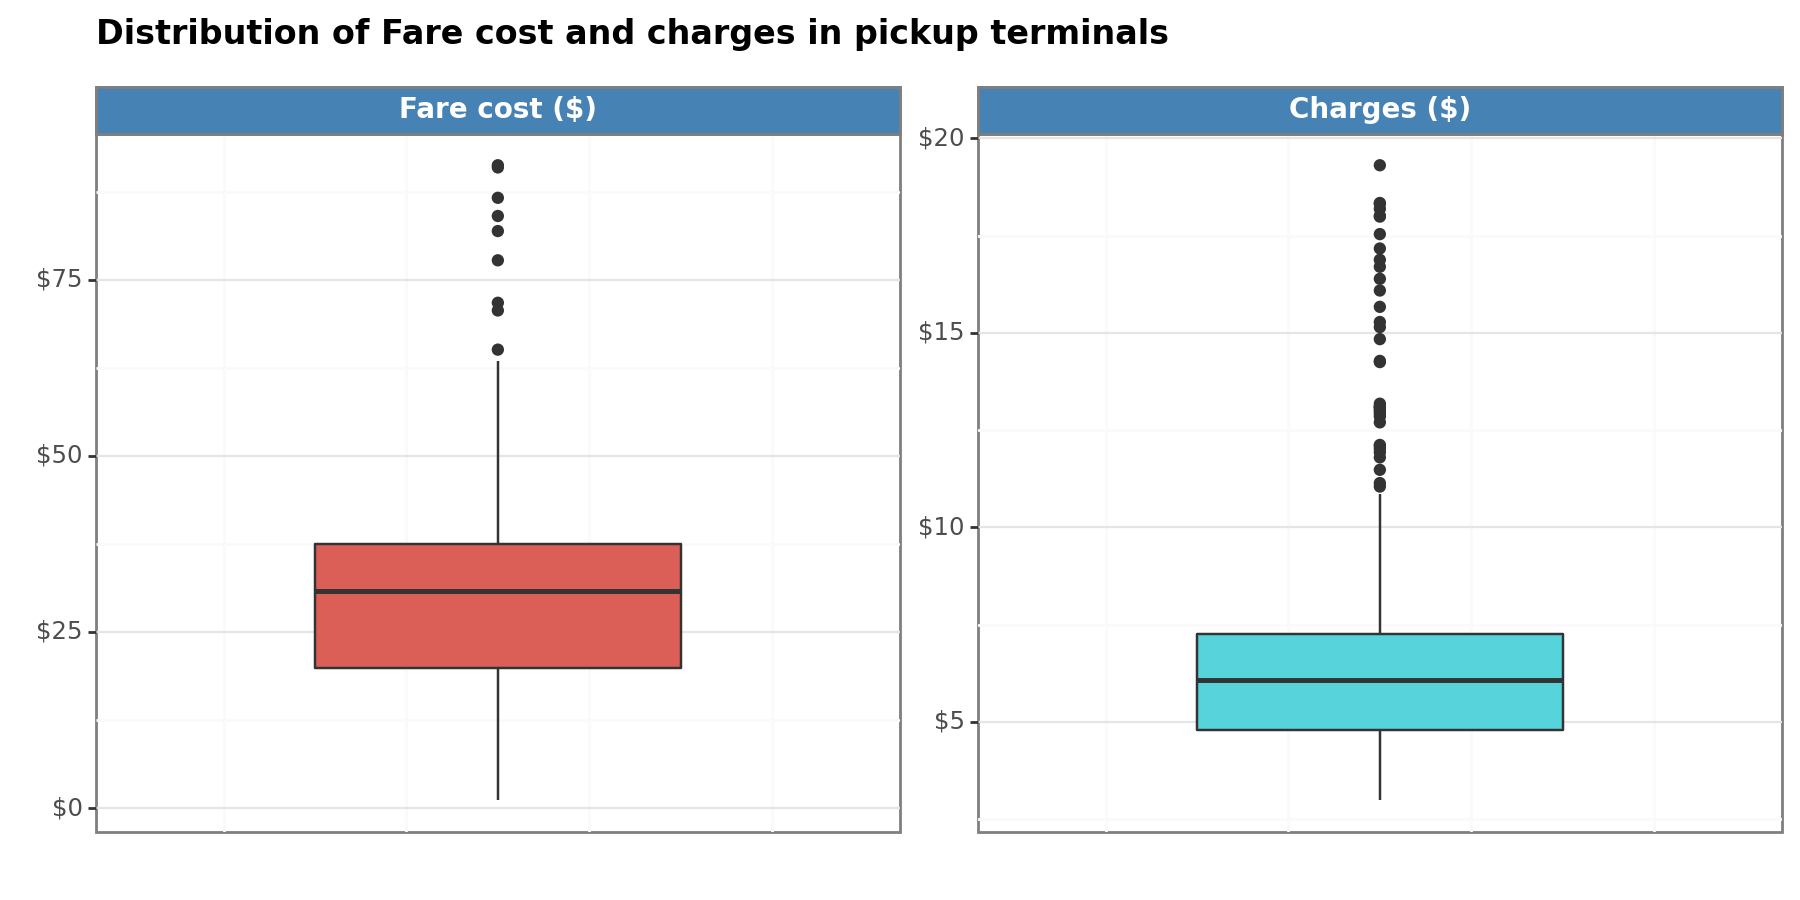

<Figure Size: (900 x 450)>

In [134]:
# how are charges and trip pricing distributed?
(
    pn.ggplot(station_summary.filter(['charges', 'avg_fare_cost']).melt(var_name='name'),
              pn.aes(y='value', fill='name')) +
    pn.geom_boxplot(width=0.2) +
    pn.facet_wrap('~name', scales='free_y', 
                  labeller=pn.as_labeller(
                      lambda x: 'Fare cost ($)' if 'fare' in x else x.title() + ' ($)')) +
    pn.theme_bw() + 
    pn.theme(figure_size=(9,4.5),
             legend_position='none',
             axis_ticks_major_x=pn.element_blank(),
             axis_text_x=pn.element_blank(),
             plot_title=pn.element_text(weight='bold', size=12),
             panel_grid_major_x=pn.element_blank(),
             strip_background=pn.element_rect(fill='steelblue'),
             strip_text=pn.element_text(color='white', size=10, weight='bold')) +
    pn.xlim(-0.2, 0.2) +
    pn.labs(title='Distribution of Fare cost and charges in pickup terminals', y='', x='') +
    pn.scale_y_continuous(labels=mfmt.dollar_format(digits=0))
)

In [135]:
describe_data(station_summary.avg_fare_cost)

In [136]:
describe_data(station_summary.charges)

- Fares cost between 1 and about 91 dollars while the charges given for a trip on average range between 2.99 dollars to 19.31 dollars

Next, we will look at stations with the most charges and trip costs

In [137]:
# get top and least 10 stations by charges and fare
top10_charges = station_summary.nlargest(10, 'charges')
top10_fare = station_summary.nlargest(10, 'avg_fare_cost')

least10_charges = station_summary.nsmallest(10, 'charges')
least10_fare = station_summary.nsmallest(10, 'avg_fare_cost')

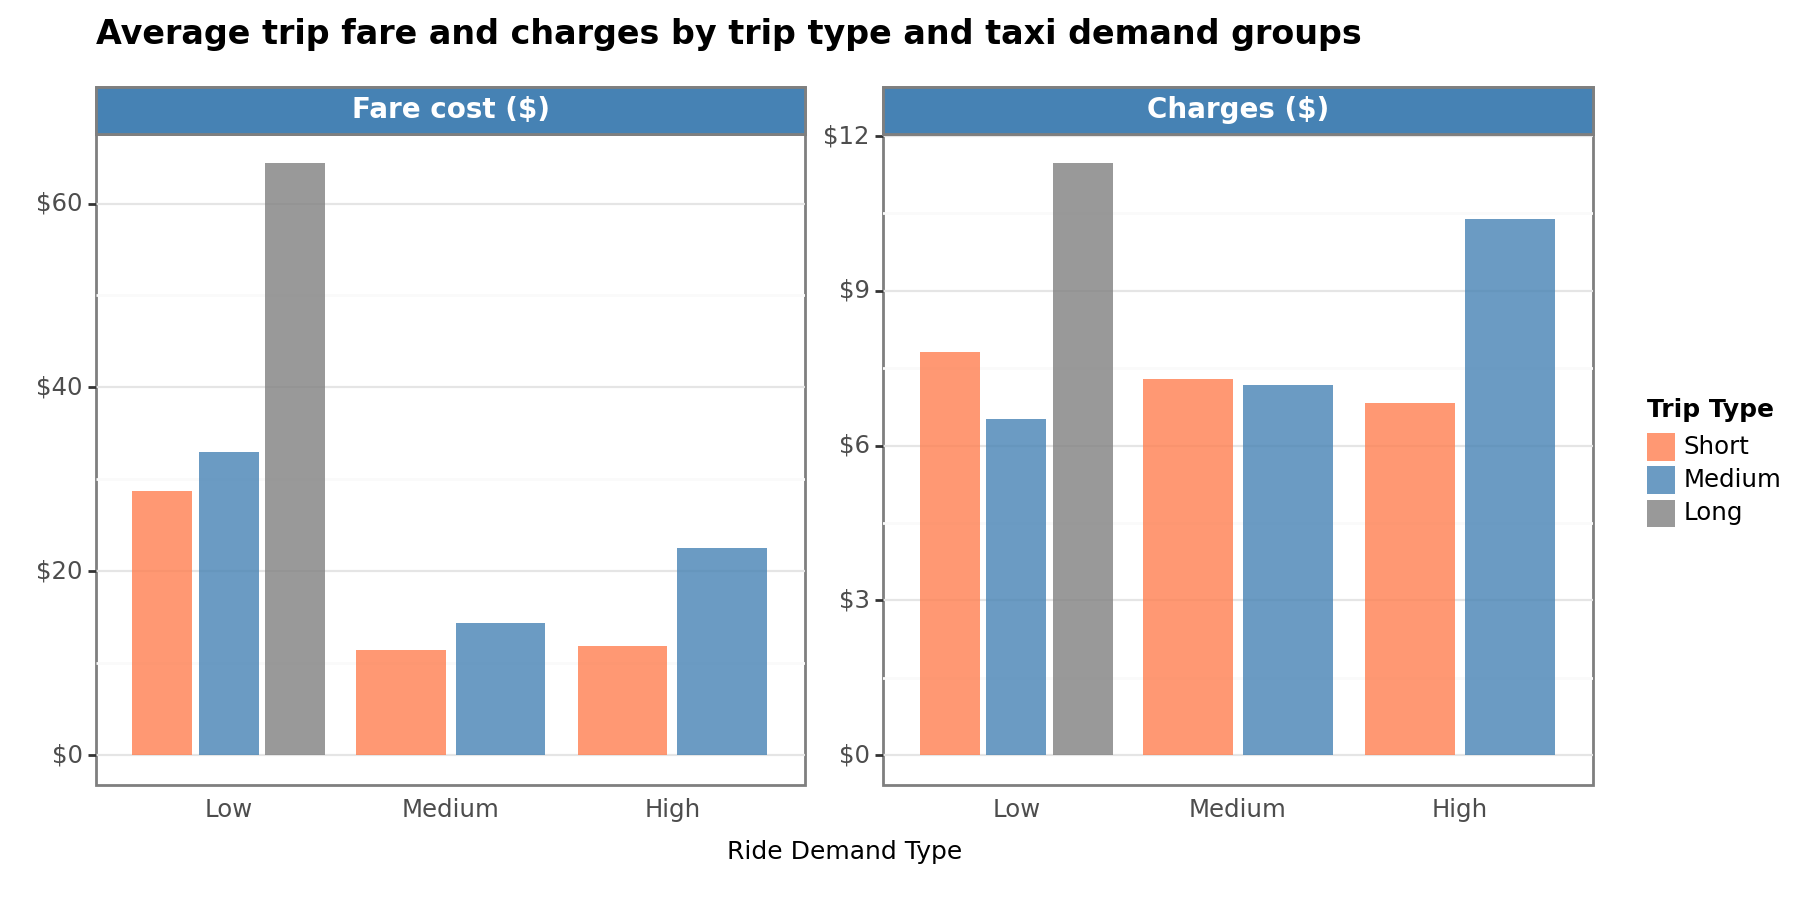

<Figure Size: (900 x 450)>

In [138]:
(
    pn.ggplot(
        (
            station_trips[['pickup_station', 'trip_type']]
            .merge(station_summary, on=['pickup_station'])
            .merge(station_rides[['pickup_station', 'group']], on='pickup_station')
            .melt(id_vars=['pickup_station', 'group', 'trip_type'], value_vars=['charges', 'avg_fare_cost'])
        ), pn.aes(x='group', y='value', fill='trip_type')
        )  +
pn.stat_summary(fun_y=np.mean, geom='bar', position=pn.position_dodge2(width=0.9), alpha=0.8) +
pn.facet_wrap('~variable', scales='free_y', 
              labeller=pn.as_labeller(
                  lambda x: 'Fare cost ($)' if 'fare' in x else 'Charges ($)')) +
pn.theme_bw() + 
pn.theme(figure_size=(9,4.5),
         legend_position='right',
         #legend_direction='vertical',
         legend_title = pn.element_text(size=9, weight='bold'),
         legend_key=pn.element_blank(),
         legend_key_size = 10,
         axis_title_x=pn.element_text(size=9),
         axis_ticks_major_x=pn.element_blank(),
         plot_title=pn.element_text(weight='bold', size=12),
         panel_grid_major_x=pn.element_blank(),
         strip_background=pn.element_rect(fill='steelblue'),
         strip_text=pn.element_text(color='white', size=10, weight='bold')) +
pn.labs(title='Average trip fare and charges by trip type and taxi demand groups', y='', x='Ride Demand Type') +
pn.scale_y_continuous(labels=mfmt.dollar_format(digits=0)) +
pn.guides(fill=pn.guide_legend(title='Trip Type', nrow=3)) +
pn.scale_fill_manual(values=['coral', 'steelblue', 'gray'])
)

Above shows the fare cost and trip charges by station grouped by taxi demand volume and trip type

- The trip fare for stations with low demand are higher than stations with medium or high demand. Similarly, the trip fare increases with trip distance. Short and medium trips have cost relatively the same (25-30 dollars) on average while longer trips cost over 60 dollars
- On the other hand, short trips in low, medium and high demand areas have relatively the same charges. This is the same in low and medium demand stations, however, it is different in low-demand and high-demand stations where medium and long trips from these stations incur quite higher amount in charges (charges more than 9 dollar on average).
- From the TLC data source, these charges come from airport fees, toll fees, improvement surcharges, congestion surcharges, MTA taxes, and other miscellaneous surchages from rush hour and overnight trips. Some of these charges are fixed and are automatically charged.
- The high charges and fare in low demand areas usually used for long trips will possibly come mainly from tolls fees while those from high demand areas could possibly come from mainly congestion charges and airport fees since from above, we found out that these high-demand areas are mostly located in densely populated areas or go to airports.

Next, we will look at top and least 10 stations based on charges and fare cost.

In [330]:
pd.read_sql(f"""
SELECT p.pickup_station, l.borough, l.zone, l.area_km2, l.n_cities, AVG(hourly_rides) as avg_rides
FROM pickup_trips p
JOIN location_info l
ON p.pickup_station = l.ride_station
WHERE pickup_station IN {top10_fare.pickup_station.pipe(tuple)}
GROUP BY p.pickup_station
""", con=conn)

pickup_station        borough                               zone  \
0               1            EWR                     Newark Airport   
1               5  Staten Island                      Arden Heights   
2              44  Staten Island             Charleston/Tottenville   
3              84  Staten Island  Eltingville/Annadale/Prince's Bay   
4              99  Staten Island                    Freshkills Park   
5             109  Staten Island                        Great Kills   
6             110  Staten Island                   Great Kills Park   
7             118  Staten Island        Heartland Village/Todt Hill   
8             204  Staten Island                  Rossville/Woodrow   
9             251  Staten Island                        Westerleigh   

    area_km2  n_cities  avg_rides  
0   7.343009       232   1.712977  
1   4.683694       170   1.003871  
2  13.546625      2118   1.041452  
3  13.086511       802   1.005128  
4  10.797699      1102   1.000000  
5   8.323939      1399   1.041420  
6   2.173668       578   1.000000  
7  17.175178       507   1.036036  
8   6.033846       206   1.007353  
9   5.880111       211   1.037175

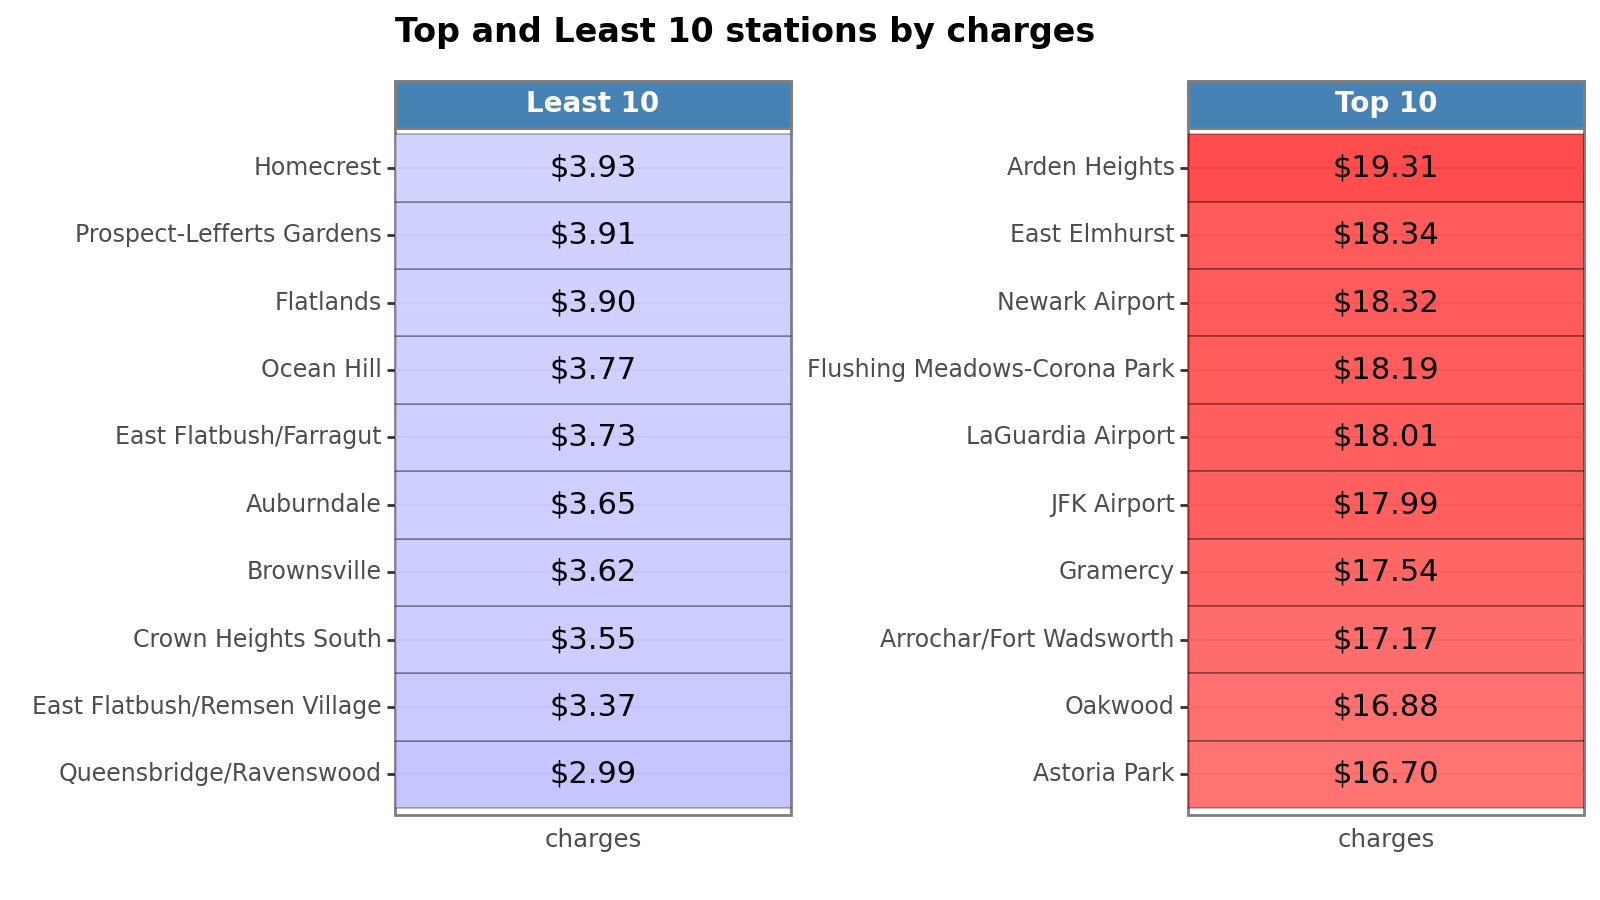

<Figure Size: (800 x 450)>

In [328]:
(
    pn.ggplot(pd.concat([top10_charges.assign(name='top'), 
                         least10_charges.assign(name='least')
                         ]).assign(group='charges'), 
        pn.aes(y='reorder(zone, charges)', x='group')) +
    pn.geom_tile(pn.aes(fill='charges', width=1), color='k', alpha=0.7)  +
    pn.geom_text(pn.aes(label='charges'), format_string='${:.2f}') +
    pn.facet_wrap('~name', scales='free', nrow=1, labeller=pn.as_labeller(lambda x: x.title() +' 10')) +
    pn.theme_bw() + 
    pn.theme(figure_size=(8,4.5),
            legend_position='none',
            axis_text_y=pn.element_text(size=8.5),
            axis_ticks_major_x=pn.element_blank(),
            plot_title=pn.element_text(weight='bold', size=12),
            panel_grid_major_x=pn.element_blank(),
            strip_background=pn.element_rect(fill='steelblue'),
            strip_text=pn.element_text(color='white', size=10, weight='bold')) +
    pn.scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 7) +
    pn.labs(title='Top and Least 10 stations by charges', y='', x='') +
    pn.coord_equal()
)

- Trips from facilities such as recreational parks, airports incur high charges. Probably due to airport fees, toll fees and other miscellaneous fees
- Trips from villages and counties or low populated areas seem to have the least charges

In [345]:
station_trips.query(f'pickup_station in {least10_fare.pickup_station.tolist()}')

pickup_station    borough                           zone  avg_duration  \
102             107  Manhattan                       Gramercy        833.04   
136             141  Manhattan                Lenox Hill West        737.05   
137             142  Manhattan            Lincoln Square East        835.33   
138             143  Manhattan            Lincoln Square West        815.77   
188             193     Queens        Queensbridge/Ravenswood        754.15   
224             229  Manhattan  Sutton Place/Turtle Bay North        780.66   
231             236  Manhattan          Upper East Side North        762.44   
232             237  Manhattan          Upper East Side South        752.34   
234             239  Manhattan          Upper West Side South        818.23   
258             263  Manhattan                 Yorkville West        735.10   

     avg_distance trip_type  
102          4.50     Short  
136          3.55     Short  
137          4.99     Short  
138          4.87     Short  
188          9.67     Short  
224          3.86     Short  
231          3.71     Short  
232          5.94     Short  
234          4.85     Short  
258          5.98     Short

In [341]:
station_trips.query(f'pickup_station in {top10_fare.pickup_station.tolist()}')

pickup_station        borough                               zone  \
0                 1            EWR                     Newark Airport   
4                 5  Staten Island                      Arden Heights   
43               44  Staten Island             Charleston/Tottenville   
82               84  Staten Island  Eltingville/Annadale/Prince's Bay   
97               99  Staten Island                    Freshkills Park   
104             109  Staten Island                        Great Kills   
105             110  Staten Island                   Great Kills Park   
113             118  Staten Island        Heartland Village/Todt Hill   
199             204  Staten Island                  Rossville/Woodrow   
246             251  Staten Island                        Westerleigh   

     avg_duration  avg_distance trip_type  
0          177.89          1.09     Short  
4         4365.32         16.95      Long  
43        3201.43         30.13      Long  
82        3232.99         22.00      Long  
97        3553.95         27.98      Long  
104       2842.45         13.55      Long  
105       4267.50         24.45      Long  
113       3201.89         19.00      Long  
199       2703.68         26.22      Long  
246       2548.82         13.83    Medium

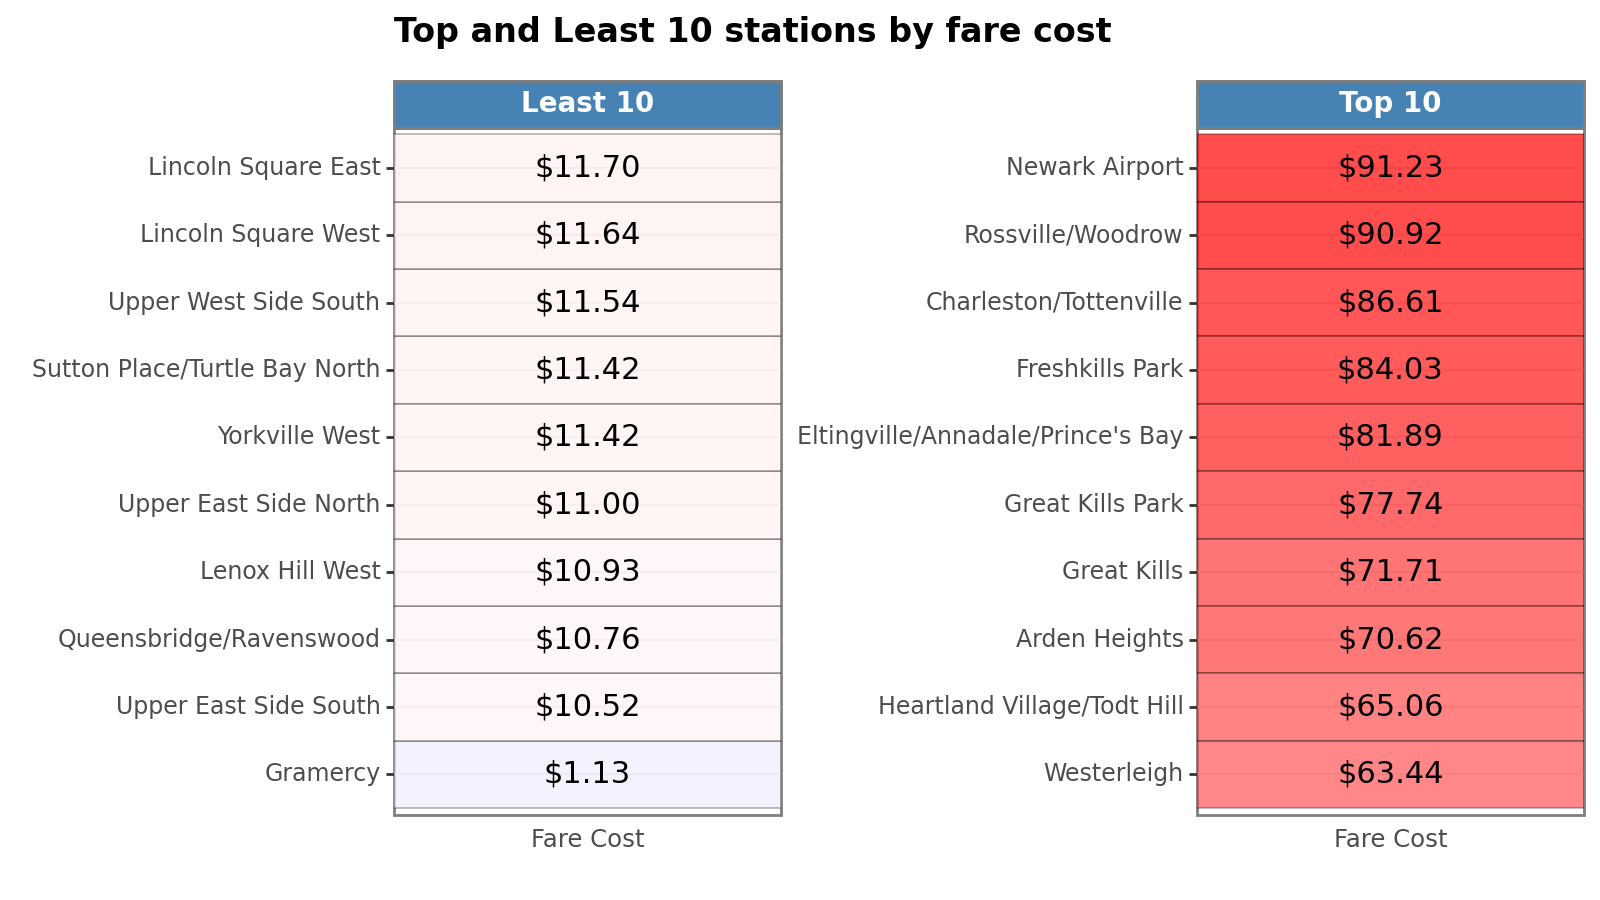

<Figure Size: (800 x 450)>

In [140]:
(
    pn.ggplot(pd.concat([top10_fare.assign(name='top'), least10_fare.assign(name='least')]).assign(group='Fare Cost'), 
        pn.aes(y='reorder(zone, avg_fare_cost)', x='group')) +
    pn.geom_tile(pn.aes(fill='avg_fare_cost', width=1), color='k', alpha=0.7)  +
    pn.geom_text(pn.aes(label='avg_fare_cost'), format_string='${:.2f}') +
    pn.facet_wrap('~name', scales='free', nrow=1, labeller=pn.as_labeller(lambda x: x.title() +' 10')) +
    pn.theme_bw() + 
    pn.theme(figure_size=(8,4.5),
            legend_position='none',
            axis_text_y=pn.element_text(size=8.5),
            axis_ticks_major_x=pn.element_blank(),
            plot_title=pn.element_text(weight='bold', size=12),
            panel_grid_major_x=pn.element_blank(),
            strip_background=pn.element_rect(fill='steelblue'),
            strip_text=pn.element_text(color='white', size=10, weight='bold')) +
    pn.scale_fill_gradient2(low = "blue", high = "red", mid = "white", midpoint = 7) +
    pn.labs(title='Top and Least 10 stations by fare cost', y='', x='') +
    pn.coord_fixed()

)

- On the other hand, trips from Gramercy cost the least with a trip costing about 1.13 dollars on average.
- Trips from high-demand areas such as Upper East Side (North, South), Lincoln Square East, Lenox Hill West and Upper West side cost at least 10 dollars on average.
- Additionally, trips to recreational centres, parks or tourist attractions cost very high, with a trip likely to cost above $50 on average.

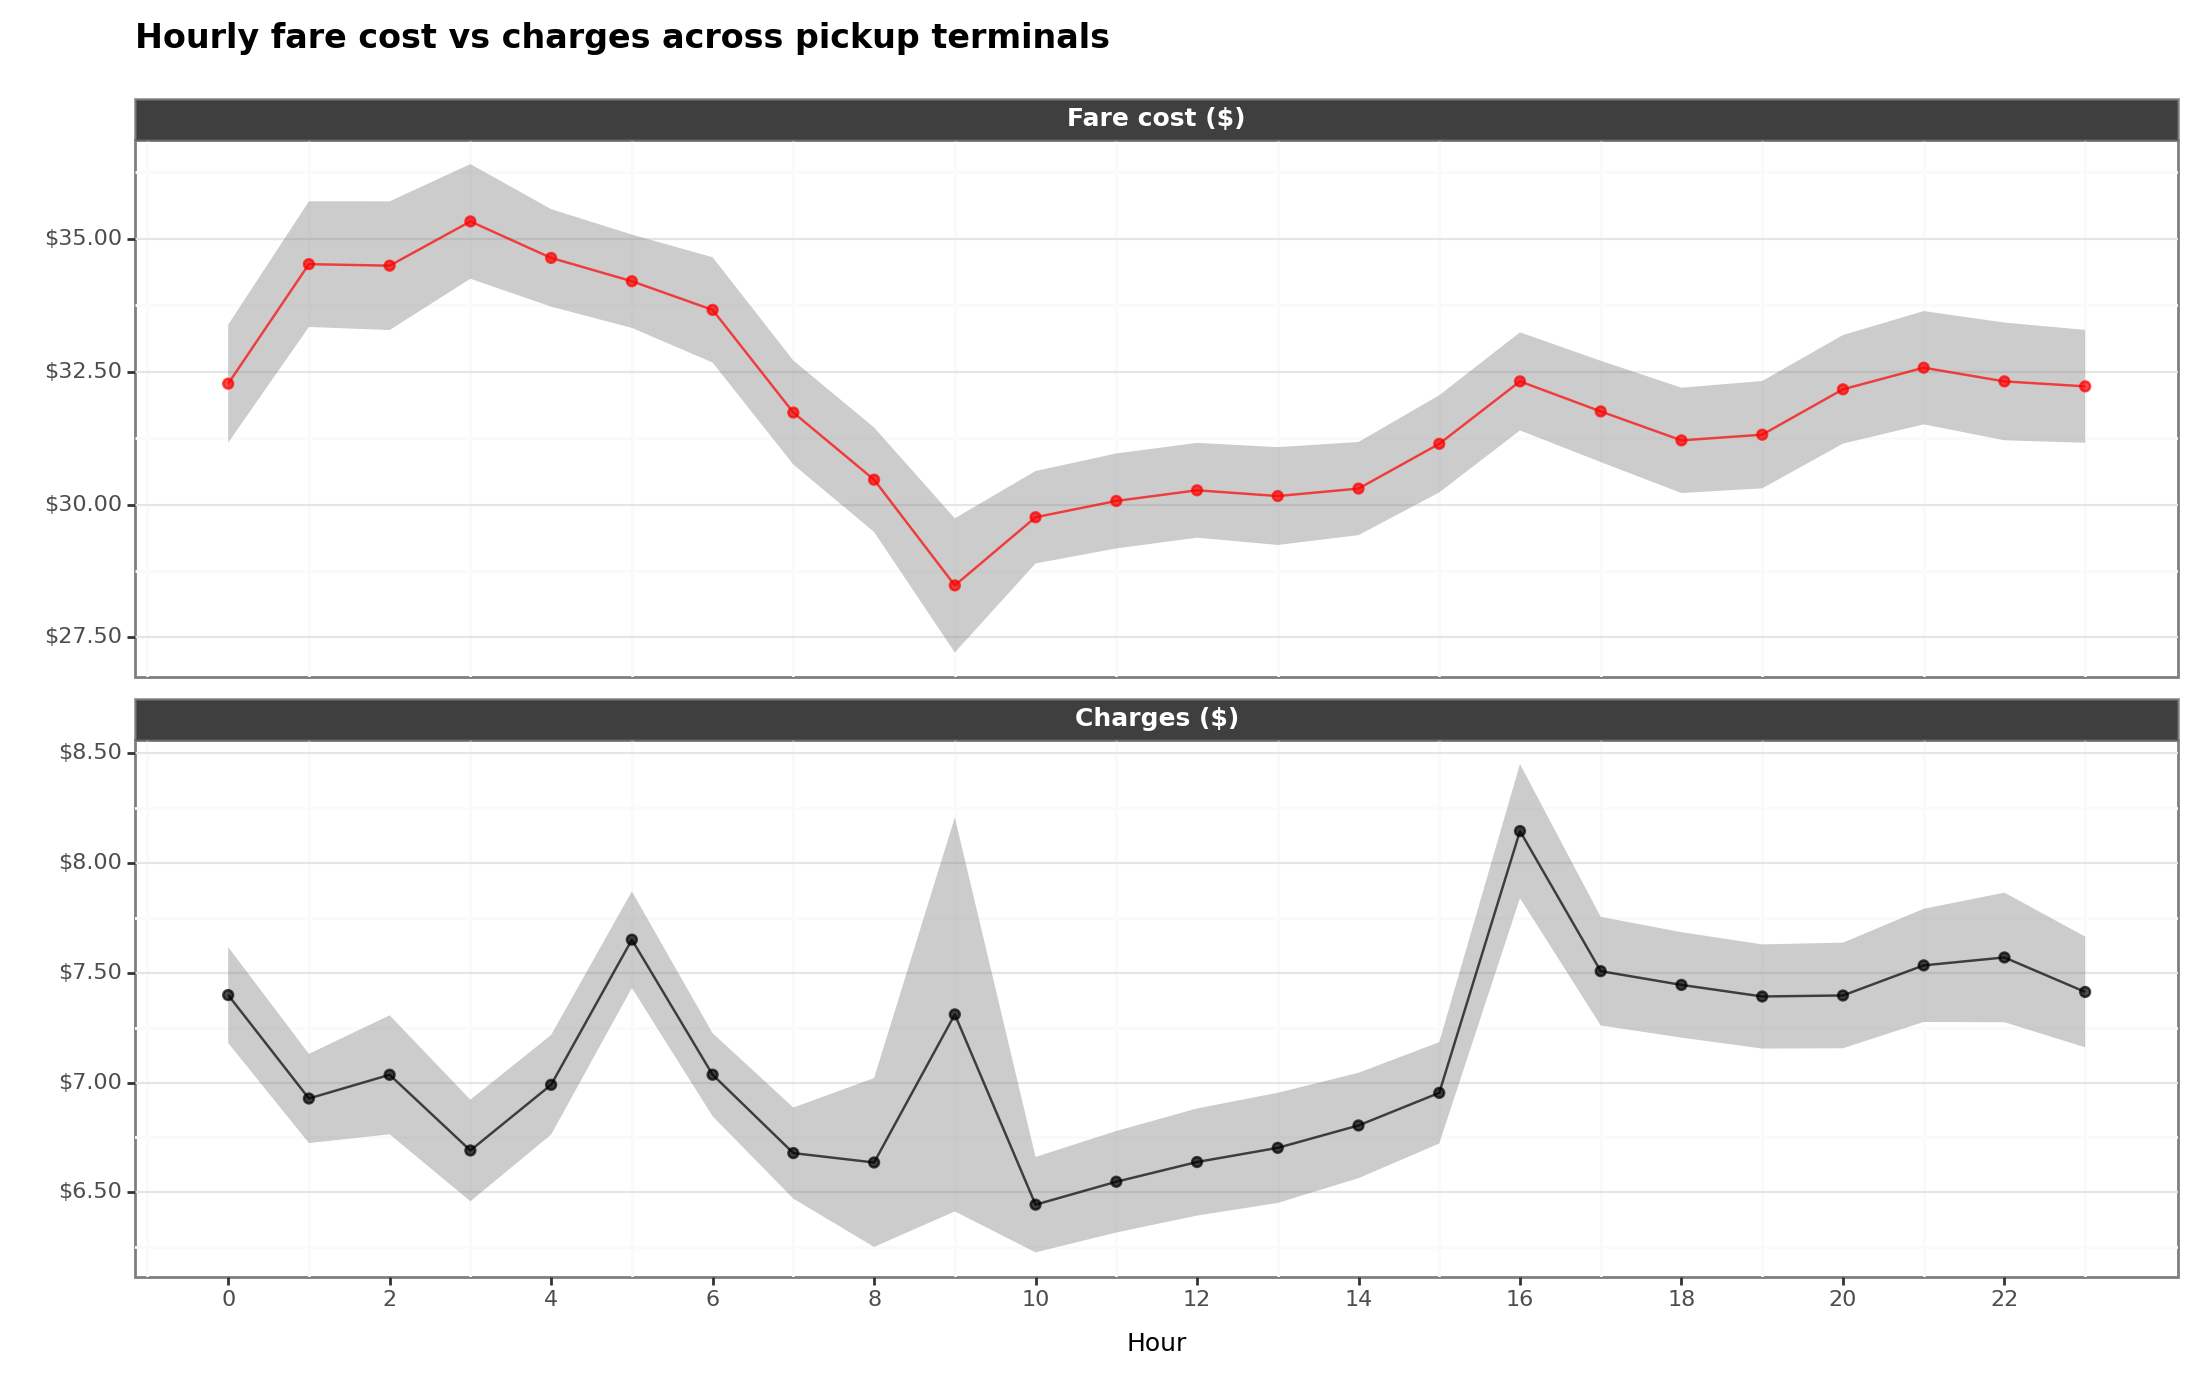

<Figure Size: (1100 x 700)>

In [141]:
# charges and fare costs at each hour of the day
# def mean_se(x):
#     x_mean = np.mean(x)
#     n = len(x)
#     x_sd = np.std(x)
#     ymin = x_mean - (x_sd/np.sqrt(n))
#     ymax = x_mean + (x_sd/np.sqrt(n))
#     return pd.DataFrame({'y':x_mean, 'ymin':ymin, 'ymax':ymax}, index=[0])

(
    pn.ggplot(station_hourly_summary.melt(id_vars=['hour'], value_vars=['charges', 'avg_fare_cost'], var_name='type'),
              pn.aes(x='hour.astype(int)', y='value')) +
    pn.stat_summary(fun_data='mean_se', alpha=0.4, geom='ribbon', fill = "grey") +
    pn.stat_summary(mapping=pn.aes(color='type'), fun_y=np.mean, geom='path', alpha=0.7) +
    pn.stat_summary(mapping=pn.aes(color='type'), fun_y=np.mean, geom='point', alpha=0.7) +
    pn.facet_wrap('~type', scales='free_y', nrow=2, 
                  labeller=pn.as_labeller(
                      lambda x: 'Fare cost ($)' if 'fare' in x else x.title()+' ($)')) + 
    pn.theme_bw() +
    pn.theme(figure_size=(11,7),
             legend_position='none',
             legend_direction='horizontal',
             legend_title=pn.element_blank(),
             legend_text=pn.element_text(size=8),
             legend_key=pn.element_blank(),
             strip_background=pn.element_rect(fill='black', alpha=0.5),
             strip_text=pn.element_text(color='white', size=9, face='bold'),
             panel_grid_major_x = pn.element_blank(),
             axis_text=pn.element_text(size=8),
             axis_title=pn.element_text(size=9),
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.scale_x_continuous(breaks=range(0,24,2)) +
    pn.scale_y_continuous(labels=mfmt.dollar_format(digits=2, big_mark=',')) +
    pn.labs(x='Hour', y='') +
    pn.ggtitle('Hourly fare cost vs charges across pickup terminals') +
    pn.scale_colour_manual(values=['red', 'black'], labels=['Fare cost', 'Charges'])
)


- There is an impact of hour on the fare and charges
- During the night hours the trip fare is higher than during the day. 
- During the late hours of the night, the trip fare increases and peaks at 3 AM and begins to decline slowly from 4 AM to 9 AM. Thereafter, it begins to increase and peask a scond time during the close of day (5 AM) and stays relatively the same till the rest of the day.
- On the other hand, charges are somewhat irregular. However, there are events of the day where it is higher. One is during the late or early hours of the morning. The other is during rush hours (8-9 AM and 4-5 PM)

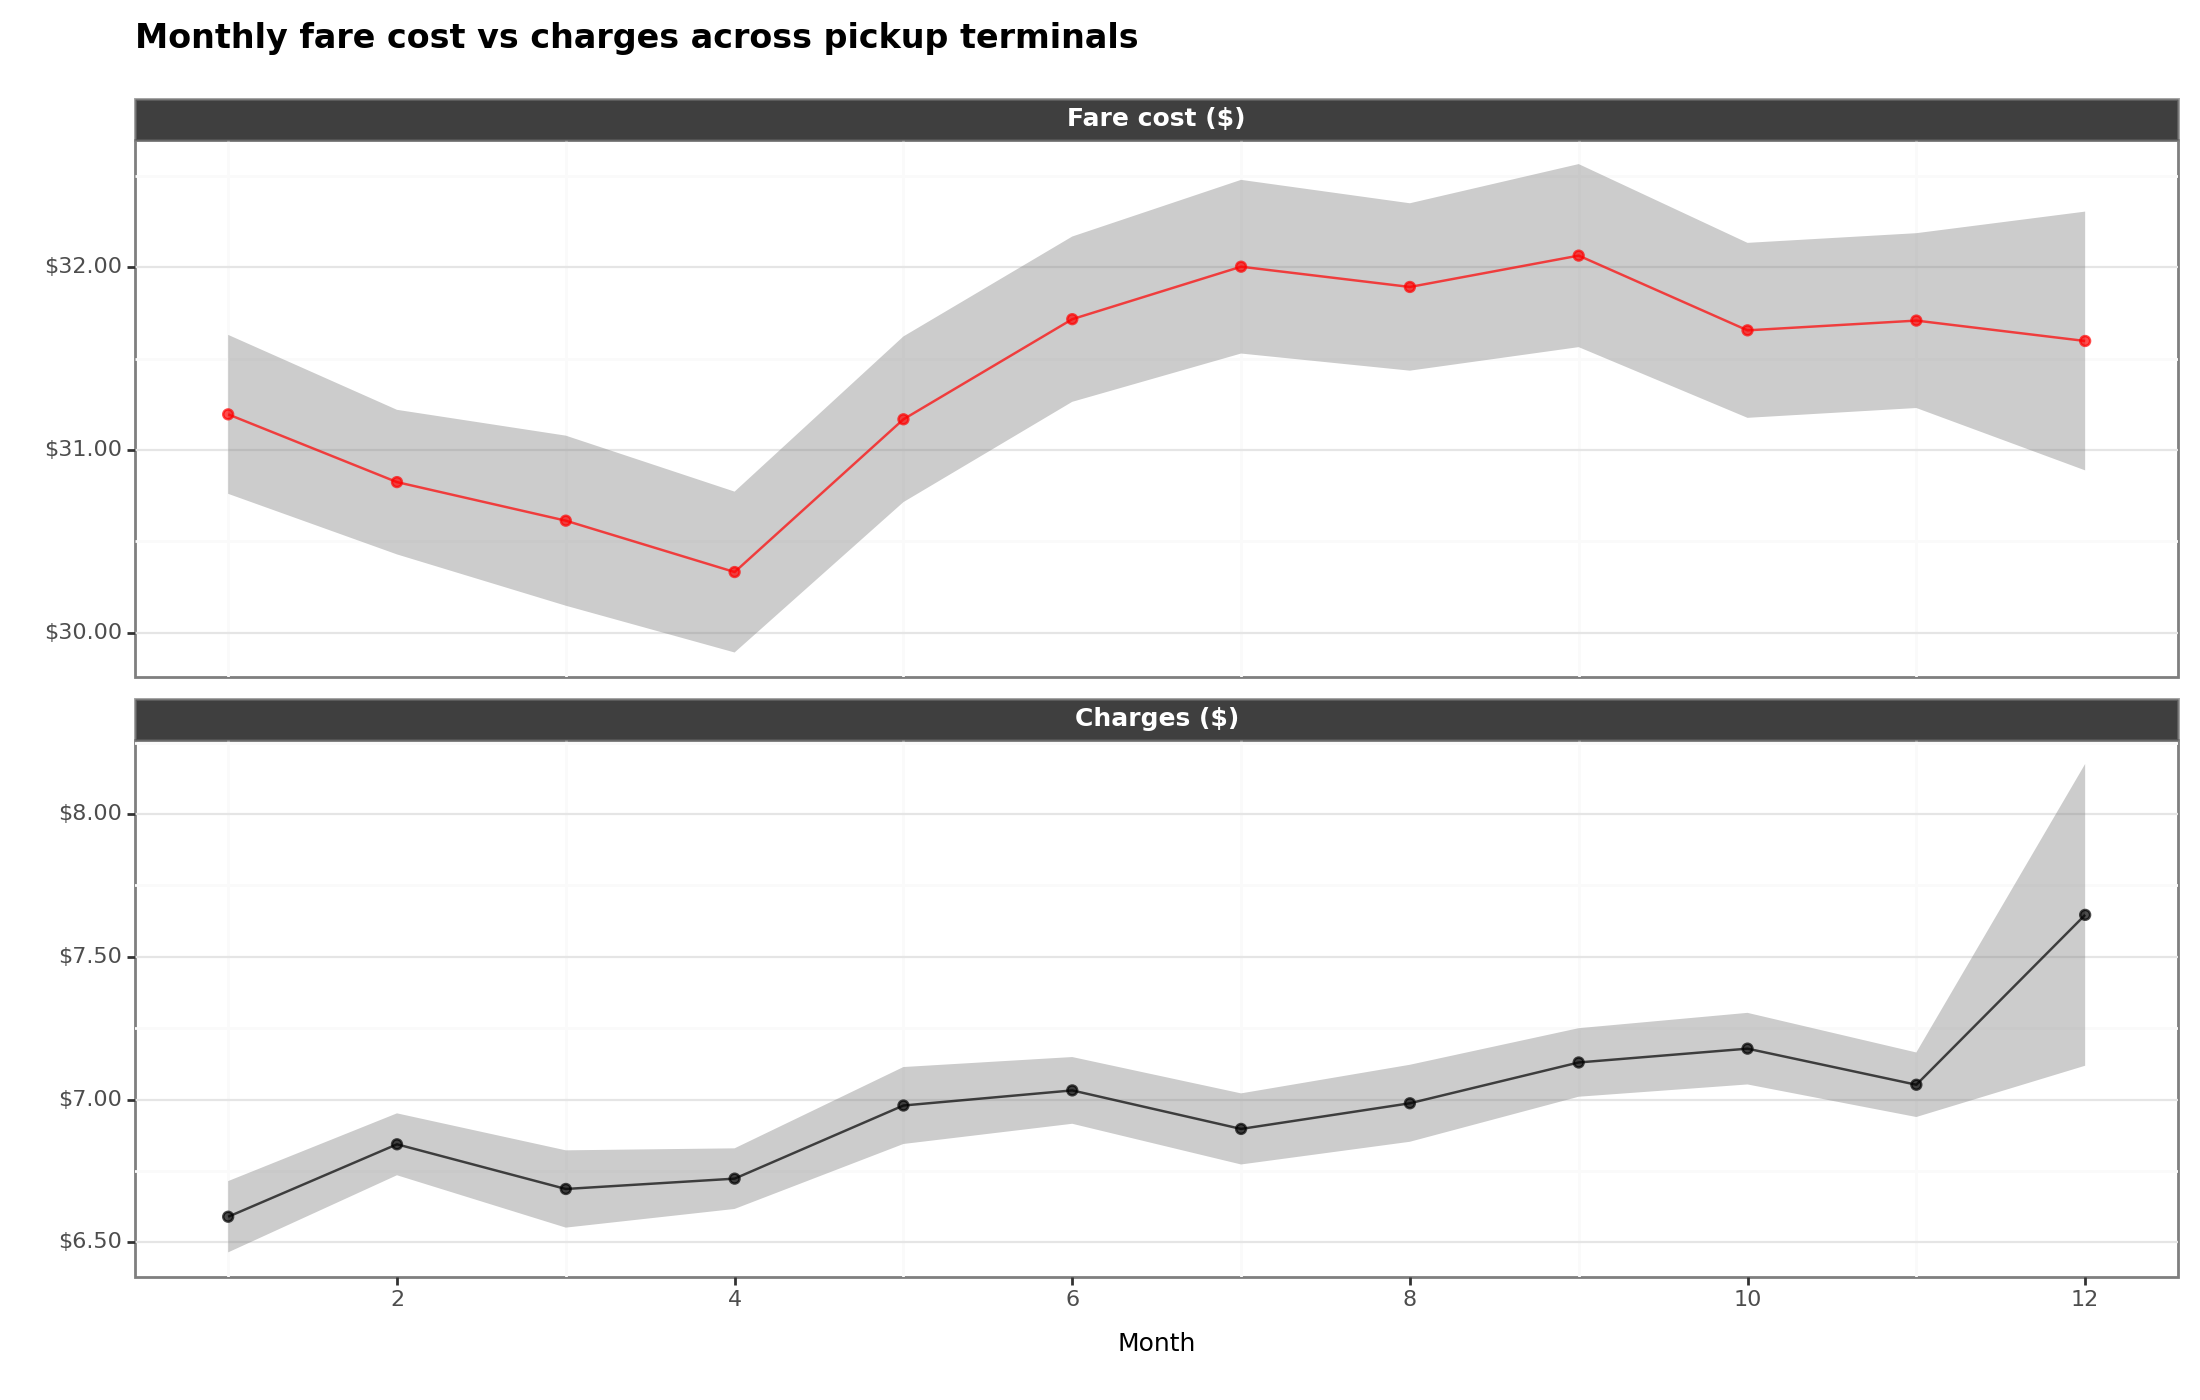

<Figure Size: (1100 x 700)>

In [142]:
(
    pn.ggplot(station_monthly_summary.melt(id_vars=['month'], value_vars=['charges', 'avg_fare_cost'], var_name='type'),
              pn.aes(x='month.astype(int)', y='value')) +
    pn.stat_summary(fun_data='mean_se', alpha=0.4, geom='ribbon', fill = "grey") +
    pn.stat_summary(mapping=pn.aes(color='type'), fun_y=np.mean,geom='path', alpha=0.7) +
    pn.stat_summary(mapping=pn.aes(color='type'), fun_y=np.mean,geom='point', alpha=0.7) +
    pn.facet_wrap('~type', scales='free_y', nrow=2, 
                  labeller=pn.as_labeller(
                      lambda x: 'Fare cost ($)' if 'fare' in x else x.title()+' ($)')) + 
    pn.theme_bw() +
    pn.theme(figure_size=(11,7),
             legend_position='none',
             legend_direction='horizontal',
             legend_title=pn.element_blank(),
             legend_text=pn.element_text(size=8),
             legend_key=pn.element_blank(),
             strip_background=pn.element_rect(fill='black', alpha=0.5),
             strip_text=pn.element_text(color='white', size=9, face='bold'),
             panel_grid_major_x = pn.element_blank(),
             axis_text=pn.element_text(size=8),
             axis_title=pn.element_text(size=9),
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.scale_x_continuous(breaks=range(0,24,2)) +
    pn.scale_y_continuous(labels=mfmt.dollar_format(digits=2, big_mark=',')) +
    pn.labs(x='Month', y='') +
    pn.ggtitle('Monthly fare cost vs charges across pickup terminals') +
    pn.scale_colour_manual(values=['red', 'black'], labels=['Fare cost', 'Charges'])
)

- The month of the year also determines the trip fare and possible charges 
- Trip fare declines at the beginning of the year and begins to increase towards the Summer and Fall seasons before declining slightly towards the end of the year.
- This is relatively the same for charges. During the summer holidays, charges are slightly higher than normal. Another month of the year is during the Christamas holidays where the charges are higher than in other months. This could be because these times of the year there are so much activities due to the Summer and Christmas holidays. For instance, during the Summer holidays, families and friends mostly go on vacations and trips to cities and places such as recreational centers, parks etc. This is the same during the Christmas holidays.
- Capitalising on these times of the day and months of the year could help improve revenue. One way would be to introduce discounts to regular commuters, collaborate with manager at parks, tourist and recreational centers and introducing family packages to commuter to encourage friends and families to purchase cab tickets for their trips.

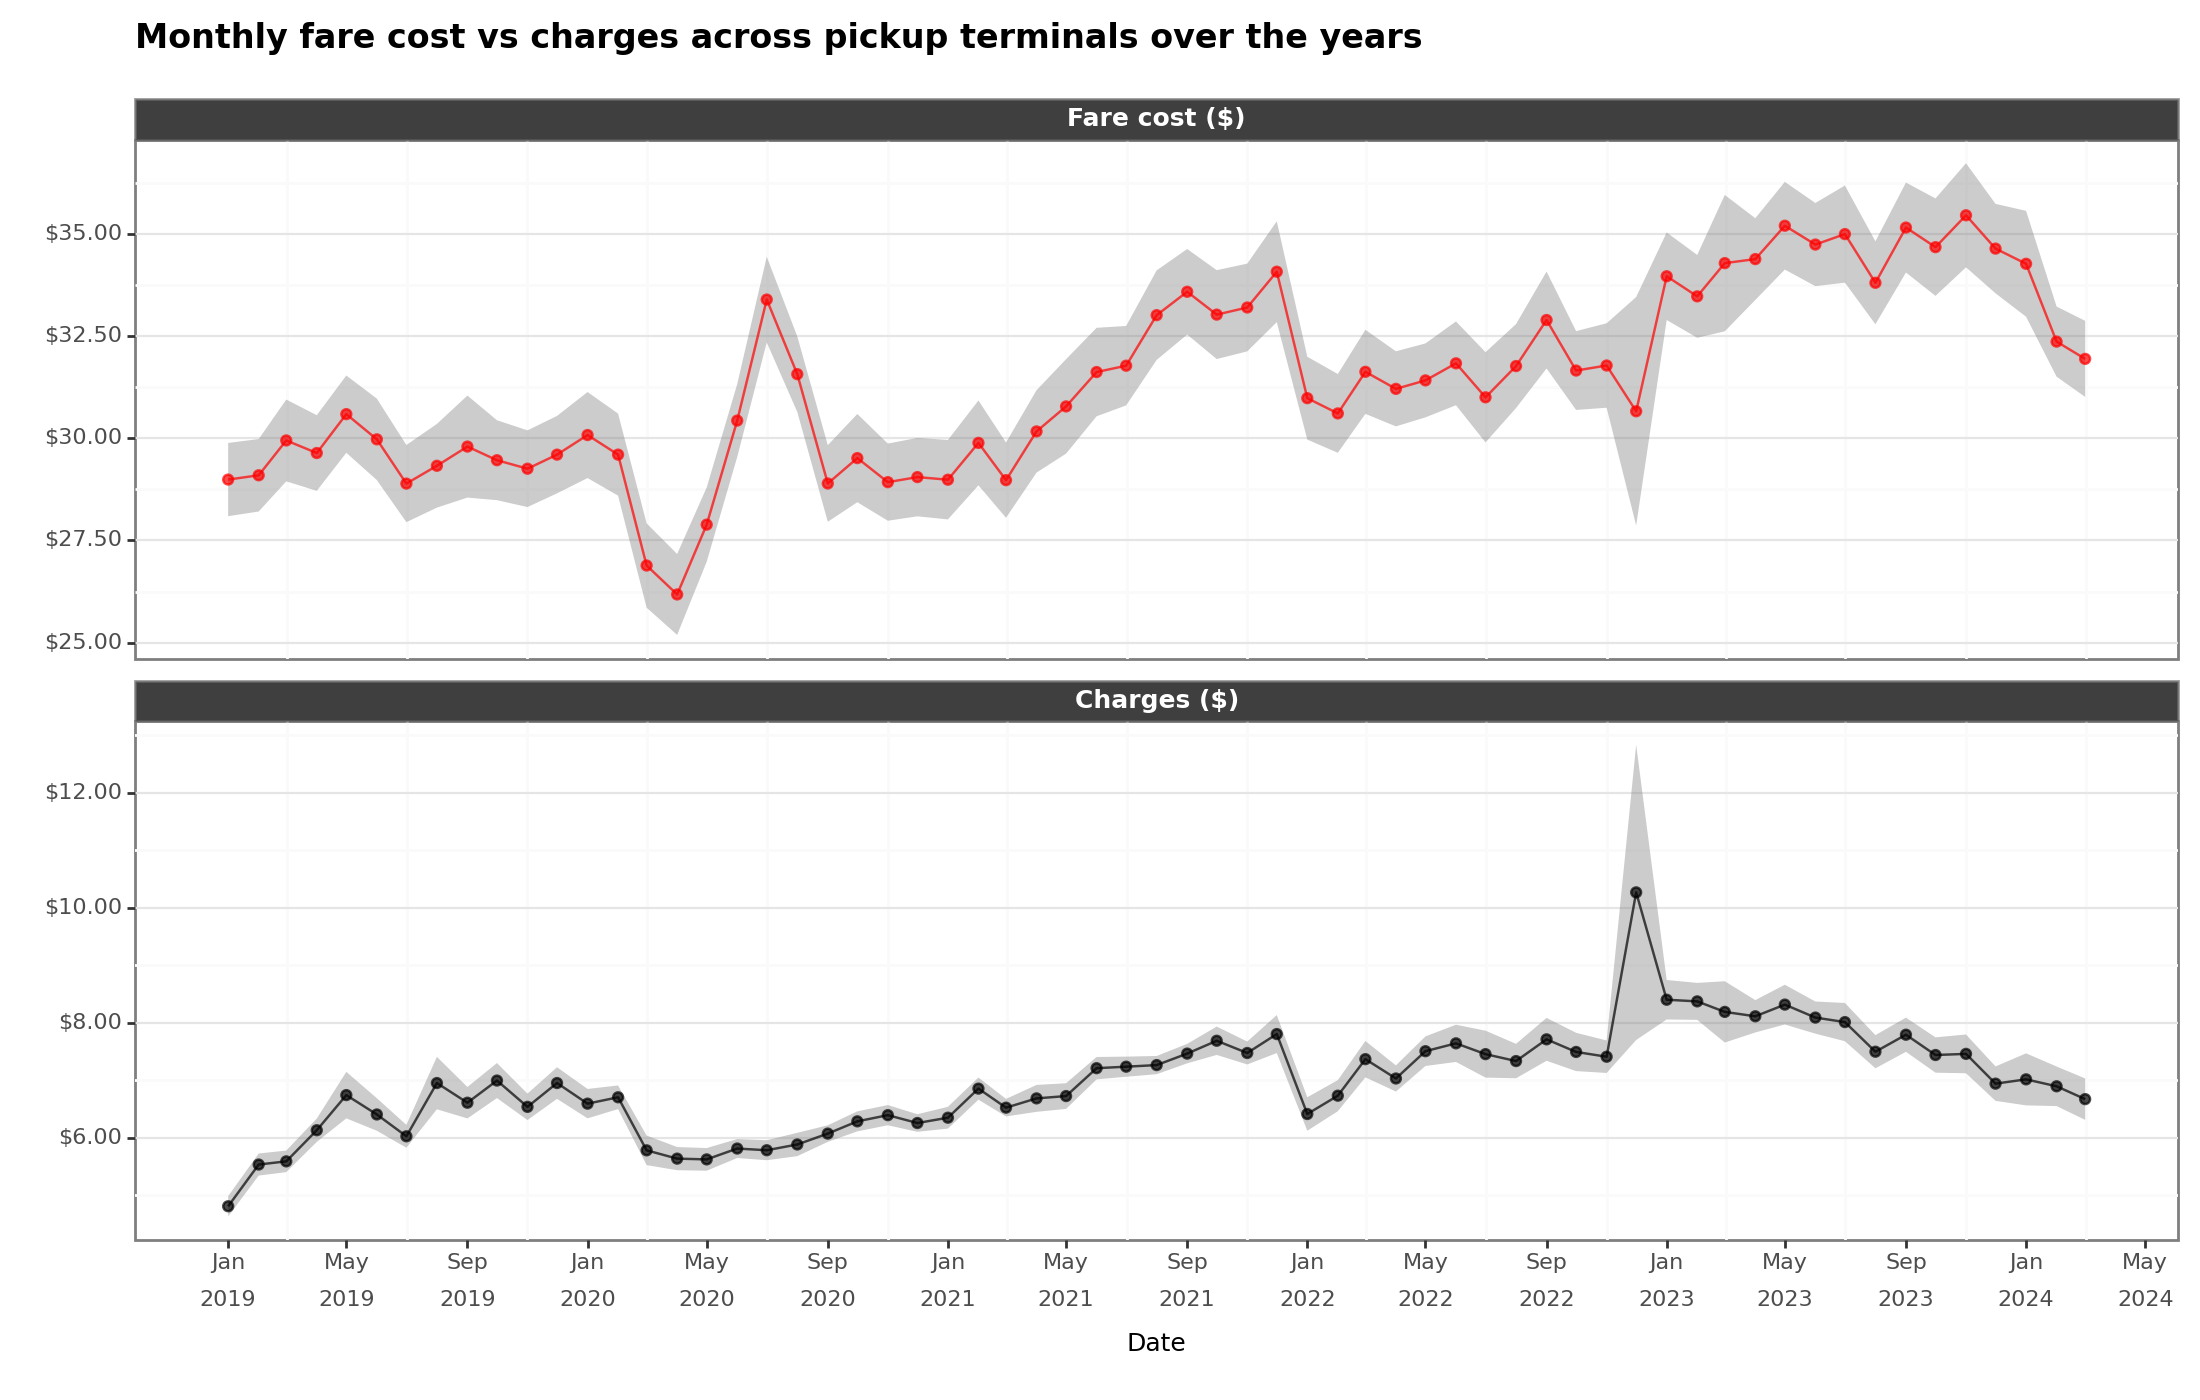

<Figure Size: (1100 x 700)>

In [143]:
(
    pn.ggplot(station_monthly_summary.melt(id_vars=['date'], value_vars=['charges', 'avg_fare_cost'], var_name='type'),
              pn.aes(x='date', y='value')) +
    pn.stat_summary(fun_data='mean_se', alpha=0.4, geom='ribbon', fill = "grey") +
    pn.stat_summary(mapping=pn.aes(color='type'), fun_y=np.mean,geom='path', alpha=0.7) +
    pn.stat_summary(mapping=pn.aes(color='type'), fun_y=np.mean,geom='point', alpha=0.7) +
    pn.facet_wrap('~type', scales='free_y', nrow=2, 
                  labeller=pn.as_labeller(
                      lambda x: 'Fare cost ($)' if 'fare' in x else x.title()+' ($)')) + 
    pn.theme_bw() +
    pn.theme(figure_size=(11,7),
             legend_position='none',
             legend_direction='horizontal',
             legend_title=pn.element_blank(),
             legend_text=pn.element_text(size=8),
             legend_key=pn.element_blank(),
             strip_background=pn.element_rect(fill='black', alpha=0.5),
             strip_text=pn.element_text(color='white', size=9, face='bold'),
             panel_grid_major_x = pn.element_blank(),
             axis_text=pn.element_text(size=8),
             axis_title=pn.element_text(size=9),
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.scale_x_date(date_labels='%b\n\n%Y', date_breaks='4 month',) +
    pn.scale_y_continuous(labels=mfmt.dollar_format(digits=2, big_mark=',')) +
    pn.labs(x='Date', y='') +
    pn.ggtitle('Monthly fare cost vs charges across pickup terminals over the years') +
    pn.scale_colour_manual(values=['red', 'black'], labels=['Fare cost', 'Charges'])
)

- Looking at the monthly fare cost and charges for the past years, we see that since 2021 there's an irregular movement in trip fares and charges over the year, with some most uptrends.

### G. Revenue and ride volume by pickup station and borough (Map)

In [144]:
# converting geomerty to EPSG 4326 (degrees)
nyc.geometry = nyc.geometry.to_crs(epsg=4326)

In [145]:
# load location table and rename coordinates to latitude and longitude
loc_info = pd.read_sql_query("""Select * from location_info""", conn)

# convert to geopandas dataframe 
loc_info = gpd.GeoDataFrame(loc_info, geometry=gpd.points_from_xy(loc_info.longitude, loc_info.latitude))

In [146]:
# group borough and get the centroid point
loc_coordinates = loc_info.groupby('borough').agg(
    {
        'latitude' : 'mean', 'longitude':'mean', 'n_cities' : 'sum'
}).reset_index()

# merging data from station rides to New York geographical information
nyc = (nyc
       .rename({'LocationID':'pickup_station'}, axis=1)
       .merge(station_rides.drop(['zone', 'borough'], axis=1), on='pickup_station')
       )

In [147]:
# adding total revenue, total pickup rides and total dropoff rides
loc_coordinates = (
    loc_coordinates
    .merge(station_rides.groupby('borough')[['total_revenue', 'total_pickup_rides', 'total_dropoff_rides']].sum()
    .reset_index(), on='borough')
    )

In [148]:
# adding center location
nyc = (
    nyc
    .merge(loc_info[['ride_station', 'latitude', 'longitude']]
           .rename({'ride_station' : 'pickup_station'}, axis=1), on='pickup_station')
)

In [150]:
# top 1 station in each borough by total pickups and revenue
top_pickups = nyc.groupby('borough').apply(lambda x: x.nlargest(1, 'total_pickup_rides'), include_groups=False)
top_revenue = nyc.groupby('borough').apply(lambda x: x.nlargest(1, 'total_revenue'), include_groups=False)

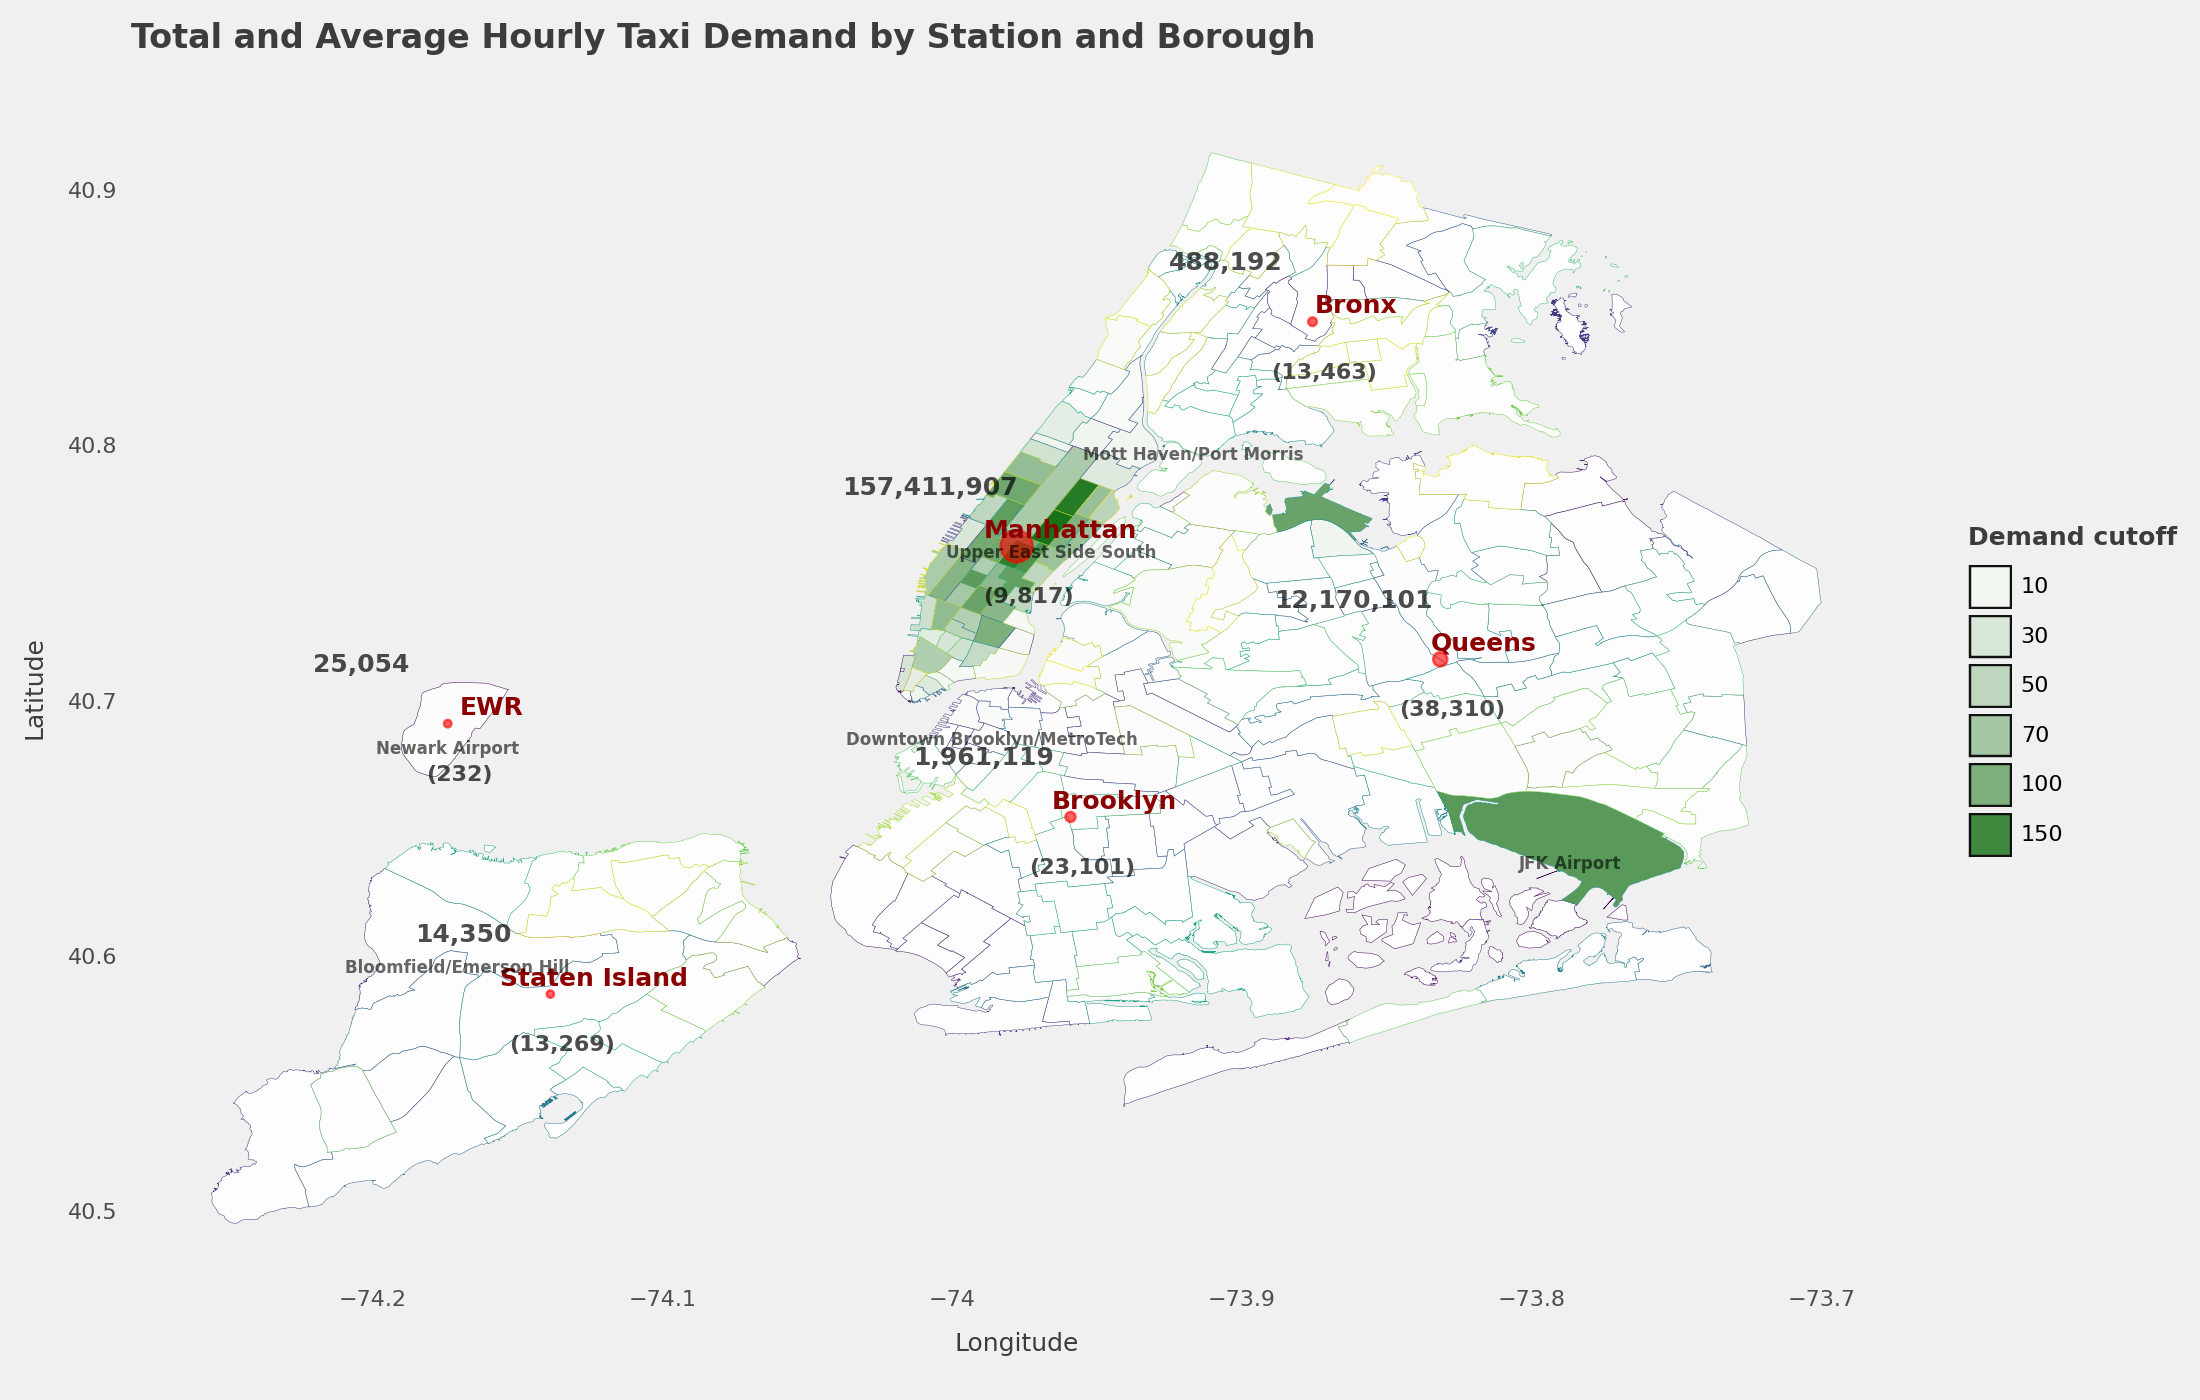

<Figure Size: (1100 x 700)>

In [151]:
(
    pn.ggplot(nyc, pn.aes(x='longitude', y='latitude')) +
    pn.geom_map(pn.aes(fill='avg_pickup_rides', color='pickup_station'), alpha=0.9, size=0.1) +
    pn.geom_point(data=loc_coordinates, mapping=pn.aes(x='longitude', y='latitude', size='total_pickup_rides'), 
                  color='r', alpha=0.6) +
    pn.geom_text(loc_coordinates, pn.aes(x='longitude', y='latitude', label='borough'), 
                 color='darkred', size=9, nudge_y=0.006, nudge_x=0.015, fontweight='bold') +
    pn.geom_text(top_pickups, pn.aes(x='longitude', y='latitude', label='zone'), color='k', 
                 size=6, fontweight='bold', alpha=0.6, nudge_y=-0.01) +
    pn.geom_text(loc_coordinates, pn.aes(x='longitude', y='latitude', label='total_pickup_rides'), 
                 color='k', size=9, nudge_y=0.023, nudge_x=-0.03, format_string='{:,.0f}', 
                 fontweight='bold', alpha=0.7) +
    pn.geom_text(loc_coordinates, pn.aes(x='longitude', y='latitude', label='n_cities'), 
                 color='k', size=8, nudge_y=-0.02, nudge_x=0.004, fontweight='bold', 
                 format_string='({:,.0f})', alpha=0.7) +
    pn.theme_538() +
    pn.theme(figure_size=(11,7),
             legend_position='right',
             legend_direction='vertical',
             legend_text=pn.element_text(size=8),
             legend_key=pn.element_blank(),
             legend_title=pn.element_text(size=9, weight='bold'),
             panel_grid= pn.element_blank(),
             axis_text=pn.element_text(size=8),
             axis_title=pn.element_text(size=9), 
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.scale_fill_gradient(low='white', high='darkgreen', breaks=[10, 30, 50, 70, 100, 150, 200]) +
    pn.labs(x='Longitude', y='Latitude', fill='Total Rides') +
    pn.ggtitle(title='Total and Average Hourly Taxi Demand by Station and Borough') +
    pn.guides(fill=pn.guide_legend(title='Demand cutoff'), size=False, color=False)
)

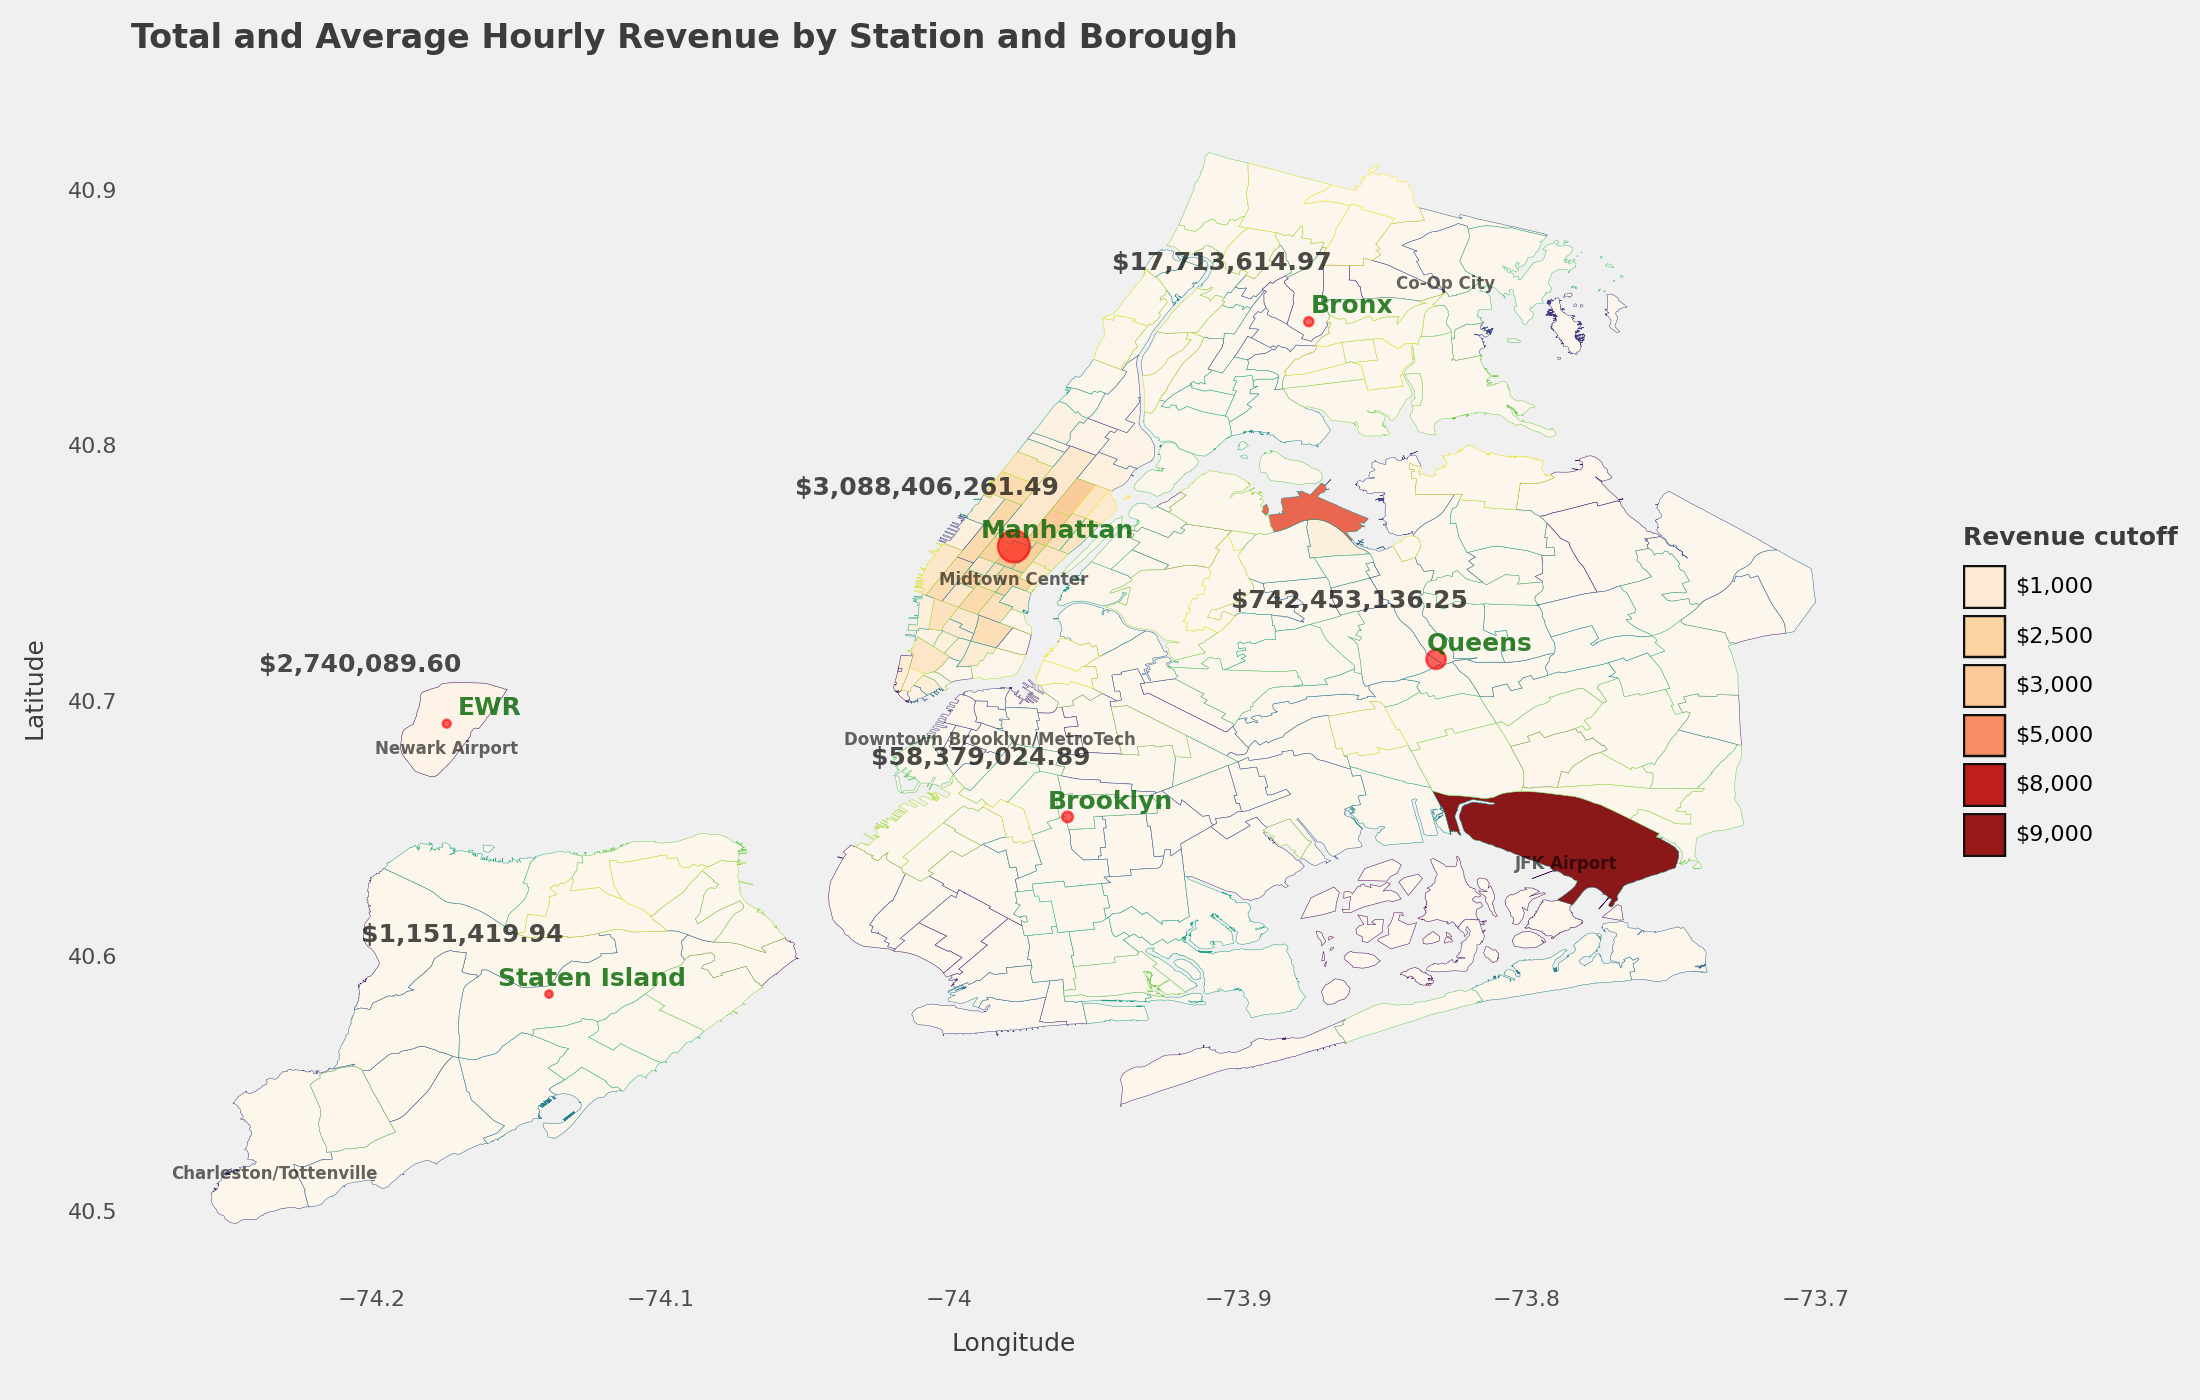

<Figure Size: (1100 x 700)>

In [152]:
(
    pn.ggplot(nyc, pn.aes(x='longitude', y='latitude')) +
    pn.geom_map(pn.aes(fill='avg_revenue', color='pickup_station'), alpha=0.9, size=0.1) +
    pn.geom_point(loc_coordinates, pn.aes(x='longitude', y='latitude', size='total_revenue'), color='r', alpha=0.6) +
    pn.geom_text(loc_coordinates, pn.aes(x='longitude', y='latitude', label='borough'), color='darkgreen', 
                 size=9, nudge_y=0.006, nudge_x=0.015, fontweight='bold', alpha=0.8) +
    pn.geom_text(top_revenue, pn.aes(x='longitude', y='latitude', label='zone'), color='k', size=6, 
                 fontweight='bold', alpha=0.6, nudge_y=-0.01) +
    pn.geom_text(loc_coordinates, pn.aes(x='longitude', y='latitude', label='total_revenue'), color='k', 
                 size=9, nudge_y=0.023, nudge_x=-0.03, format_string='${:,.2f}', fontweight='bold', alpha=0.7) +
    pn.theme_538() +
    pn.theme(figure_size=(11,7),
             legend_position='right',
             legend_direction='vertical',
             legend_text=pn.element_text(size=8),
             legend_key=pn.element_blank(),
             legend_title=pn.element_text(size=9, weight='bold'),
             strip_background=pn.element_rect(fill='black', alpha=0.5),
             strip_text=pn.element_text(color='white', size=9, face='bold'),
             panel_grid= pn.element_blank(),
             axis_text=pn.element_text(size=8),
             axis_title=pn.element_text(size=9), 
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.scale_fill_cmap(cmap_name='OrRd', breaks=[1000, 2500, 3000, 5000, 8000, 9000, 15000],
                       labels=mfmt.custom_format('${:,.0f}')) +
    pn.labs(x='Longitude', y='Latitude', fill='Total Rides') +
    pn.ggtitle(title='Total and Average Hourly Revenue by Station and Borough') +
    pn.guides(fill=pn.guide_legend(title='Revenue cutoff'), size=False, color=False)
)

__Average hourly demand in borough per hour__

In [153]:
borough_hourly_demand = pd.read_sql_query(
    """
-- total rides by all stations in borough every hour of the day
WITH total_hourly_rides AS (
        SELECT ride_datetime, l.borough, SUM(hourly_rides) AS total_rides
        FROM pickup_trips p
        JOIN location_info l
        ON p.pickup_station = l.ride_station
        GROUP BY ride_datetime, borough
        )

-- get the average per hour in each borough
SELECT CAST(strftime('%H', ride_datetime) AS INT) AS hour,
       borough, ROUND(AVG(total_rides), 2) AS avg_rides
FROM total_hourly_rides
GROUP BY hour, borough
""", conn)

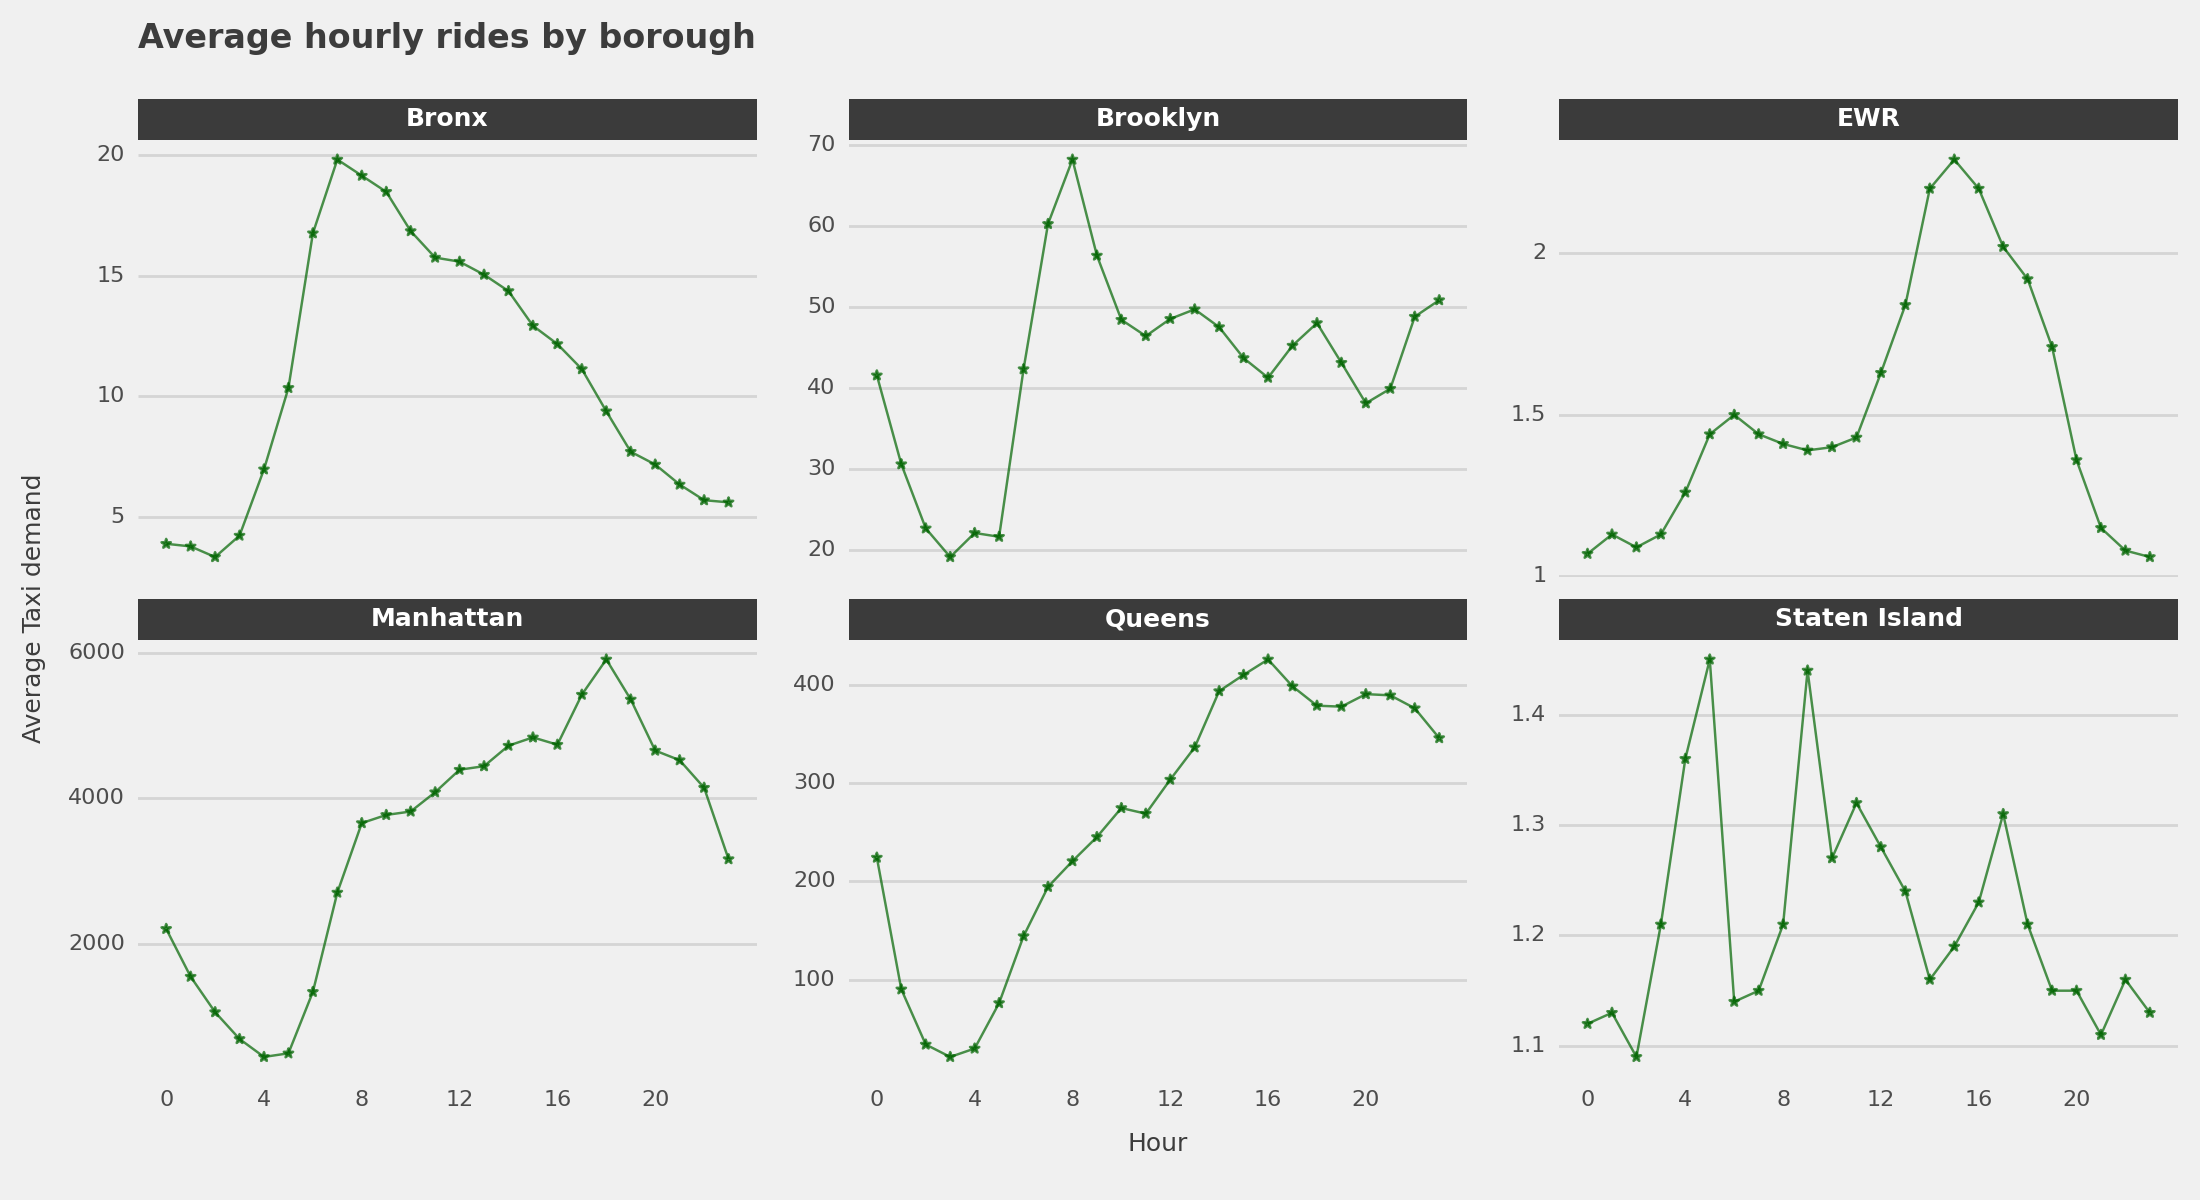

<Figure Size: (1100 x 600)>

In [154]:
(
    pn.ggplot(borough_hourly_demand, pn.aes(x='hour', y='avg_rides')) +
    pn.geom_line(color='darkgreen', alpha=0.7) +
    pn.geom_point(color='darkgreen', alpha=0.7, shape='*') +
    pn.facet_wrap('~borough', nrow=2, scales='free_y') +
    pn.theme_538() +
    pn.theme(figure_size=(11,6),
             strip_background=pn.element_rect(fill='black', alpha=0.5),
             strip_text=pn.element_text(color='white', size=9, face='bold'),
             panel_grid_major_x= pn.element_blank(),
             axis_text=pn.element_text(size=8),
             axis_title=pn.element_text(size=9), 
             plot_title=pn.element_text(size=12, face='bold')) +
    pn.labs(title='Average hourly rides by borough', y='Average Taxi demand', x='Hour') +
    pn.scale_x_continuous(breaks=range(0, 24,4))
)

- The average hourly demand of stations in each borough differs although a similarity where in all, there's an early reduction in taxi demand in the early hours of the day.
- In Bronx, the hourly taxi demand peaks to about 20 taxis on average at around 7 AM and this demand declines slowly till the end of the day.
- In Brooklyn,

In [155]:
# close connection
conn.close()

---

## **Analysis findings**

We analysed New York's Taxi and Limousine Commission's (TLC) data about yellow taxi trips hauled between January 2019 and March 2024. The analysis was structured in six (6) main headings. We examined 

- The Key Performance Indicators (KPIs) such as the total volume of yellow taxis booked and paid for by commuters
- Temporal variations of taxi volume and revenue generated over time, per hour, day of the week, month, and year.
- The impact of holiday, seasonal and weekday events on the volume of taxi rides as well as the revenue generated
- The taxi demand across stations to understand the areas where demands are concentrated. This was investigated based on the top 10 and least 10 pickup and destination stations by ride volume. We further delved into finding the top and least 10 terminals by total pickup volume and revenue and grouping them into low, medium and high-demand areas. Next, we concentrated on the average taxi demand, revenue, total revenue generated from trip fares, the average fare cost and the charges levied per hour by these high-demand stations. This was done to identify the impact of the hour of the day on them. 
- The kind of trips that are made at the pickup stations. To do this, we grouped the average trip duration at pickup terminals into short, medium and long trips. After that, stations in boroughs were grouped based on the trip types and the number of stations in each borough in each group was identified. 
- The trip fares and charges at various pickup stations. We visualised their average values by trip types and ride demand groups. We also identified the top and least 10 pickup terminals by charges and trip fares. We also visualised the fare cost and charges across pickup stations per hour, month and month of every year.
- The total revenue and ride volume by borough and their average values across all pickup stations. This was visualised using a geographical map.

**A. Key performance summary**

Over 3.97 billion dollars have been generated in revenue by the TLC between January 2019 and March 2024 from over 173.9 million rides. This represents a revenue of 834.82 dollars on average in a pickup station and an aggregated revenue of 86,361 dollars on average across all pickup stations. However, 37 rides are demanded on average in a pickup station with an aggregate of 3,780 rides in all pickup stations in New York. 

**B. Temporal variations**

Before COVID-19 incidence, an average of about 4,500 rides in total were demanded across all pickup stations per hour (over 40 per hour in a pickup station). However, this declined to almost less than 500 rides due to the COVID-19 lockdown in 2020 and has since increased over time but has remained relatively the same on average between 2022 and the present. Similarly, the impact of the COVID-19 lockdown in 2020 was evident in the revenue generated, but since the resumption of vehicular activities, the revenue generated has seen an uptrend on average from April 2020 till now. To further understand the impact of temporal variations on taxi demand, we drilled down into looking at the variations in hours of the day, day of the week and month of the year.
We identified that the demand of taxis differs per hour of the day. During the late hours of the night and the early hours of the morning (12-4 AM), the amount of taxis demanded declines. The demand begins to rise first between 5 AM and the first rush hour of 8-9 AM, slowly increases and peaks at the next rush hour of the day (that is hours marking the end of working activities) which is 6 PM before declining till the night hours. This is the same every year. Furthermore, the average taxi ride demanded by commuters begins to increase at the start of the week (Sunday) and peaks on Thursday before declining slowly from Friday and Saturday. In addition, the monthly demand for taxis is usually low during major holidays and the month after a major holiday, decreasing from the start of the year to the middle of the year before increasing towards the end of the year. Overall, the amount of taxis demanded by commuters declines during the Summer holidays and the Christmas holidays.

**C. Impact of holiday events, seasons, and weekday/weekday on demand and revenue**

There's a statistical significance of the impact of seasonal events, holidays and weekends on the amount of rides demanded. Firstly, in the Summer, the number of taxis hauled is low compared to other seasons of the year. We assume that the reason for this decline is the vacation taken by most workers and as well the school holidays. In this season, most workers use this time to rest from work and re-strategise. Surprisingly, the amount of rides is the highest during the Winter season (average of 36 per hour). One reason for this is the many tourist and fun activities that happen in this season such as the Christmas and New Year activities where residents go out to have fun. They could go to parks, tourist centres, hiking, cultural events or visiting historical sites. The amount of taxis demanded on holidays is lower compared to non-holiday events, similarly, the amount of rides demanded on weekdays is slightly higher than on weekends at most hours of the day but higher in the early hours of the day, probably due to weekend long travels.

**D. Station popularity**

- By visualising areas where commuters are concentrated based on the average hourly pickups, we identified that our commuters are concentrated within Manhattan and some parts of Queens. This analysis was done to identify areas where we need to ensure enough taxis are available to deal with the demand.
  
- By aggregating the number of pickups in all these stations from Jan 2019 to Mar 2024, the top 10 stations (Upper East Side (North and South), Midtown (Center and East), Penn Station/Madison Square West, JFK Airport, Lincoln Square East, Murray Hill, Union Square and Times Square/Theatre District) have recorded over 5 million pickups with an average pickup between 112 and 180 rides per hour. Next, we examined the amount in revenue generated by these top 10 stations. The result showed that over 90 million dollars have been generated by them with the station at JFK Airport generating over 400 million dollars, which is over 9,300 dollars generated per hour. For the other 9 top stations, the average revenue generated per hour ranges between 2,155 and 3,400 dollars. Next, we examined stations with the lowest pickups from Jan 2019 and Mar 2024. Ten of these stations have total pickups within 200 (1 pickup per hour) and less than 20,000 dollars generated in revenue. The station with the least total pickups is the station at Great Kills Park with less than 20 pickups.

- Furthermore, we examined the number of rides going (dropoffs) into each station, and it was found that 8 out of the top 10 stations by dropoffs are among the top 10 stations by pickups, with only stations at Upper West Side South and Lenox Hill West making the list. These stations have dropoffs between 98 and 180 per hour. Similarly, 6 out of 10 least stations by dropoff stations are amongst the least 10 stations by total pickups with stations at Port Richmond, Crotona Park, Willets Point and Broad Channel included in the least 10 dropoff stations.

- By drilling down into the least and top 10 stations in each borough by total pickups, stations with the least pickups are located in areas that are less visited such as tourist centres, beaches, bays, cemeteries and parks. The stations at JFK and LaGuardia airports are the top 2 stations in Queens by total pickups, representing over 85% of all pickups in that borough (over 4 million rides). Similarly, the top 10 stations in Manhattan recorded over 4 million rides.

- Next, we looked at the percentage of taxi dropoffs across stations. This was done by finding the fraction of all rides (pickup and dropoffs) that were dropoffs. This was to identify stations that are dropoff stations by commuters. This percentage of dropoffs was further grouped into three: stations where dropoffs were less than 45%, dropoffs almost equal with pickups (that's dropoffs between 45 and 60%) and a third group where dropoffs were above 60%. From the result, a majority (76.5%) of all stations in all boroughs, (few in Manhattan) had a higher percentage of dropoffs. These stations had median dropoffs of less than 20 per hour. Stations with equal dropoffs and pickups (19.6%) alongside those with lower dropoffs (3.9%) had a median value of 50 dropoffs per hour. 84% (42) of those with equal dropoffs and pickups were in Manhattan, the rest 16% corresponds to 6 in Queens, 1 in Staten Island and 2 in Brooklyn. Only a few stations (10) had higher pickups than dropoffs, with 6 of them located in Manhattan, 3 in Queens and 1 in Bronx.

- To further understand areas based on their hourly demand, the hourly demand of stations was grouped into low, medium and high, where low represents stations with average hourly demand less than the overall mean (15), medium between 15 and 100 (not inclusive) while high demand areas with 100 and above rides. 15 (about 6% of all stations) high-demand stations, located in Manhattan and Queens, contribute 54.1% of the total revenue generated and have about 127 taxis demanded per hour on average. 12% of them in medium-demand areas contributed 39.4% of revenue (55 taxis per hour on average) while the rest 82% generated 6.5% of the revenue (less than 2 rides per hour on average).

**E. Short, medium and Long trips**

To understand trips that are predominantly done in each station, we divided the average hourly duration of trips in each station into three groups. The first group include short trips (trips at most 15 minutes), medium trips (trips >15 and <= 45 minutes) and long trips for trips above 45 minutes. It was found that the majority of the stations (215 of them) were used for medium trips, 28 for short trips and the rest 16 for long trips. 13 of those used for long trips were stations located in Staten Island, 2 in Queens and 1 in Manhattan.

**F. Pricing Strategies**

Next, we delved into estimating the average trip charges and fare costs for stations. This was to determine pricing strategies in stations.

- Firstly, we visualised the average charge and fare cost for stations by ride demand and trip type. From the result, long trips are associated with stations with low demand. The trip cost and charge depend on the trip type (short, medium or long trips) and the fare cost in low-demand stations is higher than fares in medium or high-demand stations. On average, fares for medium or long trips in low-demand areas cost between 25 and 30 dollars while long trips cost over 60 dollars in the same group.

- On the other hand, charges levied seem to depend on the trip distance and taxi demand type. For instance, charges for a long-distance trip are around 11 dollars on average while charges for high-demand areas used for medium-distance trips cost more (more than 9 dollars on average). These high charges for medium-trips in high-demand stations could come from airport fees as we see that the station at JFK airport is a high-demand station or congestion fees while the high charges seen in long distance trips could come mainly from toll fees. Meanwhile, charges depend on other fees such as improvement surcharges, congestion surcharges, MTA taxes, and other miscellaneous surcharges from rush hour and overnight trips.

- The top 10 stations by charges are mostly stations located in facilities such as tourist attraction centres, parks, and airports while the top 10 stations with the least charges are mainly stations located in villages, counties or low populated areas. Stations with the highest fare cost are mainly stations used for long trips while those with the lowest fares are stations predominantly used for short trips.

- Next, we examined if the charges and fare costs depend on the hour of the day. Results show that there are higher fares in the early hours of the day between 12 AM and 3 AM which declines at 8 AM after which trip fares begin to slightly increase till the end of the day. Similarly, there are higher charges during the summer season than in any other season. On the other hand, trip charges look irregular but tend to increase at late and early hours of the day or at taxi-tab peak periods.

**G. Borough and pickup station performance**

Finally, we visualised the performance of stations and boroughs by average rides and revenues, total rides and revenue generated and the number of cities/places/towns found in them. It was found that 91% (over 157 million) of all rides recorded and the average hourly demand concentrated in Manhattan with hourly demands above 30. Next were stations at the LaGuardia and JFK airports in Queens. Similarly, over 3 billion dollars in revenue was generated in Manhattan, followed by Queens with over 742 million dollars while Staten Island generated the least with about 1.2 million dollars.

## **Conclusion**

In conclusion, taxi cabs provide the easiest and fastest way for commuters to get to their destinations on time, especially for last-minute trips, navigating unfamiliar locations, or ensuring a comfortable ride with luggage. For travellers unfamiliar with a city's layout or those with limited mobility, taxis offer a reliable and stress-free option. Additionally, taxis can often provide a more personalized experience compared to ride-sharing services.

Here, we analysed yellow taxi cab demand in the city of New York. We investigated the overall performance of taxi rides in a pickup station and all stations. We examined the impact of hours, seasons, weekends and holiday events on the demand for taxis. We also investigated the areas where taxi demand is concentrated, the top and least 10 pickup stations based on demand, the type of trips commuters mostly make and the revenue generated by different boroughs.

From the analyses, the following insights were obtained

- Over $\$$3.9 billion in over 173 million rides was generated in revenue by TLC for yellow taxis hauled between January 2019 and March 2024. This represents an average revenue of $\$$834.32 from an average of 37 rides per hour in a pickup station and over $\$$86,000 revenue in all stations and 3,750 rides in all pickup stations.
- The demand for taxis depends on some temporal factors such as hours, holidays, and season of the year.
- Most pickup stations with high taxi demand are located in Manhattan with only two from the Queens borough.
- The least 10 stations in terms of taxi demand are stations located in areas that are less visited such as tourist centres, beaches, bays, cemeteries and parks.
- Commuters mostly haul taxis for medium trips (ie trips between 15 and 45 minutes). Most of the long trips were hauled mostly from low-demanded stations with most of them located in Staten Island.
- Charges and the cost of a trip depend on trip distance and type of demand in pickup stations. Pickup stations with low demand are mostly used for long journeys hence have higher trip costs and are charged higher than pickup stations with medium or high demand. Similarly, trip costs and charges depend on the facilities found in the location such as airports, recreational parks and tourist centres as well as the population of people within the location.
- Additionally, the cost of a trip is higher when the demand is low. For instance, it costs higher during the night hours than the day hours. On the other hand, there are higher charges during the early or late hours of the morning and rush hours. Trip costs and charges are higher in the second quarter of the year than in the first quarter and then stay relatively the same throughout the year.

Therefore, identifying the impact of hours of the day, seasons and holidays on the demand for taxis as well as the type of demand at various pickup stations is important to provide seamless services to commuters to enable proper allocation of taxis at locations where they are mostly needed. Also, identifying the cost of a trip and its charges will enable TLC to come up with pricing strategies to encourage commuters to patronise yellow taxi cabs to increase revenue.